In [1]:

import pandas as pd

# Load the CSV file
df = pd.read_csv("labeled_sensor_data.csv")

# Check for missing values in x, y, and z columns
missing_values = df[['x', 'y', 'z']].isnull().sum()

print("Missing values in each column:")
print(missing_values)
duplicate_rows = df[df.duplicated()]

print(f"Number of duplicate rows: {duplicate_rows.shape[0]}")
print("Duplicate rows (if any):")
print(duplicate_rows)
subject_counts = df.groupby('subject').size().reset_index(name='row_count')
print('Subject counts:',subject_counts)

Missing values in each column:
x    0
y    0
z    0
dtype: int64
Number of duplicate rows: 0
Duplicate rows (if any):
Empty DataFrame
Columns: [directory, subject, timestamp, x, y, z, activity_type]
Index: []
Subject counts:   subject  row_count
0      U1       1869
1      U2       3583
2     U21       2131
3     U22       4363
4      U3      34512
5      U4       4830
6      U5       5188
7      U6      33881
8      U7      12575


In [2]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Standardize x, y, z columns
df[['x', 'y', 'z']] = scaler.fit_transform(df[['x', 'y', 'z']])

In [3]:
# Sort by subject, activity_type, and timestamp
df['timestamp'] = pd.to_datetime(df['timestamp'], format='mixed', dayfirst=False, errors='coerce').dt.tz_convert('UTC')
df = df.sort_values(['subject', 'activity_type', 'timestamp'])

# Compute time differences within each subject and activity_type group
df['time_diff'] = df.groupby(['subject', 'activity_type'])['timestamp'].diff().dt.total_seconds()

# Assign a new sequence_id when time_diff > 1 second (indicating a gap)
df['sequence_id'] = (df['time_diff'] > 1.0).cumsum()

# Drop time_diff as it’s no longer needed
df = df.drop(columns=['time_diff'])

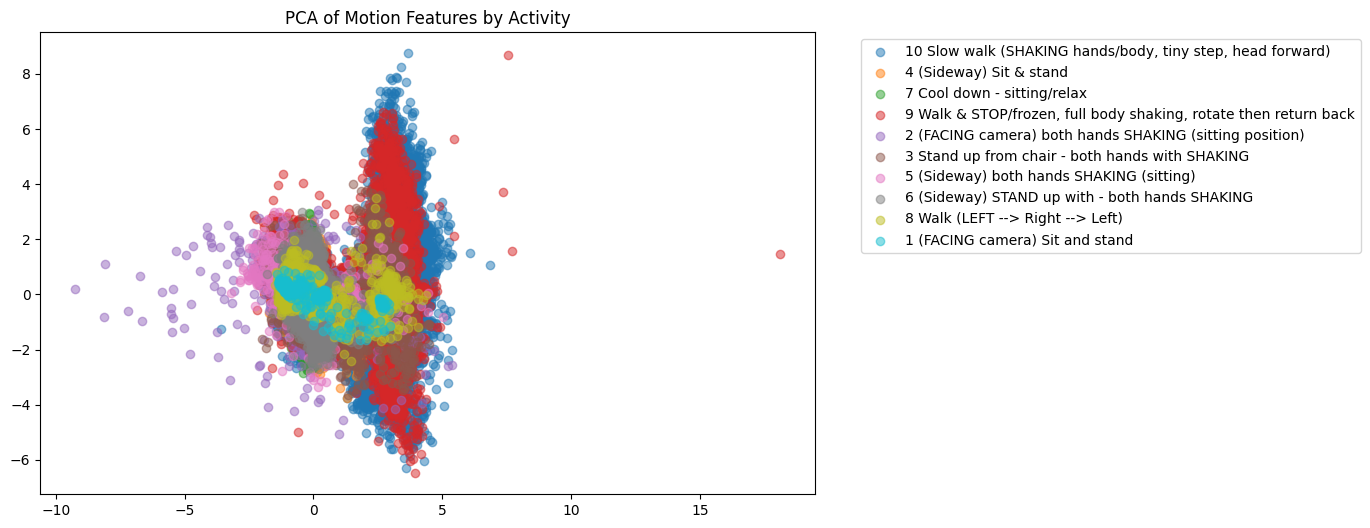

In [4]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce dimensionality
pca = PCA(n_components=2)
df['pca1'], df['pca2'] = zip(*pca.fit_transform(df[['x', 'y', 'z']]).tolist())

# Plot
plt.figure(figsize=(10, 6))
for act in df['activity_type'].unique():
    subset = df[df['activity_type'] == act]
    plt.scatter(subset['pca1'], subset['pca2'], label=act, alpha=0.5)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('PCA of Motion Features by Activity')
plt.show()


In [5]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
from scipy.signal import find_peaks

def generate_windows(group, window_size=pd.Timedelta(seconds=2), step_size=pd.Timedelta(seconds=1)):
    group = group.sort_values('timestamp')
    start_time = group['timestamp'].min()
    end_time = group['timestamp'].max()
    windows = []
    labels = []
    current_start = start_time
    
    while current_start + window_size <= end_time:
        window_end = current_start + window_size
        window_data = group[(group['timestamp'] >= current_start) & (group['timestamp'] < window_end)]
        if not window_data.empty:
            windows.append(window_data)
            labels.append(group['activity_type'].iloc[0])  # All rows have the same activity_type
        current_start += step_size
    
    return windows, labels

# Process all sequences
all_windows = []
all_labels = []
for (subject, activity_type, sequence_id), group in df.groupby(['subject', 'activity_type', 'sequence_id']):
    windows, labels = generate_windows(group)
    all_windows.extend(windows)
    all_labels.extend(labels)

In [6]:
def extract_features(window_data):
    features = {}
    
    # Add subject
    features['subject'] = window_data['subject'].iloc[0]
    
    # Time-Domain Features
    for axis in ['x', 'y', 'z']:
        data = window_data[axis]
        features[f'{axis}_mean'] = data.mean()
        features[f'{axis}_std'] = data.std()
        features[f'{axis}_skew'] = skew(data)
        features[f'{axis}_kurt'] = kurtosis(data)
    
    # Magnitude Features
    mag = np.sqrt(window_data['x']**2 + window_data['y']**2 + window_data['z']**2)
    features['mag_mean'] = mag.mean()
    features['mag_std'] = mag.std()
    
    # Frequency-Domain Features
    for axis in ['x', 'y', 'z']:
        fft_vals = np.abs(np.fft.fft(window_data[axis]))[:len(window_data[axis])//2]
        freqs = np.fft.fftfreq(len(window_data[axis]), d=0.135)[:len(window_data[axis])//2]
        for low, high in [(0, 1), (1, 2), (2, 3), (3, 3.7)]:
            mask = (freqs >= low) & (freqs < high)
            features[f'{axis}_power_{low}-{high}'] = np.sum(fft_vals[mask]**2) if mask.any() else 0
    
    # Step Frequency
    peaks, _ = find_peaks(mag, height=mag.mean() + mag.std(), distance=3)
    window_duration = (window_data['timestamp'].max() - window_data['timestamp'].min()).total_seconds()
    features['step_frequency'] = len(peaks) / window_duration if window_duration > 0 else 0
    
    return features


# Extract features from all windows
feature_list = [extract_features(window) for window in all_windows]
features_df = pd.DataFrame(feature_list)
features_df['label'] = all_labels

In [7]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
features_df['label'] = le.fit_transform(features_df['label'])

In [8]:
subjects = features_df['subject'].unique()
train_subjects = subjects[:7]
test_subjects = subjects[7:]

train_df = features_df[features_df['subject'].isin(train_subjects)]
test_df = features_df[features_df['subject'].isin(test_subjects)]


X_train = train_df.drop(columns=['label', 'subject'])
y_train = train_df['label']
X_test = test_df.drop(columns=['label', 'subject'])
y_test = test_df['label']

In [9]:
train_df.subject.value_counts(),train_subjects,test_subjects

(subject
 U3     700
 U22    526
 U4     526
 U5     524
 U2     406
 U21    234
 U1     232
 Name: count, dtype: int64,
 array(['U1', 'U2', 'U21', 'U22', 'U3', 'U4', 'U5'], dtype=object),
 array(['U6', 'U7'], dtype=object))

In [10]:
train_df

subject    x_mean     x_std    x_skew    x_kurt    y_mean     y_std  \
0         U1  1.039046  0.289536  0.636500  0.186002 -2.825303  0.237446   
1         U1  1.051399  0.191080  0.299686  3.119047 -2.291205  0.406181   
2         U1  0.799902  0.335252 -0.543869 -0.810680 -1.711159  0.658912   
3         U1  0.275722  0.324626 -0.052842 -1.212538 -0.826562  0.409405   
4         U1 -0.082938  0.079295 -0.767694  0.276705 -0.303571  0.135254   
...      ...       ...       ...       ...       ...       ...       ...   
3143      U5  1.462804  0.268560 -0.534577  0.062305 -2.409635  0.233372   
3144      U5  1.375083  0.263124 -0.143905 -0.583934 -2.501703  0.246965   
3145      U5  1.267863  0.166759  0.258197 -0.806400 -2.565037  0.227897   
3146      U5  1.311921  0.352903  0.310465 -0.634592 -2.530640  0.279415   
3147      U5  1.377804  0.369830 -0.034232 -1.049404 -2.509542  0.280876   

        y_skew    y_kurt    z_mean  ...  y_power_0-1  y_power_1-2  \
0     0.851809  0.515705 -1.090639  ...  1799.461384     1.752469   
1    -0.338864 -0.093433 -0.422957  ...  5432.738400    15.490807   
2     0.085218 -0.768201  0.032903  ...  5482.616175    35.517607   
3    -0.209649 -1.130426  0.447884  ...   466.856616     7.286460   
4    -0.368033 -1.185725  0.425295  ...    25.377995     0.326606   
...        ...       ...       ...  ...          ...          ...   
3143 -0.272897 -1.113606 -1.242487  ...  1306.573206     2.107369   
3144 -0.200440 -1.124669 -1.359655  ...  1410.122101     1.416509   
3145  0.283226 -0.845142 -1.484697  ...  1481.962707     1.296445   
3146  0.054591 -1.291133 -1.275789  ...  1442.409683     1.388280   
3147 -0.253154 -1.290177 -1.155355  ...  1417.920914     0.988004   

      y_power_2-3  y_power_3-3.7  z_power_0-1  z_power_1-2  z_power_2-3  \
0        0.680077       0.000000   268.867212     0.738078     0.080534   
1        6.251968       2.869321   264.598168     9.064423     2.368158   
2       14.231575       5.963741   157.065633    12.131387     0.752298   
3        1.606632       1.024365   128.380347     1.003185     0.429495   
4        0.069823       0.002830    46.449367     0.140392     0.124444   
...           ...            ...          ...          ...          ...   
3143     3.329799       0.000000   349.140513    10.333474    21.908799   
3144     2.966668       0.000000   419.805877     7.906470    33.647142   
3145     2.091998       0.000000   497.770922    15.040278    17.268311   
3146     2.810917       0.000000   370.085582     1.515792     7.442286   
3147     4.798350       0.000000   307.261339     0.587261     9.797961   

      z_power_3-3.7  step_frequency  label  
0          0.000000        0.537057      1  
1          0.617669        1.033592      1  
2          1.190038        1.125492      1  
3          0.145687        0.000000      1  
4          0.040101        0.502513      1  
...             ...             ...    ...  
3143       0.000000        0.535906      9  
3144       0.000000        1.072961      9  
3145       0.000000        0.537057      9  
3146       0.000000        1.072386      9  
3147       0.000000        0.000000      9  

[3148 rows x 29 columns]

In [11]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

# Optional: combine your X_train, y_train for splitting inside Optuna if needed
# X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

def objective(trial):
    # Define hyperparameter search space
    n_estimators = trial.suggest_int("n_estimators", 10, 200)
    max_depth = trial.suggest_int("max_depth", 2, 30)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 20)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])
    
    # Create model with sampled parameters
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42,
        n_jobs=-1
    )

    # Train and predict
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Use weighted F1 score to account for class imbalance
    score = f1_score(y_test, y_pred, average='weighted')
    return score

# Run the optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50, timeout=300)  # e.g., 50 trials or 5 mins max

# Print best result
print("Best trial:")
print("  Value (F1):", study.best_trial.value)
print("  Params:", study.best_trial.params)

# Use best parameters to retrain model
best_params = study.best_trial.params
optimized_model = RandomForestClassifier(**best_params, random_state=42)
optimized_model.fit(X_train, y_train)
y_pred = optimized_model.predict(X_test)

# Final evaluation
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))



c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-05-22 18:08:57,486] A new study created in memory with name: no-name-ad47654c-d8c4-4574-8de3-2c66d74269ea
[I 2025-05-22 18:08:57,807] Trial 0 finished with value: 0.1521980241363354 and parameters: {'n_estimators': 151, 'max_depth': 17, 'min_samples_split': 5, 'min_samples_leaf': 16, 'max_features': 'log2'}. Best is trial 0 with value: 0.1521980241363354.
[I 2025-05-22 18:08:57,991] Trial 1 finished with value: 0.15302145357074495 and parameters: {'n_estimators': 83, 'max_depth': 24, 'min_samples_split': 9, 'min_samples_leaf': 15, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.15302145357074495.
[I 2025-05-22 18:08:58,116] Trial 2 finished with value: 0.1536187571723274 and parameters: {'n_estimato

Best trial:
  Value (F1): 0.1826802734143339
  Params: {'n_estimators': 27, 'max_depth': 18, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': None}
              precision    recall  f1-score   support

           1       0.25      0.34      0.29       176
           2       0.18      0.14      0.16        58
           3       0.15      0.09      0.11       116
           4       0.01      0.02      0.02        58
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00       116
           7       0.00      0.00      0.00        58
           8       0.14      0.26      0.19        58
           9       0.30      0.35      0.32       236

    accuracy                           0.20       876
   macro avg       0.12      0.13      0.12       876
weighted avg       0.17      0.20      0.18       876



c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{

### Advanced Approach: Subject-Adaptive Transformer with Domain-Specific Features

In [13]:
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis
from scipy.signal import find_peaks
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

# Preprocessing: Normalize per subject
def normalize_per_subject(df):
    scaler = StandardScaler()
    for subject in df['subject'].unique():
        mask = df['subject'] == subject
        df.loc[mask, ['x', 'y', 'z']] = scaler.fit_transform(df.loc[mask, ['x', 'y', 'z']])
    return df

# Data Augmentation: Add jitter
def augment_data(window_data):
    noise = np.random.normal(0, 0.01, window_data[['x', 'y', 'z']].shape)
    window_data[['x', 'y', 'z']] += noise
    return window_data

# Generate Windows
def generate_windows(group, window_size=pd.Timedelta(seconds=1), step_size=pd.Timedelta(seconds=0.5)):
    group = group.sort_values('timestamp')
    start_time = group['timestamp'].min()
    end_time = group['timestamp'].max()
    windows = []
    labels = []
    subjects = []
    current_start = start_time
    
    while current_start + window_size <= end_time:
        window_end = current_start + window_size
        window_data = group[(group['timestamp'] >= current_start) & (group['timestamp'] < window_end)]
        if not window_data.empty:
            # Apply augmentation with 50% probability
            if np.random.rand() > 0.5:
                window_data = augment_data(window_data.copy())
            windows.append(window_data)
            labels.append(group['activity_type'].iloc[0])
            subjects.append(group['subject'].iloc[0])
        current_start += step_size
    
    return windows, labels, subjects

# Feature Extraction
def extract_features(window_data):
    features = {}
    
    # Time-Domain Features
    for axis in ['x', 'y', 'z']:
        data = window_data[axis]
        features[f'{axis}_mean'] = data.mean()
        features[f'{axis}_std'] = data.std()
        features[f'{axis}_skew'] = skew(data)
        features[f'{axis}_kurt'] = kurtosis(data)
        features[f'{axis}_min'] = data.min()
        features[f'{axis}_max'] = data.max()
        features[f'{axis}_range'] = data.max() - data.min()
    
    # Magnitude Features
    mag = np.sqrt(window_data['x']**2 + window_data['y']**2 + window_data['z']**2)
    features['mag_mean'] = mag.mean()
    features['mag_std'] = mag.std()
    
    # Cross-Axis Correlation
    features['xy_corr'] = window_data['x'].corr(window_data['y'])
    features['xz_corr'] = window_data['x'].corr(window_data['z'])
    features['yz_corr'] = window_data['y'].corr(window_data['z'])
    
    # Frequency-Domain Features
    for axis in ['x', 'y', 'z']:
        fft_vals = np.abs(np.fft.fft(window_data[axis]))[:len(window_data[axis])//2]
        freqs = np.fft.fftfreq(len(window_data[axis]), d=0.135)[:len(window_data[axis])//2]
        for low, high in [(0, 1), (1, 2), (2, 3), (3, 3.7)]:
            mask = (freqs >= low) & (freqs < high)
            features[f'{axis}_power_{low}-{high}'] = np.sum(fft_vals[mask]**2) if mask.any() else 0
    
    # Step Frequency
    peaks, _ = find_peaks(mag, height=mag.mean() + mag.std(), distance=3)
    window_duration = (window_data['timestamp'].max() - window_data['timestamp'].min()).total_seconds()
    features['step_frequency'] = len(peaks) / window_duration if window_duration > 0 else 0
    
    # Convert to numerical array
    feature_values = [v if not np.isnan(v) else 0 for k, v in features.items()]
    return np.array(feature_values)

# Prepare Sequences
def prepare_sequences(df, max_seq_len=50):
    sequences = []
    labels = []
    subjects = []
    max_len = 0
    for (subject, activity_type, sequence_id), group in df.groupby(['subject', 'activity_type', 'sequence_id']):
        windows, window_labels, window_subjects = generate_windows(group)
        if windows:
            sequence_features = [extract_features(window) for window in windows]
            seq_len = len(sequence_features)
            if seq_len > max_seq_len:
                sequence_features = sequence_features[:max_seq_len]
                seq_len = max_seq_len
            max_len = max(max_len, seq_len)
            sequences.append(np.array(sequence_features))
            labels.append(window_labels[0])
            subjects.append(window_subjects[0])
    print(f"Maximum sequence length: {max_len}")
    return sequences, labels, subjects, max_len

# Custom Dataset
class ActivityDataset(Dataset):
    def __init__(self, sequences, labels, subjects, subject_encoder):
        self.sequences = sequences
        self.labels = labels
        self.subjects = [subject_encoder.get(subj, len(subject_encoder)) for subj in subjects]
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx], self.subjects[idx]

def collate_fn(batch):
    sequences, labels, subjects = zip(*batch)
    max_len = max(seq.shape[0] for seq in sequences)
    padded_sequences = []
    masks = []
    for seq in sequences:
        pad_width = ((0, max_len - seq.shape[0]), (0, 0))
        padded_seq = np.pad(seq, pad_width, mode='constant', constant_values=0)
        padded_sequences.append(padded_seq)
        mask = np.ones(seq.shape[0], dtype=bool)
        mask = np.pad(mask, (0, max_len - seq.shape[0]), mode='constant', constant_values=False)
        masks.append(mask)
    return (torch.tensor(padded_sequences, dtype=torch.float32),
            torch.tensor(masks, dtype=torch.bool),
            torch.tensor(labels, dtype=torch.long),
            torch.tensor(subjects, dtype=torch.long))

# Transformer Model
class ActivityTransformer(nn.Module):
    def __init__(self, num_features, num_classes, num_subjects, max_seq_len, d_model=64, num_heads=4, num_layers=1, dropout=0.3, embedding_dim=16):
        super(ActivityTransformer, self).__init__()
        self.d_model = d_model
        self.subject_embedding = nn.Embedding(num_subjects + 1, embedding_dim)
        self.input_proj = nn.Linear(num_features + embedding_dim, d_model)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, d_model))
        self.pos_encoder = nn.Parameter(torch.zeros(1, max_seq_len + 1, d_model))
        encoder_layer = nn.TransformerEncoderLayer(d_model, num_heads, dim_feedforward=256, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.classifier = nn.Linear(d_model, num_classes)
    
    def forward(self, x, mask, subject_ids):
        batch_size, seq_len, num_features = x.shape
        subj_emb = self.subject_embedding(subject_ids).unsqueeze(1).expand(-1, seq_len, -1)
        x = torch.cat((x, subj_emb), dim=-1)
        x = self.input_proj(x)
        cls_token = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat((cls_token, x), dim=1)
        pos_encoding = self.pos_encoder[:, :seq_len + 1, :]
        x += pos_encoding
        cls_mask = torch.ones(batch_size, 1, dtype=torch.bool, device=x.device)
        full_mask = torch.cat((cls_mask, mask), dim=1)
        transformer_mask = ~full_mask
        x = x.permute(1, 0, 2)
        x = self.transformer_encoder(x, src_key_padding_mask=transformer_mask)
        x = x.permute(1, 0, 2)
        cls_output = x[:, 0, :]
        return self.classifier(cls_output)

# Training and Evaluation Functions
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for batch in loader:
        sequences, masks, labels, subjects = [b.to(device) for b in batch]
        optimizer.zero_grad()
        logits = model(sequences, masks, subjects)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader, device, le):
    model.eval()
    preds, true = [], []
    with torch.no_grad():
        for batch in loader:
            sequences, masks, labels, subjects = [b.to(device) for b in batch]
            logits = model(sequences, masks, subjects)
            preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
            true.extend(labels.cpu().numpy())
    acc = accuracy_score(true, preds)
    f1 = f1_score(true, preds, average='weighted')
    # Per-class F1
    per_class_f1 = f1_score(true, preds, average=None)
    print("Per-class F1-scores:", dict(zip(le.classes_, per_class_f1)))
    # Confusion Matrix
    cm = confusion_matrix(true, preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig('confusion_matrix.png')
    plt.close()
    return acc, f1

# Early Stopping
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
    
    def __call__(self, val_f1, model):
        score = val_f1
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0


# Preprocess
df = normalize_per_subject(df)
sequences, labels, subjects, max_seq_len = prepare_sequences(df)
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)
subject_encoder = {subj: idx for idx, subj in enumerate(sorted(set(subjects)))}

val_subjects = ['U3']  
train_idx = [i for i, s in enumerate(subjects) if s not in val_subjects]
val_idx = [i for i, s in enumerate(subjects) if s in val_subjects]

train_data = ([sequences[i] for i in train_idx], labels_encoded[train_idx], [subjects[i] for i in train_idx])
val_data = ([sequences[i] for i in val_idx], labels_encoded[val_idx], [subjects[i] for i in val_idx])

train_dataset = ActivityDataset(*train_data, subject_encoder)
val_dataset = ActivityDataset(*val_data, subject_encoder)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)


# Model Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_features = sequences[0].shape[1]  # Should be 24: (7 time + 4 freq) * 3 axes + 2 mag + 3 corr + 1 step
model = ActivityTransformer(
    num_features=num_features,
    num_classes=len(le.classes_),
    num_subjects=len(subject_encoder),
    max_seq_len=max_seq_len,
    d_model=64,
    num_heads=4,
    num_layers=1,
    dropout=0.3,
    embedding_dim=16
).to(device)
class_weights = torch.tensor([1.0 / Counter(labels_encoded)[i] for i in range(len(le.classes_))], dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)
early_stopping = EarlyStopping(patience=5)

# Training Loop
for epoch in range(30):
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    val_acc, val_f1 = evaluate(model, val_loader, device, le)
    print(f"Epoch {epoch+1}: Loss={train_loss:.4f}, Val Acc={val_acc:.4f}, Val F1={val_f1:.4f}")
    scheduler.step(train_loss)
    # early_stopping(val_f1, model)
    # if early_stopping.early_stop:
    #     print("Early stopping triggered")
    #     break

Maximum sequence length: 50


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:140: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  return (torch.tensor(padded_sequences, dtype=torch.float32),
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0}
Epoch 1: Loss=2.4964, Val Acc=0.0000, Val F1=0.0000
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0}


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Epoch 2: Loss=2.3394, Val Acc=0.1000, Val F1=0.0500
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0}


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Epoch 3: Loss=2.2981, Val Acc=0.1000, Val F1=0.0667
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0}


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Epoch 4: Loss=2.2342, Val Acc=0.1000, Val F1=0.1333
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0}


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Epoch 5: Loss=2.2972, Val Acc=0.1000, Val F1=0.0667
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0}


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Epoch 6: Loss=2.2742, Val Acc=0.0000, Val F1=0.0000
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0}


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Epoch 7: Loss=2.0362, Val Acc=0.0000, Val F1=0.0000
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0}


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Epoch 8: Loss=2.2192, Val Acc=0.0000, Val F1=0.0000
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0}


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Epoch 9: Loss=2.0719, Val Acc=0.0000, Val F1=0.0000
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0}


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Epoch 10: Loss=1.9101, Val Acc=0.0000, Val F1=0.0000
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0}


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Epoch 11: Loss=2.0627, Val Acc=0.0000, Val F1=0.0000
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Epoch 12: Loss=1.9932, Val Acc=0.1000, Val F1=0.0667
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0}


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Epoch 13: Loss=2.0332, Val Acc=0.1000, Val F1=0.0667
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0}


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Epoch 14: Loss=1.9791, Val Acc=0.2000, Val F1=0.2000
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0}


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Epoch 15: Loss=1.9078, Val Acc=0.2000, Val F1=0.2000
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0}


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Epoch 16: Loss=1.8067, Val Acc=0.2000, Val F1=0.2000
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0}


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Epoch 17: Loss=1.9002, Val Acc=0.2000, Val F1=0.2000
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0}


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Epoch 18: Loss=1.9661, Val Acc=0.2000, Val F1=0.2000
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0}


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Epoch 19: Loss=1.8918, Val Acc=0.2000, Val F1=0.2000
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0}


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Epoch 20: Loss=1.8508, Val Acc=0.2000, Val F1=0.2000
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0}


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Epoch 21: Loss=1.8746, Val Acc=0.2000, Val F1=0.2000
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0}


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Epoch 22: Loss=1.9290, Val Acc=0.2000, Val F1=0.2000
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0}


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Epoch 23: Loss=1.8515, Val Acc=0.2000, Val F1=0.2000
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0}


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Epoch 24: Loss=1.8737, Val Acc=0.2000, Val F1=0.2000
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0}


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Epoch 25: Loss=1.9417, Val Acc=0.2000, Val F1=0.2000
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0}


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Epoch 26: Loss=1.8752, Val Acc=0.2000, Val F1=0.2000
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0}


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Epoch 27: Loss=1.8953, Val Acc=0.2000, Val F1=0.2000
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0}


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Epoch 28: Loss=1.8823, Val Acc=0.2000, Val F1=0.2000
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0}


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Epoch 29: Loss=1.9287, Val Acc=0.2000, Val F1=0.2000
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0}


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Epoch 30: Loss=1.7754, Val Acc=0.2000, Val F1=0.2000


In [30]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import optuna
import os

# Create main results directory
results_dir = 'results'
os.makedirs(results_dir, exist_ok=True)

# Modify evaluate function to handle dynamic labels
def evaluate(model, loader, device, le):
    model.eval()
    preds, true = [], []
    with torch.no_grad():
        for batch in loader:
            sequences, masks, labels, subjects = [b.to(device) for b in batch]
            logits = model(sequences, masks, subjects)
            preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
            true.extend(labels.cpu().numpy())
    acc = accuracy_score(true, preds)
    f1 = f1_score(true, preds, average='weighted')
    # Per-class F1
    per_class_f1 = f1_score(true, preds, average=None)
    unique_labels = np.unique(true)
    print("Per-class F1-scores:", dict(zip(le.inverse_transform(unique_labels), per_class_f1)))
    # Log missing classes
    missing_classes = set(range(len(le.classes_))) - set(unique_labels)
    if missing_classes:
        print(f"Missing classes in this fold: {le.inverse_transform(list(missing_classes))}")
    # Confusion Matrix
    cm = confusion_matrix(true, preds, labels=unique_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.inverse_transform(unique_labels), yticklabels=le.inverse_transform(unique_labels))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    return acc, f1, preds, true

# Preprocess the data
df = normalize_per_subject(df)
sequences, labels, subjects, max_seq_len = prepare_sequences(df)
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)
subject_encoder = {subj: idx for idx, subj in enumerate(sorted(set(subjects)))}

# Analyze activity distribution per subject
subject_activity_counts = {}
for subj in set(subjects):
    subj_indices = [i for i, s in enumerate(subjects) if s == subj]
    subj_labels = [labels[i] for i in subj_indices]
    subject_activity_counts[subj] = Counter(subj_labels)

# Custom stratification: Group subjects by activity distribution
def assign_subjects_to_folds(subjects, activity_counts, n_splits=5):
    # Ensure each fold has all activities
    activity_groups = {}
    for subj, counts in activity_counts.items():
        for activity in counts.keys():
            if activity not in activity_groups:
                activity_groups[activity] = []
            activity_groups[activity].append(subj)
    
    folds = [[] for _ in range(n_splits)]
    for activity, subj_list in activity_groups.items():
        np.random.shuffle(subj_list)
        for i, subj in enumerate(subj_list):
            folds[i % n_splits].append(subj)
    
    # Verify each fold has all activities
    for i, fold in enumerate(folds):
        fold_activities = set()
        for subj in fold:
            fold_activities.update(activity_counts[subj].keys())
        if len(fold_activities) < len(activity_counts[list(activity_counts.keys())[0]]):
            print(f"Warning: Fold {i+1} is missing some activities: {set(activity_counts.keys()) - fold_activities}")
    
    return folds

# Define the objective function for Optuna
def objective(trial):
    # Define hyperparameter search space
    d_model = trial.suggest_categorical('d_model', [64, 128, 256])
    num_heads = trial.suggest_categorical('num_heads', [2, 4, 8])
    if d_model % num_heads != 0:
        raise optuna.TrialPruned()
    num_layers = trial.suggest_int('num_layers', 1, 3)
    dropout = trial.suggest_float('dropout', 0.1, 0.5)
    embedding_dim = trial.suggest_categorical('embedding_dim', [16, 32, 64])
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [8, 16, 32])
    
    # Create trial-specific directory
    trial_dir = os.path.join(results_dir, f'trial_{trial.number}')
    os.makedirs(trial_dir, exist_ok=True)
    
    # Assign subjects to folds
    n_splits = 5
    folds = assign_subjects_to_folds(list(set(subjects)), subject_activity_counts, n_splits)
    fold_f1_scores = []
    
    # Cross-Validation Loop
    for fold in range(n_splits):
        fold_dir = os.path.join(trial_dir, f'fold_{fold + 1}')
        os.makedirs(fold_dir, exist_ok=True)
        
        val_subjects = folds[fold]
        train_subjects = [subj for i, fold_subjs in enumerate(folds) if i != fold for subj in fold_subjs]
        
        train_idx = [i for i, s in enumerate(subjects) if s in train_subjects]
        val_idx = [i for i, s in enumerate(subjects) if s in val_subjects]
        
        train_data = ([sequences[i] for i in train_idx], labels_encoded[train_idx], [subjects[i] for i in train_idx])
        val_data = ([sequences[i] for i in val_idx], labels_encoded[val_idx], [subjects[i] for i in val_idx])
        
        train_dataset = ActivityDataset(*train_data, subject_encoder)
        val_dataset = ActivityDataset(*val_data, subject_encoder)
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
        
        # Initialize model
        model = ActivityTransformer(
            num_features=sequences[0].shape[1],
            num_classes=len(le.classes_),
            num_subjects=len(subject_encoder),
            max_seq_len=max_seq_len,
            d_model=d_model,
            num_heads=num_heads,
            num_layers=num_layers,
            dropout=dropout,
            embedding_dim=embedding_dim
        ).to(device)
        
        class_weights = torch.tensor([1.0 / Counter(labels_encoded)[i] for i in range(len(le.classes_))], dtype=torch.float).to(device)
        criterion = nn.CrossEntropyLoss(weight=class_weights)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)
        early_stopping = EarlyStopping(patience=5)
        
        best_val_f1 = 0
        for epoch in range(30):
            train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
            val_acc, val_f1, preds, true = evaluate(model, val_loader, device, le)
            print(f"Trial {trial.number}, Fold {fold + 1}, Epoch {epoch + 1}: Loss={train_loss:.4f}, Val Acc={val_acc:.4f}, Val F1={val_f1:.4f}")
            
            # Save confusion matrix
            plt.savefig(os.path.join(fold_dir, 'confusion_matrix.png'))
            plt.close()
            
            # Save classification report
            unique_labels = np.unique(true)
            report = classification_report(true, preds, labels=unique_labels, target_names=le.inverse_transform(unique_labels))
            with open(os.path.join(fold_dir, 'classification_report.txt'), 'w') as f:
                f.write(report)
            
            scheduler.step(train_loss)
            early_stopping(val_f1, model)
            if early_stopping.early_stop:
                print(f"Early stopping triggered in fold {fold + 1}")
                break
            
            trial.report(val_f1, epoch)
            if trial.should_prune():
                print(f"Trial {trial.number}, Fold {fold + 1} pruned")
                break
        
        fold_f1_scores.append(val_f1)
    
    return np.mean(fold_f1_scores)

# Create and run Optuna study
study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=20)

# Print best trial
print("\nBest Trial:")
best_trial = study.best_trial
print(f"Best Value (Mean F1-Score): {best_trial.value:.4f}")
print("Best Hyperparameters:")
for key, value in best_trial.params.items():
    print(f"  {key}: {value}")

# Train final model with best hyperparameters
best_params = best_trial.params
final_model_dir = os.path.join(results_dir, 'final_model')
os.makedirs(final_model_dir, exist_ok=True)
folds = assign_subjects_to_folds(list(set(subjects)), subject_activity_counts, n_splits=5)
fold_results = []

for fold in range(n_splits):
    print(f"\nFinal Model - Fold {fold + 1}/{n_splits}")
    fold_dir = os.path.join(final_model_dir, f'fold_{fold + 1}')
    os.makedirs(fold_dir, exist_ok=True)
    
    val_subjects = folds[fold]
    train_subjects = [subj for i, fold_subjs in enumerate(folds) if i != fold for subj in fold_subjs]
    
    train_idx = [i for i, s in enumerate(subjects) if s in train_subjects]
    val_idx = [i for i, s in enumerate(subjects) if s in val_subjects]
    
    train_data = ([sequences[i] for i in train_idx], labels_encoded[train_idx], [subjects[i] for i in train_idx])
    val_data = ([sequences[i] for i in val_idx], labels_encoded[val_idx], [subjects[i] for i in val_idx])
    
    train_dataset = ActivityDataset(*train_data, subject_encoder)
    val_dataset = ActivityDataset(*val_data, subject_encoder)
    
    train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=best_params['batch_size'], shuffle=False, collate_fn=collate_fn)
    
    model = ActivityTransformer(
        num_features=sequences[0].shape[1],
        num_classes=len(le.classes_),
        num_subjects=len(subject_encoder),
        max_seq_len=max_seq_len,
        d_model=best_params['d_model'],
        num_heads=best_params['num_heads'],
        num_layers=best_params['num_layers'],
        dropout=best_params['dropout'],
        embedding_dim=best_params['embedding_dim']
    ).to(device)
    
    class_weights = torch.tensor([1.0 / Counter(labels_encoded)[i] for i in range(len(le.classes_))], dtype=torch.float).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = torch.optim.Adam(model.parameters(), lr=best_params['learning_rate'])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)
    early_stopping = EarlyStopping(patience=5)
    
    best_val_f1 = 0
    for epoch in range(20):
        train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
        val_acc, val_f1, preds, true = evaluate(model, val_loader, device, le)
        print(f"Fold {fold + 1}, Epoch {epoch + 1}: Loss={train_loss:.4f}, Val Acc={val_acc:.4f}, Val F1={val_f1:.4f}")
        
        # Save confusion matrix
        plt.savefig(os.path.join(fold_dir, 'confusion_matrix.png'))
        plt.close()
        
        # Save classification report
        unique_labels = np.unique(true)
        report = classification_report(true, preds, labels=unique_labels, target_names=le.inverse_transform(unique_labels))
        with open(os.path.join(fold_dir, 'classification_report.txt'), 'w') as f:
            f.write(report)
        
        scheduler.step(train_loss)
        # early_stopping(val_f1, model)
        if early_stopping.early_stop:
            print(f"Early stopping triggered in fold {fold + 1}")
            break
    
    fold_results.append({'fold': fold + 1, 'val_acc': val_acc, 'val_f1': val_f1})

# Aggregate and report final results
fold_results_df = pd.DataFrame(fold_results)
mean_acc = fold_results_df['val_acc'].mean()
std_acc = fold_results_df['val_acc'].std()
mean_f1 = fold_results_df['val_f1'].mean()
std_f1 = fold_results_df['val_f1'].std()

print("\nFinal Cross-Validation Results with Best Hyperparameters:")
print(f"Average Validation Accuracy: {mean_acc:.4f} ± {std_acc:.4f}")
print(f"Average Validation F1-Score: {mean_f1:.4f} ± {std_f1:.4f}")

# Save final CV results plot
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(fold_results_df['fold'], fold_results_df['val_acc'])
plt.title('Validation Accuracy per Fold')
plt.xlabel('Fold')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.bar(fold_results_df['fold'], fold_results_df['val_f1'])
plt.title('Validation F1-Score per Fold')
plt.xlabel('Fold')
plt.ylabel('F1-Score')
plt.tight_layout()
plt.savefig(os.path.join(final_model_dir, 'cv_results_final.png'))
plt.close()

# Save final results summary
with open(os.path.join(final_model_dir, 'results_summary.txt'), 'w') as f:
    f.write("Final Cross-Validation Results with Best Hyperparameters:\n")
    f.write(f"Average Validation Accuracy: {mean_acc:.4f} ± {std_acc:.4f}\n")
    f.write(f"Average Validation F1-Score: {mean_f1:.4f} ± {std_f1:.4f}\n")
    f.write("\nBest Hyperparameters:\n")
    for key, value in best_params.items():
        f.write(f"  {key}: {value}\n")
    f.write(f"\nBest Trial Mean F1-Score: {best_trial.value:.4f}")

[I 2025-05-22 16:45:44,107] A new study created in memory with name: no-name-7a21bf55-2973-49a2-beec-46d089d64e4f


Maximum sequence length: 50


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.23076923076923078, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2222222222222222}
Trial 0, Fold 1, Epoch 1: Loss=2.9652, Val Acc=0.1489, Val F1=0.0673


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.08163265306122448, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 1, Epoch 2: Loss=2.5607, Val Acc=0.0426, Val F1=0.0035


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2909090909090909, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 1, Epoch 3: Loss=2.4756, Val Acc=0.1702, Val F1=0.0495


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.19230769230769232, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 1, Epoch 4: Loss=2.3993, Val Acc=0.1064, Val F1=0.0205


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.28}
Trial 0, Fold 1, Epoch 5: Loss=2.3516, Val Acc=0.1915, Val F1=0.0796


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.19230769230769232, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 1, Epoch 6: Loss=2.3636, Val Acc=0.1064, Val F1=0.0205


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2909090909090909}
Trial 0, Fold 1, Epoch 7: Loss=2.4316, Val Acc=0.1702, Val F1=0.0495


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.08163265306122448, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 1, Epoch 8: Loss=2.4077, Val Acc=0.0426, Val F1=0.0035


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.19230769230769232, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 1, Epoch 9: Loss=2.3585, Val Acc=0.1064, Val F1=0.0205


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.19230769230769232, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 1, Epoch 10: Loss=2.3573, Val Acc=0.1064, Val F1=0.0205


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Early stopping triggered in fold 1
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.15, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 2, Epoch 1: Loss=3.0665, Val Acc=0.0811, Val F1=0.0122


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.2702702702702703, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.18181818181818182, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 2, Epoch 2: Loss=2.7684, Val Acc=0.1622, Val F1=0.0660


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2702702702702703}
Trial 0, Fold 2, Epoch 3: Loss=2.5877, Val Acc=0.2162, Val F1=0.0979


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.10256410256410256, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 2, Epoch 4: Loss=2.3931, Val Acc=0.0541, Val F1=0.0055


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.05263157894736842, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 2, Epoch 5: Loss=2.3752, Val Acc=0.0270, Val F1=0.0014


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.23809523809523808, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 2, Epoch 6: Loss=2.4174, Val Acc=0.1351, Val F1=0.0322


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.27906976744186046, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 2, Epoch 7: Loss=2.3816, Val Acc=0.1622, Val F1=0.0453


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.3333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2631578947368421}
Trial 0, Fold 2, Epoch 8: Loss=2.3026, Val Acc=0.1622, Val F1=0.0697


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Early stopping triggered in fold 2
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.18604651162790697, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 3, Epoch 1: Loss=3.3560, Val Acc=0.1000, Val F1=0.0186


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2978723404255319}
Trial 0, Fold 3, Epoch 2: Loss=2.6847, Val Acc=0.1750, Val F1=0.0521


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2978723404255319, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 3, Epoch 3: Loss=2.5081, Val Acc=0.1750, Val F1=0.0521


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.2222222222222222, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 3, Epoch 4: Loss=2.4051, Val Acc=0.1250, Val F1=0.0278


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.2857142857142857, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 3, Epoch 5: Loss=2.3135, Val Acc=0.1500, Val F1=0.0807


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.2222222222222222, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.32558139534883723}
Trial 0, Fold 3, Epoch 6: Loss=2.3536, Val Acc=0.2000, Val F1=0.0848


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.3333333333333333, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.2857142857142857, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.38461538461538464}
Trial 0, Fold 3, Epoch 7: Loss=2.2997, Val Acc=0.2250, Val F1=0.1399


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.23076923076923078, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.47619047619047616}
Trial 0, Fold 3, Epoch 8: Loss=2.3045, Val Acc=0.2250, Val F1=0.1231


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.25, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.35}
Trial 0, Fold 3, Epoch 9: Loss=2.3309, Val Acc=0.2000, Val F1=0.0737


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.16666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.32432432432432434}
Trial 0, Fold 3, Epoch 10: Loss=2.3189, Val Acc=0.1750, Val F1=0.0651


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.09523809523809523, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 3, Epoch 11: Loss=2.3018, Val Acc=0.0500, Val F1=0.0048


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.1, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 3, Epoch 12: Loss=2.1823, Val Acc=0.0500, Val F1=0.0050


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Early stopping triggered in fold 3
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.2, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.25, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 4, Epoch 1: Loss=3.0925, Val Acc=0.1250, Val F1=0.0450


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.18181818181818182, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 4, Epoch 2: Loss=2.7617, Val Acc=0.1000, Val F1=0.0182


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.14634146341463414, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 4, Epoch 3: Loss=2.4462, Val Acc=0.0750, Val F1=0.0110


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.04878048780487805, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 4, Epoch 4: Loss=2.4196, Val Acc=0.0250, Val F1=0.0012


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.18181818181818182, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 4, Epoch 5: Loss=2.3972, Val Acc=0.1000, Val F1=0.0182


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.13953488372093023, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 4, Epoch 6: Loss=2.4090, Val Acc=0.0750, Val F1=0.0105


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Early stopping triggered in fold 4
Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.25, '5 (Sideway) both hands SHAKING (sitting)': 0.1, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 0, Fold 5, Epoch 1: Loss=3.0934, Val Acc=0.0769, Val F1=0.0365


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3333333333333333}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 0, Fold 5, Epoch 2: Loss=2.6502, Val Acc=0.0385, Val F1=0.0256


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.21428571428571427, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 0, Fold 5, Epoch 3: Loss=2.5020, Val Acc=0.1154, Val F1=0.0247


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.20689655172413793, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 0, Fold 5, Epoch 4: Loss=2.4859, Val Acc=0.1154, Val F1=0.0239


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.24, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 0, Fold 5, Epoch 5: Loss=2.4543, Val Acc=0.1154, Val F1=0.0277


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.21052631578947367, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 0, Fold 5, Epoch 6: Loss=2.3374, Val Acc=0.1923, Val F1=0.0739


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.25, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 0, Fold 5, Epoch 7: Loss=2.2897, Val Acc=0.1923, Val F1=0.1160


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.3333333333333333, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.2857142857142857, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 0, Fold 5, Epoch 8: Loss=2.2501, Val Acc=0.2692, Val F1=0.2150


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.2608695652173913, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 0, Fold 5, Epoch 9: Loss=2.2567, Val Acc=0.1154, Val F1=0.0301


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.46153846153846156, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.46153846153846156, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 0, Fold 5, Epoch 10: Loss=2.1896, Val Acc=0.2308, Val F1=0.1243


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.4, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.2727272727272727, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 0, Fold 5, Epoch 11: Loss=2.1988, Val Acc=0.1538, Val F1=0.0776


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2857142857142857}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 0, Fold 5, Epoch 12: Loss=2.2299, Val Acc=0.1923, Val F1=0.0901


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.3333333333333333, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.26666666666666666, '4 (Sideway) Sit & stand': 0.4, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 0, Fold 5, Epoch 13: Loss=2.3236, Val Acc=0.1923, Val F1=0.1282


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Early stopping triggered in fold 5
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3076923076923077, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.1935483870967742, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.18181818181818182}
Trial 1, Fold 1, Epoch 1: Loss=2.3456, Val Acc=0.1569, Val F1=0.0736


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.3333333333333333, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.20512820512820512, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 1, Fold 1, Epoch 2: Loss=2.6044, Val Acc=0.1569, Val F1=0.0749


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4444444444444444, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.2727272727272727, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.3076923076923077, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 1, Fold 1, Epoch 3: Loss=2.3150, Val Acc=0.2549, Val F1=0.1736


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.1111111111111111, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.21052631578947367, '4 (Sideway) Sit & stand': 0.26666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 1, Fold 1, Epoch 4: Loss=2.1454, Val Acc=0.1765, Val F1=0.1132


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.25, '4 (Sideway) Sit & stand': 0.34782608695652173, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 1, Fold 1, Epoch 5: Loss=2.0676, Val Acc=0.2157, Val F1=0.1390


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2222222222222222, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.375, '5 (Sideway) both hands SHAKING (sitting)': 0.18181818181818182, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.375}
Trial 1, Fold 1, Epoch 6: Loss=1.9969, Val Acc=0.2549, Val F1=0.1766


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.18181818181818182, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2222222222222222, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5882352941176471, '3 Stand up from chair - both hands with SHAKING': 0.25, '4 (Sideway) Sit & stand': 0.6, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4}
Trial 1, Fold 1, Epoch 7: Loss=1.8330, Val Acc=0.3725, Val F1=0.3347


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.3333333333333333, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5714285714285714, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.46153846153846156, '5 (Sideway) both hands SHAKING (sitting)': 0.36363636363636365, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2}
Trial 1, Fold 1, Epoch 8: Loss=1.7279, Val Acc=0.3529, Val F1=0.2880


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.46153846153846156, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.47058823529411764, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6, '8 Walk (LEFT --> Right --> Left)': 0.75, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2}
Trial 1, Fold 1, Epoch 9: Loss=1.6176, Val Acc=0.4706, Val F1=0.4217


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5454545454545454, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.4444444444444444, '5 (Sideway) both hands SHAKING (sitting)': 0.5714285714285714, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5454545454545454, '8 Walk (LEFT --> Right --> Left)': 0.6153846153846154, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Trial 1, Fold 1, Epoch 10: Loss=1.4813, Val Acc=0.5490, Val F1=0.5019


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.75, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5454545454545454, '8 Walk (LEFT --> Right --> Left)': 0.5333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Trial 1, Fold 1, Epoch 11: Loss=1.3720, Val Acc=0.5490, Val F1=0.5011


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7142857142857143, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8333333333333334, '3 Stand up from chair - both hands with SHAKING': 0.8, '4 (Sideway) Sit & stand': 0.8, '5 (Sideway) both hands SHAKING (sitting)': 0.5714285714285714, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5454545454545454, '8 Walk (LEFT --> Right --> Left)': 0.6153846153846154, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.36363636363636365}
Trial 1, Fold 1, Epoch 12: Loss=1.2935, Val Acc=0.6275, Val F1=0.5642


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2857142857142857, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6153846153846154, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8333333333333334, '3 Stand up from chair - both hands with SHAKING': 0.8571428571428571, '4 (Sideway) Sit & stand': 0.8888888888888888, '5 (Sideway) both hands SHAKING (sitting)': 0.75, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6, '8 Walk (LEFT --> Right --> Left)': 0.8888888888888888, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5714285714285714}
Trial 1, Fold 1, Epoch 13: Loss=1.1893, Val Acc=0.6667, Val F1=0.6338


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7142857142857143, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8333333333333334, '3 Stand up from chair - both hands with SHAKING': 0.8, '4 (Sideway) Sit & stand': 0.8888888888888888, '5 (Sideway) both hands SHAKING (sitting)': 0.75, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.75, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7142857142857143}
Trial 1, Fold 1, Epoch 14: Loss=1.0639, Val Acc=0.7059, Val F1=0.6634


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8333333333333334, '3 Stand up from chair - both hands with SHAKING': 0.9230769230769231, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.8888888888888888, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7777777777777778}
Trial 1, Fold 1, Epoch 15: Loss=1.0223, Val Acc=0.7647, Val F1=0.7232


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7692307692307693, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8333333333333334, '3 Stand up from chair - both hands with SHAKING': 0.75, '4 (Sideway) Sit & stand': 0.75, '5 (Sideway) both hands SHAKING (sitting)': 0.75, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.75, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8235294117647058}
Trial 1, Fold 1, Epoch 16: Loss=0.9030, Val Acc=0.7255, Val F1=0.6843


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7692307692307693, '2 (FACING camera) both hands SHAKING (sitting position)': 0.9090909090909091, '3 Stand up from chair - both hands with SHAKING': 0.75, '4 (Sideway) Sit & stand': 0.8, '5 (Sideway) both hands SHAKING (sitting)': 0.8888888888888888, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6153846153846154}
Trial 1, Fold 1, Epoch 17: Loss=0.8835, Val Acc=0.7059, Val F1=0.6637


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8571428571428571, '2 (FACING camera) both hands SHAKING (sitting position)': 0.9090909090909091, '3 Stand up from chair - both hands with SHAKING': 1.0, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.8888888888888888, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7777777777777778}
Trial 1, Fold 1, Epoch 18: Loss=0.7966, Val Acc=0.7843, Val F1=0.7486


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8571428571428571, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7692307692307693, '3 Stand up from chair - both hands with SHAKING': 0.9230769230769231, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.8888888888888888, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.7272727272727273, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.75}
Trial 1, Fold 1, Epoch 19: Loss=0.7608, Val Acc=0.7647, Val F1=0.7257


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.875, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7692307692307693, '3 Stand up from chair - both hands with SHAKING': 0.8333333333333334, '4 (Sideway) Sit & stand': 0.8888888888888888, '5 (Sideway) both hands SHAKING (sitting)': 0.8888888888888888, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.75, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8235294117647058}
Trial 1, Fold 1, Epoch 20: Loss=0.7377, Val Acc=0.7647, Val F1=0.7224


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9333333333333333, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8, '3 Stand up from chair - both hands with SHAKING': 0.9230769230769231, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.8571428571428571, '8 Walk (LEFT --> Right --> Left)': 0.8888888888888888, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8571428571428571}
Trial 1, Fold 1, Epoch 21: Loss=0.6353, Val Acc=0.8431, Val F1=0.8168


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.9090909090909091, '3 Stand up from chair - both hands with SHAKING': 0.8571428571428571, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.9090909090909091, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 0.8571428571428571, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9411764705882353}
Trial 1, Fold 1, Epoch 22: Loss=0.5774, Val Acc=0.9020, Val F1=0.8962


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7142857142857143, '3 Stand up from chair - both hands with SHAKING': 1.0, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.8888888888888888, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.8571428571428571, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.875}
Trial 1, Fold 1, Epoch 23: Loss=0.4809, Val Acc=0.8627, Val F1=0.8561


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.9090909090909091, '3 Stand up from chair - both hands with SHAKING': 0.8333333333333334, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.8888888888888888, '6 (Sideway) STAND up with - both hands SHAKING': 0.9090909090909091, '7 Cool down - sitting/relax': 0.8571428571428571, '8 Walk (LEFT --> Right --> Left)': 0.8888888888888888, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7777777777777778}
Trial 1, Fold 1, Epoch 24: Loss=0.5239, Val Acc=0.8824, Val F1=0.8824


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 1.0, '3 Stand up from chair - both hands with SHAKING': 0.9230769230769231, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.9090909090909091, '6 (Sideway) STAND up with - both hands SHAKING': 0.8, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9473684210526315}
Trial 1, Fold 1, Epoch 25: Loss=0.4149, Val Acc=0.9412, Val F1=0.9380


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 1.0, '3 Stand up from chair - both hands with SHAKING': 0.9230769230769231, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.8888888888888888, '6 (Sideway) STAND up with - both hands SHAKING': 1.0, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9473684210526315}
Trial 1, Fold 1, Epoch 26: Loss=0.3594, Val Acc=0.9608, Val F1=0.9596


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9333333333333333, '2 (FACING camera) both hands SHAKING (sitting position)': 0.9090909090909091, '3 Stand up from chair - both hands with SHAKING': 0.9090909090909091, '4 (Sideway) Sit & stand': 0.8888888888888888, '5 (Sideway) both hands SHAKING (sitting)': 0.8888888888888888, '6 (Sideway) STAND up with - both hands SHAKING': 1.0, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9473684210526315}
Trial 1, Fold 1, Epoch 27: Loss=0.4147, Val Acc=0.9412, Val F1=0.9410


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9333333333333333, '2 (FACING camera) both hands SHAKING (sitting position)': 0.9090909090909091, '3 Stand up from chair - both hands with SHAKING': 1.0, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.8888888888888888, '6 (Sideway) STAND up with - both hands SHAKING': 0.9090909090909091, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9}
Trial 1, Fold 1, Epoch 28: Loss=0.3809, Val Acc=0.9412, Val F1=0.9414


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 1.0, '3 Stand up from chair - both hands with SHAKING': 0.9230769230769231, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 1.0, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 1.0}
Trial 1, Fold 1, Epoch 29: Loss=0.3366, Val Acc=0.9804, Val F1=0.9797


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9333333333333333, '2 (FACING camera) both hands SHAKING (sitting position)': 1.0, '3 Stand up from chair - both hands with SHAKING': 0.9230769230769231, '4 (Sideway) Sit & stand': 0.8888888888888888, '5 (Sideway) both hands SHAKING (sitting)': 0.8333333333333334, '6 (Sideway) STAND up with - both hands SHAKING': 0.9090909090909091, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.875}
Trial 1, Fold 1, Epoch 30: Loss=0.3437, Val Acc=0.9216, Val F1=0.9227


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.3333333333333333, '2 (FACING camera) both hands SHAKING (sitting position)': 0.25, '3 Stand up from chair - both hands with SHAKING': 0.1111111111111111, '4 (Sideway) Sit & stand': 0.34782608695652173, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 1, Fold 2, Epoch 1: Loss=2.6630, Val Acc=0.1667, Val F1=0.1173


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.45454545454545453, '3 Stand up from chair - both hands with SHAKING': 0.2, '4 (Sideway) Sit & stand': 0.4, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.125, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Trial 1, Fold 2, Epoch 2: Loss=2.3942, Val Acc=0.2963, Val F1=0.2237


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.25, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.18181818181818182, '8 Walk (LEFT --> Right --> Left)': 0.21621621621621623, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.47058823529411764}
Trial 1, Fold 2, Epoch 3: Loss=2.2790, Val Acc=0.2037, Val F1=0.1413


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.2857142857142857, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.1111111111111111, '8 Walk (LEFT --> Right --> Left)': 0.21052631578947367, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2}
Trial 1, Fold 2, Epoch 4: Loss=2.2345, Val Acc=0.1667, Val F1=0.1440


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.3333333333333333, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.13333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.15384615384615385, '8 Walk (LEFT --> Right --> Left)': 0.2857142857142857, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2857142857142857}
Trial 1, Fold 2, Epoch 5: Loss=2.0922, Val Acc=0.2407, Val F1=0.2260


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.15384615384615385, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.3333333333333333, '2 (FACING camera) both hands SHAKING (sitting position)': 0.42857142857142855, '3 Stand up from chair - both hands with SHAKING': 0.36363636363636365, '4 (Sideway) Sit & stand': 0.6153846153846154, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.5454545454545454, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3333333333333333}
Trial 1, Fold 2, Epoch 6: Loss=1.9733, Val Acc=0.3519, Val F1=0.3132


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.36363636363636365, '2 (FACING camera) both hands SHAKING (sitting position)': 0.34782608695652173, '3 Stand up from chair - both hands with SHAKING': 0.2, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.4444444444444444, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.35294117647058826}
Trial 1, Fold 2, Epoch 7: Loss=1.8480, Val Acc=0.3333, Val F1=0.2781


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.25, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4, '3 Stand up from chair - both hands with SHAKING': 0.3333333333333333, '4 (Sideway) Sit & stand': 0.5333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3333333333333333}
Trial 1, Fold 2, Epoch 8: Loss=1.7947, Val Acc=0.3889, Val F1=0.3293


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.16666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.36363636363636365, '2 (FACING camera) both hands SHAKING (sitting position)': 0.46153846153846156, '3 Stand up from chair - both hands with SHAKING': 0.42857142857142855, '4 (Sideway) Sit & stand': 0.6153846153846154, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2222222222222222, '7 Cool down - sitting/relax': 0.2857142857142857, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.18181818181818182}
Trial 1, Fold 2, Epoch 9: Loss=1.6817, Val Acc=0.3704, Val F1=0.3285


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5454545454545454, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.75, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.18181818181818182, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5333333333333333}
Trial 1, Fold 2, Epoch 10: Loss=1.5394, Val Acc=0.4815, Val F1=0.4910


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.7272727272727273, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.2, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.46153846153846156}
Trial 1, Fold 2, Epoch 11: Loss=1.5229, Val Acc=0.5000, Val F1=0.4799


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.5333333333333333, '4 (Sideway) Sit & stand': 0.75, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.4444444444444444, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5217391304347826}
Trial 1, Fold 2, Epoch 12: Loss=1.3780, Val Acc=0.5926, Val F1=0.5927


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2222222222222222, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7272727272727273, '3 Stand up from chair - both hands with SHAKING': 0.5882352941176471, '4 (Sideway) Sit & stand': 0.75, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.25, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.7272727272727273, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4444444444444444}
Trial 1, Fold 2, Epoch 13: Loss=1.3203, Val Acc=0.5556, Val F1=0.5561


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.5882352941176471, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.25, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.6153846153846154, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4444444444444444}
Trial 1, Fold 2, Epoch 14: Loss=1.2251, Val Acc=0.5556, Val F1=0.5387


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6153846153846154, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.5882352941176471, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.6, '6 (Sideway) STAND up with - both hands SHAKING': 0.25, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.7272727272727273, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5882352941176471}
Trial 1, Fold 2, Epoch 15: Loss=1.1194, Val Acc=0.6296, Val F1=0.6054


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.7058823529411765, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.7692307692307693, '6 (Sideway) STAND up with - both hands SHAKING': 0.2, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.6153846153846154, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6153846153846154}
Trial 1, Fold 2, Epoch 16: Loss=1.0950, Val Acc=0.6296, Val F1=0.6090


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8, '3 Stand up from chair - both hands with SHAKING': 0.7058823529411765, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.7272727272727273, '6 (Sideway) STAND up with - both hands SHAKING': 0.18181818181818182, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.6153846153846154, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8235294117647058}
Trial 1, Fold 2, Epoch 17: Loss=1.0315, Val Acc=0.6667, Val F1=0.6397


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5, '2 (FACING camera) both hands SHAKING (sitting position)': 0.9230769230769231, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.6666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 0.5333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Trial 1, Fold 2, Epoch 18: Loss=0.9629, Val Acc=0.6481, Val F1=0.6439


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5454545454545454, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8571428571428571, '3 Stand up from chair - both hands with SHAKING': 0.7, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.6666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.25, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.8888888888888888, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7619047619047619}
Trial 1, Fold 2, Epoch 19: Loss=0.9613, Val Acc=0.7037, Val F1=0.6740


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.9230769230769231, '3 Stand up from chair - both hands with SHAKING': 0.7368421052631579, '4 (Sideway) Sit & stand': 0.8888888888888888, '5 (Sideway) both hands SHAKING (sitting)': 0.6, '6 (Sideway) STAND up with - both hands SHAKING': 0.25, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7368421052631579}
Trial 1, Fold 2, Epoch 20: Loss=1.0401, Val Acc=0.7222, Val F1=0.7019


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5454545454545454, '2 (FACING camera) both hands SHAKING (sitting position)': 0.9090909090909091, '3 Stand up from chair - both hands with SHAKING': 0.7142857142857143, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.6, '6 (Sideway) STAND up with - both hands SHAKING': 0.25, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Trial 1, Fold 2, Epoch 21: Loss=0.7882, Val Acc=0.6296, Val F1=0.6103


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7692307692307693, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8571428571428571, '3 Stand up from chair - both hands with SHAKING': 0.75, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.9230769230769231, '6 (Sideway) STAND up with - both hands SHAKING': 0.4444444444444444, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7058823529411765}
Trial 1, Fold 2, Epoch 22: Loss=0.8245, Val Acc=0.7778, Val F1=0.7633


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7692307692307693, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8571428571428571, '3 Stand up from chair - both hands with SHAKING': 0.8235294117647058, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.6, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.7272727272727273, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7777777777777778}
Trial 1, Fold 2, Epoch 23: Loss=0.7784, Val Acc=0.8148, Val F1=0.8074


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5454545454545454, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8, '3 Stand up from chair - both hands with SHAKING': 0.7, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.9230769230769231, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7142857142857143}
Trial 1, Fold 2, Epoch 24: Loss=0.8139, Val Acc=0.7222, Val F1=0.6986


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9333333333333333, '2 (FACING camera) both hands SHAKING (sitting position)': 0.75, '3 Stand up from chair - both hands with SHAKING': 0.625, '4 (Sideway) Sit & stand': 0.8, '5 (Sideway) both hands SHAKING (sitting)': 0.8333333333333334, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7142857142857143}
Trial 1, Fold 2, Epoch 25: Loss=0.6513, Val Acc=0.7593, Val F1=0.7476


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9333333333333333, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8571428571428571, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.7272727272727273, '5 (Sideway) both hands SHAKING (sitting)': 0.9090909090909091, '6 (Sideway) STAND up with - both hands SHAKING': 0.6, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7777777777777778}
Trial 1, Fold 2, Epoch 26: Loss=0.5678, Val Acc=0.8148, Val F1=0.8118


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9333333333333333, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8333333333333334, '3 Stand up from chair - both hands with SHAKING': 0.9333333333333333, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.9090909090909091, '6 (Sideway) STAND up with - both hands SHAKING': 0.7272727272727273, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8181818181818182}
Trial 1, Fold 2, Epoch 27: Loss=0.5379, Val Acc=0.8889, Val F1=0.8872


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8571428571428571, '2 (FACING camera) both hands SHAKING (sitting position)': 1.0, '3 Stand up from chair - both hands with SHAKING': 0.9333333333333333, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.8571428571428571, '6 (Sideway) STAND up with - both hands SHAKING': 0.9230769230769231, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8888888888888888}
Trial 1, Fold 2, Epoch 28: Loss=0.5610, Val Acc=0.9259, Val F1=0.9258


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7692307692307693, '2 (FACING camera) both hands SHAKING (sitting position)': 0.9230769230769231, '3 Stand up from chair - both hands with SHAKING': 0.875, '4 (Sideway) Sit & stand': 0.8888888888888888, '5 (Sideway) both hands SHAKING (sitting)': 0.9230769230769231, '6 (Sideway) STAND up with - both hands SHAKING': 0.9230769230769231, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8}
Trial 1, Fold 2, Epoch 29: Loss=0.4777, Val Acc=0.8704, Val F1=0.8686


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 1.0, '3 Stand up from chair - both hands with SHAKING': 0.9333333333333333, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.8333333333333334, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 0.8888888888888888, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9411764705882353}
Trial 1, Fold 2, Epoch 30: Loss=0.4822, Val Acc=0.9444, Val F1=0.9443


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.20689655172413793, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.18181818181818182, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 1, Fold 3, Epoch 1: Loss=2.5934, Val Acc=0.1489, Val F1=0.0904


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.2727272727272727, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3333333333333333}
Trial 1, Fold 3, Epoch 2: Loss=2.3393, Val Acc=0.2128, Val F1=0.1128


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5454545454545454, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6, '3 Stand up from chair - both hands with SHAKING': 0.3333333333333333, '4 (Sideway) Sit & stand': 0.75, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.15384615384615385, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 1, Fold 3, Epoch 3: Loss=2.0856, Val Acc=0.3191, Val F1=0.3157


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.4444444444444444, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.2, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 1, Fold 3, Epoch 4: Loss=1.9981, Val Acc=0.3191, Val F1=0.2725


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2857142857142857, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.375, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.42105263157894735, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 1, Fold 3, Epoch 5: Loss=1.9113, Val Acc=0.2979, Val F1=0.1988


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4, '3 Stand up from chair - both hands with SHAKING': 0.46153846153846156, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 0.6, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.46153846153846156}
Trial 1, Fold 3, Epoch 6: Loss=1.7641, Val Acc=0.3830, Val F1=0.3134


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2222222222222222, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.2222222222222222, '4 (Sideway) Sit & stand': 0.7272727272727273, '5 (Sideway) both hands SHAKING (sitting)': 0.25, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5714285714285714}
Trial 1, Fold 3, Epoch 7: Loss=1.6138, Val Acc=0.4255, Val F1=0.3486


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.25, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.25, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5333333333333333, '3 Stand up from chair - both hands with SHAKING': 0.2, '4 (Sideway) Sit & stand': 0.7272727272727273, '5 (Sideway) both hands SHAKING (sitting)': 0.25, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6153846153846154}
Trial 1, Fold 3, Epoch 8: Loss=1.5247, Val Acc=0.4681, Val F1=0.4311


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4444444444444444, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5714285714285714, '3 Stand up from chair - both hands with SHAKING': 0.36363636363636365, '4 (Sideway) Sit & stand': 0.7272727272727273, '5 (Sideway) both hands SHAKING (sitting)': 0.2857142857142857, '6 (Sideway) STAND up with - both hands SHAKING': 0.25, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.6, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Trial 1, Fold 3, Epoch 9: Loss=1.3956, Val Acc=0.4894, Val F1=0.4565


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6153846153846154, '3 Stand up from chair - both hands with SHAKING': 0.5714285714285714, '4 (Sideway) Sit & stand': 0.7272727272727273, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.2222222222222222, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.75, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4}
Trial 1, Fold 3, Epoch 10: Loss=1.3503, Val Acc=0.5319, Val F1=0.4992


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8333333333333334, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7272727272727273, '3 Stand up from chair - both hands with SHAKING': 0.6153846153846154, '4 (Sideway) Sit & stand': 0.7272727272727273, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.2222222222222222, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5454545454545454}
Trial 1, Fold 3, Epoch 11: Loss=1.2411, Val Acc=0.5957, Val F1=0.5740


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5454545454545454, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8888888888888888, '3 Stand up from chair - both hands with SHAKING': 0.46153846153846156, '4 (Sideway) Sit & stand': 0.8, '5 (Sideway) both hands SHAKING (sitting)': 0.5714285714285714, '6 (Sideway) STAND up with - both hands SHAKING': 0.2, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 0.5454545454545454, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5454545454545454}
Trial 1, Fold 3, Epoch 12: Loss=1.2510, Val Acc=0.5532, Val F1=0.5496


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4444444444444444, '2 (FACING camera) both hands SHAKING (sitting position)': 0.9090909090909091, '3 Stand up from chair - both hands with SHAKING': 0.75, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.5714285714285714, '6 (Sideway) STAND up with - both hands SHAKING': 0.25, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 0.5454545454545454, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8571428571428571}
Trial 1, Fold 3, Epoch 13: Loss=1.0998, Val Acc=0.6596, Val F1=0.6400


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6, '2 (FACING camera) both hands SHAKING (sitting position)': 0.625, '3 Stand up from chair - both hands with SHAKING': 0.8333333333333334, '4 (Sideway) Sit & stand': 0.8888888888888888, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.6, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7692307692307693}
Trial 1, Fold 3, Epoch 14: Loss=1.1092, Val Acc=0.6383, Val F1=0.6159


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5454545454545454, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5882352941176471, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.7272727272727273, '5 (Sideway) both hands SHAKING (sitting)': 0.75, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Trial 1, Fold 3, Epoch 15: Loss=1.1474, Val Acc=0.5957, Val F1=0.5830


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2857142857142857, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7272727272727273, '3 Stand up from chair - both hands with SHAKING': 0.8571428571428571, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.75, '6 (Sideway) STAND up with - both hands SHAKING': 0.25, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.75, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8571428571428571}
Trial 1, Fold 3, Epoch 16: Loss=1.0252, Val Acc=0.7021, Val F1=0.7012


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8333333333333334, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8333333333333334, '3 Stand up from chair - both hands with SHAKING': 0.9230769230769231, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.75, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9333333333333333}
Trial 1, Fold 3, Epoch 17: Loss=0.8894, Val Acc=0.7872, Val F1=0.7724


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8333333333333334, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8333333333333334, '3 Stand up from chair - both hands with SHAKING': 0.9090909090909091, '4 (Sideway) Sit & stand': 0.8888888888888888, '5 (Sideway) both hands SHAKING (sitting)': 0.75, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.6, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9333333333333333}
Trial 1, Fold 3, Epoch 18: Loss=0.8080, Val Acc=0.8085, Val F1=0.8162


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8333333333333334, '2 (FACING camera) both hands SHAKING (sitting position)': 0.9090909090909091, '3 Stand up from chair - both hands with SHAKING': 0.9230769230769231, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.8888888888888888, '6 (Sideway) STAND up with - both hands SHAKING': 0.8, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.75, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9333333333333333}
Trial 1, Fold 3, Epoch 19: Loss=0.7587, Val Acc=0.8511, Val F1=0.8576


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8333333333333334, '2 (FACING camera) both hands SHAKING (sitting position)': 1.0, '3 Stand up from chair - both hands with SHAKING': 0.8571428571428571, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.8, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.8571428571428571, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9333333333333333}
Trial 1, Fold 3, Epoch 20: Loss=0.6584, Val Acc=0.8723, Val F1=0.8775


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8333333333333334, '2 (FACING camera) both hands SHAKING (sitting position)': 1.0, '3 Stand up from chair - both hands with SHAKING': 1.0, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.9090909090909091, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.8571428571428571, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9333333333333333}
Trial 1, Fold 3, Epoch 21: Loss=0.5915, Val Acc=0.9149, Val F1=0.9218


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.9090909090909091, '3 Stand up from chair - both hands with SHAKING': 0.8, '4 (Sideway) Sit & stand': 0.8, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.9090909090909091, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9333333333333333}
Trial 1, Fold 3, Epoch 22: Loss=0.5490, Val Acc=0.9149, Val F1=0.9163


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 1.0, '3 Stand up from chair - both hands with SHAKING': 0.8, '4 (Sideway) Sit & stand': 0.8, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 1.0, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9333333333333333}
Trial 1, Fold 3, Epoch 23: Loss=0.5741, Val Acc=0.9362, Val F1=0.9376


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7272727272727273, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8333333333333334, '3 Stand up from chair - both hands with SHAKING': 1.0, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.8888888888888888, '6 (Sideway) STAND up with - both hands SHAKING': 0.9090909090909091, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.8571428571428571, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9411764705882353}
Trial 1, Fold 3, Epoch 24: Loss=0.4275, Val Acc=0.8936, Val F1=0.8920


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9230769230769231, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8, '3 Stand up from chair - both hands with SHAKING': 0.8571428571428571, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.9090909090909091, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.8571428571428571, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9333333333333333}
Trial 1, Fold 3, Epoch 25: Loss=0.4705, Val Acc=0.9149, Val F1=0.9170


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9230769230769231, '2 (FACING camera) both hands SHAKING (sitting position)': 1.0, '3 Stand up from chair - both hands with SHAKING': 0.9230769230769231, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 1.0, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.8571428571428571, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9333333333333333}
Trial 1, Fold 3, Epoch 26: Loss=0.4100, Val Acc=0.9574, Val F1=0.9583


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 1.0, '3 Stand up from chair - both hands with SHAKING': 1.0, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 1.0, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 1.0}
Trial 1, Fold 3, Epoch 27: Loss=0.3282, Val Acc=1.0000, Val F1=1.0000


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 1.0, '3 Stand up from chair - both hands with SHAKING': 1.0, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 1.0, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 1.0}
Trial 1, Fold 3, Epoch 28: Loss=0.3579, Val Acc=1.0000, Val F1=1.0000


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 1.0, '3 Stand up from chair - both hands with SHAKING': 1.0, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 1.0, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9333333333333333}
Trial 1, Fold 3, Epoch 29: Loss=0.2535, Val Acc=0.9787, Val F1=0.9801


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 1.0, '3 Stand up from chair - both hands with SHAKING': 1.0, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 1.0, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9333333333333333}
Trial 1, Fold 3, Epoch 30: Loss=0.2825, Val Acc=0.9787, Val F1=0.9801


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.07407407407407407, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.3076923076923077, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 1, Fold 4, Epoch 1: Loss=2.7945, Val Acc=0.1136, Val F1=0.0686


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5454545454545454, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.25, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3684210526315789}
Trial 1, Fold 4, Epoch 2: Loss=2.3957, Val Acc=0.2500, Val F1=0.1614


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.20833333333333334, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 1, Fold 4, Epoch 3: Loss=2.2561, Val Acc=0.1136, Val F1=0.0237


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4444444444444444, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.24242424242424243, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.18181818181818182, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 1, Fold 4, Epoch 4: Loss=2.2232, Val Acc=0.1818, Val F1=0.1212


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.2608695652173913, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.2857142857142857, '8 Walk (LEFT --> Right --> Left)': 0.46153846153846156, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 1, Fold 4, Epoch 5: Loss=2.1526, Val Acc=0.2500, Val F1=0.1605


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.25, '2 (FACING camera) both hands SHAKING (sitting position)': 0.25, '3 Stand up from chair - both hands with SHAKING': 0.3333333333333333, '4 (Sideway) Sit & stand': 0.25, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.3076923076923077, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 1, Fold 4, Epoch 6: Loss=1.9822, Val Acc=0.2273, Val F1=0.1712


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2222222222222222, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.2222222222222222, '4 (Sideway) Sit & stand': 0.3076923076923077, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.35294117647058826, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.25}
Trial 1, Fold 4, Epoch 7: Loss=1.8863, Val Acc=0.3182, Val F1=0.2690


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4, '2 (FACING camera) both hands SHAKING (sitting position)': 0.625, '3 Stand up from chair - both hands with SHAKING': 0.2857142857142857, '4 (Sideway) Sit & stand': 0.4, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.5454545454545454, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3333333333333333}
Trial 1, Fold 4, Epoch 8: Loss=1.8167, Val Acc=0.4091, Val F1=0.3532


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4444444444444444, '2 (FACING camera) both hands SHAKING (sitting position)': 0.625, '3 Stand up from chair - both hands with SHAKING': 0.25, '4 (Sideway) Sit & stand': 0.46153846153846156, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Trial 1, Fold 4, Epoch 9: Loss=1.6669, Val Acc=0.4545, Val F1=0.4290


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7142857142857143, '3 Stand up from chair - both hands with SHAKING': 0.4, '4 (Sideway) Sit & stand': 0.6, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.75, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5714285714285714}
Trial 1, Fold 4, Epoch 10: Loss=1.6303, Val Acc=0.5455, Val F1=0.5323


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5454545454545454, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7142857142857143, '3 Stand up from chair - both hands with SHAKING': 0.36363636363636365, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.5714285714285714, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.6, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5454545454545454}
Trial 1, Fold 4, Epoch 11: Loss=1.5288, Val Acc=0.5455, Val F1=0.5495


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7142857142857143, '3 Stand up from chair - both hands with SHAKING': 0.3333333333333333, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.5714285714285714, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 0.6, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4444444444444444}
Trial 1, Fold 4, Epoch 12: Loss=1.4735, Val Acc=0.5455, Val F1=0.5473


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6153846153846154, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.5714285714285714, '4 (Sideway) Sit & stand': 0.75, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4}
Trial 1, Fold 4, Epoch 13: Loss=1.3872, Val Acc=0.5909, Val F1=0.5506


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7272727272727273, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5454545454545454, '3 Stand up from chair - both hands with SHAKING': 0.6153846153846154, '4 (Sideway) Sit & stand': 0.8888888888888888, '5 (Sideway) both hands SHAKING (sitting)': 0.2857142857142857, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.6153846153846154, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5454545454545454}
Trial 1, Fold 4, Epoch 14: Loss=1.3288, Val Acc=0.5909, Val F1=0.5588


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7272727272727273, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.8888888888888888, '5 (Sideway) both hands SHAKING (sitting)': 0.5714285714285714, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5454545454545454}
Trial 1, Fold 4, Epoch 15: Loss=1.2180, Val Acc=0.6591, Val F1=0.6482


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8333333333333334, '2 (FACING camera) both hands SHAKING (sitting position)': 0.625, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.75, '5 (Sideway) both hands SHAKING (sitting)': 0.5714285714285714, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.75, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7692307692307693}
Trial 1, Fold 4, Epoch 16: Loss=1.1310, Val Acc=0.6818, Val F1=0.6854


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7272727272727273, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6153846153846154, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.8, '5 (Sideway) both hands SHAKING (sitting)': 0.6666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.5714285714285714, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 0.8888888888888888, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Trial 1, Fold 4, Epoch 17: Loss=1.0343, Val Acc=0.6818, Val F1=0.6725


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7272727272727273, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6153846153846154, '3 Stand up from chair - both hands with SHAKING': 0.6, '4 (Sideway) Sit & stand': 0.8, '5 (Sideway) both hands SHAKING (sitting)': 0.6, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5454545454545454}
Trial 1, Fold 4, Epoch 18: Loss=1.0000, Val Acc=0.7045, Val F1=0.7015


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7272727272727273, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7142857142857143, '3 Stand up from chair - both hands with SHAKING': 0.5454545454545454, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.6666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.5714285714285714, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.7272727272727273, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Trial 1, Fold 4, Epoch 19: Loss=0.8911, Val Acc=0.7045, Val F1=0.7087


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8333333333333334, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7272727272727273, '3 Stand up from chair - both hands with SHAKING': 0.8, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.6666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8235294117647058}
Trial 1, Fold 4, Epoch 20: Loss=0.8080, Val Acc=0.7955, Val F1=0.7794


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7272727272727273, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.6, '4 (Sideway) Sit & stand': 0.8888888888888888, '5 (Sideway) both hands SHAKING (sitting)': 0.6666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8235294117647058}
Trial 1, Fold 4, Epoch 21: Loss=0.8101, Val Acc=0.7500, Val F1=0.7381


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9230769230769231, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8571428571428571, '3 Stand up from chair - both hands with SHAKING': 0.4, '4 (Sideway) Sit & stand': 0.8, '5 (Sideway) both hands SHAKING (sitting)': 0.75, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8}
Trial 1, Fold 4, Epoch 22: Loss=0.7892, Val Acc=0.8182, Val F1=0.8050


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9333333333333333, '2 (FACING camera) both hands SHAKING (sitting position)': 0.9230769230769231, '3 Stand up from chair - both hands with SHAKING': 0.8, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.75, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9333333333333333}
Trial 1, Fold 4, Epoch 23: Loss=0.6952, Val Acc=0.8864, Val F1=0.8784


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8333333333333334, '3 Stand up from chair - both hands with SHAKING': 0.7272727272727273, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.8888888888888888, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9333333333333333}
Trial 1, Fold 4, Epoch 24: Loss=0.6799, Val Acc=0.8864, Val F1=0.8860


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7272727272727273, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8, '3 Stand up from chair - both hands with SHAKING': 0.8, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.8, '6 (Sideway) STAND up with - both hands SHAKING': 0.75, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.8888888888888888, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.875}
Trial 1, Fold 4, Epoch 25: Loss=0.6004, Val Acc=0.8409, Val F1=0.8357


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8333333333333334, '2 (FACING camera) both hands SHAKING (sitting position)': 0.9230769230769231, '3 Stand up from chair - both hands with SHAKING': 0.75, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.8, '6 (Sideway) STAND up with - both hands SHAKING': 0.75, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.875}
Trial 1, Fold 4, Epoch 26: Loss=0.5727, Val Acc=0.8636, Val F1=0.8619


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.9230769230769231, '3 Stand up from chair - both hands with SHAKING': 1.0, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.8888888888888888, '6 (Sideway) STAND up with - both hands SHAKING': 0.8571428571428571, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9333333333333333}
Trial 1, Fold 4, Epoch 27: Loss=0.5689, Val Acc=0.9545, Val F1=0.9533


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.9090909090909091, '3 Stand up from chair - both hands with SHAKING': 0.75, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.75, '6 (Sideway) STAND up with - both hands SHAKING': 0.8888888888888888, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.8888888888888888, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9333333333333333}
Trial 1, Fold 4, Epoch 28: Loss=0.4312, Val Acc=0.9091, Val F1=0.9057


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8, '3 Stand up from chair - both hands with SHAKING': 0.6, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.8888888888888888, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9333333333333333}
Trial 1, Fold 4, Epoch 29: Loss=0.4506, Val Acc=0.8864, Val F1=0.8854


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.875, '2 (FACING camera) both hands SHAKING (sitting position)': 1.0, '3 Stand up from chair - both hands with SHAKING': 0.8888888888888888, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.8888888888888888, '6 (Sideway) STAND up with - both hands SHAKING': 0.8571428571428571, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9230769230769231}
Trial 1, Fold 4, Epoch 30: Loss=0.4293, Val Acc=0.9318, Val F1=0.9322


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.24, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 1, Fold 5, Epoch 1: Loss=2.5624, Val Acc=0.1562, Val F1=0.1269


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2608695652173913, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 1, Fold 5, Epoch 2: Loss=2.2765, Val Acc=0.2500, Val F1=0.1784


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.4, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 1, Fold 5, Epoch 3: Loss=2.1934, Val Acc=0.3125, Val F1=0.1828


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.5714285714285714, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.23529411764705882}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 1, Fold 5, Epoch 4: Loss=2.1108, Val Acc=0.1875, Val F1=0.1111


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4444444444444444, '3 Stand up from chair - both hands with SHAKING': 0.25, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2857142857142857}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 1, Fold 5, Epoch 5: Loss=1.9853, Val Acc=0.2812, Val F1=0.2029


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4, '3 Stand up from chair - both hands with SHAKING': 0.46153846153846156, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.6666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 1, Fold 5, Epoch 6: Loss=1.9408, Val Acc=0.3125, Val F1=0.2223


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.46153846153846156, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 1, Fold 5, Epoch 7: Loss=1.7830, Val Acc=0.3750, Val F1=0.3241


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.46153846153846156, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5714285714285714}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 1, Fold 5, Epoch 8: Loss=1.7434, Val Acc=0.4688, Val F1=0.4157


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5454545454545454, '3 Stand up from chair - both hands with SHAKING': 0.3333333333333333, '4 (Sideway) Sit & stand': 0.4444444444444444, '5 (Sideway) both hands SHAKING (sitting)': 0.4, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.75}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 1, Fold 5, Epoch 9: Loss=1.6360, Val Acc=0.5312, Val F1=0.4933


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7272727272727273, '3 Stand up from chair - both hands with SHAKING': 0.4444444444444444, '4 (Sideway) Sit & stand': 0.2222222222222222, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 1, Fold 5, Epoch 10: Loss=1.5236, Val Acc=0.4375, Val F1=0.3909


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.75, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6, '3 Stand up from chair - both hands with SHAKING': 0.4, '4 (Sideway) Sit & stand': 0.3333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.6666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.75}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 1, Fold 5, Epoch 11: Loss=1.3819, Val Acc=0.5625, Val F1=0.5383


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8571428571428571, '3 Stand up from chair - both hands with SHAKING': 0.5714285714285714, '4 (Sideway) Sit & stand': 0.3333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.75, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 1.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 1, Fold 5, Epoch 12: Loss=1.3480, Val Acc=0.6250, Val F1=0.6127


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.6666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 1, Fold 5, Epoch 13: Loss=1.4036, Val Acc=0.6875, Val F1=0.6607


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8571428571428571, '3 Stand up from chair - both hands with SHAKING': 0.6, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.6666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 1, Fold 5, Epoch 14: Loss=1.1941, Val Acc=0.6250, Val F1=0.6176


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8571428571428571, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5454545454545454, '3 Stand up from chair - both hands with SHAKING': 0.5714285714285714, '4 (Sideway) Sit & stand': 0.75, '5 (Sideway) both hands SHAKING (sitting)': 0.8571428571428571, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8333333333333334}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 1, Fold 5, Epoch 15: Loss=1.1264, Val Acc=0.7188, Val F1=0.6904


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.75, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6153846153846154, '3 Stand up from chair - both hands with SHAKING': 0.8571428571428571, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.8571428571428571, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 1, Fold 5, Epoch 16: Loss=1.0869, Val Acc=0.7188, Val F1=0.7004


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8571428571428571, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5454545454545454, '3 Stand up from chair - both hands with SHAKING': 0.5714285714285714, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.75, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7272727272727273}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 1, Fold 5, Epoch 17: Loss=1.0933, Val Acc=0.6875, Val F1=0.6654


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8571428571428571, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.8571428571428571, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.8571428571428571, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 1, Fold 5, Epoch 18: Loss=0.9943, Val Acc=0.7812, Val F1=0.7589


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8888888888888888, '2 (FACING camera) both hands SHAKING (sitting position)': 1.0, '3 Stand up from chair - both hands with SHAKING': 0.4, '4 (Sideway) Sit & stand': 0.8, '5 (Sideway) both hands SHAKING (sitting)': 0.6666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8333333333333334}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 1, Fold 5, Epoch 19: Loss=0.9032, Val Acc=0.7812, Val F1=0.7507


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5714285714285714, '3 Stand up from chair - both hands with SHAKING': 0.4, '4 (Sideway) Sit & stand': 0.8888888888888888, '5 (Sideway) both hands SHAKING (sitting)': 0.6666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7142857142857143}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 1, Fold 5, Epoch 20: Loss=0.8394, Val Acc=0.7188, Val F1=0.6869


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8571428571428571, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.8888888888888888, '5 (Sideway) both hands SHAKING (sitting)': 0.8571428571428571, '6 (Sideway) STAND up with - both hands SHAKING': 0.8571428571428571, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9090909090909091}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 1, Fold 5, Epoch 21: Loss=0.7682, Val Acc=0.8438, Val F1=0.8353


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8571428571428571, '3 Stand up from chair - both hands with SHAKING': 0.8888888888888888, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.8571428571428571, '6 (Sideway) STAND up with - both hands SHAKING': 0.8571428571428571, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9090909090909091}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 1, Fold 5, Epoch 22: Loss=0.7393, Val Acc=0.9062, Val F1=0.9020


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8571428571428571, '3 Stand up from chair - both hands with SHAKING': 0.8, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.8888888888888888, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 1.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 1, Fold 5, Epoch 23: Loss=0.6526, Val Acc=0.8750, Val F1=0.8733


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8888888888888888, '2 (FACING camera) both hands SHAKING (sitting position)': 0.75, '3 Stand up from chair - both hands with SHAKING': 0.75, '4 (Sideway) Sit & stand': 0.8888888888888888, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.8, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.75}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 1, Fold 5, Epoch 24: Loss=0.6133, Val Acc=0.8438, Val F1=0.8394


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8888888888888888, '3 Stand up from chair - both hands with SHAKING': 0.8571428571428571, '4 (Sideway) Sit & stand': 0.8888888888888888, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.8, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 1.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 1, Fold 5, Epoch 25: Loss=0.5239, Val Acc=0.9375, Val F1=0.9356


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.75, '3 Stand up from chair - both hands with SHAKING': 1.0, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.8571428571428571, '6 (Sideway) STAND up with - both hands SHAKING': 0.8, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8333333333333334}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 1, Fold 5, Epoch 26: Loss=0.4889, Val Acc=0.9062, Val F1=0.9061


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.8, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.8571428571428571, '6 (Sideway) STAND up with - both hands SHAKING': 1.0, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8333333333333334}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 1, Fold 5, Epoch 27: Loss=0.4580, Val Acc=0.8750, Val F1=0.8716


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 1.0, '3 Stand up from chair - both hands with SHAKING': 0.8888888888888888, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.8571428571428571, '6 (Sideway) STAND up with - both hands SHAKING': 1.0, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9090909090909091}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 1, Fold 5, Epoch 28: Loss=0.3758, Val Acc=0.9375, Val F1=0.9362


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 1.0, '3 Stand up from chair - both hands with SHAKING': 0.8571428571428571, '4 (Sideway) Sit & stand': 0.8888888888888888, '5 (Sideway) both hands SHAKING (sitting)': 0.8888888888888888, '6 (Sideway) STAND up with - both hands SHAKING': 1.0, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8888888888888888}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 1, Fold 5, Epoch 29: Loss=0.3447, Val Acc=0.9375, Val F1=0.9370


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 1.0, '3 Stand up from chair - both hands with SHAKING': 1.0, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 1.0, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 1.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 1, Fold 5, Epoch 30: Loss=0.3880, Val Acc=1.0000, Val F1=1.0000


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(
[I 2025-05-22 16:47:04,525] Trial 1 finished with value: 0.9558597940260783 and parameters: {'d_model': 64, 'num_heads': 8, 'num_layers': 3, 'dropout': 0.17730016855623962, 'embedding_dim': 64, 'learning_rate': 0.0023231332078763565, 'batch_size': 32}. Best is trial 1 with value: 0.9558597940260783.
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.te

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.14285714285714285, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.1, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 2, Fold 1, Epoch 1: Loss=2.4274, Val Acc=0.0667, Val F1=0.0257


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.20689655172413793, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.08, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 2, Fold 1, Epoch 2: Loss=2.4552, Val Acc=0.0889, Val F1=0.0329


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.2222222222222222, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.1, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 2, Fold 1, Epoch 3: Loss=2.3980, Val Acc=0.1111, Val F1=0.0580


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.2, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.21621621621621623, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.16666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 2, Fold 1, Epoch 4: Loss=2.2600, Val Acc=0.1333, Val F1=0.0622


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.3333333333333333, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.2857142857142857, '6 (Sideway) STAND up with - both hands SHAKING': 0.24242424242424243, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.25, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 2, Fold 1, Epoch 5: Loss=2.2129, Val Acc=0.1778, Val F1=0.1114


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.2857142857142857, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.15384615384615385, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.2857142857142857, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 2, Fold 1, Epoch 6: Loss=2.2535, Val Acc=0.1778, Val F1=0.1343


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.2857142857142857, '4 (Sideway) Sit & stand': 0.4, '5 (Sideway) both hands SHAKING (sitting)': 0.25, '6 (Sideway) STAND up with - both hands SHAKING': 0.1, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 2, Fold 1, Epoch 7: Loss=2.2601, Val Acc=0.1556, Val F1=0.1362


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.25, '4 (Sideway) Sit & stand': 0.2857142857142857, '5 (Sideway) both hands SHAKING (sitting)': 0.2, '6 (Sideway) STAND up with - both hands SHAKING': 0.14285714285714285, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 2, Fold 1, Epoch 8: Loss=2.2441, Val Acc=0.1556, Val F1=0.1233


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.2857142857142857, '4 (Sideway) Sit & stand': 0.36363636363636365, '5 (Sideway) both hands SHAKING (sitting)': 0.17391304347826086, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 2, Fold 1, Epoch 9: Loss=2.1480, Val Acc=0.1556, Val F1=0.1129


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.18181818181818182, '3 Stand up from chair - both hands with SHAKING': 0.16666666666666666, '4 (Sideway) Sit & stand': 0.4, '5 (Sideway) both hands SHAKING (sitting)': 0.16666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 2, Fold 1, Epoch 10: Loss=2.1631, Val Acc=0.1556, Val F1=0.1184


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.2857142857142857, '4 (Sideway) Sit & stand': 0.3076923076923077, '5 (Sideway) both hands SHAKING (sitting)': 0.21052631578947367, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 2, Fold 1, Epoch 11: Loss=2.1829, Val Acc=0.1556, Val F1=0.1000


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.3333333333333333, '4 (Sideway) Sit & stand': 0.4, '5 (Sideway) both hands SHAKING (sitting)': 0.25, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2222222222222222}
Trial 2, Fold 1, Epoch 12: Loss=2.2146, Val Acc=0.2222, Val F1=0.1627


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.3076923076923077, '4 (Sideway) Sit & stand': 0.4, '5 (Sideway) both hands SHAKING (sitting)': 0.2857142857142857, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.4444444444444444, '8 Walk (LEFT --> Right --> Left)': 0.25, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 2, Fold 1, Epoch 13: Loss=2.1367, Val Acc=0.2444, Val F1=0.1637


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.3076923076923077, '4 (Sideway) Sit & stand': 0.375, '5 (Sideway) both hands SHAKING (sitting)': 0.18181818181818182, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.4444444444444444, '8 Walk (LEFT --> Right --> Left)': 0.25, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.25}
Trial 2, Fold 1, Epoch 14: Loss=2.0852, Val Acc=0.2444, Val F1=0.1763


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.3333333333333333, '4 (Sideway) Sit & stand': 0.4, '5 (Sideway) both hands SHAKING (sitting)': 0.16666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.4444444444444444, '8 Walk (LEFT --> Right --> Left)': 0.2, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.25}
Trial 2, Fold 1, Epoch 15: Loss=2.0839, Val Acc=0.2444, Val F1=0.1767


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.3333333333333333, '4 (Sideway) Sit & stand': 0.4, '5 (Sideway) both hands SHAKING (sitting)': 0.16666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.4444444444444444, '8 Walk (LEFT --> Right --> Left)': 0.2, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.25}
Trial 2, Fold 1, Epoch 16: Loss=2.1068, Val Acc=0.2444, Val F1=0.1767


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.25, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.3333333333333333, '4 (Sideway) Sit & stand': 0.4, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.4444444444444444, '8 Walk (LEFT --> Right --> Left)': 0.2, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.25}
Trial 2, Fold 1, Epoch 17: Loss=2.0974, Val Acc=0.2222, Val F1=0.1600


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.3333333333333333, '4 (Sideway) Sit & stand': 0.4, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.4444444444444444, '8 Walk (LEFT --> Right --> Left)': 0.2, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.25}
Trial 2, Fold 1, Epoch 18: Loss=2.0507, Val Acc=0.2222, Val F1=0.1589


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.16666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.36363636363636365, '4 (Sideway) Sit & stand': 0.42857142857142855, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.18181818181818182, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.25}
Trial 2, Fold 1, Epoch 19: Loss=1.9337, Val Acc=0.2222, Val F1=0.1665


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.16666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.3333333333333333, '4 (Sideway) Sit & stand': 0.46153846153846156, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.18181818181818182, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.25}
Trial 2, Fold 1, Epoch 20: Loss=2.0521, Val Acc=0.2222, Val F1=0.1661


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.16666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4, '3 Stand up from chair - both hands with SHAKING': 0.36363636363636365, '4 (Sideway) Sit & stand': 0.46153846153846156, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.18181818181818182, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.25}
Trial 2, Fold 1, Epoch 21: Loss=1.9691, Val Acc=0.2444, Val F1=0.2050


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.16666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4, '3 Stand up from chair - both hands with SHAKING': 0.46153846153846156, '4 (Sideway) Sit & stand': 0.5454545454545454, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.18181818181818182, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.25}
Trial 2, Fold 1, Epoch 22: Loss=1.9517, Val Acc=0.2667, Val F1=0.2234


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.16666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4, '3 Stand up from chair - both hands with SHAKING': 0.46153846153846156, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.18181818181818182, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.25}
Trial 2, Fold 1, Epoch 23: Loss=1.9458, Val Acc=0.2667, Val F1=0.2193


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.16666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4, '3 Stand up from chair - both hands with SHAKING': 0.46153846153846156, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.18181818181818182, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.25}
Trial 2, Fold 1, Epoch 24: Loss=1.8842, Val Acc=0.2667, Val F1=0.2193


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.16666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4, '3 Stand up from chair - both hands with SHAKING': 0.46153846153846156, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.18181818181818182, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.25}
Trial 2, Fold 1, Epoch 25: Loss=1.8747, Val Acc=0.2667, Val F1=0.2193


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.16666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4, '3 Stand up from chair - both hands with SHAKING': 0.46153846153846156, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.18181818181818182, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.25}
Trial 2, Fold 1, Epoch 26: Loss=1.9024, Val Acc=0.2667, Val F1=0.2193


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.16666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4, '3 Stand up from chair - both hands with SHAKING': 0.46153846153846156, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.18181818181818182, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.25}
Trial 2, Fold 1, Epoch 27: Loss=1.9573, Val Acc=0.2667, Val F1=0.2193


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Early stopping triggered in fold 1
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.3333333333333333, '2 (FACING camera) both hands SHAKING (sitting position)': 0.18181818181818182, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.25, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 2, Fold 2, Epoch 1: Loss=2.4616, Val Acc=0.1667, Val F1=0.1313


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.3076923076923077, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.16666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 2, Fold 2, Epoch 2: Loss=2.4000, Val Acc=0.1389, Val F1=0.0983


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.3076923076923077, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.16, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 2, Fold 2, Epoch 3: Loss=2.3211, Val Acc=0.1944, Val F1=0.1438


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2857142857142857, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3333333333333333, '3 Stand up from chair - both hands with SHAKING': 0.3333333333333333, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.2, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 2, Fold 2, Epoch 4: Loss=2.2948, Val Acc=0.2500, Val F1=0.2101


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.3333333333333333, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.4, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.23529411764705882, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.25, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2857142857142857}
Trial 2, Fold 2, Epoch 5: Loss=2.2742, Val Acc=0.2778, Val F1=0.2518


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.3333333333333333, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2222222222222222, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.3076923076923077, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.2222222222222222, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2222222222222222}
Trial 2, Fold 2, Epoch 6: Loss=2.2229, Val Acc=0.2500, Val F1=0.2022


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.36363636363636365, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3333333333333333, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.18181818181818182, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2}
Trial 2, Fold 2, Epoch 7: Loss=2.1362, Val Acc=0.2500, Val F1=0.2103


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2222222222222222, '2 (FACING camera) both hands SHAKING (sitting position)': 0.36363636363636365, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2222222222222222, '7 Cool down - sitting/relax': 0.18181818181818182, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.36363636363636365}
Trial 2, Fold 2, Epoch 8: Loss=2.2308, Val Acc=0.2500, Val F1=0.2143


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2222222222222222, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.3333333333333333, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2, '7 Cool down - sitting/relax': 0.14285714285714285, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.25}
Trial 2, Fold 2, Epoch 9: Loss=2.1395, Val Acc=0.2500, Val F1=0.2465


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.25, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.4444444444444444, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2, '7 Cool down - sitting/relax': 0.14285714285714285, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.25}
Trial 2, Fold 2, Epoch 10: Loss=2.1218, Val Acc=0.2500, Val F1=0.2325


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Early stopping triggered in fold 2
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.09090909090909091, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4}
Trial 2, Fold 3, Epoch 1: Loss=2.4244, Val Acc=0.1064, Val F1=0.0836


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.24, '2 (FACING camera) both hands SHAKING (sitting position)': 0.25, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.43478260869565216}
Trial 2, Fold 3, Epoch 2: Loss=2.2795, Val Acc=0.1915, Val F1=0.1415


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.19047619047619047, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2222222222222222, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.43478260869565216}
Trial 2, Fold 3, Epoch 3: Loss=2.3386, Val Acc=0.2340, Val F1=0.2010


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.23529411764705882, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3333333333333333, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.375, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.47619047619047616}
Trial 2, Fold 3, Epoch 4: Loss=2.3096, Val Acc=0.2766, Val F1=0.2248


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2222222222222222, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5454545454545454}
Trial 2, Fold 3, Epoch 5: Loss=2.1868, Val Acc=0.3191, Val F1=0.2685


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.46153846153846156, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5454545454545454, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.47619047619047616}
Trial 2, Fold 3, Epoch 6: Loss=2.1948, Val Acc=0.3191, Val F1=0.2404


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.46153846153846156, '3 Stand up from chair - both hands with SHAKING': 0.2, '4 (Sideway) Sit & stand': 0.46153846153846156, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Trial 2, Fold 3, Epoch 7: Loss=2.1662, Val Acc=0.3191, Val F1=0.2472


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.46153846153846156, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.3157894736842105, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.4444444444444444, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.16666666666666666}
Trial 2, Fold 3, Epoch 8: Loss=2.1050, Val Acc=0.2553, Val F1=0.1792


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.46153846153846156, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.3157894736842105, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.3076923076923077, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.18181818181818182}
Trial 2, Fold 3, Epoch 9: Loss=2.1418, Val Acc=0.2553, Val F1=0.1822


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.46153846153846156, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.3157894736842105, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.36363636363636365, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.2857142857142857, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 2, Fold 3, Epoch 10: Loss=2.1195, Val Acc=0.2340, Val F1=0.1471


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Early stopping triggered in fold 3
Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.6, '4 (Sideway) Sit & stand': 0.16666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 2, Fold 4, Epoch 1: Loss=2.5007, Val Acc=0.1600, Val F1=0.0920


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.15384615384615385, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 2, Fold 4, Epoch 2: Loss=2.4413, Val Acc=0.0800, Val F1=0.0825


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.2222222222222222, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.1111111111111111, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 2, Fold 4, Epoch 3: Loss=2.3110, Val Acc=0.1200, Val F1=0.0996


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.4, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.15384615384615385, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 2, Fold 4, Epoch 4: Loss=2.3230, Val Acc=0.2000, Val F1=0.1700


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.4, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 2, Fold 4, Epoch 5: Loss=2.1878, Val Acc=0.2400, Val F1=0.2547


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.4, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4444444444444444}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 2, Fold 4, Epoch 6: Loss=2.1885, Val Acc=0.2000, Val F1=0.2236


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2222222222222222, '3 Stand up from chair - both hands with SHAKING': 0.4, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4444444444444444}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 2, Fold 4, Epoch 7: Loss=2.2189, Val Acc=0.2400, Val F1=0.2502


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2222222222222222, '3 Stand up from chair - both hands with SHAKING': 0.4, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.25}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 2, Fold 4, Epoch 8: Loss=2.1129, Val Acc=0.2000, Val F1=0.2347


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2222222222222222, '3 Stand up from chair - both hands with SHAKING': 0.3333333333333333, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3333333333333333}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 2, Fold 4, Epoch 9: Loss=2.1744, Val Acc=0.2800, Val F1=0.3267


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2222222222222222, '3 Stand up from chair - both hands with SHAKING': 0.5714285714285714, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5714285714285714}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 2, Fold 4, Epoch 10: Loss=2.0360, Val Acc=0.3600, Val F1=0.3838


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.5714285714285714, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.8, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 2, Fold 4, Epoch 11: Loss=2.1158, Val Acc=0.4000, Val F1=0.4217


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3333333333333333, '3 Stand up from chair - both hands with SHAKING': 0.5714285714285714, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.5714285714285714, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 2, Fold 4, Epoch 12: Loss=2.0631, Val Acc=0.4000, Val F1=0.4000


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.5714285714285714, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.75, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 2, Fold 4, Epoch 13: Loss=2.0564, Val Acc=0.4400, Val F1=0.3948


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.5714285714285714, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.6666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 2, Fold 4, Epoch 14: Loss=2.0699, Val Acc=0.4400, Val F1=0.3714


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.5714285714285714, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.6666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 2, Fold 4, Epoch 15: Loss=1.9509, Val Acc=0.4800, Val F1=0.4314


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.5714285714285714, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.6666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 2, Fold 4, Epoch 16: Loss=2.0031, Val Acc=0.5200, Val F1=0.5048


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.5714285714285714, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.6666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 2, Fold 4, Epoch 17: Loss=1.9679, Val Acc=0.5200, Val F1=0.5048


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.5714285714285714, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.6666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 2, Fold 4, Epoch 18: Loss=2.0853, Val Acc=0.5200, Val F1=0.5048


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.5714285714285714, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.6666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 2, Fold 4, Epoch 19: Loss=2.0019, Val Acc=0.5200, Val F1=0.5048


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.5714285714285714, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.6666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 2, Fold 4, Epoch 20: Loss=2.0237, Val Acc=0.5200, Val F1=0.5048


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.5714285714285714, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.6666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 2, Fold 4, Epoch 21: Loss=1.9794, Val Acc=0.5200, Val F1=0.5048


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.5714285714285714, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.6666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 2, Fold 4, Epoch 22: Loss=1.9024, Val Acc=0.5200, Val F1=0.5048


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.5714285714285714, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.6666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 2, Fold 4, Epoch 23: Loss=1.9774, Val Acc=0.5200, Val F1=0.5048


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.5714285714285714, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.6666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 2, Fold 4, Epoch 24: Loss=2.0376, Val Acc=0.5200, Val F1=0.5048


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.5714285714285714, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.6666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 2, Fold 4, Epoch 25: Loss=2.0150, Val Acc=0.5200, Val F1=0.5048


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.5714285714285714, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.6666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 2, Fold 4, Epoch 26: Loss=2.0092, Val Acc=0.5200, Val F1=0.5048


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.5714285714285714, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.6666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 2, Fold 4, Epoch 27: Loss=2.0084, Val Acc=0.5200, Val F1=0.5048


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.5714285714285714, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.6666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 2, Fold 4, Epoch 28: Loss=1.9730, Val Acc=0.5200, Val F1=0.5048
Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.5714285714285714, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.6666666666666666, '6 (

c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 2, Fold 4, Epoch 29: Loss=2.0273, Val Acc=0.5200, Val F1=0.5048
Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.5714285714285714, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.6666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 2, Fold 4, Epoch 30: Loss=1.9554, Val Acc=0.5200, Val F1=0.5048


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.26666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.17391304347826086, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 2, Fold 5, Epoch 1: Loss=2.5045, Val Acc=0.0930, Val F1=0.0677


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.18181818181818182, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.3333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.25806451612903225, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 2, Fold 5, Epoch 2: Loss=2.3317, Val Acc=0.1628, Val F1=0.1315


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2222222222222222, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5454545454545454, '5 (Sideway) both hands SHAKING (sitting)': 0.21428571428571427, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 2, Fold 5, Epoch 3: Loss=2.3070, Val Acc=0.1860, Val F1=0.1401


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.42857142857142855, '5 (Sideway) both hands SHAKING (sitting)': 0.1, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.2, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 2, Fold 5, Epoch 4: Loss=2.2651, Val Acc=0.1163, Val F1=0.0678


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.2222222222222222, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.2, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 2, Fold 5, Epoch 5: Loss=2.2515, Val Acc=0.1395, Val F1=0.0811


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.18181818181818182, '4 (Sideway) Sit & stand': 0.5454545454545454, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.2, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 2, Fold 5, Epoch 6: Loss=2.2615, Val Acc=0.1395, Val F1=0.0816


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2222222222222222, '3 Stand up from chair - both hands with SHAKING': 0.19047619047619047, '4 (Sideway) Sit & stand': 0.5454545454545454, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.2, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 2, Fold 5, Epoch 7: Loss=2.2033, Val Acc=0.1860, Val F1=0.1393


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2222222222222222, '3 Stand up from chair - both hands with SHAKING': 0.2, '4 (Sideway) Sit & stand': 0.5454545454545454, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.2, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 2, Fold 5, Epoch 8: Loss=2.1678, Val Acc=0.2093, Val F1=0.1479


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2222222222222222, '3 Stand up from chair - both hands with SHAKING': 0.25, '4 (Sideway) Sit & stand': 0.5454545454545454, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.2222222222222222, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 2, Fold 5, Epoch 9: Loss=2.1718, Val Acc=0.2093, Val F1=0.1510


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.18181818181818182, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6, '3 Stand up from chair - both hands with SHAKING': 0.3076923076923077, '4 (Sideway) Sit & stand': 0.5454545454545454, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.25, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.18181818181818182}
Trial 2, Fold 5, Epoch 10: Loss=2.2024, Val Acc=0.2791, Val F1=0.2314


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.18181818181818182, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4444444444444444, '3 Stand up from chair - both hands with SHAKING': 0.3076923076923077, '4 (Sideway) Sit & stand': 0.5454545454545454, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.25, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.18181818181818182}
Trial 2, Fold 5, Epoch 11: Loss=2.1488, Val Acc=0.2558, Val F1=0.2133


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.18181818181818182, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4444444444444444, '3 Stand up from chair - both hands with SHAKING': 0.36363636363636365, '4 (Sideway) Sit & stand': 0.5454545454545454, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.25, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3333333333333333}
Trial 2, Fold 5, Epoch 12: Loss=2.1868, Val Acc=0.2791, Val F1=0.2432


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.18181818181818182, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4, '3 Stand up from chair - both hands with SHAKING': 0.36363636363636365, '4 (Sideway) Sit & stand': 0.5454545454545454, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.2857142857142857, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3076923076923077}
Trial 2, Fold 5, Epoch 13: Loss=2.0854, Val Acc=0.2791, Val F1=0.2363


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.18181818181818182, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4, '3 Stand up from chair - both hands with SHAKING': 0.2, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.2857142857142857, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3333333333333333}
Trial 2, Fold 5, Epoch 14: Loss=2.0658, Val Acc=0.2558, Val F1=0.2211


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.18181818181818182, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4, '3 Stand up from chair - both hands with SHAKING': 0.2222222222222222, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.2857142857142857, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.46153846153846156}
Trial 2, Fold 5, Epoch 15: Loss=2.0039, Val Acc=0.2791, Val F1=0.2440


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.18181818181818182, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4444444444444444, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.42857142857142855, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.2857142857142857, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3333333333333333}
Trial 2, Fold 5, Epoch 16: Loss=2.0325, Val Acc=0.2326, Val F1=0.2010


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.18181818181818182, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4444444444444444, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.42857142857142855, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.25, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.36363636363636365}
Trial 2, Fold 5, Epoch 17: Loss=1.9703, Val Acc=0.2326, Val F1=0.2034


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.18181818181818182, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.25, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.42857142857142855, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.2, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.36363636363636365}
Trial 2, Fold 5, Epoch 18: Loss=1.9290, Val Acc=0.2093, Val F1=0.1773


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.16666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.25, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.46153846153846156, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.36363636363636365, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4}
Trial 2, Fold 5, Epoch 19: Loss=1.8913, Val Acc=0.2558, Val F1=0.2346


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.16666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.25, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.46153846153846156, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.36363636363636365, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4}
Trial 2, Fold 5, Epoch 20: Loss=1.8675, Val Acc=0.2558, Val F1=0.2346


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Early stopping triggered in fold 5
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.2857142857142857, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.30303030303030304}
Trial 3, Fold 1, Epoch 1: Loss=3.2536, Val Acc=0.1842, Val F1=0.0704


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.20512820512820512, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 3, Fold 1, Epoch 2: Loss=2.4038, Val Acc=0.1316, Val F1=0.0611


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.1, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4444444444444444}
Trial 3, Fold 1, Epoch 3: Loss=2.4493, Val Acc=0.2632, Val F1=0.2123


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.25, '7 Cool down - sitting/relax': 0.11764705882352941, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 3, Fold 1, Epoch 4: Loss=2.4205, Val Acc=0.1053, Val F1=0.0786


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.46153846153846156, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2777777777777778, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 3, Fold 1, Epoch 5: Loss=2.3637, Val Acc=0.2368, Val F1=0.1610


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5333333333333333, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3333333333333333, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.4444444444444444, '5 (Sideway) both hands SHAKING (sitting)': 0.3076923076923077, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.2222222222222222, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 3, Fold 1, Epoch 6: Loss=2.3090, Val Acc=0.2895, Val F1=0.2103


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.42857142857142855, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2222222222222222, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.46153846153846156, '5 (Sideway) both hands SHAKING (sitting)': 0.25, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 3, Fold 1, Epoch 7: Loss=2.2270, Val Acc=0.2368, Val F1=0.1761


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3333333333333333, '3 Stand up from chair - both hands with SHAKING': 0.36363636363636365, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.35294117647058826}
Trial 3, Fold 1, Epoch 8: Loss=2.1572, Val Acc=0.2368, Val F1=0.1773


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Early stopping triggered in fold 1
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.21428571428571427, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 3, Fold 2, Epoch 1: Loss=3.0238, Val Acc=0.1200, Val F1=0.0300


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.47058823529411764, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.2608695652173913, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.32}
Trial 3, Fold 2, Epoch 2: Loss=2.6274, Val Acc=0.2200, Val F1=0.1097


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2962962962962963, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.4444444444444444, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.08333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 3, Fold 2, Epoch 3: Loss=2.3462, Val Acc=0.1600, Val F1=0.1242


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3333333333333333, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.2222222222222222, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.2857142857142857, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 3, Fold 2, Epoch 4: Loss=2.3730, Val Acc=0.2600, Val F1=0.1505


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.36363636363636365, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.2222222222222222, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.2222222222222222, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2777777777777778}
Trial 3, Fold 2, Epoch 5: Loss=2.3499, Val Acc=0.2400, Val F1=0.2074


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.23076923076923078, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5454545454545454, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.14285714285714285, '7 Cool down - sitting/relax': 0.15384615384615385, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 3, Fold 2, Epoch 6: Loss=2.2343, Val Acc=0.2000, Val F1=0.1346


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.36363636363636365, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 3, Fold 2, Epoch 7: Loss=2.0803, Val Acc=0.2800, Val F1=0.2146


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.36363636363636365, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.2857142857142857, '6 (Sideway) STAND up with - both hands SHAKING': 0.27586206896551724, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 3, Fold 2, Epoch 8: Loss=2.1552, Val Acc=0.2600, Val F1=0.2196


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.3333333333333333, '2 (FACING camera) both hands SHAKING (sitting position)': 0.35294117647058826, '3 Stand up from chair - both hands with SHAKING': 0.34285714285714286, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 3, Fold 2, Epoch 9: Loss=2.1236, Val Acc=0.2600, Val F1=0.1911


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.35294117647058826, '3 Stand up from chair - both hands with SHAKING': 0.26666666666666666, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.16666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 3, Fold 2, Epoch 10: Loss=2.2160, Val Acc=0.2400, Val F1=0.1816


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.3076923076923077, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.38095238095238093, '4 (Sideway) Sit & stand': 0.8888888888888888, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 3, Fold 2, Epoch 11: Loss=2.1199, Val Acc=0.3200, Val F1=0.2529


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.3076923076923077, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3125, '3 Stand up from chair - both hands with SHAKING': 0.375, '4 (Sideway) Sit & stand': 0.8, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 3, Fold 2, Epoch 12: Loss=1.9924, Val Acc=0.3200, Val F1=0.2482


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.42857142857142855, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 3, Fold 2, Epoch 13: Loss=2.0169, Val Acc=0.3200, Val F1=0.2537


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.47058823529411764, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.3333333333333333, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 3, Fold 2, Epoch 14: Loss=2.0917, Val Acc=0.3200, Val F1=0.2445


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4166666666666667, '2 (FACING camera) both hands SHAKING (sitting position)': 0.38095238095238093, '3 Stand up from chair - both hands with SHAKING': 0.2222222222222222, '4 (Sideway) Sit & stand': 0.5333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 3, Fold 2, Epoch 15: Loss=1.8674, Val Acc=0.3200, Val F1=0.2320


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.43478260869565216, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4, '3 Stand up from chair - both hands with SHAKING': 0.3333333333333333, '4 (Sideway) Sit & stand': 0.5333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 3, Fold 2, Epoch 16: Loss=1.8610, Val Acc=0.3400, Val F1=0.2502


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.34782608695652173, '2 (FACING camera) both hands SHAKING (sitting position)': 0.42105263157894735, '3 Stand up from chair - both hands with SHAKING': 0.2, '4 (Sideway) Sit & stand': 0.5333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 3, Fold 2, Epoch 17: Loss=1.9743, Val Acc=0.3400, Val F1=0.2739


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.38461538461538464, '2 (FACING camera) both hands SHAKING (sitting position)': 0.42105263157894735, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6153846153846154, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.4444444444444444, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 3, Fold 2, Epoch 18: Loss=1.8762, Val Acc=0.3400, Val F1=0.2656


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.3333333333333333, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 3, Fold 2, Epoch 19: Loss=1.9405, Val Acc=0.3200, Val F1=0.2400


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4444444444444444, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6153846153846154, '5 (Sideway) both hands SHAKING (sitting)': 0.4, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.18181818181818182}
Trial 3, Fold 2, Epoch 20: Loss=1.9191, Val Acc=0.3600, Val F1=0.2845


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.47058823529411764, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6153846153846154, '5 (Sideway) both hands SHAKING (sitting)': 0.375, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.18181818181818182}
Trial 3, Fold 2, Epoch 21: Loss=1.9108, Val Acc=0.3600, Val F1=0.2852


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.47058823529411764, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6153846153846154, '5 (Sideway) both hands SHAKING (sitting)': 0.375, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.18181818181818182}
Trial 3, Fold 2, Epoch 22: Loss=1.9026, Val Acc=0.3600, Val F1=0.2852


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4444444444444444, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.7272727272727273, '5 (Sideway) both hands SHAKING (sitting)': 0.42857142857142855, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.15384615384615385}
Trial 3, Fold 2, Epoch 23: Loss=1.8535, Val Acc=0.3600, Val F1=0.2924


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.7272727272727273, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.15384615384615385}
Trial 3, Fold 2, Epoch 24: Loss=1.8982, Val Acc=0.3400, Val F1=0.2748


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.38095238095238093, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.8, '5 (Sideway) both hands SHAKING (sitting)': 0.36363636363636365, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.14285714285714285}
Trial 3, Fold 2, Epoch 25: Loss=1.8977, Val Acc=0.3400, Val F1=0.2798


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.38095238095238093, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.8, '5 (Sideway) both hands SHAKING (sitting)': 0.36363636363636365, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.14285714285714285}
Trial 3, Fold 2, Epoch 26: Loss=1.9416, Val Acc=0.3400, Val F1=0.2798


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.38095238095238093, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.8, '5 (Sideway) both hands SHAKING (sitting)': 0.36363636363636365, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 3, Fold 2, Epoch 27: Loss=1.9236, Val Acc=0.3200, Val F1=0.2570


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.38095238095238093, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.8, '5 (Sideway) both hands SHAKING (sitting)': 0.36363636363636365, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 3, Fold 2, Epoch 28: Loss=1.8500, Val Acc=0.3200, Val F1=0.2570


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Early stopping triggered in fold 2
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.29850746268656714}
Trial 3, Fold 3, Epoch 1: Loss=2.7346, Val Acc=0.1897, Val F1=0.0791


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.26865671641791045, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 3, Fold 3, Epoch 2: Loss=2.9377, Val Acc=0.1552, Val F1=0.0417


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.12, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 3, Fold 3, Epoch 3: Loss=2.5212, Val Acc=0.1379, Val F1=0.0807


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2692307692307692, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.3333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2222222222222222, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 3, Fold 3, Epoch 4: Loss=2.4374, Val Acc=0.2069, Val F1=0.1462


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.2641509433962264, '4 (Sideway) Sit & stand': 0.5454545454545454, '5 (Sideway) both hands SHAKING (sitting)': 0.4444444444444444, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 3, Fold 3, Epoch 5: Loss=2.3972, Val Acc=0.2414, Val F1=0.1783


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.4, '4 (Sideway) Sit & stand': 0.75, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.17142857142857143, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 3, Fold 3, Epoch 6: Loss=2.3110, Val Acc=0.2241, Val F1=0.1506


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4, '3 Stand up from chair - both hands with SHAKING': 0.36363636363636365, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.19047619047619047, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.23529411764705882}
Trial 3, Fold 3, Epoch 7: Loss=2.1149, Val Acc=0.2414, Val F1=0.2125


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2857142857142857, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.3, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.22727272727272727, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 3, Fold 3, Epoch 8: Loss=2.1792, Val Acc=0.1897, Val F1=0.1316


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.3333333333333333, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3448275862068966, '3 Stand up from chair - both hands with SHAKING': 0.3076923076923077, '4 (Sideway) Sit & stand': 0.46153846153846156, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.4444444444444444, '8 Walk (LEFT --> Right --> Left)': 0.36363636363636365, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 3, Fold 3, Epoch 9: Loss=2.1382, Val Acc=0.2759, Val F1=0.2124


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4, '2 (FACING camera) both hands SHAKING (sitting position)': 0.36363636363636365, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.36363636363636365, '8 Walk (LEFT --> Right --> Left)': 0.4444444444444444, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.21428571428571427}
Trial 3, Fold 3, Epoch 10: Loss=2.0591, Val Acc=0.2931, Val F1=0.2292


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.2222222222222222, '4 (Sideway) Sit & stand': 0.36363636363636365, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3076923076923077}
Trial 3, Fold 3, Epoch 11: Loss=2.1412, Val Acc=0.3103, Val F1=0.2787


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.48, '2 (FACING camera) both hands SHAKING (sitting position)': 0.375, '3 Stand up from chair - both hands with SHAKING': 0.42857142857142855, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.4444444444444444, '6 (Sideway) STAND up with - both hands SHAKING': 0.3076923076923077, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 3, Fold 3, Epoch 12: Loss=1.9072, Val Acc=0.3793, Val F1=0.3401


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.48, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3333333333333333, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 3, Fold 3, Epoch 13: Loss=2.0451, Val Acc=0.3621, Val F1=0.2645


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.32, '5 (Sideway) both hands SHAKING (sitting)': 0.2222222222222222, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.4444444444444444, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.1111111111111111}
Trial 3, Fold 3, Epoch 14: Loss=1.9550, Val Acc=0.2241, Val F1=0.1590


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.42105263157894735, '5 (Sideway) both hands SHAKING (sitting)': 0.375, '6 (Sideway) STAND up with - both hands SHAKING': 0.25, '7 Cool down - sitting/relax': 0.2727272727272727, '8 Walk (LEFT --> Right --> Left)': 0.2857142857142857, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 3, Fold 3, Epoch 15: Loss=1.9473, Val Acc=0.2414, Val F1=0.1686


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.45454545454545453, '2 (FACING camera) both hands SHAKING (sitting position)': 0.42105263157894735, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 3, Fold 3, Epoch 16: Loss=1.9985, Val Acc=0.3103, Val F1=0.2112


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5, '2 (FACING camera) both hands SHAKING (sitting position)': 0.47058823529411764, '3 Stand up from chair - both hands with SHAKING': 0.3076923076923077, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.5217391304347826, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.18181818181818182}
Trial 3, Fold 3, Epoch 17: Loss=1.7304, Val Acc=0.3793, Val F1=0.3066


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Early stopping triggered in fold 3
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.27586206896551724, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 3, Fold 4, Epoch 1: Loss=2.9452, Val Acc=0.1569, Val F1=0.0433


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3076923076923077, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.2857142857142857, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.27586206896551724}
Trial 3, Fold 4, Epoch 2: Loss=2.5830, Val Acc=0.1961, Val F1=0.1069


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.12121212121212122, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3333333333333333}
Trial 3, Fold 4, Epoch 3: Loss=2.5523, Val Acc=0.1373, Val F1=0.0660


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.3076923076923077, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.19607843137254902, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 3, Fold 4, Epoch 4: Loss=2.4776, Val Acc=0.1373, Val F1=0.0675


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.20833333333333334, '3 Stand up from chair - both hands with SHAKING': 0.15384615384615385, '4 (Sideway) Sit & stand': 0.3333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 3, Fold 4, Epoch 5: Loss=2.4204, Val Acc=0.1373, Val F1=0.0712


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.4, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.07692307692307693, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.13333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 3, Fold 4, Epoch 6: Loss=2.4449, Val Acc=0.0980, Val F1=0.0561


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.2222222222222222, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.16666666666666666, '7 Cool down - sitting/relax': 0.14634146341463414, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 3, Fold 4, Epoch 7: Loss=2.2004, Val Acc=0.1176, Val F1=0.0780


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Early stopping triggered in fold 4
Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.2857142857142857, '5 (Sideway) both hands SHAKING (sitting)': 0.2608695652173913, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 3, Fold 5, Epoch 1: Loss=3.1209, Val Acc=0.1667, Val F1=0.0673


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.6666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 3, Fold 5, Epoch 2: Loss=2.4959, Val Acc=0.1667, Val F1=0.1736


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.24, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 3, Fold 5, Epoch 3: Loss=2.5139, Val Acc=0.1667, Val F1=0.0717


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.32, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 3, Fold 5, Epoch 4: Loss=2.2833, Val Acc=0.2083, Val F1=0.0867


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 3, Fold 5, Epoch 5: Loss=2.3121, Val Acc=0.2917, Val F1=0.2444


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.2857142857142857, '5 (Sideway) both hands SHAKING (sitting)': 0.6666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.25, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3076923076923077}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 3, Fold 5, Epoch 6: Loss=2.3261, Val Acc=0.2917, Val F1=0.2695


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8, '3 Stand up from chair - both hands with SHAKING': 0.4, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.16666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 3, Fold 5, Epoch 7: Loss=2.1174, Val Acc=0.2500, Val F1=0.1847


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5454545454545454, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.2, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 3, Fold 5, Epoch 8: Loss=2.0316, Val Acc=0.3750, Val F1=0.2737


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.8, '4 (Sideway) Sit & stand': 0.4, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 3, Fold 5, Epoch 9: Loss=1.7367, Val Acc=0.3333, Val F1=0.3417


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.8, '4 (Sideway) Sit & stand': 0.2857142857142857, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 3, Fold 5, Epoch 10: Loss=1.8949, Val Acc=0.4583, Val F1=0.4030


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4444444444444444, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8, '3 Stand up from chair - both hands with SHAKING': 0.46153846153846156, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 3, Fold 5, Epoch 11: Loss=1.8229, Val Acc=0.3750, Val F1=0.2688


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.25, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.5714285714285714, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 3, Fold 5, Epoch 12: Loss=1.9242, Val Acc=0.4167, Val F1=0.3053


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 1.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 3, Fold 5, Epoch 13: Loss=2.1291, Val Acc=0.2917, Val F1=0.1995


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.4, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 3, Fold 5, Epoch 14: Loss=1.7214, Val Acc=0.3750, Val F1=0.3074


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5714285714285714, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.5714285714285714, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 1.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 3, Fold 5, Epoch 15: Loss=1.5873, Val Acc=0.4167, Val F1=0.3587


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Early stopping triggered in fold 5
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.2222222222222222, '4 (Sideway) Sit & stand': 0.25, '5 (Sideway) both hands SHAKING (sitting)': 0.17142857142857143, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.16666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 4, Fold 1, Epoch 1: Loss=2.6990, Val Acc=0.1765, Val F1=0.1378


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4444444444444444, '3 Stand up from chair - both hands with SHAKING': 0.3225806451612903, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3157894736842105}
Trial 4, Fold 1, Epoch 2: Loss=2.3192, Val Acc=0.2549, Val F1=0.1659


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.14285714285714285, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.36363636363636365, '3 Stand up from chair - both hands with SHAKING': 0.3076923076923077, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.125, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2857142857142857}
Trial 4, Fold 1, Epoch 3: Loss=2.2356, Val Acc=0.2157, Val F1=0.1838


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.25, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2222222222222222, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.2222222222222222, '4 (Sideway) Sit & stand': 0.7272727272727273, '5 (Sideway) both hands SHAKING (sitting)': 0.2222222222222222, '6 (Sideway) STAND up with - both hands SHAKING': 0.32, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4444444444444444}
Trial 4, Fold 1, Epoch 4: Loss=2.2793, Val Acc=0.3333, Val F1=0.2826


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5263157894736842, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.42105263157894735, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.375, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5263157894736842}
Trial 4, Fold 1, Epoch 5: Loss=2.1495, Val Acc=0.3333, Val F1=0.2423


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5, '2 (FACING camera) both hands SHAKING (sitting position)': 0.36363636363636365, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.25, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.43478260869565216}
Trial 4, Fold 1, Epoch 6: Loss=2.0134, Val Acc=0.3922, Val F1=0.3391


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4444444444444444, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.7272727272727273, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.4444444444444444, '7 Cool down - sitting/relax': 0.2222222222222222, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Trial 4, Fold 1, Epoch 7: Loss=2.0815, Val Acc=0.4118, Val F1=0.3564


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5263157894736842, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.8, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.375, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2}
Trial 4, Fold 1, Epoch 8: Loss=1.8600, Val Acc=0.3922, Val F1=0.3250


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.3333333333333333, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5454545454545454, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.8, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.5333333333333333, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.42105263157894735, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.18181818181818182}
Trial 4, Fold 1, Epoch 9: Loss=1.8543, Val Acc=0.3922, Val F1=0.3257


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.3076923076923077, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5454545454545454, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.2857142857142857, '6 (Sideway) STAND up with - both hands SHAKING': 0.6153846153846154, '7 Cool down - sitting/relax': 0.2857142857142857, '8 Walk (LEFT --> Right --> Left)': 0.5333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.46153846153846156}
Trial 4, Fold 1, Epoch 10: Loss=1.7431, Val Acc=0.4510, Val F1=0.4040


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.42857142857142855, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5555555555555556, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.46153846153846156}
Trial 4, Fold 1, Epoch 11: Loss=1.5604, Val Acc=0.4706, Val F1=0.4335


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.46153846153846156, '2 (FACING camera) both hands SHAKING (sitting position)': 0.47619047619047616, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.2857142857142857, '6 (Sideway) STAND up with - both hands SHAKING': 0.23529411764705882, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.18181818181818182}
Trial 4, Fold 1, Epoch 12: Loss=1.5549, Val Acc=0.4118, Val F1=0.3620


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.8888888888888888, '5 (Sideway) both hands SHAKING (sitting)': 0.2857142857142857, '6 (Sideway) STAND up with - both hands SHAKING': 0.375, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.7272727272727273, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5555555555555556}
Trial 4, Fold 1, Epoch 13: Loss=1.5101, Val Acc=0.5098, Val F1=0.4720


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2857142857142857, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5714285714285714, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.42105263157894735, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2}
Trial 4, Fold 1, Epoch 14: Loss=1.5787, Val Acc=0.3922, Val F1=0.3339


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5555555555555556, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.18181818181818182, '4 (Sideway) Sit & stand': 0.5333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.4444444444444444, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 0.5454545454545454, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5454545454545454}
Trial 4, Fold 1, Epoch 15: Loss=1.4616, Val Acc=0.4902, Val F1=0.4506


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5882352941176471, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5714285714285714, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.8888888888888888, '5 (Sideway) both hands SHAKING (sitting)': 0.2857142857142857, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5714285714285714}
Trial 4, Fold 1, Epoch 16: Loss=1.5608, Val Acc=0.5686, Val F1=0.5551


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.46153846153846156, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4444444444444444, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.2857142857142857, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 0.4444444444444444, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Trial 4, Fold 1, Epoch 17: Loss=1.4512, Val Acc=0.4510, Val F1=0.4121


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5714285714285714, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5714285714285714, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.7272727272727273, '5 (Sideway) both hands SHAKING (sitting)': 0.2857142857142857, '6 (Sideway) STAND up with - both hands SHAKING': 0.36363636363636365, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.5333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.46153846153846156}
Trial 4, Fold 1, Epoch 18: Loss=1.3905, Val Acc=0.4902, Val F1=0.4385


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.42857142857142855, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.8, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5454545454545454}
Trial 4, Fold 1, Epoch 19: Loss=1.3376, Val Acc=0.5294, Val F1=0.4574


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.46153846153846156, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6153846153846154, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.8, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.4444444444444444, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.5454545454545454, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.375}
Trial 4, Fold 1, Epoch 20: Loss=1.4903, Val Acc=0.4706, Val F1=0.4105


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2857142857142857, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.46153846153846156, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8, '3 Stand up from chair - both hands with SHAKING': 0.36363636363636365, '4 (Sideway) Sit & stand': 0.8, '5 (Sideway) both hands SHAKING (sitting)': 0.2857142857142857, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Trial 4, Fold 1, Epoch 21: Loss=1.3574, Val Acc=0.5686, Val F1=0.5652


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.46153846153846156, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7692307692307693, '3 Stand up from chair - both hands with SHAKING': 0.36363636363636365, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.6666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.6153846153846154, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6153846153846154}
Trial 4, Fold 1, Epoch 22: Loss=1.3509, Val Acc=0.5882, Val F1=0.5858


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7692307692307693, '3 Stand up from chair - both hands with SHAKING': 0.36363636363636365, '4 (Sideway) Sit & stand': 0.8, '5 (Sideway) both hands SHAKING (sitting)': 0.25, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 0.36363636363636365, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Trial 4, Fold 1, Epoch 23: Loss=1.2898, Val Acc=0.5490, Val F1=0.5482


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7142857142857143, '3 Stand up from chair - both hands with SHAKING': 0.6153846153846154, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.5454545454545454, '6 (Sideway) STAND up with - both hands SHAKING': 0.6, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Trial 4, Fold 1, Epoch 24: Loss=1.3130, Val Acc=0.6667, Val F1=0.6559


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6153846153846154, '3 Stand up from chair - both hands with SHAKING': 0.3333333333333333, '4 (Sideway) Sit & stand': 0.8888888888888888, '5 (Sideway) both hands SHAKING (sitting)': 0.5454545454545454, '6 (Sideway) STAND up with - both hands SHAKING': 0.5454545454545454, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7368421052631579}
Trial 4, Fold 1, Epoch 25: Loss=1.2386, Val Acc=0.6275, Val F1=0.6213


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2222222222222222, '3 Stand up from chair - both hands with SHAKING': 0.16666666666666666, '4 (Sideway) Sit & stand': 0.7272727272727273, '5 (Sideway) both hands SHAKING (sitting)': 0.5454545454545454, '6 (Sideway) STAND up with - both hands SHAKING': 0.25, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6086956521739131}
Trial 4, Fold 1, Epoch 26: Loss=1.0348, Val Acc=0.5098, Val F1=0.4883


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2857142857142857, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.2857142857142857, '4 (Sideway) Sit & stand': 0.7272727272727273, '5 (Sideway) both hands SHAKING (sitting)': 0.2222222222222222, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Trial 4, Fold 1, Epoch 27: Loss=1.1932, Val Acc=0.4314, Val F1=0.3971


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6153846153846154, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.3076923076923077, '4 (Sideway) Sit & stand': 0.6153846153846154, '5 (Sideway) both hands SHAKING (sitting)': 0.25, '6 (Sideway) STAND up with - both hands SHAKING': 0.2222222222222222, '7 Cool down - sitting/relax': 0.4444444444444444, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5454545454545454}
Trial 4, Fold 1, Epoch 28: Loss=1.2986, Val Acc=0.4510, Val F1=0.4667


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.75, '3 Stand up from chair - both hands with SHAKING': 0.36363636363636365, '4 (Sideway) Sit & stand': 0.8, '5 (Sideway) both hands SHAKING (sitting)': 0.2857142857142857, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.6, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7058823529411765}
Trial 4, Fold 1, Epoch 29: Loss=1.1113, Val Acc=0.6078, Val F1=0.5760
Early stopping triggered in fold 1
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.2608695652173913, '4 (Sideway) Sit & stand': 0.0, '5

c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Trial 4, Fold 2, Epoch 1: Loss=2.7237, Val Acc=0.1961, Val F1=0.1003


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.2, '4 (Sideway) Sit & stand': 0.36363636363636365, '5 (Sideway) both hands SHAKING (sitting)': 0.25, '6 (Sideway) STAND up with - both hands SHAKING': 0.23255813953488372, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 4, Fold 2, Epoch 2: Loss=2.2956, Val Acc=0.1765, Val F1=0.1075


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.2222222222222222, '6 (Sideway) STAND up with - both hands SHAKING': 0.18181818181818182, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 4, Fold 2, Epoch 3: Loss=2.3004, Val Acc=0.1961, Val F1=0.1387


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2222222222222222, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.09090909090909091, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.12121212121212122, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 4, Fold 2, Epoch 4: Loss=2.2187, Val Acc=0.0980, Val F1=0.0841


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5714285714285714, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6153846153846154, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.2608695652173913, '8 Walk (LEFT --> Right --> Left)': 0.375, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.18181818181818182}
Trial 4, Fold 2, Epoch 5: Loss=2.2435, Val Acc=0.2941, Val F1=0.2008


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.25, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.42105263157894735, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.3225806451612903, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 4, Fold 2, Epoch 6: Loss=2.2132, Val Acc=0.2549, Val F1=0.1544


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.3076923076923077, '2 (FACING camera) both hands SHAKING (sitting position)': 0.47619047619047616, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.4, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2}
Trial 4, Fold 2, Epoch 7: Loss=2.1481, Val Acc=0.3137, Val F1=0.2337


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2222222222222222, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5454545454545454, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.4444444444444444, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.46153846153846156, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3333333333333333}
Trial 4, Fold 2, Epoch 8: Loss=2.0538, Val Acc=0.3529, Val F1=0.3036


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2222222222222222, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5454545454545454, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.47058823529411764, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.46153846153846156, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4}
Trial 4, Fold 2, Epoch 9: Loss=1.9948, Val Acc=0.3725, Val F1=0.3055


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2222222222222222, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.36363636363636365, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5333333333333333, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.42105263157894735, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.75, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.46153846153846156}
Trial 4, Fold 2, Epoch 10: Loss=1.9482, Val Acc=0.4118, Val F1=0.3639


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.16666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.36363636363636365, '2 (FACING camera) both hands SHAKING (sitting position)': 0.42105263157894735, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.4444444444444444, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.75, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2222222222222222}
Trial 4, Fold 2, Epoch 11: Loss=1.9357, Val Acc=0.3333, Val F1=0.2863


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.25, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2222222222222222, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3333333333333333, '3 Stand up from chair - both hands with SHAKING': 0.2222222222222222, '4 (Sideway) Sit & stand': 0.5333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.2857142857142857, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.35294117647058826, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 4, Fold 2, Epoch 12: Loss=1.9313, Val Acc=0.3137, Val F1=0.2466


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2857142857142857, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2222222222222222, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.625, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.3, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 4, Fold 2, Epoch 13: Loss=1.9584, Val Acc=0.3333, Val F1=0.2557


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2222222222222222, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5882352941176471, '5 (Sideway) both hands SHAKING (sitting)': 0.25, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 4, Fold 2, Epoch 14: Loss=1.7027, Val Acc=0.3922, Val F1=0.3017


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2222222222222222, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2222222222222222, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.3333333333333333, '4 (Sideway) Sit & stand': 0.5333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2222222222222222, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.47058823529411764, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4}
Trial 4, Fold 2, Epoch 15: Loss=1.7345, Val Acc=0.3922, Val F1=0.3437


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Early stopping triggered in fold 2
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.15384615384615385, '2 (FACING camera) both hands SHAKING (sitting position)': 0.25, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.15384615384615385, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 4, Fold 3, Epoch 1: Loss=2.5311, Val Acc=0.1458, Val F1=0.0960


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.21428571428571427, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.38095238095238093, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 4, Fold 3, Epoch 2: Loss=2.2960, Val Acc=0.1667, Val F1=0.0828


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3333333333333333, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.36363636363636365, '5 (Sideway) both hands SHAKING (sitting)': 0.2, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4827586206896552}
Trial 4, Fold 3, Epoch 3: Loss=2.2431, Val Acc=0.3125, Val F1=0.2096


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3333333333333333, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.3333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.13333333333333333, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5217391304347826}
Trial 4, Fold 3, Epoch 4: Loss=2.2630, Val Acc=0.2500, Val F1=0.1703


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.625, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5454545454545454, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.7272727272727273, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.46153846153846156, '7 Cool down - sitting/relax': 0.2222222222222222, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3333333333333333}
Trial 4, Fold 3, Epoch 5: Loss=2.2317, Val Acc=0.4375, Val F1=0.3925


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.18181818181818182, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.46153846153846156, '2 (FACING camera) both hands SHAKING (sitting position)': 0.47058823529411764, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.7272727272727273, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.4444444444444444, '8 Walk (LEFT --> Right --> Left)': 0.25, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2}
Trial 4, Fold 3, Epoch 6: Loss=1.9992, Val Acc=0.3542, Val F1=0.3120


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.16666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5454545454545454, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4444444444444444, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.2857142857142857, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.42857142857142855}
Trial 4, Fold 3, Epoch 7: Loss=1.9032, Val Acc=0.3542, Val F1=0.3202


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.18181818181818182, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.36363636363636365, '2 (FACING camera) both hands SHAKING (sitting position)': 0.46153846153846156, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3076923076923077}
Trial 4, Fold 3, Epoch 8: Loss=1.8546, Val Acc=0.3125, Val F1=0.2649


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.46153846153846156, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4444444444444444, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.2857142857142857, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3076923076923077}
Trial 4, Fold 3, Epoch 9: Loss=1.8052, Val Acc=0.3333, Val F1=0.3144


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.25, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.2222222222222222, '4 (Sideway) Sit & stand': 0.7272727272727273, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.4444444444444444, '7 Cool down - sitting/relax': 0.2857142857142857, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.46153846153846156}
Trial 4, Fold 3, Epoch 10: Loss=1.6428, Val Acc=0.4792, Val F1=0.4813


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2222222222222222, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4444444444444444, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6153846153846154, '3 Stand up from chair - both hands with SHAKING': 0.2857142857142857, '4 (Sideway) Sit & stand': 0.7272727272727273, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.5714285714285714, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4}
Trial 4, Fold 3, Epoch 11: Loss=1.7494, Val Acc=0.4583, Val F1=0.4613


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5714285714285714, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6153846153846154, '3 Stand up from chair - both hands with SHAKING': 0.25, '4 (Sideway) Sit & stand': 0.7272727272727273, '5 (Sideway) both hands SHAKING (sitting)': 0.2857142857142857, '6 (Sideway) STAND up with - both hands SHAKING': 0.6, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Trial 4, Fold 3, Epoch 12: Loss=1.7633, Val Acc=0.5208, Val F1=0.5326


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5714285714285714, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3333333333333333, '3 Stand up from chair - both hands with SHAKING': 0.3333333333333333, '4 (Sideway) Sit & stand': 0.625, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.2857142857142857, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5454545454545454}
Trial 4, Fold 3, Epoch 13: Loss=1.5296, Val Acc=0.4167, Val F1=0.3677


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2222222222222222, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.4444444444444444, '4 (Sideway) Sit & stand': 0.7692307692307693, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.4444444444444444, '7 Cool down - sitting/relax': 0.4444444444444444, '8 Walk (LEFT --> Right --> Left)': 0.2857142857142857, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.36363636363636365}
Trial 4, Fold 3, Epoch 14: Loss=1.5060, Val Acc=0.4375, Val F1=0.4190


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2222222222222222, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5714285714285714, '3 Stand up from chair - both hands with SHAKING': 0.4444444444444444, '4 (Sideway) Sit & stand': 0.8888888888888888, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.42857142857142855, '7 Cool down - sitting/relax': 0.25, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5454545454545454}
Trial 4, Fold 3, Epoch 15: Loss=1.6214, Val Acc=0.4375, Val F1=0.4265


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2857142857142857, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5714285714285714, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.4444444444444444, '4 (Sideway) Sit & stand': 0.8333333333333334, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.75, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.36363636363636365}
Trial 4, Fold 3, Epoch 16: Loss=1.5539, Val Acc=0.5208, Val F1=0.4841


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5555555555555556, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.2857142857142857, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.5714285714285714, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Trial 4, Fold 3, Epoch 17: Loss=1.3890, Val Acc=0.5417, Val F1=0.5201
Early stopping triggered in fold 3
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.27586206896551724, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKI

c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Trial 4, Fold 4, Epoch 1: Loss=2.4561, Val Acc=0.1892, Val F1=0.1177


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.18181818181818182, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.23529411764705882, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.18181818181818182, '8 Walk (LEFT --> Right --> Left)': 0.25, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 4, Fold 4, Epoch 2: Loss=2.3057, Val Acc=0.1351, Val F1=0.0787


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2222222222222222, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.3333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2222222222222222, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 4, Fold 4, Epoch 3: Loss=2.2342, Val Acc=0.1892, Val F1=0.1216


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3076923076923077, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.8, '5 (Sideway) both hands SHAKING (sitting)': 0.4, '6 (Sideway) STAND up with - both hands SHAKING': 0.25, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2727272727272727}
Trial 4, Fold 4, Epoch 4: Loss=2.3006, Val Acc=0.2703, Val F1=0.2491


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.36363636363636365, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.4, '4 (Sideway) Sit & stand': 0.36363636363636365, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.25}
Trial 4, Fold 4, Epoch 5: Loss=2.1615, Val Acc=0.2973, Val F1=0.2887


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.25, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.23529411764705882, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.25, '7 Cool down - sitting/relax': 0.25, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 4, Fold 4, Epoch 6: Loss=2.0985, Val Acc=0.2162, Val F1=0.1702


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3333333333333333, '3 Stand up from chair - both hands with SHAKING': 0.36363636363636365, '4 (Sideway) Sit & stand': 0.36363636363636365, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 4, Fold 4, Epoch 7: Loss=1.9690, Val Acc=0.2432, Val F1=0.1643


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.25, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.42857142857142855, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 4, Fold 4, Epoch 8: Loss=1.9489, Val Acc=0.2973, Val F1=0.2313


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.25, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.4, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.4444444444444444, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 4, Fold 4, Epoch 9: Loss=1.8262, Val Acc=0.3243, Val F1=0.2822


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2857142857142857, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5454545454545454, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6, '3 Stand up from chair - both hands with SHAKING': 0.46153846153846156, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.5714285714285714, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 4, Fold 4, Epoch 10: Loss=1.8141, Val Acc=0.4595, Val F1=0.4156


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5454545454545454, '3 Stand up from chair - both hands with SHAKING': 0.4444444444444444, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.75, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 4, Fold 4, Epoch 11: Loss=1.6461, Val Acc=0.4595, Val F1=0.4250


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4444444444444444, '2 (FACING camera) both hands SHAKING (sitting position)': 0.75, '3 Stand up from chair - both hands with SHAKING': 0.4, '4 (Sideway) Sit & stand': 0.4444444444444444, '5 (Sideway) both hands SHAKING (sitting)': 0.4, '6 (Sideway) STAND up with - both hands SHAKING': 0.6, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 4, Fold 4, Epoch 12: Loss=1.6270, Val Acc=0.4595, Val F1=0.4301


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5454545454545454, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5714285714285714, '3 Stand up from chair - both hands with SHAKING': 0.5714285714285714, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4444444444444444}
Trial 4, Fold 4, Epoch 13: Loss=1.6564, Val Acc=0.5135, Val F1=0.4984


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2222222222222222, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.6, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2857142857142857}
Trial 4, Fold 4, Epoch 14: Loss=1.4970, Val Acc=0.5405, Val F1=0.5408


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.2222222222222222, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 0.8571428571428571, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2857142857142857}
Trial 4, Fold 4, Epoch 15: Loss=1.4596, Val Acc=0.5676, Val F1=0.5334


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4444444444444444, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6, '3 Stand up from chair - both hands with SHAKING': 0.7272727272727273, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.8, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 0.75, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6}
Trial 4, Fold 4, Epoch 16: Loss=1.5083, Val Acc=0.6486, Val F1=0.6214


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2857142857142857, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4444444444444444, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.5454545454545454, '4 (Sideway) Sit & stand': 0.75, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 0.6, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Trial 4, Fold 4, Epoch 17: Loss=1.4473, Val Acc=0.5405, Val F1=0.5122


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2857142857142857, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.25, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.6153846153846154, '4 (Sideway) Sit & stand': 0.6, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Trial 4, Fold 4, Epoch 18: Loss=1.3156, Val Acc=0.5135, Val F1=0.4679


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4444444444444444, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.4, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.75, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6}
Trial 4, Fold 4, Epoch 19: Loss=1.4499, Val Acc=0.6216, Val F1=0.6061


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7692307692307693, '2 (FACING camera) both hands SHAKING (sitting position)': 0.75, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.8, '5 (Sideway) both hands SHAKING (sitting)': 0.4, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.75, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4}
Trial 4, Fold 4, Epoch 20: Loss=1.3947, Val Acc=0.5405, Val F1=0.5099


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7272727272727273, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.75, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 4, Fold 4, Epoch 21: Loss=1.3391, Val Acc=0.5946, Val F1=0.5571


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Early stopping triggered in fold 4
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.36363636363636365, '2 (FACING camera) both hands SHAKING (sitting position)': 0.36363636363636365, '3 Stand up from chair - both hands with SHAKING': 0.35294117647058826, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.18181818181818182, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 4, Fold 5, Epoch 1: Loss=2.4235, Val Acc=0.2778, Val F1=0.2338


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5714285714285714, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.27586206896551724, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 4, Fold 5, Epoch 2: Loss=2.4940, Val Acc=0.2500, Val F1=0.1358


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.18181818181818182, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.09523809523809523, '8 Walk (LEFT --> Right --> Left)': 0.4444444444444444, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 4, Fold 5, Epoch 3: Loss=2.2463, Val Acc=0.1111, Val F1=0.0498


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3333333333333333}
Trial 4, Fold 5, Epoch 4: Loss=2.2596, Val Acc=0.2222, Val F1=0.1065


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.2, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2222222222222222, '7 Cool down - sitting/relax': 0.18181818181818182, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.36363636363636365}
Trial 4, Fold 5, Epoch 5: Loss=2.0720, Val Acc=0.1944, Val F1=0.1393


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2857142857142857, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.25, '7 Cool down - sitting/relax': 0.15384615384615385, '8 Walk (LEFT --> Right --> Left)': 0.36363636363636365, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 4, Fold 5, Epoch 6: Loss=2.2150, Val Acc=0.1667, Val F1=0.1100


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Early stopping triggered in fold 5
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.1111111111111111, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3684210526315789}
Trial 5, Fold 1, Epoch 1: Loss=2.4268, Val Acc=0.1569, Val F1=0.0781


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.08333333333333333, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4375}
Trial 5, Fold 1, Epoch 2: Loss=2.4026, Val Acc=0.1765, Val F1=0.1206


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2857142857142857, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.1, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5384615384615384}
Trial 5, Fold 1, Epoch 3: Loss=2.3335, Val Acc=0.1961, Val F1=0.1516


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 5, Fold 1 pruned
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.13333333333333333, '4 (Sideway) Sit & stand': 0.125, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.2222222222222222, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 5, Fold 2, Epoch 1: Loss=2.3927, Val Acc=0.0926, Val F1=0.0348
Trial 5, Fold 2 pruned


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.21621621621621623, '6 (Sideway) STAND up with - both hands SHAKING': 0.2, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 5, Fold 3, Epoch 1: Loss=2.4535, Val Acc=0.1395, Val F1=0.0816


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 5, Fold 3 pruned
Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.2857142857142857, '4 (Sideway) Sit & stand': 0.08333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.17391304347826086, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 5, Fold 4, Epoch 1: Loss=2.4291, Val Acc=0.0930, Val F1=0.0550
Trial 5, Fold 4 pruned


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.2222222222222222, '5 (Sideway) both hands SHAKING (sitting)': 0.08, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.2857142857142857, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 5, Fold 5, Epoch 1: Loss=2.3432, Val Acc=0.0789, Val F1=0.0464


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 5, Fold 5 pruned
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.41379310344827586, '4 (Sideway) Sit & stand': 0.2222222222222222, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.21428571428571427}
Trial 6, Fold 1, Epoch 1: Loss=2.7092, Val Acc=0.2200, Val F1=0.1337


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.16666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.18181818181818182}
Trial 6, Fold 1, Epoch 2: Loss=2.4764, Val Acc=0.1000, Val F1=0.0424


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.125, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.18604651162790697, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 6, Fold 1, Epoch 3: Loss=2.3954, Val Acc=0.1400, Val F1=0.0830


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 6, Fold 1 pruned
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.18181818181818182, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.30303030303030304, '4 (Sideway) Sit & stand': 0.25, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.2, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.15384615384615385}
Trial 6, Fold 2, Epoch 1: Loss=2.5876, Val Acc=0.1765, Val F1=0.1226


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 6, Fold 2 pruned
Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.46153846153846156, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.2857142857142857, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.42105263157894735}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 6, Fold 3, Epoch 1: Loss=2.6547, Val Acc=0.2791, Val F1=0.1519
Trial 6, Fold 3 pruned


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.3333333333333333, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.14285714285714285, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2727272727272727}
Trial 6, Fold 4, Epoch 1: Loss=2.7246, Val Acc=0.1795, Val F1=0.1076


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 6, Fold 4 pruned
Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.2857142857142857, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.36363636363636365}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 6, Fold 5, Epoch 1: Loss=2.4619, Val Acc=0.2069, Val F1=0.0824
Trial 6, Fold 5 pruned


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.17391304347826086, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.125}
Trial 7, Fold 1, Epoch 1: Loss=2.5586, Val Acc=0.0980, Val F1=0.0357


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 7, Fold 1 pruned
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.25, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2222222222222222, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.36363636363636365, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.18181818181818182, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 7, Fold 2, Epoch 1: Loss=2.6024, Val Acc=0.1818, Val F1=0.1229


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 7, Fold 2 pruned
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.13333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.3157894736842105, '4 (Sideway) Sit & stand': 0.36363636363636365, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 7, Fold 3, Epoch 1: Loss=2.5806, Val Acc=0.1395, Val F1=0.0652
Trial 7, Fold 3 pruned


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.18181818181818182, '6 (Sideway) STAND up with - both hands SHAKING': 0.14285714285714285, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3333333333333333}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 7, Fold 4, Epoch 1: Loss=2.5065, Val Acc=0.1000, Val F1=0.0575


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 7, Fold 4 pruned
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.18181818181818182, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.25}


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 7, Fold 5, Epoch 1: Loss=2.5303, Val Acc=0.0606, Val F1=0.0434
Trial 7, Fold 5 pruned


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 8, Fold 1, Epoch 1: Loss=3.0689, Val Acc=0.1081, Val F1=0.0216


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 8, Fold 1 pruned
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.25, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2127659574468085, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 8, Fold 2, Epoch 1: Loss=2.9912, Val Acc=0.1304, Val F1=0.0449
Trial 8, Fold 2 pruned


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.21428571428571427, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 8, Fold 3, Epoch 1: Loss=3.2978, Val Acc=0.0968, Val F1=0.0207


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 8, Fold 3 pruned
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.18181818181818182, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 8, Fold 4, Epoch 1: Loss=2.8441, Val Acc=0.1000, Val F1=0.0182
Trial 8, Fold 4 pruned


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.16666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 8, Fold 5, Epoch 1: Loss=2.9587, Val Acc=0.0909, Val F1=0.0152


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 8, Fold 5 pruned
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2926829268292683, '2 (FACING camera) both hands SHAKING (sitting position)': 0.19047619047619047, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.15384615384615385}
Trial 9, Fold 1, Epoch 1: Loss=2.5160, Val Acc=0.1552, Val F1=0.0916


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.17391304347826086, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.2608695652173913, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3333333333333333}
Trial 9, Fold 1, Epoch 2: Loss=2.3533, Val Acc=0.1897, Val F1=0.1401


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.15384615384615385, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.3333333333333333, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.16666666666666666, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.37209302325581395}
Trial 9, Fold 1, Epoch 3: Loss=2.3338, Val Acc=0.2241, Val F1=0.1484


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 9, Fold 1 pruned
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.23529411764705882, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.14285714285714285, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.1935483870967742, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 9, Fold 2, Epoch 1: Loss=2.4115, Val Acc=0.1250, Val F1=0.0632
Trial 9, Fold 2 pruned


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.19047619047619047, '3 Stand up from chair - both hands with SHAKING': 0.25, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.21428571428571427, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.1111111111111111}
Trial 9, Fold 3, Epoch 1: Loss=2.4217, Val Acc=0.1273, Val F1=0.0896


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 9, Fold 3 pruned
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.26666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.14285714285714285, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 9, Fold 4, Epoch 1: Loss=2.4028, Val Acc=0.1081, Val F1=0.0734
Trial 9, Fold 4 pruned


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.25, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 9, Fold 5, Epoch 1: Loss=2.5299, Val Acc=0.0968, Val F1=0.0581


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 9, Fold 5 pruned
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.24, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.36363636363636365}
Trial 10, Fold 1, Epoch 1: Loss=2.7975, Val Acc=0.1702, Val F1=0.0925


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.11764705882352941, '8 Walk (LEFT --> Right --> Left)': 0.2222222222222222, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 10, Fold 1, Epoch 2: Loss=2.5363, Val Acc=0.0851, Val F1=0.0192


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2564102564102564, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.2222222222222222, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 10, Fold 1, Epoch 3: Loss=2.2485, Val Acc=0.1489, Val F1=0.0524


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 10, Fold 1 pruned
Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.36363636363636365, '3 Stand up from chair - both hands with SHAKING': 0.21052631578947367, '4 (Sideway) Sit & stand': 0.25, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 10, Fold 2, Epoch 1: Loss=2.9459, Val Acc=0.1739, Val F1=0.0942


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 10, Fold 2 pruned
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3333333333333333}
Trial 10, Fold 3, Epoch 1: Loss=3.0396, Val Acc=0.2222, Val F1=0.1065


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 10, Fold 3 pruned
Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2857142857142857, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.125, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 10, Fold 4, Epoch 1: Loss=2.9271, Val Acc=0.0909, Val F1=0.0509


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 10, Fold 4 pruned
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.3076923076923077, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 10, Fold 5, Epoch 1: Loss=2.5636, Val Acc=0.1765, Val F1=0.0543
Trial 10, Fold 5 pruned


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2777777777777778, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 11, Fold 1, Epoch 1: Loss=2.6023, Val Acc=0.1136, Val F1=0.0442


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 11, Fold 1 pruned
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2, '3 Stand up from chair - both hands with SHAKING': 0.2727272727272727, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.16666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 11, Fold 2, Epoch 1: Loss=2.4494, Val Acc=0.1622, Val F1=0.1026
Trial 11, Fold 2 pruned


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.23529411764705882, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3076923076923077, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3076923076923077}
Trial 11, Fold 3, Epoch 1: Loss=2.5244, Val Acc=0.2558, Val F1=0.1862


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 11, Fold 3 pruned
Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.25, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.2857142857142857, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.2857142857142857, '8 Walk (LEFT --> Right --> Left)': 0.14814814814814814, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 11, Fold 4, Epoch 1: Loss=2.7836, Val Acc=0.1489, Val F1=0.1014


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 11, Fold 4 pruned
Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2727272727272727, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.4444444444444444, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4444444444444444}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 11, Fold 5, Epoch 1: Loss=2.5129, Val Acc=0.2857, Val F1=0.2210
Trial 11, Fold 5 pruned


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.10526315789473684, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.16666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 12, Fold 1, Epoch 1: Loss=2.3467, Val Acc=0.1364, Val F1=0.0774


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.18181818181818182, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.32, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.09090909090909091, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 12, Fold 1, Epoch 2: Loss=2.2984, Val Acc=0.1364, Val F1=0.0683


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2222222222222222, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3333333333333333, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.35294117647058826, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.20689655172413793, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 12, Fold 1, Epoch 3: Loss=2.2457, Val Acc=0.1818, Val F1=0.1288


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 12, Fold 1 pruned
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.3333333333333333, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.3076923076923077, '4 (Sideway) Sit & stand': 0.5454545454545454, '5 (Sideway) both hands SHAKING (sitting)': 0.15384615384615385, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Trial 12, Fold 2, Epoch 1: Loss=2.4188, Val Acc=0.3333, Val F1=0.2623


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 12, Fold 2 pruned
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.21052631578947367, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.4, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.36363636363636365, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 12, Fold 3, Epoch 1: Loss=2.5793, Val Acc=0.2121, Val F1=0.1419


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 12, Fold 3 pruned
Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2222222222222222, '3 Stand up from chair - both hands with SHAKING': 0.25, '4 (Sideway) Sit & stand': 0.2857142857142857, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 12, Fold 4, Epoch 1: Loss=2.4839, Val Acc=0.1395, Val F1=0.1890
Trial 12, Fold 4 pruned


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2727272727272727}
Missing classes in this fold: ['7 Cool down - sitting/relax']
Trial 12, Fold 5, Epoch 1: Loss=2.4692, Val Acc=0.2500, Val F1=0.1916


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 12, Fold 5 pruned
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.17777777777777778, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.18181818181818182, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 13, Fold 1, Epoch 1: Loss=2.6509, Val Acc=0.0926, Val F1=0.0400
Trial 13, Fold 1 pruned


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.3076923076923077, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.38095238095238093}
Trial 13, Fold 2, Epoch 1: Loss=2.5652, Val Acc=0.1961, Val F1=0.1296


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 13, Fold 2 pruned
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.24390243902439024, '2 (FACING camera) both hands SHAKING (sitting position)': 0.26666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.2222222222222222, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 13, Fold 3, Epoch 1: Loss=2.5712, Val Acc=0.1961, Val F1=0.1275


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 13, Fold 3 pruned
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.2222222222222222, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.15384615384615385, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3888888888888889}
Trial 13, Fold 4, Epoch 1: Loss=2.5903, Val Acc=0.2326, Val F1=0.1438


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 13, Fold 4 pruned
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.18181818181818182, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.2222222222222222, '4 (Sideway) Sit & stand': 0.3333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.25, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.16}
Trial 13, Fold 5, Epoch 1: Loss=2.6262, Val Acc=0.1707, Val F1=0.1369


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 13, Fold 5 pruned
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.16666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.18181818181818182, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.35294117647058826, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.35294117647058826}
Trial 14, Fold 1, Epoch 1: Loss=2.6375, Val Acc=0.2222, Val F1=0.1385


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.32, '3 Stand up from chair - both hands with SHAKING': 0.2, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.375}
Trial 14, Fold 1, Epoch 2: Loss=2.3293, Val Acc=0.2778, Val F1=0.1857


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.3333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.43478260869565216}
Trial 14, Fold 1, Epoch 3: Loss=2.2338, Val Acc=0.2407, Val F1=0.1536


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.08695652173913043, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.42105263157894735, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.4444444444444444, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.4444444444444444, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 14, Fold 1, Epoch 4: Loss=2.0572, Val Acc=0.2407, Val F1=0.1871


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.08333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.46153846153846156, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.42105263157894735, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.3076923076923077, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 14, Fold 1, Epoch 5: Loss=2.0783, Val Acc=0.2222, Val F1=0.1803


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.15384615384615385, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.35294117647058826, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.25, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.35294117647058826, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 14, Fold 1, Epoch 6: Loss=1.9961, Val Acc=0.2593, Val F1=0.1973


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2222222222222222, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2857142857142857, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.18181818181818182}
Trial 14, Fold 1, Epoch 7: Loss=1.8608, Val Acc=0.2778, Val F1=0.2200


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.36363636363636365, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6153846153846154, '3 Stand up from chair - both hands with SHAKING': 0.18181818181818182, '4 (Sideway) Sit & stand': 0.6153846153846154, '5 (Sideway) both hands SHAKING (sitting)': 0.2, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.42105263157894735}
Trial 14, Fold 1, Epoch 8: Loss=1.7390, Val Acc=0.3889, Val F1=0.3381


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5882352941176471, '3 Stand up from chair - both hands with SHAKING': 0.4, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.2857142857142857, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.2857142857142857, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3333333333333333}
Trial 14, Fold 1, Epoch 9: Loss=1.7463, Val Acc=0.4074, Val F1=0.3657


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.36363636363636365, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5263157894736842, '3 Stand up from chair - both hands with SHAKING': 0.47058823529411764, '4 (Sideway) Sit & stand': 0.75, '5 (Sideway) both hands SHAKING (sitting)': 0.6666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.4444444444444444, '7 Cool down - sitting/relax': 0.2857142857142857, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3333333333333333}
Trial 14, Fold 1, Epoch 10: Loss=1.6806, Val Acc=0.4815, Val F1=0.4814


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5454545454545454, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.15384615384615385, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.6666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.375, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.15384615384615385}
Trial 14, Fold 1, Epoch 11: Loss=1.5434, Val Acc=0.4259, Val F1=0.4179


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5454545454545454, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5555555555555556, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5454545454545454, '5 (Sideway) both hands SHAKING (sitting)': 0.5454545454545454, '6 (Sideway) STAND up with - both hands SHAKING': 0.35294117647058826, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.16666666666666666}
Trial 14, Fold 1, Epoch 12: Loss=1.5050, Val Acc=0.4444, Val F1=0.3969


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.18181818181818182, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.46153846153846156, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5454545454545454, '5 (Sideway) both hands SHAKING (sitting)': 0.5454545454545454, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 0.5454545454545454, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.36363636363636365}
Trial 14, Fold 1, Epoch 13: Loss=1.4648, Val Acc=0.4444, Val F1=0.4207


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2222222222222222, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.36363636363636365, '2 (FACING camera) both hands SHAKING (sitting position)': 0.625, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5454545454545454, '5 (Sideway) both hands SHAKING (sitting)': 0.6153846153846154, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 0.6, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.36363636363636365}
Trial 14, Fold 1, Epoch 14: Loss=1.4031, Val Acc=0.4444, Val F1=0.4056


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.25, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.46153846153846156, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5882352941176471, '3 Stand up from chair - both hands with SHAKING': 0.18181818181818182, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.5454545454545454, '6 (Sideway) STAND up with - both hands SHAKING': 0.6, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.75, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5714285714285714}
Trial 14, Fold 1, Epoch 15: Loss=1.3802, Val Acc=0.5185, Val F1=0.5252


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.46153846153846156, '2 (FACING camera) both hands SHAKING (sitting position)': 0.625, '3 Stand up from chair - both hands with SHAKING': 0.375, '4 (Sideway) Sit & stand': 0.6, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.6, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.6, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.42857142857142855}
Trial 14, Fold 1, Epoch 16: Loss=1.3775, Val Acc=0.5185, Val F1=0.5122


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.25, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5333333333333333, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7142857142857143, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.75, '5 (Sideway) both hands SHAKING (sitting)': 0.6666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.6, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5333333333333333}
Trial 14, Fold 1, Epoch 17: Loss=1.3498, Val Acc=0.5926, Val F1=0.6105


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2857142857142857, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7142857142857143, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8333333333333334, '3 Stand up from chair - both hands with SHAKING': 0.7058823529411765, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.6, '6 (Sideway) STAND up with - both hands SHAKING': 0.6, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7142857142857143}
Trial 14, Fold 1, Epoch 18: Loss=1.1420, Val Acc=0.6852, Val F1=0.7026


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5714285714285714, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7692307692307693, '3 Stand up from chair - both hands with SHAKING': 0.5454545454545454, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.6666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.47058823529411764, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Trial 14, Fold 1, Epoch 19: Loss=1.1268, Val Acc=0.6111, Val F1=0.6136


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.25, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7692307692307693, '3 Stand up from chair - both hands with SHAKING': 0.4, '4 (Sideway) Sit & stand': 0.8, '5 (Sideway) both hands SHAKING (sitting)': 0.6, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 0.8888888888888888, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5333333333333333}
Trial 14, Fold 1, Epoch 20: Loss=1.0677, Val Acc=0.6111, Val F1=0.6158


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2222222222222222, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7692307692307693, '3 Stand up from chair - both hands with SHAKING': 0.4, '4 (Sideway) Sit & stand': 0.6153846153846154, '5 (Sideway) both hands SHAKING (sitting)': 0.4444444444444444, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.8888888888888888, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7058823529411765}
Trial 14, Fold 1, Epoch 21: Loss=0.9929, Val Acc=0.6296, Val F1=0.6421


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7142857142857143, '3 Stand up from chair - both hands with SHAKING': 0.4, '4 (Sideway) Sit & stand': 0.6153846153846154, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.5714285714285714, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.8888888888888888, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7368421052631579}
Trial 14, Fold 1, Epoch 22: Loss=1.0192, Val Acc=0.6481, Val F1=0.6383


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6153846153846154, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7058823529411765, '3 Stand up from chair - both hands with SHAKING': 0.6153846153846154, '4 (Sideway) Sit & stand': 0.8, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.46153846153846156, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.42857142857142855}
Trial 14, Fold 1, Epoch 23: Loss=0.9219, Val Acc=0.6111, Val F1=0.5917
Early stopping triggered in fold 1
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.25, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit 

c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Trial 14, Fold 2, Epoch 1: Loss=2.5792, Val Acc=0.1500, Val F1=0.0676


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.25, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.26666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 14, Fold 2, Epoch 2: Loss=2.2550, Val Acc=0.2000, Val F1=0.1183


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.2857142857142857, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.29411764705882354}
Trial 14, Fold 2, Epoch 3: Loss=2.2669, Val Acc=0.2000, Val F1=0.1084


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.3076923076923077, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.25, '4 (Sideway) Sit & stand': 0.6, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3333333333333333}
Trial 14, Fold 2, Epoch 4: Loss=2.0652, Val Acc=0.2750, Val F1=0.2057


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5263157894736842, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2222222222222222, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.4, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 14, Fold 2, Epoch 5: Loss=2.0585, Val Acc=0.2750, Val F1=0.1645


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.15384615384615385, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4444444444444444, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5454545454545454, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.42857142857142855, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 14, Fold 2, Epoch 6: Loss=1.9181, Val Acc=0.2500, Val F1=0.1905


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.11764705882352941, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6, '5 (Sideway) both hands SHAKING (sitting)': 0.25, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.2857142857142857, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 14, Fold 2, Epoch 7: Loss=1.8486, Val Acc=0.2750, Val F1=0.2427


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.125, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4, '3 Stand up from chair - both hands with SHAKING': 0.2857142857142857, '4 (Sideway) Sit & stand': 0.75, '5 (Sideway) both hands SHAKING (sitting)': 0.25, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 14, Fold 2, Epoch 8: Loss=1.7752, Val Acc=0.3250, Val F1=0.3279


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.125, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4, '3 Stand up from chair - both hands with SHAKING': 0.25, '4 (Sideway) Sit & stand': 0.75, '5 (Sideway) both hands SHAKING (sitting)': 0.2857142857142857, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 14, Fold 2, Epoch 9: Loss=1.7188, Val Acc=0.3250, Val F1=0.3271


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2222222222222222, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4444444444444444, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.36363636363636365, '4 (Sideway) Sit & stand': 0.75, '5 (Sideway) both hands SHAKING (sitting)': 0.2857142857142857, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.2857142857142857, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 14, Fold 2, Epoch 10: Loss=1.6312, Val Acc=0.3750, Val F1=0.3471


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5714285714285714, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5454545454545454, '5 (Sideway) both hands SHAKING (sitting)': 0.4, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.4444444444444444, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 14, Fold 2, Epoch 11: Loss=1.6397, Val Acc=0.4000, Val F1=0.3614


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5454545454545454, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5714285714285714, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6, '5 (Sideway) both hands SHAKING (sitting)': 0.26666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.4444444444444444, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2857142857142857}
Trial 14, Fold 2, Epoch 12: Loss=1.6917, Val Acc=0.4250, Val F1=0.3797


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7272727272727273, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5714285714285714, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6, '5 (Sideway) both hands SHAKING (sitting)': 0.36363636363636365, '6 (Sideway) STAND up with - both hands SHAKING': 0.4444444444444444, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Trial 14, Fold 2, Epoch 13: Loss=1.4666, Val Acc=0.5000, Val F1=0.4738


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7272727272727273, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4444444444444444, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.4444444444444444, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4444444444444444}
Trial 14, Fold 2, Epoch 14: Loss=1.4232, Val Acc=0.5000, Val F1=0.4791


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.36363636363636365, '4 (Sideway) Sit & stand': 0.6, '5 (Sideway) both hands SHAKING (sitting)': 0.6666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.4444444444444444, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.25}
Trial 14, Fold 2, Epoch 15: Loss=1.3581, Val Acc=0.5250, Val F1=0.5138


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2857142857142857, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7272727272727273, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.3076923076923077, '4 (Sideway) Sit & stand': 0.75, '5 (Sideway) both hands SHAKING (sitting)': 0.5714285714285714, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.25}
Trial 14, Fold 2, Epoch 16: Loss=1.3630, Val Acc=0.5250, Val F1=0.5151


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.25, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.2, '4 (Sideway) Sit & stand': 0.75, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2857142857142857}
Trial 14, Fold 2, Epoch 17: Loss=1.2813, Val Acc=0.4750, Val F1=0.4837


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2857142857142857, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.4, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4444444444444444}
Trial 14, Fold 2, Epoch 18: Loss=1.2808, Val Acc=0.6000, Val F1=0.6081


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7272727272727273, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.2857142857142857, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.4, '6 (Sideway) STAND up with - both hands SHAKING': 0.5714285714285714, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4444444444444444}
Trial 14, Fold 2, Epoch 19: Loss=1.1489, Val Acc=0.5750, Val F1=0.5593


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7272727272727273, '2 (FACING camera) both hands SHAKING (sitting position)': 0.75, '3 Stand up from chair - both hands with SHAKING': 0.7272727272727273, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.8571428571428571, '6 (Sideway) STAND up with - both hands SHAKING': 0.8, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4444444444444444}
Trial 14, Fold 2, Epoch 20: Loss=1.1996, Val Acc=0.7000, Val F1=0.7050


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.75, '3 Stand up from chair - both hands with SHAKING': 0.8, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.8571428571428571, '6 (Sideway) STAND up with - both hands SHAKING': 0.8, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Trial 14, Fold 2, Epoch 21: Loss=1.0038, Val Acc=0.7500, Val F1=0.7529


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7272727272727273, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8571428571428571, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.75, '5 (Sideway) both hands SHAKING (sitting)': 0.75, '6 (Sideway) STAND up with - both hands SHAKING': 0.8, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7272727272727273}
Trial 14, Fold 2, Epoch 22: Loss=1.1313, Val Acc=0.7500, Val F1=0.7551


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7272727272727273, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8571428571428571, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.75, '5 (Sideway) both hands SHAKING (sitting)': 0.8571428571428571, '6 (Sideway) STAND up with - both hands SHAKING': 0.6, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.6, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4}
Trial 14, Fold 2, Epoch 23: Loss=1.0231, Val Acc=0.6750, Val F1=0.6776


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8571428571428571, '3 Stand up from chair - both hands with SHAKING': 0.8, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.8571428571428571, '6 (Sideway) STAND up with - both hands SHAKING': 0.7272727272727273, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.75, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5454545454545454}
Trial 14, Fold 2, Epoch 24: Loss=0.9760, Val Acc=0.7500, Val F1=0.7629


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8, '2 (FACING camera) both hands SHAKING (sitting position)': 0.75, '3 Stand up from chair - both hands with SHAKING': 0.9090909090909091, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.8571428571428571, '6 (Sideway) STAND up with - both hands SHAKING': 0.8, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 0.8571428571428571, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7692307692307693}
Trial 14, Fold 2, Epoch 25: Loss=0.9713, Val Acc=0.8250, Val F1=0.8257


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8, '2 (FACING camera) both hands SHAKING (sitting position)': 0.75, '3 Stand up from chair - both hands with SHAKING': 0.8333333333333334, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.8571428571428571, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.8571428571428571, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Trial 14, Fold 2, Epoch 26: Loss=0.8768, Val Acc=0.7750, Val F1=0.7742


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9090909090909091, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8888888888888888, '3 Stand up from chair - both hands with SHAKING': 0.9090909090909091, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.8571428571428571, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.8571428571428571, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Trial 14, Fold 2, Epoch 27: Loss=0.7536, Val Acc=0.8250, Val F1=0.8222


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9090909090909091, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8888888888888888, '3 Stand up from chair - both hands with SHAKING': 0.8333333333333334, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.6666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.8571428571428571, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8571428571428571}
Trial 14, Fold 2, Epoch 28: Loss=0.7752, Val Acc=0.8500, Val F1=0.8389


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9090909090909091, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8888888888888888, '3 Stand up from chair - both hands with SHAKING': 1.0, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.8, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8571428571428571}
Trial 14, Fold 2, Epoch 29: Loss=0.7418, Val Acc=0.9250, Val F1=0.9238


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9090909090909091, '2 (FACING camera) both hands SHAKING (sitting position)': 0.75, '3 Stand up from chair - both hands with SHAKING': 0.9090909090909091, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.8, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8571428571428571}
Trial 14, Fold 2, Epoch 30: Loss=0.6538, Val Acc=0.9000, Val F1=0.8986


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.3333333333333333, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.17391304347826086, '8 Walk (LEFT --> Right --> Left)': 0.23529411764705882, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 14, Fold 3, Epoch 1: Loss=2.4500, Val Acc=0.1316, Val F1=0.0628


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.18181818181818182, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.2608695652173913, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.36363636363636365}
Trial 14, Fold 3, Epoch 2: Loss=2.3103, Val Acc=0.2368, Val F1=0.1801


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.26666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.36363636363636365}
Trial 14, Fold 3, Epoch 3: Loss=2.2727, Val Acc=0.2368, Val F1=0.1740


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.25, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3333333333333333, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.36363636363636365, '5 (Sideway) both hands SHAKING (sitting)': 0.13333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3076923076923077}
Trial 14, Fold 3, Epoch 4: Loss=2.1828, Val Acc=0.2368, Val F1=0.2040


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.18181818181818182, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4444444444444444, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.16666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2857142857142857}
Trial 14, Fold 3, Epoch 5: Loss=2.0592, Val Acc=0.3158, Val F1=0.3137


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4444444444444444, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3333333333333333, '3 Stand up from chair - both hands with SHAKING': 0.5333333333333333, '4 (Sideway) Sit & stand': 0.8, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2857142857142857}
Trial 14, Fold 3, Epoch 6: Loss=1.9089, Val Acc=0.3947, Val F1=0.3875


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.36363636363636365, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3333333333333333, '3 Stand up from chair - both hands with SHAKING': 0.36363636363636365, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2857142857142857}
Trial 14, Fold 3, Epoch 7: Loss=1.9034, Val Acc=0.3421, Val F1=0.3367


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.2222222222222222, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2857142857142857}
Trial 14, Fold 3, Epoch 8: Loss=1.7812, Val Acc=0.3421, Val F1=0.3375


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2857142857142857, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.3076923076923077, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.4444444444444444, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.25}
Trial 14, Fold 3, Epoch 9: Loss=1.6877, Val Acc=0.3947, Val F1=0.3734


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4, '2 (FACING camera) both hands SHAKING (sitting position)': 0.46153846153846156, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.4444444444444444, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.36363636363636365, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Trial 14, Fold 3, Epoch 10: Loss=1.6647, Val Acc=0.4211, Val F1=0.4070


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.46153846153846156, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.4, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.25}
Trial 14, Fold 3, Epoch 11: Loss=1.5473, Val Acc=0.4211, Val F1=0.3898


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.2857142857142857, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.4444444444444444, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2857142857142857}
Trial 14, Fold 3, Epoch 12: Loss=1.4792, Val Acc=0.3684, Val F1=0.3449


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.25, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.42857142857142855, '2 (FACING camera) both hands SHAKING (sitting position)': 0.75, '3 Stand up from chair - both hands with SHAKING': 0.6, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.4, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.2, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2857142857142857}
Trial 14, Fold 3, Epoch 13: Loss=1.5081, Val Acc=0.4211, Val F1=0.4078


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.36363636363636365, '2 (FACING camera) both hands SHAKING (sitting position)': 0.75, '3 Stand up from chair - both hands with SHAKING': 0.36363636363636365, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.4, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.46153846153846156, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 14, Fold 3, Epoch 14: Loss=1.4346, Val Acc=0.4211, Val F1=0.3587


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.46153846153846156, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.4, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 14, Fold 3, Epoch 15: Loss=1.3469, Val Acc=0.4737, Val F1=0.4424


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6, '3 Stand up from chair - both hands with SHAKING': 0.5714285714285714, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Trial 14, Fold 3, Epoch 16: Loss=1.3087, Val Acc=0.5789, Val F1=0.5803


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6153846153846154, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.4, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6}
Trial 14, Fold 3, Epoch 17: Loss=1.1579, Val Acc=0.5263, Val F1=0.5313


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5454545454545454, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3333333333333333, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6, '5 (Sideway) both hands SHAKING (sitting)': 0.4, '6 (Sideway) STAND up with - both hands SHAKING': 0.25, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Trial 14, Fold 3, Epoch 18: Loss=1.2029, Val Acc=0.5000, Val F1=0.4579


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7272727272727273, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.5454545454545454, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6}
Trial 14, Fold 3, Epoch 19: Loss=1.1097, Val Acc=0.5526, Val F1=0.5214


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6153846153846154, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6153846153846154, '3 Stand up from chair - both hands with SHAKING': 0.4, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8333333333333334}
Trial 14, Fold 3, Epoch 20: Loss=1.1153, Val Acc=0.6053, Val F1=0.5898


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6153846153846154, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7272727272727273, '3 Stand up from chair - both hands with SHAKING': 0.5714285714285714, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8}
Trial 14, Fold 3, Epoch 21: Loss=1.1279, Val Acc=0.6316, Val F1=0.6320


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5714285714285714, '3 Stand up from chair - both hands with SHAKING': 0.5714285714285714, '4 (Sideway) Sit & stand': 0.75, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.4444444444444444, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.6, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8}
Trial 14, Fold 3, Epoch 22: Loss=0.9297, Val Acc=0.6316, Val F1=0.6371


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7272727272727273, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5714285714285714, '3 Stand up from chair - both hands with SHAKING': 0.5714285714285714, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.8, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 0.6, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8333333333333334}
Trial 14, Fold 3, Epoch 23: Loss=0.9697, Val Acc=0.6842, Val F1=0.6851


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7272727272727273, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5714285714285714, '3 Stand up from chair - both hands with SHAKING': 0.4444444444444444, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.6666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.75, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7692307692307693}
Trial 14, Fold 3, Epoch 24: Loss=0.8870, Val Acc=0.6579, Val F1=0.6584


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8333333333333334, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.5454545454545454, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.6666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.75, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.8571428571428571, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9090909090909091}
Trial 14, Fold 3, Epoch 25: Loss=0.8493, Val Acc=0.7632, Val F1=0.7752


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8571428571428571, '2 (FACING camera) both hands SHAKING (sitting position)': 0.75, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.6666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.8, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.75, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9090909090909091}
Trial 14, Fold 3, Epoch 26: Loss=0.8112, Val Acc=0.8158, Val F1=0.8143


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.75, '3 Stand up from chair - both hands with SHAKING': 0.4, '4 (Sideway) Sit & stand': 0.75, '5 (Sideway) both hands SHAKING (sitting)': 0.5714285714285714, '6 (Sideway) STAND up with - both hands SHAKING': 0.8, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.75, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9090909090909091}
Trial 14, Fold 3, Epoch 27: Loss=0.8418, Val Acc=0.7368, Val F1=0.7264


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8888888888888888, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.75, '6 (Sideway) STAND up with - both hands SHAKING': 0.8888888888888888, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8333333333333334}
Trial 14, Fold 3, Epoch 28: Loss=0.7103, Val Acc=0.8158, Val F1=0.8111


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7692307692307693, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7272727272727273, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.5714285714285714, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8333333333333334}
Trial 14, Fold 3, Epoch 29: Loss=0.6456, Val Acc=0.7632, Val F1=0.7634


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7692307692307693, '2 (FACING camera) both hands SHAKING (sitting position)': 1.0, '3 Stand up from chair - both hands with SHAKING': 0.8571428571428571, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.75, '6 (Sideway) STAND up with - both hands SHAKING': 0.8888888888888888, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9230769230769231}
Trial 14, Fold 3, Epoch 30: Loss=0.6511, Val Acc=0.8947, Val F1=0.8959


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4444444444444444, '2 (FACING camera) both hands SHAKING (sitting position)': 0.42857142857142855, '3 Stand up from chair - both hands with SHAKING': 0.2222222222222222, '4 (Sideway) Sit & stand': 0.4, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 14, Fold 4, Epoch 1: Loss=2.5623, Val Acc=0.3000, Val F1=0.1998


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.23529411764705882, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.36363636363636365, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.10526315789473684, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 14, Fold 4, Epoch 2: Loss=2.3500, Val Acc=0.1750, Val F1=0.1171


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.375, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.4444444444444444, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Trial 14, Fold 4, Epoch 3: Loss=2.1979, Val Acc=0.3500, Val F1=0.2448


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.2222222222222222, '6 (Sideway) STAND up with - both hands SHAKING': 0.3076923076923077, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.42857142857142855, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Trial 14, Fold 4, Epoch 4: Loss=2.1250, Val Acc=0.3500, Val F1=0.2793


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.16666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6, '5 (Sideway) both hands SHAKING (sitting)': 0.18181818181818182, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.5454545454545454, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4444444444444444}
Trial 14, Fold 4, Epoch 5: Loss=1.9839, Val Acc=0.3500, Val F1=0.2931


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.25, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.42857142857142855, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.36363636363636365}
Trial 14, Fold 4, Epoch 6: Loss=1.9069, Val Acc=0.3000, Val F1=0.2079


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.25, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.18181818181818182, '4 (Sideway) Sit & stand': 0.6, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.75, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.36363636363636365}
Trial 14, Fold 4, Epoch 7: Loss=1.8481, Val Acc=0.3750, Val F1=0.2990


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2222222222222222, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.25, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Trial 14, Fold 4, Epoch 8: Loss=1.7928, Val Acc=0.3500, Val F1=0.3331


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2857142857142857, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.25, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5454545454545454, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.4, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.6, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Trial 14, Fold 4, Epoch 9: Loss=1.6893, Val Acc=0.4250, Val F1=0.3740


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.25, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.25, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5714285714285714, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6, '5 (Sideway) both hands SHAKING (sitting)': 0.46153846153846156, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.75, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2857142857142857}
Trial 14, Fold 4, Epoch 10: Loss=1.6796, Val Acc=0.4250, Val F1=0.3900


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4444444444444444, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.3333333333333333, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.5714285714285714, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4}
Trial 14, Fold 4, Epoch 11: Loss=1.5734, Val Acc=0.4750, Val F1=0.4296


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8333333333333334, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.4, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.6, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5454545454545454}
Trial 14, Fold 4, Epoch 12: Loss=1.5540, Val Acc=0.5250, Val F1=0.4985


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5454545454545454, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.4, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.46153846153846156, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6}
Trial 14, Fold 4, Epoch 13: Loss=1.4481, Val Acc=0.4750, Val F1=0.4663


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4444444444444444, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8333333333333334, '3 Stand up from chair - both hands with SHAKING': 0.25, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.5714285714285714, '6 (Sideway) STAND up with - both hands SHAKING': 0.75, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Trial 14, Fold 4, Epoch 14: Loss=1.3795, Val Acc=0.5750, Val F1=0.5756


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5454545454545454, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7142857142857143, '3 Stand up from chair - both hands with SHAKING': 0.2222222222222222, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.5714285714285714, '6 (Sideway) STAND up with - both hands SHAKING': 0.4444444444444444, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.8571428571428571, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2857142857142857}
Trial 14, Fold 4, Epoch 15: Loss=1.4079, Val Acc=0.5500, Val F1=0.5348


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8333333333333334, '3 Stand up from chair - both hands with SHAKING': 0.25, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.5714285714285714, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.6, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Trial 14, Fold 4, Epoch 16: Loss=1.3179, Val Acc=0.5750, Val F1=0.5839


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8333333333333334, '2 (FACING camera) both hands SHAKING (sitting position)': 0.9090909090909091, '3 Stand up from chair - both hands with SHAKING': 0.25, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.5714285714285714, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.6, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Trial 14, Fold 4, Epoch 17: Loss=1.2653, Val Acc=0.6250, Val F1=0.6320


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7142857142857143, '3 Stand up from chair - both hands with SHAKING': 0.25, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.5714285714285714, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.6, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2857142857142857}
Trial 14, Fold 4, Epoch 18: Loss=1.1908, Val Acc=0.5500, Val F1=0.5356


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4444444444444444, '2 (FACING camera) both hands SHAKING (sitting position)': 0.9090909090909091, '3 Stand up from chair - both hands with SHAKING': 0.25, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.5714285714285714, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.6, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6}
Trial 14, Fold 4, Epoch 19: Loss=1.2270, Val Acc=0.5750, Val F1=0.5870


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8, '3 Stand up from chair - both hands with SHAKING': 0.5714285714285714, '4 (Sideway) Sit & stand': 0.75, '5 (Sideway) both hands SHAKING (sitting)': 0.8888888888888888, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Trial 14, Fold 4, Epoch 20: Loss=1.1322, Val Acc=0.7000, Val F1=0.7137


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7272727272727273, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.7272727272727273, '6 (Sideway) STAND up with - both hands SHAKING': 0.8571428571428571, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8333333333333334}
Trial 14, Fold 4, Epoch 21: Loss=1.1401, Val Acc=0.7000, Val F1=0.7061


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7272727272727273, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7272727272727273, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.75, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.8571428571428571, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8333333333333334}
Trial 14, Fold 4, Epoch 22: Loss=1.0631, Val Acc=0.7750, Val F1=0.7789


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8333333333333334, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7272727272727273, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.75, '6 (Sideway) STAND up with - both hands SHAKING': 0.6, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.75, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8}
Trial 14, Fold 4, Epoch 23: Loss=1.0077, Val Acc=0.7250, Val F1=0.7328


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9090909090909091, '2 (FACING camera) both hands SHAKING (sitting position)': 0.9090909090909091, '3 Stand up from chair - both hands with SHAKING': 0.5714285714285714, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.8888888888888888, '6 (Sideway) STAND up with - both hands SHAKING': 0.75, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9090909090909091}
Trial 14, Fold 4, Epoch 24: Loss=0.9305, Val Acc=0.8250, Val F1=0.8300


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8, '3 Stand up from chair - both hands with SHAKING': 0.6153846153846154, '4 (Sideway) Sit & stand': 0.8, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.8888888888888888, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9090909090909091}
Trial 14, Fold 4, Epoch 25: Loss=0.9103, Val Acc=0.7750, Val F1=0.7876


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5, '2 (FACING camera) both hands SHAKING (sitting position)': 1.0, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9090909090909091}
Trial 14, Fold 4, Epoch 26: Loss=0.9130, Val Acc=0.8000, Val F1=0.7931


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.9230769230769231, '3 Stand up from chair - both hands with SHAKING': 0.3333333333333333, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.9090909090909091, '6 (Sideway) STAND up with - both hands SHAKING': 0.8571428571428571, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8}
Trial 14, Fold 4, Epoch 27: Loss=0.8839, Val Acc=0.7750, Val F1=0.7628


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7692307692307693, '3 Stand up from chair - both hands with SHAKING': 0.2857142857142857, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.9090909090909091, '6 (Sideway) STAND up with - both hands SHAKING': 0.8571428571428571, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9090909090909091}
Trial 14, Fold 4, Epoch 28: Loss=0.7530, Val Acc=0.8000, Val F1=0.7997


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7692307692307693, '3 Stand up from chair - both hands with SHAKING': 0.3333333333333333, '4 (Sideway) Sit & stand': 0.75, '5 (Sideway) both hands SHAKING (sitting)': 0.75, '6 (Sideway) STAND up with - both hands SHAKING': 0.75, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8333333333333334}
Trial 14, Fold 4, Epoch 29: Loss=0.7599, Val Acc=0.7500, Val F1=0.7404
Early stopping triggered in fold 4
Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.428571428

c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Trial 14, Fold 5, Epoch 1: Loss=2.5432, Val Acc=0.1750, Val F1=0.1054
Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.5454545454545454, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.6666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 14, Fold 5, Epoch 2: Loss=2.2665, Val Acc=0.3500, Val F1=0.3040
Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.2857142857142857, '4 (Sideway) Sit & stand': 0.75, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.26666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.375, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3076923076923077}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 14, Fold 5, Epoch 3: Loss=2.0247, Val Acc=0.3000, Val F1=0.2417


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.46153846153846156, '3 Stand up from chair - both hands with SHAKING': 0.2, '4 (Sideway) Sit & stand': 0.6, '5 (Sideway) both hands SHAKING (sitting)': 0.4, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.36363636363636365, '8 Walk (LEFT --> Right --> Left)': 0.5454545454545454, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 14, Fold 5, Epoch 4: Loss=2.0609, Val Acc=0.3500, Val F1=0.2768


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.25, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.46153846153846156, '6 (Sideway) STAND up with - both hands SHAKING': 0.2222222222222222, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 14, Fold 5, Epoch 5: Loss=1.9046, Val Acc=0.3250, Val F1=0.2384


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.25, '3 Stand up from chair - both hands with SHAKING': 0.5333333333333333, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.35294117647058826, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.2857142857142857, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 14, Fold 5, Epoch 6: Loss=1.8533, Val Acc=0.3250, Val F1=0.2639


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2222222222222222, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.375, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8571428571428571}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 14, Fold 5, Epoch 7: Loss=1.8113, Val Acc=0.3250, Val F1=0.2876


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Early stopping triggered in fold 5
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.18181818181818182, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.16666666666666666, '4 (Sideway) Sit & stand': 0.2, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.25, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2857142857142857}
Trial 15, Fold 1, Epoch 1: Loss=2.7149, Val Acc=0.1897, Val F1=0.1562


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.35294117647058826, '3 Stand up from chair - both hands with SHAKING': 0.2222222222222222, '4 (Sideway) Sit & stand': 0.4444444444444444, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.2857142857142857, '8 Walk (LEFT --> Right --> Left)': 0.36363636363636365, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3333333333333333}
Trial 15, Fold 1, Epoch 2: Loss=2.4156, Val Acc=0.2586, Val F1=0.1990


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.25, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.35294117647058826, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5714285714285714, '3 Stand up from chair - both hands with SHAKING': 0.375, '4 (Sideway) Sit & stand': 0.7272727272727273, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.21052631578947367, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.16666666666666666}
Trial 15, Fold 1, Epoch 3: Loss=2.2131, Val Acc=0.3276, Val F1=0.2888


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.08695652173913043, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.16666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6, '3 Stand up from chair - both hands with SHAKING': 0.3076923076923077, '4 (Sideway) Sit & stand': 0.6153846153846154, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.3076923076923077, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.16666666666666666}
Trial 15, Fold 1, Epoch 4: Loss=2.1557, Val Acc=0.2931, Val F1=0.3020


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.16666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5454545454545454, '3 Stand up from chair - both hands with SHAKING': 0.2, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.3, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.375, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.18181818181818182}
Trial 15, Fold 1, Epoch 5: Loss=1.9994, Val Acc=0.2931, Val F1=0.2498


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5714285714285714, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.35294117647058826, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 0.35294117647058826, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.15384615384615385}
Trial 15, Fold 1, Epoch 6: Loss=1.9387, Val Acc=0.3103, Val F1=0.2288


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.18181818181818182, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5333333333333333, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.3076923076923077, '6 (Sideway) STAND up with - both hands SHAKING': 0.25, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.375, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.26666666666666666}
Trial 15, Fold 1, Epoch 7: Loss=1.9038, Val Acc=0.3276, Val F1=0.2673


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.25, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.47619047619047616, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.2857142857142857, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.4444444444444444, '8 Walk (LEFT --> Right --> Left)': 0.4444444444444444, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.25}
Trial 15, Fold 1, Epoch 8: Loss=1.8066, Val Acc=0.3276, Val F1=0.2661


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.25, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5, '2 (FACING camera) both hands SHAKING (sitting position)': 0.45454545454545453, '3 Stand up from chair - both hands with SHAKING': 0.3076923076923077, '4 (Sideway) Sit & stand': 0.6153846153846154, '5 (Sideway) both hands SHAKING (sitting)': 0.2857142857142857, '6 (Sideway) STAND up with - both hands SHAKING': 0.36363636363636365, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.26666666666666666}
Trial 15, Fold 1, Epoch 9: Loss=1.7599, Val Acc=0.4138, Val F1=0.4038


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.15384615384615385, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5714285714285714, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5714285714285714, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.2857142857142857, '6 (Sideway) STAND up with - both hands SHAKING': 0.25, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3076923076923077}
Trial 15, Fold 1, Epoch 10: Loss=1.6967, Val Acc=0.3793, Val F1=0.3696


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2222222222222222, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.625, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6153846153846154, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.2857142857142857, '6 (Sideway) STAND up with - both hands SHAKING': 0.4444444444444444, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.42857142857142855, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3333333333333333}
Trial 15, Fold 1, Epoch 11: Loss=1.5411, Val Acc=0.4828, Val F1=0.4784


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.25, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7368421052631579, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.5333333333333333, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3333333333333333}
Trial 15, Fold 1, Epoch 12: Loss=1.4331, Val Acc=0.5172, Val F1=0.5158


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5882352941176471, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.3076923076923077, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.4444444444444444, '6 (Sideway) STAND up with - both hands SHAKING': 0.42857142857142855, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.36363636363636365, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3333333333333333}
Trial 15, Fold 1, Epoch 13: Loss=1.4478, Val Acc=0.4828, Val F1=0.4683


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.42857142857142855, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6153846153846154, '3 Stand up from chair - both hands with SHAKING': 0.16666666666666666, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.4444444444444444, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.46153846153846156, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3333333333333333}
Trial 15, Fold 1, Epoch 14: Loss=1.4785, Val Acc=0.4483, Val F1=0.4245


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2857142857142857, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5714285714285714, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.375, '4 (Sideway) Sit & stand': 0.6, '5 (Sideway) both hands SHAKING (sitting)': 0.4444444444444444, '6 (Sideway) STAND up with - both hands SHAKING': 0.46153846153846156, '7 Cool down - sitting/relax': 0.6, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.46153846153846156}
Trial 15, Fold 1, Epoch 15: Loss=1.3385, Val Acc=0.5172, Val F1=0.5178


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2222222222222222, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.46153846153846156, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.375, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.6, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.8571428571428571, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Trial 15, Fold 1, Epoch 16: Loss=1.2557, Val Acc=0.5345, Val F1=0.5461


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.25, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5882352941176471, '3 Stand up from chair - both hands with SHAKING': 0.36363636363636365, '4 (Sideway) Sit & stand': 0.6, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.42857142857142855, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.8571428571428571, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.46153846153846156}
Trial 15, Fold 1, Epoch 17: Loss=1.1839, Val Acc=0.5345, Val F1=0.5408


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.25, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8235294117647058, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7142857142857143, '3 Stand up from chair - both hands with SHAKING': 0.4, '4 (Sideway) Sit & stand': 0.6153846153846154, '5 (Sideway) both hands SHAKING (sitting)': 0.36363636363636365, '6 (Sideway) STAND up with - both hands SHAKING': 0.42857142857142855, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.75, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3333333333333333}
Trial 15, Fold 1, Epoch 18: Loss=1.2164, Val Acc=0.5517, Val F1=0.5403


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7777777777777778, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6153846153846154, '3 Stand up from chair - both hands with SHAKING': 0.46153846153846156, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.5454545454545454, '8 Walk (LEFT --> Right --> Left)': 0.75, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.16666666666666666}
Trial 15, Fold 1, Epoch 19: Loss=1.1251, Val Acc=0.5517, Val F1=0.5252


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.875, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.5555555555555556, '4 (Sideway) Sit & stand': 0.8333333333333334, '5 (Sideway) both hands SHAKING (sitting)': 0.5454545454545454, '6 (Sideway) STAND up with - both hands SHAKING': 0.25, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.16666666666666666}
Trial 15, Fold 1, Epoch 20: Loss=1.1542, Val Acc=0.5862, Val F1=0.5469


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.7142857142857143, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.6666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.7692307692307693, '7 Cool down - sitting/relax': 0.5454545454545454, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Trial 15, Fold 1, Epoch 21: Loss=1.0572, Val Acc=0.6897, Val F1=0.7038


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.75, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.75, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.631578947368421}
Trial 15, Fold 1, Epoch 22: Loss=0.9591, Val Acc=0.6552, Val F1=0.6589


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2857142857142857, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.8, '6 (Sideway) STAND up with - both hands SHAKING': 0.7142857142857143, '7 Cool down - sitting/relax': 0.5454545454545454, '8 Walk (LEFT --> Right --> Left)': 0.8888888888888888, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.625}
Trial 15, Fold 1, Epoch 23: Loss=0.9724, Val Acc=0.7069, Val F1=0.7309


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.75, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8333333333333334, '3 Stand up from chair - both hands with SHAKING': 0.8571428571428571, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.8, '6 (Sideway) STAND up with - both hands SHAKING': 0.8333333333333334, '7 Cool down - sitting/relax': 0.6, '8 Walk (LEFT --> Right --> Left)': 0.7272727272727273, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Trial 15, Fold 1, Epoch 24: Loss=0.8809, Val Acc=0.7586, Val F1=0.7775


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.875, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8571428571428571, '3 Stand up from chair - both hands with SHAKING': 0.8571428571428571, '4 (Sideway) Sit & stand': 0.9090909090909091, '5 (Sideway) both hands SHAKING (sitting)': 0.7142857142857143, '6 (Sideway) STAND up with - both hands SHAKING': 0.7272727272727273, '7 Cool down - sitting/relax': 0.75, '8 Walk (LEFT --> Right --> Left)': 0.7272727272727273, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5333333333333333}
Trial 15, Fold 1, Epoch 25: Loss=0.7071, Val Acc=0.7759, Val F1=0.7661


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.875, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8571428571428571, '3 Stand up from chair - both hands with SHAKING': 0.9333333333333333, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.8571428571428571, '6 (Sideway) STAND up with - both hands SHAKING': 0.7272727272727273, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.8888888888888888, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.625}
Trial 15, Fold 1, Epoch 26: Loss=0.8806, Val Acc=0.8276, Val F1=0.8205


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.875, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8571428571428571, '3 Stand up from chair - both hands with SHAKING': 0.8571428571428571, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.9230769230769231, '6 (Sideway) STAND up with - both hands SHAKING': 0.7272727272727273, '7 Cool down - sitting/relax': 0.6, '8 Walk (LEFT --> Right --> Left)': 0.8888888888888888, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7058823529411765}
Trial 15, Fold 1, Epoch 27: Loss=0.7495, Val Acc=0.8276, Val F1=0.8286


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9411764705882353, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7692307692307693, '3 Stand up from chair - both hands with SHAKING': 0.9230769230769231, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.9090909090909091, '6 (Sideway) STAND up with - both hands SHAKING': 0.8333333333333334, '7 Cool down - sitting/relax': 0.6, '8 Walk (LEFT --> Right --> Left)': 0.8888888888888888, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7368421052631579}
Trial 15, Fold 1, Epoch 28: Loss=0.6080, Val Acc=0.8448, Val F1=0.8545


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9411764705882353, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8333333333333334, '3 Stand up from chair - both hands with SHAKING': 1.0, '4 (Sideway) Sit & stand': 0.9090909090909091, '5 (Sideway) both hands SHAKING (sitting)': 0.8, '6 (Sideway) STAND up with - both hands SHAKING': 0.9230769230769231, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.8888888888888888, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7368421052631579}
Trial 15, Fold 1, Epoch 29: Loss=0.6429, Val Acc=0.8621, Val F1=0.8655
Trial 15, Fold 1 pruned
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit

c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Trial 15, Fold 2, Epoch 1: Loss=2.5745, Val Acc=0.1458, Val F1=0.0521
Trial 15, Fold 2 pruned


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.1111111111111111, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.3333333333333333, '4 (Sideway) Sit & stand': 0.4, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.36363636363636365, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 15, Fold 3, Epoch 1: Loss=2.7807, Val Acc=0.2128, Val F1=0.1446


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 15, Fold 3 pruned
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.11764705882352941, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3076923076923077, '3 Stand up from chair - both hands with SHAKING': 0.25, '4 (Sideway) Sit & stand': 0.25, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3157894736842105}
Trial 15, Fold 4, Epoch 1: Loss=2.6461, Val Acc=0.2391, Val F1=0.2232
Trial 15, Fold 4 pruned


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3333333333333333, '3 Stand up from chair - both hands with SHAKING': 0.375, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.3076923076923077, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 15, Fold 5, Epoch 1: Loss=2.7087, Val Acc=0.2308, Val F1=0.1303


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 15, Fold 5 pruned
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.3333333333333333, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.4, '5 (Sideway) both hands SHAKING (sitting)': 0.2222222222222222, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 16, Fold 1, Epoch 1: Loss=2.5622, Val Acc=0.1818, Val F1=0.1157


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3333333333333333, '3 Stand up from chair - both hands with SHAKING': 0.25, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.2857142857142857, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.14285714285714285, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 16, Fold 1, Epoch 2: Loss=2.2376, Val Acc=0.3182, Val F1=0.2706


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.25, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3333333333333333, '3 Stand up from chair - both hands with SHAKING': 0.4, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.2857142857142857, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 16, Fold 1, Epoch 3: Loss=2.1524, Val Acc=0.2955, Val F1=0.2123


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.25, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.2857142857142857, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.2222222222222222, '8 Walk (LEFT --> Right --> Left)': 0.2, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 16, Fold 1, Epoch 4: Loss=2.0369, Val Acc=0.2727, Val F1=0.2275


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4444444444444444, '2 (FACING camera) both hands SHAKING (sitting position)': 0.25, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.3, '7 Cool down - sitting/relax': 0.25, '8 Walk (LEFT --> Right --> Left)': 0.25, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4}
Trial 16, Fold 1, Epoch 5: Loss=1.9359, Val Acc=0.3182, Val F1=0.2787


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.46153846153846156, '2 (FACING camera) both hands SHAKING (sitting position)': 0.25, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.75, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.375, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.25, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4}
Trial 16, Fold 1, Epoch 6: Loss=1.8368, Val Acc=0.3636, Val F1=0.3141


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.42857142857142855, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4444444444444444, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.36363636363636365, '7 Cool down - sitting/relax': 0.2857142857142857, '8 Walk (LEFT --> Right --> Left)': 0.2222222222222222, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 16, Fold 1, Epoch 7: Loss=1.8517, Val Acc=0.2955, Val F1=0.2446


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.16666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.25, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 16, Fold 1, Epoch 8: Loss=1.7643, Val Acc=0.2955, Val F1=0.2436


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.46153846153846156, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4444444444444444, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5454545454545454, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.25, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 16, Fold 1, Epoch 9: Loss=1.6716, Val Acc=0.3182, Val F1=0.2711


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 16, Fold 1 pruned
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.26666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.38095238095238093, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3225806451612903}
Trial 16, Fold 2, Epoch 1: Loss=2.5984, Val Acc=0.2353, Val F1=0.1380


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 16, Fold 2 pruned
Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2222222222222222, '2 (FACING camera) both hands SHAKING (sitting position)': 0.23076923076923078, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.1, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 16, Fold 3, Epoch 1: Loss=2.7403, Val Acc=0.1489, Val F1=0.1215
Trial 16, Fold 3 pruned


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2222222222222222, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.4444444444444444, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 16, Fold 4, Epoch 1: Loss=2.4049, Val Acc=0.1364, Val F1=0.0657


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 16, Fold 4 pruned
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.1875, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.14285714285714285, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 16, Fold 5, Epoch 1: Loss=2.6839, Val Acc=0.0930, Val F1=0.0307
Trial 16, Fold 5 pruned


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.42857142857142855, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.35294117647058826}
Trial 17, Fold 1, Epoch 1: Loss=2.8624, Val Acc=0.2407, Val F1=0.1673


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.08695652173913043, '2 (FACING camera) both hands SHAKING (sitting position)': 0.36363636363636365, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.18181818181818182, '7 Cool down - sitting/relax': 0.36363636363636365, '8 Walk (LEFT --> Right --> Left)': 0.2857142857142857, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 17, Fold 1, Epoch 2: Loss=2.3091, Val Acc=0.1667, Val F1=0.1149


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.125, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.3333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.3076923076923077, '7 Cool down - sitting/relax': 0.2727272727272727, '8 Walk (LEFT --> Right --> Left)': 0.2857142857142857, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 17, Fold 1, Epoch 3: Loss=2.2666, Val Acc=0.2222, Val F1=0.1643


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.11764705882352941, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5714285714285714, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.2857142857142857, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.25, '8 Walk (LEFT --> Right --> Left)': 0.4444444444444444, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 17, Fold 1, Epoch 4: Loss=2.0137, Val Acc=0.2593, Val F1=0.1936


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.1, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5714285714285714, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.4444444444444444, '5 (Sideway) both hands SHAKING (sitting)': 0.2857142857142857, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.2857142857142857, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4}
Trial 17, Fold 1, Epoch 5: Loss=2.0492, Val Acc=0.2778, Val F1=0.2446


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5333333333333333, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5555555555555556, '5 (Sideway) both hands SHAKING (sitting)': 0.2, '6 (Sideway) STAND up with - both hands SHAKING': 0.25, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.34782608695652173}
Trial 17, Fold 1, Epoch 6: Loss=1.9145, Val Acc=0.3333, Val F1=0.2888


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2857142857142857, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5333333333333333, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6153846153846154, '5 (Sideway) both hands SHAKING (sitting)': 0.36363636363636365, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.36363636363636365}
Trial 17, Fold 1, Epoch 7: Loss=1.8732, Val Acc=0.3333, Val F1=0.2874


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2222222222222222, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.3076923076923077, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.4444444444444444, '6 (Sideway) STAND up with - both hands SHAKING': 0.2, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3}
Trial 17, Fold 1, Epoch 8: Loss=1.7554, Val Acc=0.3148, Val F1=0.3015


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.25, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2, '2 (FACING camera) both hands SHAKING (sitting position)': 0.42105263157894735, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.4, '6 (Sideway) STAND up with - both hands SHAKING': 0.18181818181818182, '7 Cool down - sitting/relax': 0.36363636363636365, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.18181818181818182}
Trial 17, Fold 1, Epoch 9: Loss=1.6207, Val Acc=0.3333, Val F1=0.2950


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.25, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2222222222222222, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.25, '6 (Sideway) STAND up with - both hands SHAKING': 0.3076923076923077, '7 Cool down - sitting/relax': 0.35294117647058826, '8 Walk (LEFT --> Right --> Left)': 0.4444444444444444, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 17, Fold 1, Epoch 10: Loss=1.5925, Val Acc=0.3148, Val F1=0.2582


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 17, Fold 1 pruned
Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.46153846153846156, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.35294117647058826, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.27586206896551724}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 17, Fold 2, Epoch 1: Loss=3.1690, Val Acc=0.2174, Val F1=0.1111
Trial 17, Fold 2 pruned


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.15384615384615385, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.2857142857142857, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2222222222222222}
Trial 17, Fold 3, Epoch 1: Loss=2.5491, Val Acc=0.1212, Val F1=0.0717


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 17, Fold 3 pruned
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.25, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.2222222222222222, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.25, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 17, Fold 4, Epoch 1: Loss=2.9383, Val Acc=0.1707, Val F1=0.1009
Trial 17, Fold 4 pruned


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.4, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.18181818181818182, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3157894736842105}
Trial 17, Fold 5, Epoch 1: Loss=2.9884, Val Acc=0.1622, Val F1=0.1092


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 17, Fold 5 pruned
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.23529411764705882, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3448275862068966}
Trial 18, Fold 1, Epoch 1: Loss=2.9428, Val Acc=0.2250, Val F1=0.1439


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.3333333333333333, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.3333333333333333, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.1875, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 18, Fold 1, Epoch 2: Loss=2.5095, Val Acc=0.2000, Val F1=0.1391


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.25, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4, '3 Stand up from chair - both hands with SHAKING': 0.18181818181818182, '4 (Sideway) Sit & stand': 0.23529411764705882, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.25, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 18, Fold 1, Epoch 3: Loss=2.1960, Val Acc=0.2000, Val F1=0.1258


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 18, Fold 1 pruned
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.16666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.19047619047619047, '8 Walk (LEFT --> Right --> Left)': 0.2222222222222222, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 18, Fold 2, Epoch 1: Loss=3.3526, Val Acc=0.1591, Val F1=0.0947
Trial 18, Fold 2 pruned


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.25, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.15384615384615385, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 18, Fold 3, Epoch 1: Loss=3.0290, Val Acc=0.1667, Val F1=0.0957


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 18, Fold 3 pruned
Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.35294117647058826, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.16666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 18, Fold 4, Epoch 1: Loss=3.0756, Val Acc=0.1515, Val F1=0.0832
Trial 18, Fold 4 pruned


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2222222222222222, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 18, Fold 5, Epoch 1: Loss=2.9741, Val Acc=0.1786, Val F1=0.0952


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 18, Fold 5 pruned
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.25, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.37037037037037035, '7 Cool down - sitting/relax': 0.19047619047619047, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 19, Fold 1, Epoch 1: Loss=2.5971, Val Acc=0.1818, Val F1=0.0862


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.15384615384615385, '2 (FACING camera) both hands SHAKING (sitting position)': 0.13333333333333333, '3 Stand up from chair - both hands with SHAKING': 0.2608695652173913, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.2857142857142857, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 19, Fold 1, Epoch 2: Loss=2.2719, Val Acc=0.2273, Val F1=0.1909


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.3076923076923077, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.18181818181818182, '4 (Sideway) Sit & stand': 0.75, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.21428571428571427, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 19, Fold 1, Epoch 3: Loss=2.1910, Val Acc=0.2273, Val F1=0.1751


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.42857142857142855, '4 (Sideway) Sit & stand': 0.42857142857142855, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.2, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3333333333333333}
Trial 19, Fold 1, Epoch 4: Loss=2.0725, Val Acc=0.3409, Val F1=0.2793


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.46153846153846156, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2222222222222222, '3 Stand up from chair - both hands with SHAKING': 0.2222222222222222, '4 (Sideway) Sit & stand': 0.4, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4444444444444444}
Trial 19, Fold 1, Epoch 5: Loss=2.0290, Val Acc=0.3409, Val F1=0.3032


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.18181818181818182, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6, '5 (Sideway) both hands SHAKING (sitting)': 0.25, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4}
Trial 19, Fold 1, Epoch 6: Loss=1.9911, Val Acc=0.3864, Val F1=0.4054


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2857142857142857, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.2222222222222222, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.2222222222222222, '6 (Sideway) STAND up with - both hands SHAKING': 0.42857142857142855, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.25}
Trial 19, Fold 1, Epoch 7: Loss=1.8884, Val Acc=0.4091, Val F1=0.4049


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.4444444444444444, '5 (Sideway) both hands SHAKING (sitting)': 0.2222222222222222, '6 (Sideway) STAND up with - both hands SHAKING': 0.46153846153846156, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7272727272727273}
Trial 19, Fold 1, Epoch 8: Loss=1.7490, Val Acc=0.4545, Val F1=0.4635


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6153846153846154, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4, '3 Stand up from chair - both hands with SHAKING': 0.2857142857142857, '4 (Sideway) Sit & stand': 0.2857142857142857, '5 (Sideway) both hands SHAKING (sitting)': 0.2857142857142857, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6153846153846154}
Trial 19, Fold 1, Epoch 9: Loss=1.7026, Val Acc=0.4545, Val F1=0.4555


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6153846153846154, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.2857142857142857, '4 (Sideway) Sit & stand': 0.42857142857142855, '5 (Sideway) both hands SHAKING (sitting)': 0.2222222222222222, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 0.4444444444444444, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6153846153846154}
Trial 19, Fold 1, Epoch 10: Loss=1.6478, Val Acc=0.4545, Val F1=0.4486


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6153846153846154, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2222222222222222, '3 Stand up from chair - both hands with SHAKING': 0.25, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.47058823529411764}
Trial 19, Fold 1, Epoch 11: Loss=1.5162, Val Acc=0.3864, Val F1=0.3433


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6153846153846154, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2, '3 Stand up from chair - both hands with SHAKING': 0.4, '4 (Sideway) Sit & stand': 0.5454545454545454, '5 (Sideway) both hands SHAKING (sitting)': 0.2857142857142857, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5333333333333333}
Trial 19, Fold 1, Epoch 12: Loss=1.5383, Val Acc=0.4318, Val F1=0.3985


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4, '3 Stand up from chair - both hands with SHAKING': 0.4, '4 (Sideway) Sit & stand': 0.5454545454545454, '5 (Sideway) both hands SHAKING (sitting)': 0.2857142857142857, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6153846153846154}
Trial 19, Fold 1, Epoch 13: Loss=1.4688, Val Acc=0.5227, Val F1=0.5117


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4444444444444444, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 0.5454545454545454, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7142857142857143}
Trial 19, Fold 1, Epoch 14: Loss=1.4641, Val Acc=0.5909, Val F1=0.5813


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2222222222222222, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6153846153846154, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6, '3 Stand up from chair - both hands with SHAKING': 0.4444444444444444, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2222222222222222}
Trial 19, Fold 1, Epoch 15: Loss=1.3778, Val Acc=0.4773, Val F1=0.4690


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2857142857142857, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7272727272727273, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5454545454545454, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.75, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.75, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.36363636363636365}
Trial 19, Fold 1, Epoch 16: Loss=1.3344, Val Acc=0.5455, Val F1=0.5285


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4444444444444444, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5454545454545454, '3 Stand up from chair - both hands with SHAKING': 0.5454545454545454, '4 (Sideway) Sit & stand': 0.8, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6}
Trial 19, Fold 1, Epoch 17: Loss=1.1292, Val Acc=0.5682, Val F1=0.5020


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.25, '2 (FACING camera) both hands SHAKING (sitting position)': 0.25, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.5454545454545454, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.75, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.631578947368421}
Trial 19, Fold 1, Epoch 18: Loss=1.3219, Val Acc=0.5455, Val F1=0.5076


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.6, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.5714285714285714, '6 (Sideway) STAND up with - both hands SHAKING': 0.4444444444444444, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Trial 19, Fold 1, Epoch 19: Loss=1.3681, Val Acc=0.6136, Val F1=0.5557


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Early stopping triggered in fold 1
Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.1111111111111111, '3 Stand up from chair - both hands with SHAKING': 0.26666666666666666, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 19, Fold 2, Epoch 1: Loss=2.5879, Val Acc=0.2250, Val F1=0.1806


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.25, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.75, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.3157894736842105, '8 Walk (LEFT --> Right --> Left)': 0.4444444444444444, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 19, Fold 2, Epoch 2: Loss=2.5022, Val Acc=0.2500, Val F1=0.1397


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.23076923076923078, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.4444444444444444, '8 Walk (LEFT --> Right --> Left)': 0.18181818181818182, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 19, Fold 2, Epoch 3: Loss=2.1977, Val Acc=0.1500, Val F1=0.0655


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.38095238095238093, '5 (Sideway) both hands SHAKING (sitting)': 0.42857142857142855, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 19, Fold 2, Epoch 4: Loss=2.0609, Val Acc=0.3000, Val F1=0.2062


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.2962962962962963, '5 (Sideway) both hands SHAKING (sitting)': 0.6666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5714285714285714}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 19, Fold 2, Epoch 5: Loss=1.9980, Val Acc=0.2250, Val F1=0.1697


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.2857142857142857, '5 (Sideway) both hands SHAKING (sitting)': 0.6, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.2857142857142857, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 19, Fold 2, Epoch 6: Loss=1.9195, Val Acc=0.3000, Val F1=0.2679


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.2, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.4, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.2857142857142857, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 19, Fold 2, Epoch 7: Loss=1.8743, Val Acc=0.3250, Val F1=0.2704


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.18181818181818182, '3 Stand up from chair - both hands with SHAKING': 0.2222222222222222, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.375, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.6, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 19, Fold 2, Epoch 8: Loss=1.7324, Val Acc=0.2500, Val F1=0.1464


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.26666666666666666, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.35294117647058826, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.6, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 19, Fold 2, Epoch 9: Loss=1.6845, Val Acc=0.2750, Val F1=0.1765


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.25, '3 Stand up from chair - both hands with SHAKING': 0.2222222222222222, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.375, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.6, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 1.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 19, Fold 2, Epoch 10: Loss=1.7346, Val Acc=0.2750, Val F1=0.1867


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4444444444444444, '3 Stand up from chair - both hands with SHAKING': 0.25, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.375, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.75, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 19, Fold 2, Epoch 11: Loss=1.7203, Val Acc=0.3250, Val F1=0.2629


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.18181818181818182, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.16666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 19, Fold 2, Epoch 12: Loss=1.5976, Val Acc=0.3000, Val F1=0.2398


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Early stopping triggered in fold 2
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.34782608695652173, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.2, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.3076923076923077, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 19, Fold 3, Epoch 1: Loss=2.5156, Val Acc=0.1915, Val F1=0.1020


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3333333333333333, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.35294117647058826, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.23529411764705882, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5217391304347826}
Trial 19, Fold 3, Epoch 2: Loss=2.2936, Val Acc=0.2766, Val F1=0.2062


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.08, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5714285714285714, '3 Stand up from chair - both hands with SHAKING': 0.25, '4 (Sideway) Sit & stand': 0.36363636363636365, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.4444444444444444, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 19, Fold 3, Epoch 3: Loss=2.2038, Val Acc=0.2128, Val F1=0.2111


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2857142857142857, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4444444444444444, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3333333333333333, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.36363636363636365, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 19, Fold 3, Epoch 4: Loss=2.1233, Val Acc=0.2766, Val F1=0.2350


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5714285714285714, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.35294117647058826, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2222222222222222, '7 Cool down - sitting/relax': 0.18181818181818182, '8 Walk (LEFT --> Right --> Left)': 0.4444444444444444, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 19, Fold 3, Epoch 5: Loss=2.1106, Val Acc=0.2766, Val F1=0.2235


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.3, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.375, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.2857142857142857, '8 Walk (LEFT --> Right --> Left)': 0.5454545454545454, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 19, Fold 3, Epoch 6: Loss=1.9565, Val Acc=0.2979, Val F1=0.2122


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.16666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.35294117647058826, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.5454545454545454, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Trial 19, Fold 3, Epoch 7: Loss=1.8908, Val Acc=0.3404, Val F1=0.2786


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 0.42857142857142855, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.42857142857142855}
Trial 19, Fold 3, Epoch 8: Loss=1.8640, Val Acc=0.3617, Val F1=0.3083


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2222222222222222, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.42857142857142855, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.4444444444444444, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5333333333333333}
Trial 19, Fold 3, Epoch 9: Loss=1.7657, Val Acc=0.4043, Val F1=0.3576


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.25, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5454545454545454, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.3076923076923077, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.36363636363636365, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.5454545454545454, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 19, Fold 3, Epoch 10: Loss=1.6217, Val Acc=0.3404, Val F1=0.2959


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2857142857142857, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5454545454545454, '3 Stand up from chair - both hands with SHAKING': 0.2222222222222222, '4 (Sideway) Sit & stand': 0.3076923076923077, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.4444444444444444, '7 Cool down - sitting/relax': 0.4444444444444444, '8 Walk (LEFT --> Right --> Left)': 0.5454545454545454, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 19, Fold 3, Epoch 11: Loss=1.6682, Val Acc=0.3830, Val F1=0.3353


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.18181818181818182, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6153846153846154, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.4444444444444444, '5 (Sideway) both hands SHAKING (sitting)': 0.5714285714285714, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 19, Fold 3, Epoch 12: Loss=1.5971, Val Acc=0.4681, Val F1=0.4479


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2857142857142857, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5714285714285714, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7142857142857143, '3 Stand up from chair - both hands with SHAKING': 0.6, '4 (Sideway) Sit & stand': 0.4, '5 (Sideway) both hands SHAKING (sitting)': 0.5714285714285714, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.2857142857142857, '8 Walk (LEFT --> Right --> Left)': 0.5454545454545454, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 19, Fold 3, Epoch 13: Loss=1.6838, Val Acc=0.4681, Val F1=0.4260


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.6, '4 (Sideway) Sit & stand': 0.4, '5 (Sideway) both hands SHAKING (sitting)': 0.5714285714285714, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.25, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 19, Fold 3, Epoch 14: Loss=1.4907, Val Acc=0.4468, Val F1=0.3772


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7142857142857143, '3 Stand up from chair - both hands with SHAKING': 0.6, '4 (Sideway) Sit & stand': 0.4, '5 (Sideway) both hands SHAKING (sitting)': 0.5714285714285714, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.4444444444444444, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2}
Trial 19, Fold 3, Epoch 15: Loss=1.5347, Val Acc=0.4894, Val F1=0.4457


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7142857142857143, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.4, '5 (Sideway) both hands SHAKING (sitting)': 0.5714285714285714, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.5333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Trial 19, Fold 3, Epoch 16: Loss=1.4215, Val Acc=0.5319, Val F1=0.5042


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5454545454545454, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.6, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.5714285714285714, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.4444444444444444, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3333333333333333}
Trial 19, Fold 3, Epoch 17: Loss=1.4110, Val Acc=0.5106, Val F1=0.4919


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7142857142857143, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.5714285714285714, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.36363636363636365}
Trial 19, Fold 3, Epoch 18: Loss=1.3422, Val Acc=0.5532, Val F1=0.5320


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7142857142857143, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.7272727272727273, '4 (Sideway) Sit & stand': 0.7272727272727273, '5 (Sideway) both hands SHAKING (sitting)': 0.5714285714285714, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.36363636363636365}
Trial 19, Fold 3, Epoch 19: Loss=1.2987, Val Acc=0.6170, Val F1=0.5963


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2857142857142857, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7692307692307693, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7142857142857143, '3 Stand up from chair - both hands with SHAKING': 0.6, '4 (Sideway) Sit & stand': 0.8, '5 (Sideway) both hands SHAKING (sitting)': 0.5714285714285714, '6 (Sideway) STAND up with - both hands SHAKING': 0.5714285714285714, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 0.8571428571428571, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3333333333333333}
Trial 19, Fold 3, Epoch 20: Loss=1.1127, Val Acc=0.6170, Val F1=0.6163


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2857142857142857, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8571428571428571, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.4444444444444444, '4 (Sideway) Sit & stand': 0.8, '5 (Sideway) both hands SHAKING (sitting)': 0.5714285714285714, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 0.8571428571428571, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3333333333333333}
Trial 19, Fold 3, Epoch 21: Loss=1.2154, Val Acc=0.5957, Val F1=0.5824


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7692307692307693, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7142857142857143, '3 Stand up from chair - both hands with SHAKING': 0.4444444444444444, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.5714285714285714, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 0.6, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.36363636363636365}
Trial 19, Fold 3, Epoch 22: Loss=1.1791, Val Acc=0.5745, Val F1=0.5458


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5333333333333333, '3 Stand up from chair - both hands with SHAKING': 0.3333333333333333, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.5714285714285714, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 0.7272727272727273, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.36363636363636365}
Trial 19, Fold 3, Epoch 23: Loss=1.0823, Val Acc=0.5532, Val F1=0.5387


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.36363636363636365, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.5714285714285714, '6 (Sideway) STAND up with - both hands SHAKING': 0.25, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.7272727272727273, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Trial 19, Fold 3, Epoch 24: Loss=1.1504, Val Acc=0.5745, Val F1=0.5674
Trial 19, Fold 3 pruned
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.25, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2727272727272727, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) 

c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Trial 19, Fold 4, Epoch 1: Loss=2.5919, Val Acc=0.1515, Val F1=0.0937
Trial 19, Fold 4 pruned


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4444444444444444, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.4, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.38095238095238093}
Trial 19, Fold 5, Epoch 1: Loss=2.7067, Val Acc=0.2703, Val F1=0.1435


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 19, Fold 5 pruned

Best Trial:
Best Value (Mean F1-Score): 0.9559
Best Hyperparameters:
  d_model: 64
  num_heads: 8
  num_layers: 3
  dropout: 0.17730016855623962
  embedding_dim: 64
  learning_rate: 0.0023231332078763565
  batch_size: 32

Final Model - Fold 1/5
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.25, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.4, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.32432432432432434}
Fold 1, Epoch 1: Loss=2.5358, Val Acc=0.2083, Val F1=0.1186


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.13333333333333333, '2 (FACING camera) both hands SHAKING (sitting position)': 0.25, '3 Stand up from chair - both hands with SHAKING': 0.46153846153846156, '4 (Sideway) Sit & stand': 0.4, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2222222222222222, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.42857142857142855}
Fold 1, Epoch 2: Loss=2.2441, Val Acc=0.2917, Val F1=0.2628


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.36363636363636365, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.2, '4 (Sideway) Sit & stand': 0.375, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.4444444444444444, '8 Walk (LEFT --> Right --> Left)': 0.3, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Fold 1, Epoch 3: Loss=2.1392, Val Acc=0.2708, Val F1=0.1979


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.25, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.3333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.19047619047619047, '8 Walk (LEFT --> Right --> Left)': 0.375, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Fold 1, Epoch 4: Loss=1.9557, Val Acc=0.2083, Val F1=0.1329


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.3333333333333333, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.3333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 0.35294117647058826, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Fold 1, Epoch 5: Loss=1.8535, Val Acc=0.3125, Val F1=0.2407


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.5454545454545454, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Fold 1, Epoch 6: Loss=1.7292, Val Acc=0.4167, Val F1=0.3528


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.25, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2857142857142857, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.5714285714285714, '4 (Sideway) Sit & stand': 0.75, '5 (Sideway) both hands SHAKING (sitting)': 0.5714285714285714, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.46153846153846156, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Fold 1, Epoch 7: Loss=1.5782, Val Acc=0.4583, Val F1=0.3978


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.3076923076923077, '2 (FACING camera) both hands SHAKING (sitting position)': 0.625, '3 Stand up from chair - both hands with SHAKING': 0.36363636363636365, '4 (Sideway) Sit & stand': 0.6, '5 (Sideway) both hands SHAKING (sitting)': 0.5714285714285714, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5454545454545454}
Fold 1, Epoch 8: Loss=1.4925, Val Acc=0.5208, Val F1=0.5066


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7142857142857143, '3 Stand up from chair - both hands with SHAKING': 0.42857142857142855, '4 (Sideway) Sit & stand': 0.6, '5 (Sideway) both hands SHAKING (sitting)': 0.5714285714285714, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 0.7272727272727273, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Fold 1, Epoch 9: Loss=1.4129, Val Acc=0.5000, Val F1=0.4493


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7692307692307693, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.8888888888888888, '5 (Sideway) both hands SHAKING (sitting)': 0.5714285714285714, '6 (Sideway) STAND up with - both hands SHAKING': 0.25, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Fold 1, Epoch 10: Loss=1.3361, Val Acc=0.5625, Val F1=0.4963


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7692307692307693, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8333333333333334, '3 Stand up from chair - both hands with SHAKING': 0.625, '4 (Sideway) Sit & stand': 0.75, '5 (Sideway) both hands SHAKING (sitting)': 0.5714285714285714, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 0.6153846153846154, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Fold 1, Epoch 11: Loss=1.2283, Val Acc=0.5833, Val F1=0.5363


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2857142857142857, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5454545454545454, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.5714285714285714, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.4444444444444444, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Fold 1, Epoch 12: Loss=1.1442, Val Acc=0.5208, Val F1=0.4717


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.25, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7692307692307693, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7058823529411765, '3 Stand up from chair - both hands with SHAKING': 0.7142857142857143, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.5714285714285714, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2222222222222222}
Fold 1, Epoch 13: Loss=1.1319, Val Acc=0.6250, Val F1=0.5759


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8571428571428571, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8, '3 Stand up from chair - both hands with SHAKING': 0.7142857142857143, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.75, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4}
Fold 1, Epoch 14: Loss=1.0498, Val Acc=0.6875, Val F1=0.6426


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7692307692307693, '2 (FACING camera) both hands SHAKING (sitting position)': 0.75, '3 Stand up from chair - both hands with SHAKING': 0.7692307692307693, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.75, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.4444444444444444, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2}
Fold 1, Epoch 15: Loss=0.9526, Val Acc=0.6458, Val F1=0.6153


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7142857142857143, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.9090909090909091, '4 (Sideway) Sit & stand': 0.8888888888888888, '5 (Sideway) both hands SHAKING (sitting)': 0.75, '6 (Sideway) STAND up with - both hands SHAKING': 0.8888888888888888, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 0.7272727272727273, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5454545454545454}
Fold 1, Epoch 16: Loss=0.8639, Val Acc=0.7500, Val F1=0.7406


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7142857142857143, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7142857142857143, '3 Stand up from chair - both hands with SHAKING': 0.7692307692307693, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.75, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5454545454545454}
Fold 1, Epoch 17: Loss=0.8224, Val Acc=0.7292, Val F1=0.7207


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8235294117647058, '2 (FACING camera) both hands SHAKING (sitting position)': 0.9230769230769231, '3 Stand up from chair - both hands with SHAKING': 0.8, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.75, '6 (Sideway) STAND up with - both hands SHAKING': 0.7272727272727273, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 0.75, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9333333333333333}
Fold 1, Epoch 18: Loss=0.7554, Val Acc=0.8333, Val F1=0.8335


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.875, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8571428571428571, '3 Stand up from chair - both hands with SHAKING': 0.7272727272727273, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.75, '6 (Sideway) STAND up with - both hands SHAKING': 0.6, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.75, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Fold 1, Epoch 19: Loss=0.6821, Val Acc=0.7292, Val F1=0.7283


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9333333333333333, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8571428571428571, '3 Stand up from chair - both hands with SHAKING': 0.8333333333333334, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.8888888888888888, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.8888888888888888, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5454545454545454}
Fold 1, Epoch 20: Loss=0.5751, Val Acc=0.7917, Val F1=0.7896

Final Model - Fold 2/5
Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.2, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both h

c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Fold 2, Epoch 1: Loss=2.7847, Val Acc=0.1400, Val F1=0.0742


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.27906976744186046, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.19047619047619047, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Fold 2, Epoch 2: Loss=2.3215, Val Acc=0.1600, Val F1=0.0657


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.26666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.2631578947368421, '4 (Sideway) Sit & stand': 0.4444444444444444, '5 (Sideway) both hands SHAKING (sitting)': 0.2, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Fold 2, Epoch 3: Loss=2.2337, Val Acc=0.2000, Val F1=0.1386


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.25, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.32, '5 (Sideway) both hands SHAKING (sitting)': 0.18181818181818182, '6 (Sideway) STAND up with - both hands SHAKING': 0.18181818181818182, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.34782608695652173}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Fold 2, Epoch 4: Loss=2.1402, Val Acc=0.2800, Val F1=0.2496


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.3076923076923077, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.6666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.36363636363636365, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.2857142857142857, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.36363636363636365}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Fold 2, Epoch 5: Loss=2.0990, Val Acc=0.3000, Val F1=0.2370


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4444444444444444, '3 Stand up from chair - both hands with SHAKING': 0.4, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.46153846153846156, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3076923076923077}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Fold 2, Epoch 6: Loss=2.0137, Val Acc=0.3200, Val F1=0.2796


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5454545454545454, '3 Stand up from chair - both hands with SHAKING': 0.4, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.375, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.46153846153846156, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2857142857142857}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Fold 2, Epoch 7: Loss=1.9448, Val Acc=0.3200, Val F1=0.2680


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.46153846153846156, '3 Stand up from chair - both hands with SHAKING': 0.5454545454545454, '4 (Sideway) Sit & stand': 0.5454545454545454, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.5714285714285714, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Fold 2, Epoch 8: Loss=1.8117, Val Acc=0.4400, Val F1=0.4027


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6, '3 Stand up from chair - both hands with SHAKING': 0.5714285714285714, '4 (Sideway) Sit & stand': 0.5333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.6666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Fold 2, Epoch 9: Loss=1.6873, Val Acc=0.5000, Val F1=0.4173


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5714285714285714, '2 (FACING camera) both hands SHAKING (sitting position)': 0.42105263157894735, '3 Stand up from chair - both hands with SHAKING': 0.3333333333333333, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.5714285714285714, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Fold 2, Epoch 10: Loss=1.5192, Val Acc=0.4400, Val F1=0.3919


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7142857142857143, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5714285714285714, '3 Stand up from chair - both hands with SHAKING': 0.6153846153846154, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.4444444444444444, '6 (Sideway) STAND up with - both hands SHAKING': 0.2, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.36363636363636365}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Fold 2, Epoch 11: Loss=1.4543, Val Acc=0.5400, Val F1=0.5219


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7692307692307693, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7272727272727273, '3 Stand up from chair - both hands with SHAKING': 0.5333333333333333, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.6666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.75, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.46153846153846156}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Fold 2, Epoch 12: Loss=1.3803, Val Acc=0.6200, Val F1=0.5908


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7272727272727273, '3 Stand up from chair - both hands with SHAKING': 0.36363636363636365, '4 (Sideway) Sit & stand': 0.5555555555555556, '5 (Sideway) both hands SHAKING (sitting)': 0.75, '6 (Sideway) STAND up with - both hands SHAKING': 0.25, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.6, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.46153846153846156}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Fold 2, Epoch 13: Loss=1.2495, Val Acc=0.5600, Val F1=0.5366


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8235294117647058, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8, '3 Stand up from chair - both hands with SHAKING': 0.7058823529411765, '4 (Sideway) Sit & stand': 0.9090909090909091, '5 (Sideway) both hands SHAKING (sitting)': 0.6666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5714285714285714}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Fold 2, Epoch 14: Loss=1.1676, Val Acc=0.7000, Val F1=0.6688


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.875, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8, '3 Stand up from chair - both hands with SHAKING': 0.7058823529411765, '4 (Sideway) Sit & stand': 0.75, '5 (Sideway) both hands SHAKING (sitting)': 0.6, '6 (Sideway) STAND up with - both hands SHAKING': 0.25, '7 Cool down - sitting/relax': 0.6, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Fold 2, Epoch 15: Loss=1.0909, Val Acc=0.6800, Val F1=0.6623


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.42857142857142855, '4 (Sideway) Sit & stand': 0.5454545454545454, '5 (Sideway) both hands SHAKING (sitting)': 0.75, '6 (Sideway) STAND up with - both hands SHAKING': 0.2222222222222222, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.8571428571428571, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6153846153846154}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Fold 2, Epoch 16: Loss=1.0697, Val Acc=0.6400, Val F1=0.6251


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8571428571428571, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7692307692307693, '3 Stand up from chair - both hands with SHAKING': 0.625, '4 (Sideway) Sit & stand': 0.6, '5 (Sideway) both hands SHAKING (sitting)': 0.8, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.75, '8 Walk (LEFT --> Right --> Left)': 0.8571428571428571, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7142857142857143}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Fold 2, Epoch 17: Loss=1.0043, Val Acc=0.7200, Val F1=0.7094


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8571428571428571, '2 (FACING camera) both hands SHAKING (sitting position)': 1.0, '3 Stand up from chair - both hands with SHAKING': 0.631578947368421, '4 (Sideway) Sit & stand': 0.8888888888888888, '5 (Sideway) both hands SHAKING (sitting)': 0.8, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.75, '8 Walk (LEFT --> Right --> Left)': 0.75, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Fold 2, Epoch 18: Loss=0.9006, Val Acc=0.7600, Val F1=0.7456


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7692307692307693, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8, '3 Stand up from chair - both hands with SHAKING': 0.7058823529411765, '4 (Sideway) Sit & stand': 0.8888888888888888, '5 (Sideway) both hands SHAKING (sitting)': 0.8888888888888888, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.5454545454545454, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Fold 2, Epoch 19: Loss=0.9304, Val Acc=0.7000, Val F1=0.6913


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7692307692307693, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7692307692307693, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.8888888888888888, '5 (Sideway) both hands SHAKING (sitting)': 0.8888888888888888, '6 (Sideway) STAND up with - both hands SHAKING': 0.7272727272727273, '7 Cool down - sitting/relax': 0.75, '8 Walk (LEFT --> Right --> Left)': 0.75, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7058823529411765}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Fold 2, Epoch 20: Loss=0.8122, Val Acc=0.7600, Val F1=0.7601

Final Model - Fold 3/5
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.1

c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Fold 3, Epoch 1: Loss=2.5310, Val Acc=0.1000, Val F1=0.0182


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.25, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.38095238095238093, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.26666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Fold 3, Epoch 2: Loss=2.2676, Val Acc=0.2000, Val F1=0.0977


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.42105263157894735, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.36363636363636365, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.47619047619047616}
Fold 3, Epoch 3: Loss=2.1649, Val Acc=0.3000, Val F1=0.1658


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.75, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.18181818181818182, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.41379310344827586}
Fold 3, Epoch 4: Loss=2.1349, Val Acc=0.2750, Val F1=0.1757


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2857142857142857, '2 (FACING camera) both hands SHAKING (sitting position)': 0.25, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6153846153846154, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.46153846153846156}
Fold 3, Epoch 5: Loss=1.8897, Val Acc=0.3250, Val F1=0.2582


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2222222222222222, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6153846153846154, '3 Stand up from chair - both hands with SHAKING': 0.25, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2857142857142857}
Fold 3, Epoch 6: Loss=1.7284, Val Acc=0.3750, Val F1=0.3175


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2222222222222222, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5454545454545454, '3 Stand up from chair - both hands with SHAKING': 0.25, '4 (Sideway) Sit & stand': 0.7272727272727273, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.2222222222222222, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2857142857142857}
Fold 3, Epoch 7: Loss=1.7441, Val Acc=0.4250, Val F1=0.4171


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4444444444444444, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.2857142857142857, '8 Walk (LEFT --> Right --> Left)': 0.75, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Fold 3, Epoch 8: Loss=1.6342, Val Acc=0.5000, Val F1=0.5280


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5454545454545454, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6, '3 Stand up from chair - both hands with SHAKING': 0.2857142857142857, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.6, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2857142857142857}
Fold 3, Epoch 9: Loss=1.4960, Val Acc=0.4500, Val F1=0.4004


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.25, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7272727272727273, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.5714285714285714, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.75, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Fold 3, Epoch 10: Loss=1.5342, Val Acc=0.5500, Val F1=0.5315


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2222222222222222, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.75, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.36363636363636365, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.36363636363636365}
Fold 3, Epoch 11: Loss=1.3524, Val Acc=0.5250, Val F1=0.5663


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7272727272727273, '3 Stand up from chair - both hands with SHAKING': 0.4444444444444444, '4 (Sideway) Sit & stand': 0.6153846153846154, '5 (Sideway) both hands SHAKING (sitting)': 0.5714285714285714, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.2857142857142857, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2857142857142857}
Fold 3, Epoch 12: Loss=1.3541, Val Acc=0.5250, Val F1=0.4880


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6153846153846154, '3 Stand up from chair - both hands with SHAKING': 0.75, '4 (Sideway) Sit & stand': 0.7272727272727273, '5 (Sideway) both hands SHAKING (sitting)': 0.5714285714285714, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.2857142857142857, '8 Walk (LEFT --> Right --> Left)': 0.75, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Fold 3, Epoch 13: Loss=1.3458, Val Acc=0.5750, Val F1=0.5516


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7272727272727273, '3 Stand up from chair - both hands with SHAKING': 0.7272727272727273, '4 (Sideway) Sit & stand': 0.4, '5 (Sideway) both hands SHAKING (sitting)': 0.75, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.75, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6153846153846154}
Fold 3, Epoch 14: Loss=1.1703, Val Acc=0.6250, Val F1=0.6159


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7272727272727273, '3 Stand up from chair - both hands with SHAKING': 0.5714285714285714, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.75, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Fold 3, Epoch 15: Loss=1.1418, Val Acc=0.6250, Val F1=0.6354


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7272727272727273, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.75, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.75, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.25}
Fold 3, Epoch 16: Loss=1.0981, Val Acc=0.6500, Val F1=0.6209


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7272727272727273, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7272727272727273, '3 Stand up from chair - both hands with SHAKING': 0.75, '4 (Sideway) Sit & stand': 0.8, '5 (Sideway) both hands SHAKING (sitting)': 0.8, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2857142857142857}
Fold 3, Epoch 17: Loss=1.0039, Val Acc=0.6750, Val F1=0.6379


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7272727272727273, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7272727272727273, '3 Stand up from chair - both hands with SHAKING': 0.8571428571428571, '4 (Sideway) Sit & stand': 0.8, '5 (Sideway) both hands SHAKING (sitting)': 0.6666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.5714285714285714, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.25}
Fold 3, Epoch 18: Loss=0.9276, Val Acc=0.6750, Val F1=0.6598


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7272727272727273, '3 Stand up from chair - both hands with SHAKING': 0.8, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.8888888888888888, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6}
Fold 3, Epoch 19: Loss=0.8849, Val Acc=0.7500, Val F1=0.7605


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7272727272727273, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8, '3 Stand up from chair - both hands with SHAKING': 0.8, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.9090909090909091, '6 (Sideway) STAND up with - both hands SHAKING': 0.8571428571428571, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Fold 3, Epoch 20: Loss=0.8688, Val Acc=0.7750, Val F1=0.7700

Final Model - Fold 4/5
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.25, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands

c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Fold 4, Epoch 1: Loss=2.7780, Val Acc=0.1081, Val F1=0.0779


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.3076923076923077, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3225806451612903}
Fold 4, Epoch 2: Loss=2.3995, Val Acc=0.1892, Val F1=0.0773


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2777777777777778, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Fold 4, Epoch 3: Loss=2.2941, Val Acc=0.2162, Val F1=0.1244


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.11764705882352941, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.1111111111111111, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Fold 4, Epoch 4: Loss=2.2397, Val Acc=0.1622, Val F1=0.1268


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2857142857142857, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3333333333333333, '3 Stand up from chair - both hands with SHAKING': 0.2222222222222222, '4 (Sideway) Sit & stand': 0.4444444444444444, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.2857142857142857, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Fold 4, Epoch 5: Loss=2.0554, Val Acc=0.2432, Val F1=0.1836


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.4444444444444444, '5 (Sideway) both hands SHAKING (sitting)': 0.2, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.375, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Fold 4, Epoch 6: Loss=1.9568, Val Acc=0.3243, Val F1=0.2610


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.2857142857142857, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.5454545454545454, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Fold 4, Epoch 7: Loss=1.9071, Val Acc=0.3243, Val F1=0.2395


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5454545454545454, '2 (FACING camera) both hands SHAKING (sitting position)': 0.36363636363636365, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5454545454545454, '5 (Sideway) both hands SHAKING (sitting)': 0.2857142857142857, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Fold 4, Epoch 8: Loss=1.7764, Val Acc=0.4054, Val F1=0.3546


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5454545454545454, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6, '5 (Sideway) both hands SHAKING (sitting)': 0.2857142857142857, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.6, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2857142857142857}
Fold 4, Epoch 9: Loss=1.6804, Val Acc=0.4324, Val F1=0.3839


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.4, '4 (Sideway) Sit & stand': 0.75, '5 (Sideway) both hands SHAKING (sitting)': 0.2857142857142857, '6 (Sideway) STAND up with - both hands SHAKING': 0.25, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.5454545454545454, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2857142857142857}
Fold 4, Epoch 10: Loss=1.4708, Val Acc=0.4324, Val F1=0.4065


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4444444444444444, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5454545454545454, '3 Stand up from chair - both hands with SHAKING': 0.75, '4 (Sideway) Sit & stand': 0.6, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.6, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2857142857142857}
Fold 4, Epoch 11: Loss=1.3783, Val Acc=0.5135, Val F1=0.4864


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4444444444444444, '2 (FACING camera) both hands SHAKING (sitting position)': 0.36363636363636365, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.6, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Fold 4, Epoch 12: Loss=1.3206, Val Acc=0.4865, Val F1=0.4289


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.25, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8, '2 (FACING camera) both hands SHAKING (sitting position)': 0.75, '3 Stand up from chair - both hands with SHAKING': 0.4444444444444444, '4 (Sideway) Sit & stand': 0.8, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4444444444444444}
Fold 4, Epoch 13: Loss=1.3413, Val Acc=0.5676, Val F1=0.5956


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8333333333333334, '2 (FACING camera) both hands SHAKING (sitting position)': 0.75, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.75, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Fold 4, Epoch 14: Loss=1.2604, Val Acc=0.7297, Val F1=0.7338


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.6153846153846154, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.8, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Fold 4, Epoch 15: Loss=1.1573, Val Acc=0.7027, Val F1=0.7053


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8, '3 Stand up from chair - both hands with SHAKING': 0.8, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.8571428571428571, '6 (Sideway) STAND up with - both hands SHAKING': 0.5714285714285714, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9090909090909091}
Fold 4, Epoch 16: Loss=1.0721, Val Acc=0.8378, Val F1=0.8293


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7272727272727273, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.8571428571428571, '6 (Sideway) STAND up with - both hands SHAKING': 0.5714285714285714, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8333333333333334}
Fold 4, Epoch 17: Loss=1.0673, Val Acc=0.7838, Val F1=0.7785


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7272727272727273, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8888888888888888, '3 Stand up from chair - both hands with SHAKING': 0.8, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.6666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.6, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7272727272727273}
Fold 4, Epoch 18: Loss=0.8982, Val Acc=0.7568, Val F1=0.7536


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8333333333333334, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.7272727272727273, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.8571428571428571, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8333333333333334}
Fold 4, Epoch 19: Loss=0.9262, Val Acc=0.8108, Val F1=0.8058


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7692307692307693, '2 (FACING camera) both hands SHAKING (sitting position)': 1.0, '3 Stand up from chair - both hands with SHAKING': 0.8, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.5714285714285714, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7692307692307693}
Fold 4, Epoch 20: Loss=0.8199, Val Acc=0.8378, Val F1=0.8276

Final Model - Fold 5/5
Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - b

c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Fold 5, Epoch 1: Loss=2.6440, Val Acc=0.1724, Val F1=0.0539
Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2, '3 Stand up from chair - both hands with SHAKING': 0.15384615384615385, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.42857142857142855}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Fold 5, Epoch 2: Loss=2.3528, Val Acc=0.2414, Val F1=0.2009


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.4444444444444444, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Fold 5, Epoch 3: Loss=2.1952, Val Acc=0.2069, Val F1=0.1434


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.26666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Fold 5, Epoch 4: Loss=2.1160, Val Acc=0.2069, Val F1=0.1458


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.2857142857142857, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Fold 5, Epoch 5: Loss=1.8752, Val Acc=0.3448, Val F1=0.2874


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2857142857142857, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.3333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.5714285714285714, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Fold 5, Epoch 6: Loss=1.8364, Val Acc=0.3448, Val F1=0.2800


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.75, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.4, '6 (Sideway) STAND up with - both hands SHAKING': 0.5714285714285714, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Fold 5, Epoch 7: Loss=1.7599, Val Acc=0.4483, Val F1=0.3948


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.75, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.8, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Fold 5, Epoch 8: Loss=1.5341, Val Acc=0.4828, Val F1=0.4331


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.25, '5 (Sideway) both hands SHAKING (sitting)': 0.8, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Fold 5, Epoch 9: Loss=1.5001, Val Acc=0.5172, Val F1=0.5182


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8, '3 Stand up from chair - both hands with SHAKING': 0.4, '4 (Sideway) Sit & stand': 0.25, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.4444444444444444, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Fold 5, Epoch 10: Loss=1.3048, Val Acc=0.5517, Val F1=0.5439


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8888888888888888, '3 Stand up from chair - both hands with SHAKING': 0.4, '4 (Sideway) Sit & stand': 0.3333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Fold 5, Epoch 11: Loss=1.3041, Val Acc=0.5862, Val F1=0.6047


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8888888888888888, '3 Stand up from chair - both hands with SHAKING': 0.8, '4 (Sideway) Sit & stand': 0.4, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.5454545454545454, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Fold 5, Epoch 12: Loss=1.1651, Val Acc=0.6207, Val F1=0.6101


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.5454545454545454, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Fold 5, Epoch 13: Loss=1.0196, Val Acc=0.6207, Val F1=0.5910


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.8, '7 Cool down - sitting/relax': 0.8571428571428571, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Fold 5, Epoch 14: Loss=0.9663, Val Acc=0.7586, Val F1=0.7878


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.8, '7 Cool down - sitting/relax': 0.8571428571428571, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Fold 5, Epoch 15: Loss=0.8936, Val Acc=0.7586, Val F1=0.7878


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8888888888888888, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.75, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Fold 5, Epoch 16: Loss=0.8677, Val Acc=0.7241, Val F1=0.7415


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8888888888888888, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.75, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Fold 5, Epoch 17: Loss=0.7849, Val Acc=0.6897, Val F1=0.6992


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.8, '7 Cool down - sitting/relax': 0.8571428571428571, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Fold 5, Epoch 18: Loss=0.6958, Val Acc=0.8276, Val F1=0.8518


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.9090909090909091, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.75, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.8, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 1.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Fold 5, Epoch 19: Loss=0.6493, Val Acc=0.8621, Val F1=0.8755


C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 1.0, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.8888888888888888, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.8, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 1.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Fold 5, Epoch 20: Loss=0.5297, Val Acc=0.8966, Val F1=0.9080

Final Cross-Validation Results with Best Hyperparameters:
Average Validation Accuracy: 0.8122 ± 0.0555
Average Validation F1-Score: 0.8111 ± 0.0601


In [ ]:
# torch.save(best_model_state, 'best_model_85.pt')

In [ ]:
# # Save the trained model
# torch.save(model.state_dict(), 'activity_transformer_model.pth')
# print("Model saved to 'activity_transformer_model.pth'")
# # Make sure the model architecture matches exactly
# model = ActivityTransformer(
#     num_features=num_features,
#     num_classes=len(le.classes_),
#     num_subjects=len(subject_encoder),
#     max_seq_len=max_seq_len,
#     d_model=64,
#     num_heads=4,
#     num_layers=1,
#     dropout=0.3,
#     embedding_dim=16
# ).to(device)

# # Load weights
# model.load_state_dict(torch.load('activity_transformer_model.pth'))
# model.eval()  # Set to evaluation mode for inference
# print("Model loaded and ready for inference.")


### CNN


In [31]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score
from collections import Counter
import torch.optim as optim

# Assuming df is loaded with columns: 'subject', 'activity_type', 'sequence_id', 'timestamp', 'x', 'y', 'z'

# Generate windows of raw accelerometer data
def generate_windows(group, window_size=pd.Timedelta(seconds=2), step_size=pd.Timedelta(seconds=1), fixed_samples=15):
    group = group.sort_values('timestamp')
    start_time = group['timestamp'].min()
    end_time = group['timestamp'].max()
    windows = []
    labels = []
    subjects = []
    current_start = start_time
    
    while current_start + window_size <= end_time:
        window_end = current_start + window_size
        window_data = group[(group['timestamp'] >= current_start) & (group['timestamp'] < window_end)]
        if not window_data.empty:
            raw_window = window_data[['x', 'y', 'z']].values
            if len(raw_window) < fixed_samples:
                pad_width = ((0, fixed_samples - len(raw_window)), (0, 0))
                raw_window = np.pad(raw_window, pad_width, mode='constant', constant_values=0)
            elif len(raw_window) > fixed_samples:
                raw_window = raw_window[:fixed_samples]
            windows.append(raw_window)
            labels.append(group['activity_type'].iloc[0])
            subjects.append(group['subject'].iloc[0])
        current_start += step_size
    
    return windows, labels, subjects

# Collect all windows, labels, and subjects
all_windows = []
all_labels = []
all_subjects = []
for (subject, activity_type, sequence_id), group in df.groupby(['subject', 'activity_type', 'sequence_id']):
    windows, labels, subjects = generate_windows(group)
    all_windows.extend(windows)
    all_labels.extend(labels)
    all_subjects.extend(subjects)

# Encode activity labels
le = LabelEncoder()
all_labels_encoded = le.fit_transform(all_labels)

# Split data for leave-one-subject-out validation (example: validate on 'U3')
val_subject = 'U3'
train_idx = [i for i, s in enumerate(all_subjects) if s != val_subject]
val_idx = [i for i, s in enumerate(all_subjects) if s == val_subject]

train_windows = [all_windows[i] for i in train_idx]
train_labels = [all_labels_encoded[i] for i in train_idx]
val_windows = [all_windows[i] for i in val_idx]
val_labels = [all_labels_encoded[i] for i in val_idx]

# Define custom Dataset class
class WindowDataset(Dataset):
    def __init__(self, windows, labels, subjects):
        self.windows = windows
        self.labels = labels
        self.subjects = subjects
    
    def __len__(self):
        return len(self.windows)
    
    def __getitem__(self, idx):
        window = torch.tensor(self.windows[idx], dtype=torch.float32).transpose(0, 1)  # Shape: (3, 15)
        label = self.labels[idx]
        subject = self.subjects[idx]
        return window, label, subject

# Create DataLoaders
train_dataset = WindowDataset(train_windows, train_labels, [all_subjects[i] for i in train_idx])
val_dataset = WindowDataset(val_windows, val_labels, [all_subjects[i] for i in val_idx])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Define CNN model
class ActivityCNN(nn.Module):
    def __init__(self, num_classes):
        super(ActivityCNN, self).__init__()
        self.conv1 = nn.Conv1d(3, 32, kernel_size=3)  # Input channels: 3 (x, y, z)
        self.pool1 = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3)
        self.pool2 = nn.MaxPool1d(2)
        self.fc1 = nn.Linear(64 * 2, 128)  # Adjust based on output size after conv/pool
        self.fc2 = nn.Linear(128, num_classes)
    
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize model, loss, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ActivityCNN(num_classes=len(le.classes_)).to(device)

# Compute class weights for imbalance
class_counts = Counter(train_labels)
class_weights = [1.0 / class_counts[i] for i in range(len(le.classes_))]
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for batch in loader:
        windows, labels, _ = batch
        windows = windows.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        logits = model(windows)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)


# Evaluation function
def evaluate(model, loader, device):
    model.eval()
    preds, true = [], []
    with torch.no_grad():
        for batch in loader:
            windows, labels, _ = batch
            windows = windows.to(device)
            labels = labels.to(device)

            logits = model(windows)
            preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
            true.extend(labels.cpu().numpy())
    acc = accuracy_score(true, preds)
    f1 = f1_score(true, preds, average='weighted')
    return acc, f1


# Training loop
for epoch in range(50):
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    val_acc, val_f1 = evaluate(model, val_loader, device)
    print(f"Epoch {epoch+1}: Loss={train_loss:.4f}, Val Acc={val_acc:.4f}, Val F1={val_f1:.4f}")

Epoch 1: Loss=2.1929, Val Acc=0.0857, Val F1=0.1033
Epoch 2: Loss=2.1091, Val Acc=0.1129, Val F1=0.0966
Epoch 3: Loss=2.0602, Val Acc=0.1043, Val F1=0.0828
Epoch 4: Loss=2.0129, Val Acc=0.1300, Val F1=0.1277
Epoch 5: Loss=1.9689, Val Acc=0.1257, Val F1=0.1190
Epoch 6: Loss=1.9198, Val Acc=0.1529, Val F1=0.1332
Epoch 7: Loss=1.8961, Val Acc=0.0971, Val F1=0.0992
Epoch 8: Loss=1.8515, Val Acc=0.1114, Val F1=0.0792
Epoch 9: Loss=1.8169, Val Acc=0.1429, Val F1=0.1311
Epoch 10: Loss=1.7840, Val Acc=0.1329, Val F1=0.1235
Epoch 11: Loss=1.7461, Val Acc=0.1643, Val F1=0.1309
Epoch 12: Loss=1.7179, Val Acc=0.1343, Val F1=0.1207
Epoch 13: Loss=1.6896, Val Acc=0.1486, Val F1=0.1403
Epoch 14: Loss=1.6657, Val Acc=0.1429, Val F1=0.1277
Epoch 15: Loss=1.6302, Val Acc=0.1414, Val F1=0.1467
Epoch 16: Loss=1.6214, Val Acc=0.1286, Val F1=0.1001
Epoch 17: Loss=1.6056, Val Acc=0.1729, Val F1=0.1636
Epoch 18: Loss=1.5857, Val Acc=0.1571, Val F1=0.1510
Epoch 19: Loss=1.5409, Val Acc=0.1700, Val F1=0.1705
Ep

In [32]:
import optuna
from torch.utils.data import DataLoader


def objective(trial):
    # Hyperparameter search space
    conv1_channels = trial.suggest_categorical("conv1_channels", [16, 32, 64])
    conv2_channels = trial.suggest_categorical("conv2_channels", [32, 64, 128])
    fc1_units = trial.suggest_categorical("fc1_units", [64, 128, 256])
    learning_rate = trial.suggest_loguniform("lr", 1e-4, 1e-2)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD"])

    # Dataset & loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Model definition inside trial
    class TrialActivityCNN(nn.Module):
        def __init__(self, num_classes):
            super().__init__()
            self.conv1 = nn.Conv1d(3, conv1_channels, kernel_size=3)
            self.pool1 = nn.MaxPool1d(2)
            self.conv2 = nn.Conv1d(conv1_channels, conv2_channels, kernel_size=3)
            self.pool2 = nn.MaxPool1d(2)
            conv_output_size = 15  # initial length
            conv_output_size = (conv_output_size - 2) // 2  # after conv1 + pool1
            conv_output_size = (conv_output_size - 2) // 2  # after conv2 + pool2
            self.fc1 = nn.Linear(conv2_channels * conv_output_size, fc1_units)
            self.fc2 = nn.Linear(fc1_units, len(le.classes_))

        def forward(self, x):
            x = self.pool1(F.relu(self.conv1(x)))
            x = self.pool2(F.relu(self.conv2(x)))
            x = x.view(x.size(0), -1)
            x = F.relu(self.fc1(x))
            x = self.fc2(x)
            return x

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = TrialActivityCNN(num_classes=len(le.classes_)).to(device)

    # Weighted loss
    class_counts = Counter(train_labels)
    class_weights = [1.0 / class_counts[i] for i in range(len(le.classes_))]
    class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    # Optimizer
    if optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    else:
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    # Training loop (short for speed)
    for epoch in range(10):
        model.train()
        for windows, labels, _ in train_loader:
            windows, labels = windows.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(windows)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Evaluation
    model.eval()
    preds, true = [], []
    with torch.no_grad():
        for windows, labels, _ in val_loader:
            windows, labels = windows.to(device), labels.to(device)
            outputs = model(windows)
            preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            true.extend(labels.cpu().numpy())

    return f1_score(true, preds, average='weighted')

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30, timeout=600)  # Try 30 trials or 10 mins

print("Best trial:")
print("  Value (F1):", study.best_trial.value)
print("  Params:", study.best_trial.params)


[I 2025-05-22 17:08:26,459] A new study created in memory with name: no-name-cacaaa87-95d5-4b2c-87b5-c620c4b5b63c
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\709362774.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("lr", 1e-4, 1e-2)
[I 2025-05-22 17:08:29,562] Trial 0 finished with value: 0.16412083767021415 and parameters: {'conv1_channels': 32, 'conv2_channels': 32, 'fc1_units': 256, 'lr': 0.000273916593759956, 'batch_size': 32, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.16412083767021415.
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\709362774.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learnin

Best trial:
  Value (F1): 0.18048442927585132
  Params: {'conv1_channels': 16, 'conv2_channels': 32, 'fc1_units': 128, 'lr': 0.00980693182820451, 'batch_size': 32, 'optimizer': 'Adam'}


### LSTM

In [35]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score
from collections import Counter
import torch.optim as optim

# Assuming df is a DataFrame with columns: 'subject', 'activity_type', 'sequence_id', 'timestamp', 'x', 'y', 'z'

# Prepare sequences from raw data
sequences = []
labels = []
subjects = []
max_seq_len = 300  # Maximum sequence length; adjust based on data

for (subject, activity_type, sequence_id), group in df.groupby(['subject', 'activity_type', 'sequence_id']):
    seq = group[['x', 'y', 'z']].values  # Raw accelerometer data
    if len(seq) > max_seq_len:
        seq = seq[:max_seq_len]  # Truncate long sequences
    sequences.append(seq)
    labels.append(activity_type)
    subjects.append(subject)

# Encode labels
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)

# Subject-based train-test split
unique_subjects = np.unique(subjects)
train_subjects = unique_subjects[:7]
test_subjects = unique_subjects[7:]
print(f"Training subjects: {train_subjects}")
print(f"Testing subjects: {test_subjects}")

train_idx = [i for i, s in enumerate(subjects) if s in train_subjects]
test_idx = [i for i, s in enumerate(subjects) if s in test_subjects]

train_sequences = [sequences[i] for i in train_idx]
train_labels = [labels_encoded[i] for i in train_idx]
train_subjects_list = [subjects[i] for i in train_idx]
test_sequences = [sequences[i] for i in test_idx]
test_labels = [labels_encoded[i] for i in test_idx]
test_subjects_list = [subjects[i] for i in test_idx]

# Custom Dataset
class SequenceDataset(Dataset):
    def __init__(self, sequences, labels, subjects):
        self.sequences = sequences
        self.labels = labels
        self.subjects = subjects
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx], self.subjects[idx]

# Collate function to pad sequences
def collate_fn(batch):
    sequences, labels, subjects = zip(*batch)
    lengths = [len(seq) for seq in sequences]
    max_len = max(lengths)
    padded_sequences = []
    for seq in sequences:
        pad_width = ((0, max_len - len(seq)), (0, 0))
        padded_seq = np.pad(seq, pad_width, mode='constant', constant_values=0)
        padded_sequences.append(padded_seq)
    return (torch.tensor(padded_sequences, dtype=torch.float32),
            torch.tensor(labels, dtype=torch.long),
            torch.tensor(lengths, dtype=torch.long),
            subjects)

# LSTM Model
class ActivityLSTM(nn.Module):
    def __init__(self, input_size=3, hidden_size=32, num_layers=1, num_classes=10, bidirectional=False):
        super(ActivityLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional)
        self.fc = nn.Linear(hidden_size * (2 if bidirectional else 1), num_classes)
    
    def forward(self, x, lengths):
        lstm_out, _ = self.lstm(x)
        batch_size = x.size(0)
        indices = torch.arange(batch_size, device=x.device)
        last_outputs = lstm_out[indices, lengths - 1, :]  # Last non-padded output
        logits = self.fc(last_outputs)
        return logits

# Early Stopping
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
    
    def __call__(self, test_f1, model):
        score = test_f1
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

# Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ActivityLSTM(num_classes=len(le.classes_)).to(device)

# Class weights
class_counts = Counter(train_labels)
class_weights = [1.0 / class_counts.get(i, 1) for i in range(len(le.classes_))]
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(model.parameters(), lr=0.00015858980930332859)

# DataLoaders
train_dataset = SequenceDataset(train_sequences, train_labels, train_subjects_list)
test_dataset = SequenceDataset(test_sequences, test_labels, test_subjects_list)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

# Training and Evaluation
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for batch in loader:
        padded_sequences, labels, lengths, _ = [b.to(device) if isinstance(b, torch.Tensor) else b for b in batch]
        optimizer.zero_grad()
        logits = model(padded_sequences, lengths)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader, device):
    model.eval()
    preds, true = [], []
    with torch.no_grad():
        for batch in loader:
            padded_sequences, labels, lengths, _ = [b.to(device) if isinstance(b, torch.Tensor) else b for b in batch]
            logits = model(padded_sequences, lengths)
            preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
            true.extend(labels.cpu().numpy())
    acc = accuracy_score(true, preds)
    f1 = f1_score(true, preds, average='weighted')
    return acc, f1

# Training Loop
early_stopping = EarlyStopping(patience=5)
for epoch in range(30):
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    test_acc, test_f1 = evaluate(model, test_loader, device)
    print(f"Epoch {epoch+1}: Loss={train_loss:.4f}, Test Acc={test_acc:.4f}, Test F1={test_f1:.4f}")
    early_stopping(test_f1, model)
    

Training subjects: ['U1' 'U2' 'U21' 'U22' 'U3' 'U4' 'U5']
Testing subjects: ['U6' 'U7']
Epoch 1: Loss=2.2949, Test Acc=0.0833, Test F1=0.0139
Epoch 2: Loss=2.3137, Test Acc=0.0833, Test F1=0.0139
Epoch 3: Loss=2.3096, Test Acc=0.0833, Test F1=0.0139
Epoch 4: Loss=2.3026, Test Acc=0.0833, Test F1=0.0139
Epoch 5: Loss=2.3077, Test Acc=0.0833, Test F1=0.0139
Epoch 6: Loss=2.2950, Test Acc=0.0833, Test F1=0.0139
Epoch 7: Loss=2.3105, Test Acc=0.0833, Test F1=0.0139
Epoch 8: Loss=2.2987, Test Acc=0.0833, Test F1=0.0139
Epoch 9: Loss=2.2867, Test Acc=0.0833, Test F1=0.0139
Epoch 10: Loss=2.3105, Test Acc=0.0833, Test F1=0.0139
Epoch 11: Loss=2.3056, Test Acc=0.0833, Test F1=0.0139
Epoch 12: Loss=2.3067, Test Acc=0.0833, Test F1=0.0152
Epoch 13: Loss=2.2901, Test Acc=0.0833, Test F1=0.0152
Epoch 14: Loss=2.2954, Test Acc=0.0833, Test F1=0.0152
Epoch 15: Loss=2.3053, Test Acc=0.0833, Test F1=0.0152
Epoch 16: Loss=2.3037, Test Acc=0.0833, Test F1=0.0152
Epoch 17: Loss=2.2987, Test Acc=0.0833, T

In [ ]:
# # Save model state_dict
# torch.save(model.state_dict(), 'activity_lstm_model.pth')
# print("Model saved to activity_lstm_model.pth")


In [36]:
import optuna

def objective(trial):
    # Hyperparameters to optimize
    hidden_size = trial.suggest_categorical('hidden_size', [32, 64, 128])
    num_layers = trial.suggest_int('num_layers', 1, 3)
    bidirectional = trial.suggest_categorical('bidirectional', [True, False])
    learning_rate = trial.suggest_loguniform('lr', 1e-4, 1e-2)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])

    # Rebuild dataloaders with new batch_size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    # Rebuild model
    model = ActivityLSTM(hidden_size=hidden_size, num_layers=num_layers, bidirectional=bidirectional, num_classes=len(le.classes_)).to(device)

    # Weighted loss
    class_counts = Counter(train_labels)
    class_weights = [1.0 / class_counts.get(i, 1) for i in range(len(le.classes_))]
    class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Early stopping inside trial (short patience for speed)
    early_stopping = EarlyStopping(patience=3)

    # Train a few epochs
    for epoch in range(15):  # fewer epochs for faster tuning
        train_epoch(model, train_loader, criterion, optimizer, device)
        _, test_f1 = evaluate(model, test_loader, device)
        early_stopping(test_f1, model)
        if early_stopping.early_stop:
            break

    return test_f1  # maximize F1 score
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30, timeout=1200)  # Adjust trials/time as needed

print("Best trial:")
print("  F1 Score:", study.best_trial.value)
print("  Params:", study.best_trial.params)



[I 2025-05-22 17:10:13,176] A new study created in memory with name: no-name-ececdd4f-2e1e-4386-8cf4-905c54b9f498
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\3722082171.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lr', 1e-4, 1e-2)
[I 2025-05-22 17:10:13,722] Trial 0 finished with value: 0.0 and parameters: {'hidden_size': 128, 'num_layers': 2, 'bidirectional': True, 'lr': 0.00174951574299306, 'batch_size': 32}. Best is trial 0 with value: 0.0.
C:\Users\rohan\AppData\Local\Temp\ipykernel_23068\3722082171.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lr', 1e-4, 1e-2)
[I 

Best trial:
  F1 Score: 0.17777777777777778
  Params: {'hidden_size': 32, 'num_layers': 2, 'bidirectional': True, 'lr': 0.001882973758867021, 'batch_size': 64}


In [ ]:
from graphviz import Digraph

dot = Digraph('ActivityTransformer', format='png')
dot.attr(rankdir='TB')
dot.attr(dpi='600')  # Add this line to increase resolution

dot.node('Input', label='Input\nx (batch_size, seq_len, num_features)\nsubject_ids (batch_size,)\nmask (batch_size, seq_len)', shape='box', style='filled', fillcolor='lightgreen')
dot.node('Embedding', label='Input Embedding Layer\nSubject Embedding + Concat + Projection', shape='box', style='filled', fillcolor='lightblue')
dot.node('SeqEmb', label='Sequence Embedding\nAdd CLS Token + Positional Encoding', shape='box', style='filled', fillcolor='lightblue')
dot.node('Transformer', label='Transformer Encoder\nnum_layers layers with masking', shape='box', style='filled', fillcolor='lightblue')
dot.node('OutputLayer', label='Output Layer\nSelect CLS Output + Classifier', shape='box', style='filled', fillcolor='lightblue')
dot.node('Output', label='Output\n(batch_size, num_classes)', shape='box', style='filled', fillcolor='lightgreen')

dot.edge('Input', 'Embedding')
dot.edge('Embedding', 'SeqEmb')
dot.edge('SeqEmb', 'Transformer')
dot.edge('Transformer', 'OutputLayer')
dot.edge('OutputLayer', 'Output')

dot.render('activity_transformer_architecture',)

In [ ]:
from graphviz import Digraph

dot = Digraph('DataProcessingPipeline', format='png')
dot.attr(rankdir='TB')  # Top to Bottom layout (vertical)
dot.attr(dpi='300')     # High resolution
dot.attr('node', shape='box', style='rounded,filled', fontname='Helvetica')

# Raw Data Input
dot.node('raw_data', 'Raw Sensor Data\n(x, y, z, timestamp, subject, activity_type, sequence_id)', shape='oval', style='filled', fillcolor='lightgreen')

# 1. Normalization
with dot.subgraph(name='cluster_normalization') as c:
    c.attr(label='1. Per-Subject Normalization', style='filled', color='lightgray', fillcolor='whitesmoke')
    c.node('normalize', 'StandardScaler\n(per subject)', fillcolor='lightyellow')

# 2. Sliding Window Generation
with dot.subgraph(name='cluster_windowing') as c:
    c.attr(label='2. Sliding Window Generation', style='filled', color='lightgray', fillcolor='lightblue')
    c.node('window_params', 'Window Size: 1s\nStep Size: 0.5s', shape='note', fillcolor='white')
    c.node('window_gen', 'Temporal Segmentation', fillcolor='lightblue')
    c.node('augment', 'Data Augmentation\n(Gaussian Jitter, σ=0.01)\n50% Probability', fillcolor='lightcyan')

# 3. Feature Extraction
with dot.subgraph(name='cluster_features') as c:
    c.attr(label='3. Feature Extraction', style='filled', color='lightgray', fillcolor='lightgoldenrod1')
    c.node('time_features', 'Time-Domain Features:\n- Mean/Std\n- Skewness/Kurtosis\n- Min/Max/Range', fillcolor='lightgoldenrod1')
    c.node('mag_features', 'Magnitude Features:\n- Vector Norm\n- STD', fillcolor='lightgoldenrod1')
    c.node('corr_features', 'Cross-Axis\nCorrelations', fillcolor='lightgoldenrod1')
    c.node('freq_features', 'Frequency-Domain:\n- FFT Power Bands\n(0-1Hz, 1-2Hz, 2-3Hz, 3-3.7Hz)', fillcolor='lightgoldenrod1')
    c.node('step_features', 'Step Detection:\n- Peak Finding\n- Frequency Calculation', fillcolor='lightgoldenrod1')

# 4. Sequence Preparation
with dot.subgraph(name='cluster_sequences') as c:
    c.attr(label='4. Sequence Preparation', style='filled', color='lightgray', fillcolor='lavender')
    c.node('seq_truncate', 'Sequence Truncation\n(Max Length=50)', fillcolor='lavender')
    c.node('metadata', 'Metadata Collection:\n- Activity Labels\n- Subject IDs\n- Sequence IDs', fillcolor='lavender')

# 5. Dataset Packaging
with dot.subgraph(name='cluster_dataset') as c:
    c.attr(label='5. Dataset Packaging', style='filled', color='lightgray', fillcolor='lightpink')
    c.node('padding', 'Zero Padding\n(Max Sequence Length)', fillcolor='lightpink')
    c.node('masking', 'Attention Mask\nGeneration', fillcolor='lightpink')
    c.node('subject_enc', 'Subject ID\nEncoding', fillcolor='lightpink')
    c.node('batch', 'Batch Preparation\n(Tensors)', fillcolor='lightpink')

# Output
dot.node('final_output', 'Model Input:\n- Padded Sequences\n- Attention Masks\n- Labels\n- Subject IDs', shape='oval', fillcolor='lightgreen')

# Edges
dot.edge('raw_data', 'normalize')
dot.edge('normalize', 'window_gen')
dot.edge('window_params', 'window_gen')
dot.edge('window_gen', 'augment', label='50% Chance')
dot.edge('augment', 'time_features')
dot.edge('window_gen', 'time_features', label='No Augmentation')
dot.edge('time_features', 'mag_features')
dot.edge('mag_features', 'corr_features')
dot.edge('corr_features', 'freq_features')
dot.edge('freq_features', 'step_features')
dot.edge('step_features', 'seq_truncate')
dot.edge('seq_truncate', 'metadata')
dot.edge('metadata', 'padding')
dot.edge('metadata', 'subject_enc')
dot.edge('padding', 'masking')
dot.edge('masking', 'batch')
dot.edge('subject_enc', 'batch')
dot.edge('batch', 'final_output')

# Render the image
dot.render('vertical_data_pipeline', cleanup=True)


In [15]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import optuna
import os
import json

# Create main results directory
results_dir = 'results1'
os.makedirs(results_dir, exist_ok=True)

# Modify evaluate function to handle dynamic labels
def evaluate(model, loader, device, le):
    model.eval()
    preds, true = [], []
    with torch.no_grad():
        for batch in loader:
            sequences, masks, labels, subjects = [b.to(device) for b in batch]
            logits = model(sequences, masks, subjects)
            preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
            true.extend(labels.cpu().numpy())
    acc = accuracy_score(true, preds)
    f1 = f1_score(true, preds, average='weighted')
    # Per-class F1
    per_class_f1 = f1_score(true, preds, average=None)
    unique_labels = np.unique(true)
    print("Per-class F1-scores:", dict(zip(le.inverse_transform(unique_labels), per_class_f1)))
    # Log missing classes
    missing_classes = set(range(len(le.classes_))) - set(unique_labels)
    if missing_classes:
        print(f"Missing classes in this fold: {le.inverse_transform(list(missing_classes))}")
    # Confusion Matrix
    cm = confusion_matrix(true, preds, labels=unique_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.inverse_transform(unique_labels), yticklabels=le.inverse_transform(unique_labels))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    return acc, f1, preds, true

# Function to count model parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Preprocess the data
df = normalize_per_subject(df)
sequences, labels, subjects, max_seq_len = prepare_sequences(df)
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)
subject_encoder = {subj: idx for idx, subj in enumerate(sorted(set(subjects)))}

# Analyze activity distribution per subject
subject_activity_counts = {}
for subj in set(subjects):
    subj_indices = [i for i, s in enumerate(subjects) if s == subj]
    subj_labels = [labels[i] for i in subj_indices]
    subject_activity_counts[subj] = Counter(subj_labels)

# Custom stratification: Group subjects by activity distribution
def assign_subjects_to_folds(subjects, activity_counts, n_splits=5):
    activity_groups = {}
    for subj, counts in activity_counts.items():
        for activity in counts.keys():
            if activity not in activity_groups:
                activity_groups[activity] = []
            activity_groups[activity].append(subj)
    
    folds = [[] for _ in range(n_splits)]
    for activity, subj_list in activity_groups.items():
        np.random.shuffle(subj_list)
        for i, subj in enumerate(subj_list):
            folds[i % n_splits].append(subj)
    
    # Verify each fold has all activities
    for i, fold in enumerate(folds):
        fold_activities = set()
        for subj in fold:
            fold_activities.update(activity_counts[subj].keys())
        if len(fold_activities) < len(activity_counts[list(activity_counts.keys())[0]]):
            print(f"Warning: Fold {i+1} is missing some activities: {set(activity_counts.keys()) - fold_activities}")
    
    return folds

# Track best overall model
best_overall_f1 = 0
best_overall_info = {}

# Define the objective function for Optuna
def objective(trial):
    global best_overall_f1, best_overall_info
    
    # Define hyperparameter search space
    d_model = trial.suggest_categorical('d_model', [64, 128, 256])
    num_heads = trial.suggest_categorical('num_heads', [2, 4, 8])
    if d_model % num_heads != 0:
        raise optuna.TrialPruned()
    num_layers = trial.suggest_int('num_layers', 1, 3)
    dropout = trial.suggest_float('dropout', 0.1, 0.5)
    embedding_dim = trial.suggest_categorical('embedding_dim', [16, 32, 64])
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [8, 16, 32])
    
    # Create trial-specific ranking
    trial_dir = os.path.join(results_dir, f'trial_{trial.number}')
    os.makedirs(trial_dir, exist_ok=True)
    
    # Assign subjects to folds
    n_splits = 5
    folds = assign_subjects_to_folds(list(set(subjects)), subject_activity_counts, n_splits)
    fold_f1_scores = []
    
    # Cross-Validation Loop
    for fold in range(n_splits):
        fold_dir = os.path.join(trial_dir, f'fold_{fold + 1}')
        os.makedirs(fold_dir, exist_ok=True)
        
        val_subjects = folds[fold]
        train_subjects = [subj for i, fold_subjs in enumerate(folds) if i != fold for subj in fold_subjs]
        
        train_idx = [i for i, s in enumerate(subjects) if s in train_subjects]
        val_idx = [i for i, s in enumerate(subjects) if s in val_subjects]
        
        train_data = ([sequences[i] for i in train_idx], labels_encoded[train_idx], [subjects[i] for i in train_idx])
        val_data = ([sequences[i] for i in val_idx], labels_encoded[val_idx], [subjects[i] for i in val_idx])
        
        train_dataset = ActivityDataset(*train_data, subject_encoder)
        val_dataset = ActivityDataset(*val_data, subject_encoder)
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
        
        # Initialize model
        model = ActivityTransformer(
            num_features=sequences[0].shape[1],
            num_classes=len(le.classes_),
            num_subjects=len(subject_encoder),
            max_seq_len=max_seq_len,
            d_model=d_model,
            num_heads=num_heads,
            num_layers=num_layers,
            dropout=dropout,
            embedding_dim=embedding_dim
        ).to(device)
        
        class_weights = torch.tensor([1.0 / Counter(labels_encoded)[i] for i in range(len(le.classes_))], dtype=torch.float).to(device)
        criterion = nn.CrossEntropyLoss(weight=class_weights)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)
        early_stopping = EarlyStopping(patience=5)
        
        best_val_f1 = 0
        best_model_state = None
        best_model_info = {}
        
        for epoch in range(30):
            train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
            val_acc, val_f1, preds, true = evaluate(model, val_loader, device, le)
            print(f"Trial {trial.number}, Fold {fold + 1}, Epoch {epoch + 1}: Loss={train_loss:.4f}, Val Acc={val_acc:.4f}, Val F1={val_f1:.4f}")
            
            # Save best model for this fold
            if val_f1 > best_val_f1:
                best_val_f1 = val_f1
                best_model_state = model.state_dict()
                best_model_info = {
                    'trial': trial.number,
                    'fold': fold + 1,
                    'epoch': epoch + 1,
                    'val_acc': val_acc,
                    'val_f1': val_f1,
                    'hyperparameters': {
                        'd_model': d_model,
                        'num_heads': num_heads,
                        'num_layers': num_layers,
                        'dropout': dropout,
                        'embedding_dim': embedding_dim,
                        'learning_rate': learning_rate,
                        'batch_size': batch_size
                    },
                    'num_parameters': count_parameters(model),
                    'model_architecture': str(model)
                }
                # Save model weights
                torch.save(best_model_state, os.path.join(fold_dir, 'best_model.pth'))
                # Save model info
                with open(os.path.join(fold_dir, 'best_model_info.json'), 'w') as f:
                    json.dump(best_model_info, f, indent=4)
                
                # Check for best overall model
                if val_f1 > best_overall_f1:
                    best_overall_f1 = val_f1
                    best_overall_info = best_model_info
                    best_overall_dir = os.path.join(results_dir, 'final_model', 'best_overall')
                    os.makedirs(best_overall_dir, exist_ok=True)
                    torch.save(best_model_state, os.path.join(best_overall_dir, 'best_model.pth'))
                    with open(os.path.join(best_overall_dir, 'best_model_info.json'), 'w') as f:
                        json.dump(best_model_info, f, indent=4)
            
            # Save confusion matrix
            plt.savefig(os.path.join(fold_dir, 'confusion_matrix.png'))
            plt.close()
            
            # Save classification report
            unique_labels = np.unique(true)
            report = classification_report(true, preds, labels=unique_labels, target_names=le.inverse_transform(unique_labels))
            with open(os.path.join(fold_dir, 'classification_report.txt'), 'w') as f:
                f.write(report)
            
            scheduler.step(train_loss)
            # early_stopping(val_f1, model)
            if early_stopping.early_stop:
                print(f"Early stopping triggered in fold {fold + 1}")
                break
            
            trial.report(val_f1, epoch)
            if trial.should_prune():
                print(f"Trial {trial.number}, Fold {fold + 1} pruned")
                break
        
        fold_f1_scores.append(best_val_f1)
    
    return np.mean(fold_f1_scores)

# Create and run Optuna study
study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=15)

# Print best trial
print("\nBest Trial:")
best_trial = study.best_trial
print(f"Best Value (Mean F1-Score): {best_trial.value:.4f}")
print("Best Hyperparameters:")
for key, value in best_trial.params.items():
    print(f"  {key}: {value}")

# Train final model with best hyperparameters
best_params = best_trial.params
final_model_dir = os.path.join(results_dir, 'final_model')
os.makedirs(final_model_dir, exist_ok=True)
folds = assign_subjects_to_folds(list(set(subjects)), subject_activity_counts, n_splits=5)
fold_results = []

for fold in range(n_splits):
    print(f"\nFinal Model - Fold {fold + 1}/{n_splits}")
    fold_dir = os.path.join(final_model_dir, f'fold_{fold + 1}')
    os.makedirs(fold_dir, exist_ok=True)
    
    val_subjects = folds[fold]
    train_subjects = [subj for i, fold_subjs in enumerate(folds) if i != fold for subj in fold_subjs]
    
    train_idx = [i for i, s in enumerate(subjects) if s in train_subjects]
    val_idx = [i for i, s in enumerate(subjects) if s in val_subjects]
    
    train_data = ([sequences[i] for i in train_idx], labels_encoded[train_idx], [subjects[i] for i in train_idx])
    val_data = ([sequences[i] for i in val_idx], labels_encoded[val_idx], [subjects[i] for i in val_idx])
    
    train_dataset = ActivityDataset(*train_data, subject_encoder)
    val_dataset = ActivityDataset(*val_data, subject_encoder)
    
    train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=best_params['batch_size'], shuffle=False, collate_fn=collate_fn)
    
    model = ActivityTransformer(
        num_features=sequences[0].shape[1],
        num_classes=len(le.classes_),
        num_subjects=len(subject_encoder),
        max_seq_len=max_seq_len,
        d_model=best_params['d_model'],
        num_heads=best_params['num_heads'],
        num_layers=best_params['num_layers'],
        dropout=best_params['dropout'],
        embedding_dim=best_params['embedding_dim']
    ).to(device)
    
    class_weights = torch.tensor([1.0 / Counter(labels_encoded)[i] for i in range(len(le.classes_))], dtype=torch.float).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = torch.optim.Adam(model.parameters(), lr=best_params['learning_rate'])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)
    early_stopping = EarlyStopping(patience=5)
    
    best_val_f1 = 0
    best_model_state = None
    best_model_info = {}
    
    for epoch in range(20):
        train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
        val_acc, val_f1, preds, true = evaluate(model, val_loader, device, le)
        print(f"Fold {fold + 1}, Epoch {epoch + 1}: Loss={train_loss:.4f}, Val Acc={val_acc:.4f}, Val F1={val_f1:.4f}")
        
        # Save best model for this fold
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_model_state = model.state_dict()
            best_model_info = {
                'fold': fold + 1,
                'epoch': epoch + 1,
                'val_acc': val_acc,
                'val_f1': val_f1,
                'hyperparameters': best_params,
                'num_parameters': count_parameters(model),
                'model_architecture': str(model)
            }
            # Save model weights
            torch.save(best_model_state, os.path.join(fold_dir, 'best_model.pth'))
            # Save model info
            with open(os.path.join(fold_dir, 'best_model_info.json'), 'w') as f:
                json.dump(best_model_info, f, indent=4)
            
            # Check for best overall model
            if val_f1 > best_overall_f1:
                best_overall_f1 = val_f1
                best_overall_info = best_model_info
                best_overall_dir = os.path.join(results_dir, 'final_model', 'best_overall')
                os.makedirs(best_overall_dir, exist_ok=True)
                torch.save(best_model_state, os.path.join(best_overall_dir, 'best_model.pth'))
                with open(os.path.join(best_overall_dir, 'best_model_info.json'), 'w') as f:
                    json.dump(best_model_info, f, indent=4)
        
        # Save confusion matrix
        plt.savefig(os.path.join(fold_dir, 'confusion_matrix.png'))
        plt.close()
        
        # Save classification report
        unique_labels = np.unique(true)
        report = classification_report(true, preds, labels=unique_labels, target_names=le.inverse_transform(unique_labels))
        with open(os.path.join(fold_dir, 'classification_report.txt'), 'w') as f:
            f.write(report)
        
        scheduler.step(train_loss)
        # early_stopping(val_f1, model)  # Commented out as in your code
        if early_stopping.early_stop:
            print(f"Early stopping triggered in fold {fold + 1}")
            break
    
    fold_results.append({'fold': fold + 1, 'val_acc': val_acc, 'val_f1': val_f1})

# Aggregate and report final results
fold_results_df = pd.DataFrame(fold_results)
mean_acc = fold_results_df['val_acc'].mean()
std_acc = fold_results_df['val_acc'].std()
mean_f1 = fold_results_df['val_f1'].mean()
std_f1 = fold_results_df['val_f1'].std()

print("\nFinal Cross-Validation Results with Best Hyperparameters:")
print(f"Average Validation Accuracy: {mean_acc:.4f} ± {std_acc:.4f}")
print(f"Average Validation F1-Score: {mean_f1:.4f} ± {std_f1:.4f}")
print(f"\nBest Overall Model F1-Score: {best_overall_f1:.4f}")

# Save final CV results plot
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(fold_results_df['fold'], fold_results_df['val_acc'])
plt.title('Validation Accuracy per Fold')
plt.xlabel('Fold')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.bar(fold_results_df['fold'], fold_results_df['val_f1'])
plt.title('Validation F1-Score per Fold')
plt.xlabel('Fold')
plt.ylabel('F1-Score')
plt.tight_layout()
plt.savefig(os.path.join(final_model_dir, 'cv_results_final.png'))
plt.close()

# Save final results summary
with open(os.path.join(final_model_dir, 'results_summary.txt'), 'w') as f:
    f.write("Final Cross-Validation Results with Best Hyperparameters:\n")
    f.write(f"Average Validation Accuracy: {mean_acc:.4f} ± {std_acc:.4f}\n")
    f.write(f"Average Validation F1-Score: {mean_f1:.4f} ± {std_f1:.4f}\n")
    f.write(f"Best Overall Model F1-Score: {best_overall_f1:.4f}\n")
    f.write("\nBest Hyperparameters:\n")
    for key, value in best_params.items():
        f.write(f"  {key}: {value}\n")
    f.write(f"\nBest Trial Mean F1-Score: {best_trial.value:.4f}")

[I 2025-05-22 18:21:24,521] A new study created in memory with name: no-name-b7329bba-9195-4e86-b258-b242bc38cc3e


Maximum sequence length: 50
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4, '3 Stand up from chair - both hands with SHAKING': 0.25, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.17142857142857143, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Trial 0, Fold 1, Epoch 1: Loss=3.3513, Val Acc=0.1569, Val F1=0.0817


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.34782608695652173, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2962962962962963, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3157894736842105}
Trial 0, Fold 1, Epoch 2: Loss=2.8300, Val Acc=0.2157, Val F1=0.1127


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2727272727272727}
Trial 0, Fold 1, Epoch 3: Loss=2.4554, Val Acc=0.1961, Val F1=0.1660


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.43243243243243246, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2222222222222222, '3 Stand up from chair - both hands with SHAKING': 0.5714285714285714, '4 (Sideway) Sit & stand': 0.3333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.4444444444444444, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 1, Epoch 4: Loss=2.3701, Val Acc=0.3333, Val F1=0.2411


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.46153846153846156, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.21739130434782608, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 1, Epoch 5: Loss=2.3623, Val Acc=0.2157, Val F1=0.1541


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.24, '6 (Sideway) STAND up with - both hands SHAKING': 0.18181818181818182, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 1, Epoch 6: Loss=2.3708, Val Acc=0.1569, Val F1=0.0755


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.3076923076923077, '4 (Sideway) Sit & stand': 0.4444444444444444, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.23529411764705882, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 1, Epoch 7: Loss=2.3119, Val Acc=0.2549, Val F1=0.2000


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.18181818181818182, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.20833333333333334, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 1, Epoch 8: Loss=2.1154, Val Acc=0.1569, Val F1=0.0947


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.09090909090909091, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.42105263157894735, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2, '7 Cool down - sitting/relax': 0.4444444444444444, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2222222222222222}
Trial 0, Fold 1, Epoch 9: Loss=2.1345, Val Acc=0.2157, Val F1=0.1629


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.15384615384615385, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2222222222222222, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.18181818181818182}
Trial 0, Fold 1, Epoch 10: Loss=2.1676, Val Acc=0.1765, Val F1=0.1265


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2222222222222222, '2 (FACING camera) both hands SHAKING (sitting position)': 0.25, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.3333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.21621621621621623, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2}
Trial 0, Fold 1, Epoch 11: Loss=2.1447, Val Acc=0.2157, Val F1=0.1992


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.25, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.375, '3 Stand up from chair - both hands with SHAKING': 0.2857142857142857, '4 (Sideway) Sit & stand': 0.3333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.18181818181818182, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4}
Trial 0, Fold 1, Epoch 12: Loss=2.1229, Val Acc=0.2745, Val F1=0.2413


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.25, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3157894736842105, '3 Stand up from chair - both hands with SHAKING': 0.2857142857142857, '4 (Sideway) Sit & stand': 0.3333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.25, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4}
Trial 0, Fold 1, Epoch 13: Loss=1.9589, Val Acc=0.2745, Val F1=0.2410


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2857142857142857, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.2857142857142857, '4 (Sideway) Sit & stand': 0.3333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.36363636363636365}
Trial 0, Fold 1, Epoch 14: Loss=1.9742, Val Acc=0.2549, Val F1=0.2079


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2857142857142857, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.16666666666666666, '4 (Sideway) Sit & stand': 0.3333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3333333333333333}
Trial 0, Fold 1, Epoch 15: Loss=2.3672, Val Acc=0.2353, Val F1=0.1915


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2857142857142857, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.16666666666666666, '4 (Sideway) Sit & stand': 0.3333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2222222222222222}
Trial 0, Fold 1, Epoch 16: Loss=1.8770, Val Acc=0.2157, Val F1=0.1741


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2857142857142857, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3, '3 Stand up from chair - both hands with SHAKING': 0.15384615384615385, '4 (Sideway) Sit & stand': 0.3333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2222222222222222}
Trial 0, Fold 1, Epoch 17: Loss=2.2112, Val Acc=0.2157, Val F1=0.1745


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3, '3 Stand up from chair - both hands with SHAKING': 0.15384615384615385, '4 (Sideway) Sit & stand': 0.2857142857142857, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.4444444444444444, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2}
Trial 0, Fold 1, Epoch 18: Loss=2.0883, Val Acc=0.2157, Val F1=0.1721


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3, '3 Stand up from chair - both hands with SHAKING': 0.15384615384615385, '4 (Sideway) Sit & stand': 0.2857142857142857, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.4444444444444444, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 1, Epoch 19: Loss=2.1200, Val Acc=0.1961, Val F1=0.1407


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.13333333333333333, '2 (FACING camera) both hands SHAKING (sitting position)': 0.36363636363636365, '3 Stand up from chair - both hands with SHAKING': 0.16666666666666666, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 1, Epoch 20: Loss=1.9679, Val Acc=0.2549, Val F1=0.2013


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.13333333333333333, '2 (FACING camera) both hands SHAKING (sitting position)': 0.36363636363636365, '3 Stand up from chair - both hands with SHAKING': 0.16666666666666666, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 1, Epoch 21: Loss=2.1646, Val Acc=0.2549, Val F1=0.2013


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.14285714285714285, '2 (FACING camera) both hands SHAKING (sitting position)': 0.36363636363636365, '3 Stand up from chair - both hands with SHAKING': 0.16666666666666666, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 1, Epoch 22: Loss=2.0418, Val Acc=0.2549, Val F1=0.2028


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.14285714285714285, '2 (FACING camera) both hands SHAKING (sitting position)': 0.36363636363636365, '3 Stand up from chair - both hands with SHAKING': 0.16666666666666666, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 1, Epoch 23: Loss=2.0124, Val Acc=0.2549, Val F1=0.2028


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.15384615384615385, '2 (FACING camera) both hands SHAKING (sitting position)': 0.38095238095238093, '3 Stand up from chair - both hands with SHAKING': 0.3076923076923077, '4 (Sideway) Sit & stand': 0.4444444444444444, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 1, Epoch 24: Loss=2.1077, Val Acc=0.2745, Val F1=0.2150


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.15384615384615385, '2 (FACING camera) both hands SHAKING (sitting position)': 0.38095238095238093, '3 Stand up from chair - both hands with SHAKING': 0.3076923076923077, '4 (Sideway) Sit & stand': 0.4444444444444444, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 1, Epoch 25: Loss=1.9169, Val Acc=0.2745, Val F1=0.2150


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.15384615384615385, '2 (FACING camera) both hands SHAKING (sitting position)': 0.38095238095238093, '3 Stand up from chair - both hands with SHAKING': 0.3076923076923077, '4 (Sideway) Sit & stand': 0.4444444444444444, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 1, Epoch 26: Loss=1.9054, Val Acc=0.2745, Val F1=0.2150


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.15384615384615385, '2 (FACING camera) both hands SHAKING (sitting position)': 0.38095238095238093, '3 Stand up from chair - both hands with SHAKING': 0.3076923076923077, '4 (Sideway) Sit & stand': 0.4444444444444444, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 1, Epoch 27: Loss=2.0938, Val Acc=0.2745, Val F1=0.2150


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.15384615384615385, '2 (FACING camera) both hands SHAKING (sitting position)': 0.38095238095238093, '3 Stand up from chair - both hands with SHAKING': 0.3076923076923077, '4 (Sideway) Sit & stand': 0.4444444444444444, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 1, Epoch 28: Loss=2.1901, Val Acc=0.2745, Val F1=0.2150


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.15384615384615385, '2 (FACING camera) both hands SHAKING (sitting position)': 0.38095238095238093, '3 Stand up from chair - both hands with SHAKING': 0.3076923076923077, '4 (Sideway) Sit & stand': 0.4444444444444444, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 1, Epoch 29: Loss=1.9303, Val Acc=0.2745, Val F1=0.2150


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.15384615384615385, '2 (FACING camera) both hands SHAKING (sitting position)': 0.38095238095238093, '3 Stand up from chair - both hands with SHAKING': 0.3076923076923077, '4 (Sideway) Sit & stand': 0.4444444444444444, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 1, Epoch 30: Loss=1.9884, Val Acc=0.2745, Val F1=0.2150


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2711864406779661, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 2, Epoch 1: Loss=3.2225, Val Acc=0.1569, Val F1=0.0425


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.3, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2222222222222222, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.17391304347826086, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 2, Epoch 2: Loss=2.6175, Val Acc=0.1373, Val F1=0.0658


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2702702702702703, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2}
Trial 0, Fold 2, Epoch 3: Loss=2.5413, Val Acc=0.1961, Val F1=0.1108


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3333333333333333, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.3333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3333333333333333}
Trial 0, Fold 2, Epoch 4: Loss=2.2977, Val Acc=0.2353, Val F1=0.1477


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.24242424242424243, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.4444444444444444, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 2, Epoch 5: Loss=2.5472, Val Acc=0.1373, Val F1=0.1110


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.17142857142857143, '4 (Sideway) Sit & stand': 0.4444444444444444, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.36363636363636365, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 2, Epoch 6: Loss=2.2119, Val Acc=0.1765, Val F1=0.0851


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.2222222222222222, '4 (Sideway) Sit & stand': 0.4444444444444444, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.2727272727272727, '8 Walk (LEFT --> Right --> Left)': 0.2222222222222222, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 2, Epoch 7: Loss=2.2019, Val Acc=0.1961, Val F1=0.0988


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.1, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6153846153846154, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.14285714285714285}
Trial 0, Fold 2, Epoch 8: Loss=2.3358, Val Acc=0.2353, Val F1=0.1601


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.25, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6153846153846154, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2608695652173913, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.25, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.25}
Trial 0, Fold 2, Epoch 9: Loss=2.2609, Val Acc=0.2549, Val F1=0.1940


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.25, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.42857142857142855, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2, '7 Cool down - sitting/relax': 0.2857142857142857, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.15384615384615385}
Trial 0, Fold 2, Epoch 10: Loss=2.1582, Val Acc=0.1765, Val F1=0.1144


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.3076923076923077, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.36363636363636365, '8 Walk (LEFT --> Right --> Left)': 0.14285714285714285, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 2, Epoch 11: Loss=2.1313, Val Acc=0.1765, Val F1=0.0975


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2857142857142857, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.36363636363636365, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.3076923076923077, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.3076923076923077, '8 Walk (LEFT --> Right --> Left)': 0.25, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 2, Epoch 12: Loss=2.2177, Val Acc=0.1961, Val F1=0.1042


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.3157894736842105, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3333333333333333, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.42857142857142855, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.25, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 2, Epoch 13: Loss=2.0633, Val Acc=0.2157, Val F1=0.1389


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.43478260869565216, '2 (FACING camera) both hands SHAKING (sitting position)': 0.32, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.3333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 2, Epoch 14: Loss=2.1907, Val Acc=0.2353, Val F1=0.1617


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.42857142857142855, '3 Stand up from chair - both hands with SHAKING': 0.3333333333333333, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.23529411764705882, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2962962962962963}
Trial 0, Fold 2, Epoch 15: Loss=2.0428, Val Acc=0.2353, Val F1=0.1768


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.25, '3 Stand up from chair - both hands with SHAKING': 0.2222222222222222, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.3076923076923077, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.25, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3333333333333333}
Trial 0, Fold 2, Epoch 16: Loss=2.1776, Val Acc=0.2353, Val F1=0.1898


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.11764705882352941, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.2, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2222222222222222}
Trial 0, Fold 2, Epoch 17: Loss=2.0350, Val Acc=0.1569, Val F1=0.0961


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2222222222222222, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.2608695652173913, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2608695652173913, '7 Cool down - sitting/relax': 0.2222222222222222, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 2, Epoch 18: Loss=2.4845, Val Acc=0.1765, Val F1=0.1042


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.46153846153846156, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4444444444444444, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.16666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.18181818181818182, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 2, Epoch 19: Loss=2.1514, Val Acc=0.2353, Val F1=0.1832


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0625, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.36363636363636365, '2 (FACING camera) both hands SHAKING (sitting position)': 0.26666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.2857142857142857, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 2, Epoch 20: Loss=2.1021, Val Acc=0.1373, Val F1=0.1418


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.11764705882352941, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2, '2 (FACING camera) both hands SHAKING (sitting position)': 0.21052631578947367, '3 Stand up from chair - both hands with SHAKING': 0.17391304347826086, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 2, Epoch 21: Loss=2.6700, Val Acc=0.1176, Val F1=0.0748


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.125, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2, '2 (FACING camera) both hands SHAKING (sitting position)': 0.21052631578947367, '3 Stand up from chair - both hands with SHAKING': 0.16666666666666666, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 2, Epoch 22: Loss=2.3850, Val Acc=0.1176, Val F1=0.0741


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.125, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.23529411764705882, '3 Stand up from chair - both hands with SHAKING': 0.23076923076923078, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 2, Epoch 23: Loss=2.3625, Val Acc=0.1176, Val F1=0.0527


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.125, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.42857142857142855, '3 Stand up from chair - both hands with SHAKING': 0.35714285714285715, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 2, Epoch 24: Loss=2.4304, Val Acc=0.1961, Val F1=0.1100


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.13333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.42857142857142855, '3 Stand up from chair - both hands with SHAKING': 0.41379310344827586, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 2, Epoch 25: Loss=2.2208, Val Acc=0.2157, Val F1=0.1168


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.13333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.42857142857142855, '3 Stand up from chair - both hands with SHAKING': 0.41379310344827586, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 2, Epoch 26: Loss=2.2681, Val Acc=0.2157, Val F1=0.1168


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.13333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.42857142857142855, '3 Stand up from chair - both hands with SHAKING': 0.42857142857142855, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 2, Epoch 27: Loss=2.5231, Val Acc=0.2157, Val F1=0.1186


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.13333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.42857142857142855, '3 Stand up from chair - both hands with SHAKING': 0.42857142857142855, '4 (Sideway) Sit & stand': 0.3333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 2, Epoch 28: Loss=2.3718, Val Acc=0.2353, Val F1=0.1513


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.13333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.42857142857142855, '3 Stand up from chair - both hands with SHAKING': 0.42857142857142855, '4 (Sideway) Sit & stand': 0.3333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 2, Epoch 29: Loss=2.6114, Val Acc=0.2353, Val F1=0.1513


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.13333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.42857142857142855, '3 Stand up from chair - both hands with SHAKING': 0.42857142857142855, '4 (Sideway) Sit & stand': 0.3333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 2, Epoch 30: Loss=2.1560, Val Acc=0.2353, Val F1=0.1513


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.17142857142857143, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.18181818181818182, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 3, Epoch 1: Loss=3.1041, Val Acc=0.1042, Val F1=0.0328


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.21052631578947367, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 3, Epoch 2: Loss=2.5057, Val Acc=0.0833, Val F1=0.0175


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.046511627906976744, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 3, Epoch 3: Loss=2.7701, Val Acc=0.0208, Val F1=0.0010


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.26666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 3, Epoch 4: Loss=2.3500, Val Acc=0.1250, Val F1=0.0333


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.25806451612903225, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.125, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.15384615384615385, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 3, Epoch 5: Loss=2.5119, Val Acc=0.1250, Val F1=0.0601


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.2, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.14285714285714285, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.15384615384615385, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 3, Epoch 6: Loss=2.4045, Val Acc=0.1042, Val F1=0.0554


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.16666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.3076923076923077, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 3, Epoch 7: Loss=2.3473, Val Acc=0.1042, Val F1=0.0331


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.4, '5 (Sideway) both hands SHAKING (sitting)': 0.23529411764705882, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.3157894736842105, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 3, Epoch 8: Loss=2.1449, Val Acc=0.2292, Val F1=0.1310


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.11764705882352941, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3333333333333333, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.3333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 3, Epoch 9: Loss=2.2636, Val Acc=0.1875, Val F1=0.1101


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.1111111111111111, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.25, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.3076923076923077, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.3076923076923077, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 3, Epoch 10: Loss=2.2691, Val Acc=0.1458, Val F1=0.0993


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.16666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2222222222222222, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.2727272727272727, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.36363636363636365, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2222222222222222}
Trial 0, Fold 3, Epoch 11: Loss=2.1195, Val Acc=0.2083, Val F1=0.1586


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.16666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.3, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.13333333333333333, '7 Cool down - sitting/relax': 0.2857142857142857, '8 Walk (LEFT --> Right --> Left)': 0.25, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 3, Epoch 12: Loss=2.0715, Val Acc=0.1875, Val F1=0.1307


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.14285714285714285, '2 (FACING camera) both hands SHAKING (sitting position)': 0.13333333333333333, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.2857142857142857, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.2857142857142857, '8 Walk (LEFT --> Right --> Left)': 0.2857142857142857, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 3, Epoch 13: Loss=2.2016, Val Acc=0.1458, Val F1=0.0944


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4, '3 Stand up from chair - both hands with SHAKING': 0.46153846153846156, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.3076923076923077, '8 Walk (LEFT --> Right --> Left)': 0.25, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 3, Epoch 14: Loss=2.2121, Val Acc=0.2708, Val F1=0.1814


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.25, '3 Stand up from chair - both hands with SHAKING': 0.3076923076923077, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.18181818181818182, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.2222222222222222, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 3, Epoch 15: Loss=1.9029, Val Acc=0.2500, Val F1=0.1786


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2857142857142857, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2222222222222222, '7 Cool down - sitting/relax': 0.36363636363636365, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 3, Epoch 16: Loss=2.0769, Val Acc=0.2292, Val F1=0.1599


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3333333333333333, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.46153846153846156, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.3076923076923077, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 3, Epoch 17: Loss=2.0088, Val Acc=0.2292, Val F1=0.1389


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3333333333333333, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.47619047619047616, '7 Cool down - sitting/relax': 0.3076923076923077, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 3, Epoch 18: Loss=2.0460, Val Acc=0.2708, Val F1=0.1720


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.375, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.43478260869565216, '7 Cool down - sitting/relax': 0.36363636363636365, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 3, Epoch 19: Loss=1.8511, Val Acc=0.2708, Val F1=0.1695


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5714285714285714, '3 Stand up from chair - both hands with SHAKING': 0.375, '4 (Sideway) Sit & stand': 0.5333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.2222222222222222, '6 (Sideway) STAND up with - both hands SHAKING': 0.2222222222222222, '7 Cool down - sitting/relax': 0.5454545454545454, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 3, Epoch 20: Loss=1.9595, Val Acc=0.3125, Val F1=0.2323


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.3157894736842105, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.2222222222222222, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.4444444444444444, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 3, Epoch 21: Loss=2.3555, Val Acc=0.2708, Val F1=0.1860


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2222222222222222, '3 Stand up from chair - both hands with SHAKING': 0.19047619047619047, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.2222222222222222, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.4444444444444444, '8 Walk (LEFT --> Right --> Left)': 0.2857142857142857, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 3, Epoch 22: Loss=2.0164, Val Acc=0.1875, Val F1=0.1273


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2222222222222222, '3 Stand up from chair - both hands with SHAKING': 0.2222222222222222, '4 (Sideway) Sit & stand': 0.36363636363636365, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.8571428571428571, '7 Cool down - sitting/relax': 0.4444444444444444, '8 Walk (LEFT --> Right --> Left)': 0.42857142857142855, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2857142857142857}
Trial 0, Fold 3, Epoch 23: Loss=2.2604, Val Acc=0.3958, Val F1=0.3524


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.25, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.75, '7 Cool down - sitting/relax': 0.4444444444444444, '8 Walk (LEFT --> Right --> Left)': 0.42857142857142855, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2857142857142857}
Trial 0, Fold 3, Epoch 24: Loss=1.8962, Val Acc=0.3958, Val F1=0.3227


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2222222222222222, '2 (FACING camera) both hands SHAKING (sitting position)': 0.25, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.75, '7 Cool down - sitting/relax': 0.4444444444444444, '8 Walk (LEFT --> Right --> Left)': 0.5454545454545454, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2857142857142857}
Trial 0, Fold 3, Epoch 25: Loss=1.7688, Val Acc=0.4167, Val F1=0.3566


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.18181818181818182, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3333333333333333, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6153846153846154, '5 (Sideway) both hands SHAKING (sitting)': 0.4, '6 (Sideway) STAND up with - both hands SHAKING': 0.7058823529411765, '7 Cool down - sitting/relax': 0.4444444444444444, '8 Walk (LEFT --> Right --> Left)': 0.6, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.15384615384615385}
Trial 0, Fold 3, Epoch 26: Loss=1.7906, Val Acc=0.4167, Val F1=0.3470


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.14285714285714285, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3333333333333333, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6153846153846154, '5 (Sideway) both hands SHAKING (sitting)': 0.4, '6 (Sideway) STAND up with - both hands SHAKING': 0.7058823529411765, '7 Cool down - sitting/relax': 0.4444444444444444, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.15384615384615385}
Trial 0, Fold 3, Epoch 27: Loss=1.8446, Val Acc=0.3958, Val F1=0.3377


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.35294117647058826, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3333333333333333, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6153846153846154, '5 (Sideway) both hands SHAKING (sitting)': 0.4, '6 (Sideway) STAND up with - both hands SHAKING': 0.7058823529411765, '7 Cool down - sitting/relax': 0.4444444444444444, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.18181818181818182}
Trial 0, Fold 3, Epoch 28: Loss=1.8747, Val Acc=0.4375, Val F1=0.3843


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.3333333333333333, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3333333333333333, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6153846153846154, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.7058823529411765, '7 Cool down - sitting/relax': 0.4444444444444444, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2}
Trial 0, Fold 3, Epoch 29: Loss=1.8984, Val Acc=0.4167, Val F1=0.3612


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.3333333333333333, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3333333333333333, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6153846153846154, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.7058823529411765, '7 Cool down - sitting/relax': 0.4444444444444444, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2}
Trial 0, Fold 3, Epoch 30: Loss=1.8991, Val Acc=0.4167, Val F1=0.3612


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.25, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.21052631578947367, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.13333333333333333}
Trial 0, Fold 4, Epoch 1: Loss=3.1853, Val Acc=0.1364, Val F1=0.0718


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.18181818181818182, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.13333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.23076923076923078, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 4, Epoch 2: Loss=2.7404, Val Acc=0.1136, Val F1=0.0342


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2916666666666667, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 4, Epoch 3: Loss=2.6213, Val Acc=0.1591, Val F1=0.0464


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.26666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.1111111111111111, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.19047619047619047, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 4, Epoch 4: Loss=2.5661, Val Acc=0.1136, Val F1=0.0716


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.19047619047619047, '4 (Sideway) Sit & stand': 0.2222222222222222, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.35714285714285715}
Trial 0, Fold 4, Epoch 5: Loss=2.4553, Val Acc=0.1818, Val F1=0.1017


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.11764705882352941, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.16666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3870967741935484}
Trial 0, Fold 4, Epoch 6: Loss=2.2790, Val Acc=0.2045, Val F1=0.1330


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.19047619047619047, '4 (Sideway) Sit & stand': 0.25, '5 (Sideway) both hands SHAKING (sitting)': 0.2222222222222222, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.14285714285714285, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2222222222222222}
Trial 0, Fold 4, Epoch 7: Loss=2.2732, Val Acc=0.1364, Val F1=0.1123


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.125, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.2857142857142857, '5 (Sideway) both hands SHAKING (sitting)': 0.15384615384615385, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 4, Epoch 8: Loss=2.1511, Val Acc=0.1136, Val F1=0.0666


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.375, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.4, '5 (Sideway) both hands SHAKING (sitting)': 0.36363636363636365, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 4, Epoch 9: Loss=2.0504, Val Acc=0.2500, Val F1=0.1763


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.18181818181818182, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.46153846153846156, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.45161290322580644}
Trial 0, Fold 4, Epoch 10: Loss=2.1704, Val Acc=0.2955, Val F1=0.2091


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.35294117647058826, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.2857142857142857, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.45161290322580644}
Trial 0, Fold 4, Epoch 11: Loss=2.0035, Val Acc=0.2955, Val F1=0.2159


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.46153846153846156, '3 Stand up from chair - both hands with SHAKING': 0.35294117647058826, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4666666666666667}
Trial 0, Fold 4, Epoch 12: Loss=2.0178, Val Acc=0.3409, Val F1=0.2479


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.25, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4, '3 Stand up from chair - both hands with SHAKING': 0.2857142857142857, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.37037037037037035}
Trial 0, Fold 4, Epoch 13: Loss=1.9471, Val Acc=0.3409, Val F1=0.3123


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3333333333333333, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.25, '6 (Sideway) STAND up with - both hands SHAKING': 0.42857142857142855, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.38095238095238093}
Trial 0, Fold 4, Epoch 14: Loss=2.0109, Val Acc=0.2955, Val F1=0.2430


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.18181818181818182, '6 (Sideway) STAND up with - both hands SHAKING': 0.6, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.38095238095238093}
Trial 0, Fold 4, Epoch 15: Loss=1.9748, Val Acc=0.2955, Val F1=0.2585


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.18181818181818182, '6 (Sideway) STAND up with - both hands SHAKING': 0.6, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.21052631578947367, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.45454545454545453}
Trial 0, Fold 4, Epoch 16: Loss=1.9812, Val Acc=0.2727, Val F1=0.2206


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.25, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4444444444444444, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.23529411764705882, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.43478260869565216}
Trial 0, Fold 4, Epoch 17: Loss=1.9106, Val Acc=0.3182, Val F1=0.2980


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.09090909090909091, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2222222222222222, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.25, '4 (Sideway) Sit & stand': 0.4, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.15384615384615385, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2857142857142857}
Trial 0, Fold 4, Epoch 18: Loss=2.0844, Val Acc=0.1818, Val F1=0.1969


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2222222222222222, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.43478260869565216, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.25, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Trial 0, Fold 4, Epoch 19: Loss=2.1140, Val Acc=0.3182, Val F1=0.2579


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.3333333333333333, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.2857142857142857, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Trial 0, Fold 4, Epoch 20: Loss=1.8821, Val Acc=0.3182, Val F1=0.2544


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.34782608695652173, '3 Stand up from chair - both hands with SHAKING': 0.25, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.25, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.42105263157894735}
Trial 0, Fold 4, Epoch 21: Loss=1.9160, Val Acc=0.2955, Val F1=0.2528


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2608695652173913, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.4, '5 (Sideway) both hands SHAKING (sitting)': 0.47058823529411764, '6 (Sideway) STAND up with - both hands SHAKING': 0.4444444444444444, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 4, Epoch 22: Loss=1.9985, Val Acc=0.2727, Val F1=0.2017


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.25, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2608695652173913, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.4, '5 (Sideway) both hands SHAKING (sitting)': 0.5714285714285714, '6 (Sideway) STAND up with - both hands SHAKING': 0.36363636363636365, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2222222222222222}
Trial 0, Fold 4, Epoch 23: Loss=1.8298, Val Acc=0.3409, Val F1=0.3001


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.25, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.4, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.36363636363636365, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.2222222222222222, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4}
Trial 0, Fold 4, Epoch 24: Loss=1.7183, Val Acc=0.2500, Val F1=0.2240


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2222222222222222, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.25, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.375, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.37037037037037035}
Trial 0, Fold 4, Epoch 25: Loss=1.8584, Val Acc=0.2500, Val F1=0.1690


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2857142857142857, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.25, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.2857142857142857, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.375, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4444444444444444}
Trial 0, Fold 4, Epoch 26: Loss=2.0116, Val Acc=0.3182, Val F1=0.2656


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.16666666666666666, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.23076923076923078, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.375}
Trial 0, Fold 4, Epoch 27: Loss=1.5569, Val Acc=0.2727, Val F1=0.2686


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.15384615384615385, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3225806451612903, '3 Stand up from chair - both hands with SHAKING': 0.2222222222222222, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.18181818181818182}
Trial 0, Fold 4, Epoch 28: Loss=1.9334, Val Acc=0.2500, Val F1=0.2126


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.36363636363636365, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3225806451612903, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.6, '6 (Sideway) STAND up with - both hands SHAKING': 0.25, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2222222222222222}
Trial 0, Fold 4, Epoch 29: Loss=1.8992, Val Acc=0.3409, Val F1=0.3110


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.25, '2 (FACING camera) both hands SHAKING (sitting position)': 0.21428571428571427, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.36363636363636365}
Trial 0, Fold 4, Epoch 30: Loss=1.7438, Val Acc=0.2727, Val F1=0.2613


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.17391304347826086, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 5, Epoch 1: Loss=2.8056, Val Acc=0.0667, Val F1=0.0116


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.14285714285714285, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.2857142857142857, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.16666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 5, Epoch 2: Loss=2.9901, Val Acc=0.1667, Val F1=0.1135


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.3333333333333333, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.2857142857142857, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 5, Epoch 3: Loss=2.6139, Val Acc=0.1667, Val F1=0.1286


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.25, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.3333333333333333, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.16666666666666666}
Trial 0, Fold 5, Epoch 4: Loss=2.5709, Val Acc=0.2000, Val F1=0.1739


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.125, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.25, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.2857142857142857, '8 Walk (LEFT --> Right --> Left)': 0.2857142857142857, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 5, Epoch 5: Loss=2.2875, Val Acc=0.1333, Val F1=0.0673


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.07692307692307693, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.4, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 5, Epoch 6: Loss=2.4443, Val Acc=0.1000, Val F1=0.0692


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.2, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.46153846153846156, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 5, Epoch 7: Loss=2.2133, Val Acc=0.2333, Val F1=0.1593


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.15384615384615385}
Trial 0, Fold 5, Epoch 8: Loss=2.3213, Val Acc=0.1667, Val F1=0.0919


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2857142857142857, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.14285714285714285, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 5, Epoch 9: Loss=2.2558, Val Acc=0.2000, Val F1=0.2063


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.18181818181818182, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.21052631578947367, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.25, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 5, Epoch 10: Loss=2.1957, Val Acc=0.2000, Val F1=0.1625


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2857142857142857, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.3333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.3076923076923077, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 5, Epoch 11: Loss=2.2818, Val Acc=0.2000, Val F1=0.1459


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.2222222222222222, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.4444444444444444, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 5, Epoch 12: Loss=2.4246, Val Acc=0.2000, Val F1=0.1071


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2727272727272727, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.3333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.2857142857142857, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 5, Epoch 13: Loss=2.3012, Val Acc=0.2000, Val F1=0.1130


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.18181818181818182, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4}
Trial 0, Fold 5, Epoch 14: Loss=2.3176, Val Acc=0.2000, Val F1=0.1763


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.23076923076923078, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4}
Trial 0, Fold 5, Epoch 15: Loss=2.1869, Val Acc=0.2000, Val F1=0.1508


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.4, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.23076923076923078, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3333333333333333}
Trial 0, Fold 5, Epoch 16: Loss=2.2832, Val Acc=0.2333, Val F1=0.1863


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.4, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.23076923076923078, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3333333333333333}
Trial 0, Fold 5, Epoch 17: Loss=2.1050, Val Acc=0.2333, Val F1=0.1863


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.24, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3333333333333333}
Trial 0, Fold 5, Epoch 18: Loss=1.9892, Val Acc=0.2667, Val F1=0.2142


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.19047619047619047, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2857142857142857}
Trial 0, Fold 5, Epoch 19: Loss=2.1762, Val Acc=0.2667, Val F1=0.2394


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.21052631578947367, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4444444444444444}
Trial 0, Fold 5, Epoch 20: Loss=2.0077, Val Acc=0.3000, Val F1=0.2619


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.24}
Trial 0, Fold 5, Epoch 21: Loss=2.2444, Val Acc=0.2333, Val F1=0.1531


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.3333333333333333, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.25}
Trial 0, Fold 5, Epoch 22: Loss=2.0555, Val Acc=0.2667, Val F1=0.2100


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.3333333333333333, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.25}
Trial 0, Fold 5, Epoch 23: Loss=2.0666, Val Acc=0.2667, Val F1=0.2100


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.3333333333333333, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.25}
Trial 0, Fold 5, Epoch 24: Loss=2.0643, Val Acc=0.2667, Val F1=0.2100


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.3333333333333333, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.25}
Trial 0, Fold 5, Epoch 25: Loss=2.1204, Val Acc=0.2667, Val F1=0.2100


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.3333333333333333, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.25}
Trial 0, Fold 5, Epoch 26: Loss=2.2384, Val Acc=0.2667, Val F1=0.2100


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.3333333333333333, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.25}
Trial 0, Fold 5, Epoch 27: Loss=2.1459, Val Acc=0.2667, Val F1=0.2100


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.3333333333333333, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.25}
Trial 0, Fold 5, Epoch 28: Loss=2.0463, Val Acc=0.2667, Val F1=0.2100


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.3333333333333333, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.25}
Trial 0, Fold 5, Epoch 29: Loss=2.0757, Val Acc=0.2667, Val F1=0.2100


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.3333333333333333, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.25}
Trial 0, Fold 5, Epoch 30: Loss=2.0730, Val Acc=0.2667, Val F1=0.2100


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.20689655172413793, '3 Stand up from chair - both hands with SHAKING': 0.13793103448275862, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 1, Fold 1, Epoch 1: Loss=2.4179, Val Acc=0.1000, Val F1=0.0414


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.18181818181818182, '3 Stand up from chair - both hands with SHAKING': 0.17142857142857143, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 1, Fold 1, Epoch 2: Loss=2.4575, Val Acc=0.1000, Val F1=0.0424


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3076923076923077, '3 Stand up from chair - both hands with SHAKING': 0.13793103448275862, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.2222222222222222, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.2857142857142857, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 1, Fold 1, Epoch 3: Loss=2.3491, Val Acc=0.1400, Val F1=0.1030


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.16666666666666666, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.21052631578947367, '6 (Sideway) STAND up with - both hands SHAKING': 0.23529411764705882, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 1, Fold 1, Epoch 4: Loss=2.3691, Val Acc=0.1800, Val F1=0.1398


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2222222222222222, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.3333333333333333, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.3076923076923077, '6 (Sideway) STAND up with - both hands SHAKING': 0.23529411764705882, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.42857142857142855, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2727272727272727}
Trial 1, Fold 1, Epoch 5: Loss=2.2722, Val Acc=0.2600, Val F1=0.2142


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.3333333333333333, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.2, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.35294117647058826, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.32}
Trial 1, Fold 1, Epoch 6: Loss=2.2460, Val Acc=0.2600, Val F1=0.2111


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.3225806451612903, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3076923076923077}
Trial 1, Fold 1, Epoch 7: Loss=2.1788, Val Acc=0.2600, Val F1=0.2011


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.24242424242424243, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3333333333333333}
Trial 1, Fold 1, Epoch 8: Loss=2.1138, Val Acc=0.2400, Val F1=0.1863


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.30303030303030304, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2222222222222222}
Trial 1, Fold 1, Epoch 9: Loss=2.1983, Val Acc=0.2600, Val F1=0.1846


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2857142857142857, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.24, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.25, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.36363636363636365}
Trial 1, Fold 1, Epoch 10: Loss=2.1071, Val Acc=0.2800, Val F1=0.2342


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.18181818181818182, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.35294117647058826, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.2, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.42857142857142855, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2}
Trial 1, Fold 1, Epoch 11: Loss=2.0768, Val Acc=0.3200, Val F1=0.2727


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.36363636363636365, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.2, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.25, '8 Walk (LEFT --> Right --> Left)': 0.46153846153846156, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3333333333333333}
Trial 1, Fold 1, Epoch 12: Loss=2.0861, Val Acc=0.3200, Val F1=0.2849


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.25, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.2, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.18181818181818182, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.36363636363636365}
Trial 1, Fold 1, Epoch 13: Loss=2.1255, Val Acc=0.3200, Val F1=0.2931


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.2, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.2, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2}
Trial 1, Fold 1, Epoch 14: Loss=2.1185, Val Acc=0.2600, Val F1=0.2107


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.25, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.36363636363636365, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.2, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.16666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.5454545454545454, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2}
Trial 1, Fold 1, Epoch 15: Loss=2.1180, Val Acc=0.2800, Val F1=0.2349


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.25, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.36363636363636365, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.2, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.16666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.5454545454545454, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2}
Trial 1, Fold 1, Epoch 16: Loss=2.0807, Val Acc=0.2800, Val F1=0.2349


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.25, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.36363636363636365, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.2, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.16666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.5454545454545454, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2}
Trial 1, Fold 1, Epoch 17: Loss=2.0406, Val Acc=0.2800, Val F1=0.2349


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2222222222222222, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.36363636363636365, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.2, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.18181818181818182, '8 Walk (LEFT --> Right --> Left)': 0.5454545454545454, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2}
Trial 1, Fold 1, Epoch 18: Loss=2.0433, Val Acc=0.2800, Val F1=0.2350


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.25, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.2, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.2, '8 Walk (LEFT --> Right --> Left)': 0.5454545454545454, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2}
Trial 1, Fold 1, Epoch 19: Loss=2.0380, Val Acc=0.3000, Val F1=0.2746


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.25, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.2, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.2, '8 Walk (LEFT --> Right --> Left)': 0.5454545454545454, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2}
Trial 1, Fold 1, Epoch 20: Loss=2.1079, Val Acc=0.3000, Val F1=0.2746


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.25, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.2, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.2, '8 Walk (LEFT --> Right --> Left)': 0.5454545454545454, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2}
Trial 1, Fold 1, Epoch 21: Loss=1.9869, Val Acc=0.3000, Val F1=0.2746


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.25, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2222222222222222, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.2, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.2, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2}
Trial 1, Fold 1, Epoch 22: Loss=2.1120, Val Acc=0.2800, Val F1=0.2497


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.18181818181818182, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.25, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2222222222222222, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.18181818181818182, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.25, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2}
Trial 1, Fold 1, Epoch 23: Loss=1.9740, Val Acc=0.2800, Val F1=0.2491


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.18181818181818182, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2222222222222222, '2 (FACING camera) both hands SHAKING (sitting position)': 0.25, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.18181818181818182, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.2857142857142857, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.36363636363636365}
Trial 1, Fold 1, Epoch 24: Loss=2.0749, Val Acc=0.3000, Val F1=0.2762


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.18181818181818182, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2222222222222222, '2 (FACING camera) both hands SHAKING (sitting position)': 0.25, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.18181818181818182, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.2857142857142857, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.36363636363636365}
Trial 1, Fold 1, Epoch 25: Loss=2.0208, Val Acc=0.3000, Val F1=0.2762


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.15384615384615385, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2222222222222222, '2 (FACING camera) both hands SHAKING (sitting position)': 0.25, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.2, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3333333333333333}
Trial 1, Fold 1, Epoch 26: Loss=1.9835, Val Acc=0.3000, Val F1=0.2775


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.15384615384615385, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2222222222222222, '2 (FACING camera) both hands SHAKING (sitting position)': 0.25, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.2, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.46153846153846156, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3333333333333333}
Trial 1, Fold 1, Epoch 27: Loss=2.0390, Val Acc=0.3000, Val F1=0.2744


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.15384615384615385, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2222222222222222, '2 (FACING camera) both hands SHAKING (sitting position)': 0.25, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.2, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.46153846153846156, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3333333333333333}
Trial 1, Fold 1, Epoch 28: Loss=2.0284, Val Acc=0.3000, Val F1=0.2744


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.15384615384615385, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2222222222222222, '2 (FACING camera) both hands SHAKING (sitting position)': 0.25, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.2, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.46153846153846156, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3333333333333333}
Trial 1, Fold 1, Epoch 29: Loss=2.0147, Val Acc=0.3000, Val F1=0.2744


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.15384615384615385, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2222222222222222, '2 (FACING camera) both hands SHAKING (sitting position)': 0.25, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.2, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.46153846153846156, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3333333333333333}
Trial 1, Fold 1, Epoch 30: Loss=2.1441, Val Acc=0.3000, Val F1=0.2744


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.26666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.18181818181818182, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.18181818181818182, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 1, Fold 2, Epoch 1: Loss=2.3757, Val Acc=0.1176, Val F1=0.0846


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.25, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3333333333333333, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.2222222222222222, '6 (Sideway) STAND up with - both hands SHAKING': 0.2222222222222222, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 1, Fold 2, Epoch 2: Loss=2.3529, Val Acc=0.1765, Val F1=0.1307


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.23529411764705882, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.2727272727272727, '6 (Sideway) STAND up with - both hands SHAKING': 0.23529411764705882, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.18181818181818182, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 1, Fold 2, Epoch 3: Loss=2.3237, Val Acc=0.1961, Val F1=0.1445


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.23529411764705882, '2 (FACING camera) both hands SHAKING (sitting position)': 0.25, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.3333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.25, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.16666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 1, Fold 2, Epoch 4: Loss=2.3547, Val Acc=0.2157, Val F1=0.1742


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2857142857142857, '2 (FACING camera) both hands SHAKING (sitting position)': 0.15384615384615385, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.2857142857142857, '5 (Sideway) both hands SHAKING (sitting)': 0.14285714285714285, '6 (Sideway) STAND up with - both hands SHAKING': 0.375, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.15384615384615385, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 1, Fold 2, Epoch 5: Loss=2.2855, Val Acc=0.1961, Val F1=0.1583


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.16666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.16666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.4444444444444444, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.25, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.18181818181818182, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.15384615384615385}
Trial 1, Fold 2, Epoch 6: Loss=2.3349, Val Acc=0.1765, Val F1=0.1484


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.1111111111111111, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.3076923076923077, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.26666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2857142857142857}
Trial 1, Fold 2, Epoch 7: Loss=2.2666, Val Acc=0.1961, Val F1=0.1605


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.16666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.4, '4 (Sideway) Sit & stand': 0.35294117647058826, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.26666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3333333333333333}
Trial 1, Fold 2, Epoch 8: Loss=2.2120, Val Acc=0.2745, Val F1=0.2408


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.26666666666666666, '4 (Sideway) Sit & stand': 0.42105263157894735, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.2857142857142857, '8 Walk (LEFT --> Right --> Left)': 0.3076923076923077, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.13333333333333333}
Trial 1, Fold 2, Epoch 9: Loss=2.1534, Val Acc=0.2157, Val F1=0.1520


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2222222222222222, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.4, '4 (Sideway) Sit & stand': 0.47058823529411764, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.2222222222222222, '8 Walk (LEFT --> Right --> Left)': 0.46153846153846156, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.11764705882352941}
Trial 1, Fold 2, Epoch 10: Loss=2.2377, Val Acc=0.2549, Val F1=0.1822


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2222222222222222, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2, '3 Stand up from chair - both hands with SHAKING': 0.16666666666666666, '4 (Sideway) Sit & stand': 0.4444444444444444, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.2222222222222222, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.16666666666666666}
Trial 1, Fold 2, Epoch 11: Loss=2.2184, Val Acc=0.2157, Val F1=0.1739


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.18181818181818182, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.36363636363636365, '3 Stand up from chair - both hands with SHAKING': 0.2, '4 (Sideway) Sit & stand': 0.42105263157894735, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.25, '8 Walk (LEFT --> Right --> Left)': 0.36363636363636365, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2}
Trial 1, Fold 2, Epoch 12: Loss=2.1374, Val Acc=0.2549, Val F1=0.2062


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.15384615384615385, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.36363636363636365, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.38095238095238093, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.25, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2222222222222222}
Trial 1, Fold 2, Epoch 13: Loss=2.1488, Val Acc=0.2353, Val F1=0.1853


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.14285714285714285, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2222222222222222, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4444444444444444, '3 Stand up from chair - both hands with SHAKING': 0.2222222222222222, '4 (Sideway) Sit & stand': 0.4, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.25, '8 Walk (LEFT --> Right --> Left)': 0.36363636363636365, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 1, Fold 2, Epoch 14: Loss=2.0974, Val Acc=0.2549, Val F1=0.2194


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.13333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2222222222222222, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.2222222222222222, '4 (Sideway) Sit & stand': 0.4444444444444444, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.25, '8 Walk (LEFT --> Right --> Left)': 0.36363636363636365, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 1, Fold 2, Epoch 15: Loss=2.1104, Val Acc=0.2549, Val F1=0.2292


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.125, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.2222222222222222, '4 (Sideway) Sit & stand': 0.47058823529411764, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.36363636363636365, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 1, Fold 2, Epoch 16: Loss=2.1269, Val Acc=0.2353, Val F1=0.1973


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.125, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.2, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.36363636363636365, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 1, Fold 2, Epoch 17: Loss=2.1596, Val Acc=0.2353, Val F1=0.1970


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.125, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.2, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.36363636363636365, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 1, Fold 2, Epoch 18: Loss=2.0273, Val Acc=0.2353, Val F1=0.1970


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.125, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.2, '4 (Sideway) Sit & stand': 0.5333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.16666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.36363636363636365, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 1, Fold 2, Epoch 19: Loss=2.0571, Val Acc=0.2549, Val F1=0.2192


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.125, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.3333333333333333, '4 (Sideway) Sit & stand': 0.7272727272727273, '5 (Sideway) both hands SHAKING (sitting)': 0.2857142857142857, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.36363636363636365, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 1, Fold 2, Epoch 20: Loss=2.0314, Val Acc=0.2941, Val F1=0.2641


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.13333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4444444444444444, '3 Stand up from chair - both hands with SHAKING': 0.3333333333333333, '4 (Sideway) Sit & stand': 0.7272727272727273, '5 (Sideway) both hands SHAKING (sitting)': 0.26666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 1, Fold 2, Epoch 21: Loss=2.0379, Val Acc=0.3137, Val F1=0.2793


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.14285714285714285, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4444444444444444, '3 Stand up from chair - both hands with SHAKING': 0.3333333333333333, '4 (Sideway) Sit & stand': 0.7272727272727273, '5 (Sideway) both hands SHAKING (sitting)': 0.2857142857142857, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 1, Fold 2, Epoch 22: Loss=1.9947, Val Acc=0.3137, Val F1=0.2712


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.14285714285714285, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4, '3 Stand up from chair - both hands with SHAKING': 0.3333333333333333, '4 (Sideway) Sit & stand': 0.7272727272727273, '5 (Sideway) both hands SHAKING (sitting)': 0.2857142857142857, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 1, Fold 2, Epoch 23: Loss=2.1110, Val Acc=0.2941, Val F1=0.2346


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.15384615384615385, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3333333333333333, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.3076923076923077, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 1, Fold 2, Epoch 24: Loss=1.9904, Val Acc=0.2745, Val F1=0.2192


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.15384615384615385, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3076923076923077, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2}
Trial 1, Fold 2, Epoch 25: Loss=1.9334, Val Acc=0.2549, Val F1=0.2009


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.15384615384615385, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3076923076923077, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.18181818181818182}
Trial 1, Fold 2, Epoch 26: Loss=1.9765, Val Acc=0.2549, Val F1=0.1981


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.15384615384615385, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.42857142857142855, '3 Stand up from chair - both hands with SHAKING': 0.2857142857142857, '4 (Sideway) Sit & stand': 0.5333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.18181818181818182}
Trial 1, Fold 2, Epoch 27: Loss=1.9574, Val Acc=0.2941, Val F1=0.2459


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.14285714285714285, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2222222222222222, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.2857142857142857, '4 (Sideway) Sit & stand': 0.5333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.18181818181818182}
Trial 1, Fold 2, Epoch 28: Loss=1.9368, Val Acc=0.3137, Val F1=0.2890


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.14285714285714285, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2222222222222222, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.2857142857142857, '4 (Sideway) Sit & stand': 0.5333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.18181818181818182}
Trial 1, Fold 2, Epoch 29: Loss=1.9090, Val Acc=0.3137, Val F1=0.2890


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.15384615384615385, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2222222222222222, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.2857142857142857, '4 (Sideway) Sit & stand': 0.5333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2222222222222222, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.5454545454545454, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.18181818181818182}
Trial 1, Fold 2, Epoch 30: Loss=1.9558, Val Acc=0.3137, Val F1=0.2853


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.1111111111111111, '4 (Sideway) Sit & stand': 0.25, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.125, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 1, Fold 3, Epoch 1: Loss=2.4585, Val Acc=0.0833, Val F1=0.0454


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.10526315789473684, '4 (Sideway) Sit & stand': 0.3076923076923077, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.4444444444444444, '7 Cool down - sitting/relax': 0.14285714285714285, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 1, Fold 3, Epoch 2: Loss=2.4045, Val Acc=0.1250, Val F1=0.0982


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.21052631578947367, '4 (Sideway) Sit & stand': 0.18181818181818182, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.36363636363636365, '7 Cool down - sitting/relax': 0.25, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 1, Fold 3, Epoch 3: Loss=2.2697, Val Acc=0.1458, Val F1=0.0944


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.11764705882352941, '4 (Sideway) Sit & stand': 0.2, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.11764705882352941, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 1, Fold 3, Epoch 4: Loss=2.2963, Val Acc=0.1042, Val F1=0.0702


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.42857142857142855, '4 (Sideway) Sit & stand': 0.25, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.2, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 1, Fold 3, Epoch 5: Loss=2.3569, Val Acc=0.1875, Val F1=0.1179


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.5454545454545454, '4 (Sideway) Sit & stand': 0.25, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2727272727272727, '7 Cool down - sitting/relax': 0.23529411764705882, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 1, Fold 3, Epoch 6: Loss=2.3360, Val Acc=0.1875, Val F1=0.1260


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.6, '4 (Sideway) Sit & stand': 0.4444444444444444, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.18181818181818182, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.26666666666666666}
Trial 1, Fold 3, Epoch 7: Loss=2.2738, Val Acc=0.2292, Val F1=0.1944


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.4444444444444444, '4 (Sideway) Sit & stand': 0.4444444444444444, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.18181818181818182, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.26666666666666666}
Trial 1, Fold 3, Epoch 8: Loss=2.2527, Val Acc=0.2083, Val F1=0.1782


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.4444444444444444, '4 (Sideway) Sit & stand': 0.4444444444444444, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.3, '7 Cool down - sitting/relax': 0.18181818181818182, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.26666666666666666}
Trial 1, Fold 3, Epoch 9: Loss=2.1924, Val Acc=0.2083, Val F1=0.1797


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.4444444444444444, '4 (Sideway) Sit & stand': 0.4444444444444444, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.3, '7 Cool down - sitting/relax': 0.18181818181818182, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.26666666666666666}
Trial 1, Fold 3, Epoch 10: Loss=2.1579, Val Acc=0.2083, Val F1=0.1797


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.4444444444444444, '4 (Sideway) Sit & stand': 0.4444444444444444, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.3, '7 Cool down - sitting/relax': 0.18181818181818182, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.26666666666666666}
Trial 1, Fold 3, Epoch 11: Loss=2.1771, Val Acc=0.2083, Val F1=0.1797


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.4444444444444444, '4 (Sideway) Sit & stand': 0.4444444444444444, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.3, '7 Cool down - sitting/relax': 0.18181818181818182, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.26666666666666666}
Trial 1, Fold 3, Epoch 12: Loss=2.2259, Val Acc=0.2083, Val F1=0.1797


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.4444444444444444, '4 (Sideway) Sit & stand': 0.4444444444444444, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.3, '7 Cool down - sitting/relax': 0.18181818181818182, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.26666666666666666}
Trial 1, Fold 3, Epoch 13: Loss=2.2491, Val Acc=0.2083, Val F1=0.1797


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.4444444444444444, '4 (Sideway) Sit & stand': 0.4444444444444444, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.3, '7 Cool down - sitting/relax': 0.18181818181818182, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.26666666666666666}
Trial 1, Fold 3, Epoch 14: Loss=2.1901, Val Acc=0.2083, Val F1=0.1797


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.4444444444444444, '4 (Sideway) Sit & stand': 0.4444444444444444, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.3, '7 Cool down - sitting/relax': 0.18181818181818182, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.26666666666666666}
Trial 1, Fold 3, Epoch 15: Loss=2.2526, Val Acc=0.2083, Val F1=0.1797


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.4444444444444444, '4 (Sideway) Sit & stand': 0.4444444444444444, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.3, '7 Cool down - sitting/relax': 0.18181818181818182, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.26666666666666666}
Trial 1, Fold 3, Epoch 16: Loss=2.1813, Val Acc=0.2083, Val F1=0.1797


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.4444444444444444, '4 (Sideway) Sit & stand': 0.4444444444444444, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.3, '7 Cool down - sitting/relax': 0.18181818181818182, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.26666666666666666}
Trial 1, Fold 3, Epoch 17: Loss=2.2964, Val Acc=0.2083, Val F1=0.1797


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.4444444444444444, '4 (Sideway) Sit & stand': 0.4444444444444444, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.3, '7 Cool down - sitting/relax': 0.18181818181818182, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.26666666666666666}
Trial 1, Fold 3, Epoch 18: Loss=2.2664, Val Acc=0.2083, Val F1=0.1797


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.4444444444444444, '4 (Sideway) Sit & stand': 0.4444444444444444, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.3, '7 Cool down - sitting/relax': 0.18181818181818182, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.26666666666666666}
Trial 1, Fold 3, Epoch 19: Loss=2.1854, Val Acc=0.2083, Val F1=0.1797


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.4444444444444444, '4 (Sideway) Sit & stand': 0.4444444444444444, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.3, '7 Cool down - sitting/relax': 0.18181818181818182, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.26666666666666666}
Trial 1, Fold 3, Epoch 20: Loss=2.2401, Val Acc=0.2083, Val F1=0.1797


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.4444444444444444, '4 (Sideway) Sit & stand': 0.4444444444444444, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.3, '7 Cool down - sitting/relax': 0.18181818181818182, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.26666666666666666}
Trial 1, Fold 3, Epoch 21: Loss=2.2591, Val Acc=0.2083, Val F1=0.1797


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.4444444444444444, '4 (Sideway) Sit & stand': 0.4444444444444444, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.3, '7 Cool down - sitting/relax': 0.18181818181818182, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.26666666666666666}
Trial 1, Fold 3, Epoch 22: Loss=2.1865, Val Acc=0.2083, Val F1=0.1797


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.4444444444444444, '4 (Sideway) Sit & stand': 0.4444444444444444, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.3, '7 Cool down - sitting/relax': 0.18181818181818182, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.26666666666666666}
Trial 1, Fold 3, Epoch 23: Loss=2.2074, Val Acc=0.2083, Val F1=0.1797


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.4444444444444444, '4 (Sideway) Sit & stand': 0.4444444444444444, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.3, '7 Cool down - sitting/relax': 0.18181818181818182, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.26666666666666666}
Trial 1, Fold 3, Epoch 24: Loss=2.2288, Val Acc=0.2083, Val F1=0.1797


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.4444444444444444, '4 (Sideway) Sit & stand': 0.4444444444444444, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.3, '7 Cool down - sitting/relax': 0.18181818181818182, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.26666666666666666}
Trial 1, Fold 3, Epoch 25: Loss=2.2778, Val Acc=0.2083, Val F1=0.1797


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.4444444444444444, '4 (Sideway) Sit & stand': 0.4444444444444444, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.3, '7 Cool down - sitting/relax': 0.18181818181818182, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.26666666666666666}
Trial 1, Fold 3, Epoch 26: Loss=2.3333, Val Acc=0.2083, Val F1=0.1797


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.4444444444444444, '4 (Sideway) Sit & stand': 0.4444444444444444, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.3, '7 Cool down - sitting/relax': 0.18181818181818182, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.26666666666666666}
Trial 1, Fold 3, Epoch 27: Loss=2.2427, Val Acc=0.2083, Val F1=0.1797


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.4444444444444444, '4 (Sideway) Sit & stand': 0.4444444444444444, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.3, '7 Cool down - sitting/relax': 0.18181818181818182, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.26666666666666666}
Trial 1, Fold 3, Epoch 28: Loss=2.1834, Val Acc=0.2083, Val F1=0.1797


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.4444444444444444, '4 (Sideway) Sit & stand': 0.4444444444444444, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.3, '7 Cool down - sitting/relax': 0.18181818181818182, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.26666666666666666}
Trial 1, Fold 3, Epoch 29: Loss=2.1477, Val Acc=0.2083, Val F1=0.1797


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.4444444444444444, '4 (Sideway) Sit & stand': 0.4444444444444444, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.3, '7 Cool down - sitting/relax': 0.18181818181818182, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.26666666666666666}
Trial 1, Fold 3, Epoch 30: Loss=2.2019, Val Acc=0.2083, Val F1=0.1797


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.2222222222222222, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 1, Fold 4, Epoch 1: Loss=2.3415, Val Acc=0.0417, Val F1=0.0185


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.16666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.2222222222222222, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 1, Fold 4, Epoch 2: Loss=2.2711, Val Acc=0.0833, Val F1=0.0394


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.16666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.2222222222222222, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 1, Fold 4, Epoch 3: Loss=2.3475, Val Acc=0.0833, Val F1=0.0394


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.16666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.2857142857142857, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 1.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 1, Fold 4, Epoch 4: Loss=2.3110, Val Acc=0.2083, Val F1=0.1558


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.16666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 1, Fold 4, Epoch 5: Loss=2.1848, Val Acc=0.2500, Val F1=0.1927


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.16666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5714285714285714}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 1, Fold 4, Epoch 6: Loss=2.1343, Val Acc=0.2917, Val F1=0.2788


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.16666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2222222222222222, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5714285714285714}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 1, Fold 4, Epoch 7: Loss=2.1159, Val Acc=0.2500, Val F1=0.2153


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.16666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.25, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5714285714285714}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 1, Fold 4, Epoch 8: Loss=2.1547, Val Acc=0.2917, Val F1=0.2604


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.2, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2222222222222222, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 1, Fold 4, Epoch 9: Loss=2.1749, Val Acc=0.2500, Val F1=0.2135


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.2, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.25, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 1, Fold 4, Epoch 10: Loss=2.1033, Val Acc=0.2917, Val F1=0.2586


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.2222222222222222, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.25, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 1, Fold 4, Epoch 11: Loss=2.0527, Val Acc=0.2917, Val F1=0.2614


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.3333333333333333, '4 (Sideway) Sit & stand': 0.25, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.25, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 1, Fold 4, Epoch 12: Loss=2.0645, Val Acc=0.3333, Val F1=0.3065


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.2857142857142857, '4 (Sideway) Sit & stand': 0.2857142857142857, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.25, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 1, Fold 4, Epoch 13: Loss=2.1300, Val Acc=0.3333, Val F1=0.3051


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.2857142857142857, '4 (Sideway) Sit & stand': 0.2857142857142857, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.25, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5714285714285714}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 1, Fold 4, Epoch 14: Loss=2.0951, Val Acc=0.3333, Val F1=0.3110


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.3333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.25, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5714285714285714}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 1, Fold 4, Epoch 15: Loss=2.0475, Val Acc=0.3750, Val F1=0.3438


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.6, '4 (Sideway) Sit & stand': 0.4, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.25, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 1, Fold 4, Epoch 16: Loss=2.0506, Val Acc=0.4167, Val F1=0.3725


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.6, '4 (Sideway) Sit & stand': 0.4, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 1, Fold 4, Epoch 17: Loss=2.0746, Val Acc=0.4167, Val F1=0.3770


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.6, '4 (Sideway) Sit & stand': 0.4, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 1, Fold 4, Epoch 18: Loss=2.0362, Val Acc=0.4167, Val F1=0.3770


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.6, '4 (Sideway) Sit & stand': 0.4, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 1, Fold 4, Epoch 19: Loss=2.0157, Val Acc=0.4167, Val F1=0.3770


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.6, '4 (Sideway) Sit & stand': 0.4, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.25, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 1, Fold 4, Epoch 20: Loss=1.9773, Val Acc=0.3750, Val F1=0.3229


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.3333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.25, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 1, Fold 4, Epoch 21: Loss=2.0069, Val Acc=0.3750, Val F1=0.3229


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.3333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.25, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 1, Fold 4, Epoch 22: Loss=2.0341, Val Acc=0.3750, Val F1=0.3229


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.3333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.25, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 1, Fold 4, Epoch 23: Loss=1.9402, Val Acc=0.3750, Val F1=0.3229


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.5714285714285714, '4 (Sideway) Sit & stand': 0.25, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.25, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 1, Fold 4, Epoch 24: Loss=1.9378, Val Acc=0.3333, Val F1=0.3006


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.5714285714285714, '4 (Sideway) Sit & stand': 0.25, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.25, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 1, Fold 4, Epoch 25: Loss=1.9063, Val Acc=0.3333, Val F1=0.3006


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.5714285714285714, '4 (Sideway) Sit & stand': 0.25, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.25, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 1, Fold 4, Epoch 26: Loss=1.9438, Val Acc=0.3333, Val F1=0.3006


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.5714285714285714, '4 (Sideway) Sit & stand': 0.25, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.25, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 1, Fold 4, Epoch 27: Loss=1.8696, Val Acc=0.3333, Val F1=0.3006


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.5714285714285714, '4 (Sideway) Sit & stand': 0.25, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.25, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 1, Fold 4, Epoch 28: Loss=1.9310, Val Acc=0.2917, Val F1=0.2589


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.5714285714285714, '4 (Sideway) Sit & stand': 0.25, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 1, Fold 4, Epoch 29: Loss=1.8804, Val Acc=0.3750, Val F1=0.3880


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.5714285714285714, '4 (Sideway) Sit & stand': 0.2222222222222222, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 1, Fold 4, Epoch 30: Loss=1.8330, Val Acc=0.3333, Val F1=0.3488


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.35294117647058826, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.15384615384615385, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 1, Fold 5, Epoch 1: Loss=2.4759, Val Acc=0.1481, Val F1=0.0768


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.13333333333333333, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.14285714285714285, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3333333333333333}
Trial 1, Fold 5, Epoch 2: Loss=2.4201, Val Acc=0.1111, Val F1=0.0847


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.2, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.2, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.25}
Trial 1, Fold 5, Epoch 3: Loss=2.3958, Val Acc=0.1481, Val F1=0.1037


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.25, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2857142857142857}
Trial 1, Fold 5, Epoch 4: Loss=2.3236, Val Acc=0.1481, Val F1=0.0979


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2222222222222222, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.4444444444444444, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.2857142857142857, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3076923076923077}
Trial 1, Fold 5, Epoch 5: Loss=2.2814, Val Acc=0.2593, Val F1=0.1964


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5333333333333333}
Trial 1, Fold 5, Epoch 6: Loss=2.1521, Val Acc=0.2593, Val F1=0.1840


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.8, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.2222222222222222, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6153846153846154}
Trial 1, Fold 5, Epoch 7: Loss=2.3221, Val Acc=0.2963, Val F1=0.2224


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.18181818181818182, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7272727272727273}
Trial 1, Fold 5, Epoch 8: Loss=2.2392, Val Acc=0.2963, Val F1=0.2447


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.25, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8}
Trial 1, Fold 5, Epoch 9: Loss=2.2894, Val Acc=0.2593, Val F1=0.2327


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2222222222222222, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4}
Trial 1, Fold 5, Epoch 10: Loss=2.2716, Val Acc=0.1852, Val F1=0.2218


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2222222222222222, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4}
Trial 1, Fold 5, Epoch 11: Loss=2.2233, Val Acc=0.1852, Val F1=0.2218


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2222222222222222, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4}
Trial 1, Fold 5, Epoch 12: Loss=2.2259, Val Acc=0.1852, Val F1=0.2218


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2222222222222222, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4}
Trial 1, Fold 5, Epoch 13: Loss=2.2339, Val Acc=0.1852, Val F1=0.2218


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2222222222222222, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4}
Trial 1, Fold 5, Epoch 14: Loss=2.1685, Val Acc=0.1852, Val F1=0.2218


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2222222222222222, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4}
Trial 1, Fold 5, Epoch 15: Loss=2.1881, Val Acc=0.1852, Val F1=0.2218


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2222222222222222, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4}
Trial 1, Fold 5, Epoch 16: Loss=2.1771, Val Acc=0.1852, Val F1=0.2218


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2222222222222222, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4}
Trial 1, Fold 5, Epoch 17: Loss=2.1875, Val Acc=0.1852, Val F1=0.2218


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2222222222222222, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4}
Trial 1, Fold 5, Epoch 18: Loss=2.2040, Val Acc=0.1852, Val F1=0.2218


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2222222222222222, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4}
Trial 1, Fold 5, Epoch 19: Loss=2.1077, Val Acc=0.1852, Val F1=0.2218


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2222222222222222, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4}
Trial 1, Fold 5, Epoch 20: Loss=2.2146, Val Acc=0.1852, Val F1=0.2218


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2222222222222222, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4}
Trial 1, Fold 5, Epoch 21: Loss=2.1205, Val Acc=0.1852, Val F1=0.2218


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2222222222222222, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4}
Trial 1, Fold 5, Epoch 22: Loss=2.2384, Val Acc=0.1852, Val F1=0.2218


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2222222222222222, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4}
Trial 1, Fold 5, Epoch 23: Loss=2.2025, Val Acc=0.1852, Val F1=0.2218


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2222222222222222, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4}
Trial 1, Fold 5, Epoch 24: Loss=2.1700, Val Acc=0.1852, Val F1=0.2218


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2222222222222222, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4}
Trial 1, Fold 5, Epoch 25: Loss=2.1986, Val Acc=0.1852, Val F1=0.2218


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2222222222222222, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4}
Trial 1, Fold 5, Epoch 26: Loss=2.2604, Val Acc=0.1852, Val F1=0.2218


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2222222222222222, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4}
Trial 1, Fold 5, Epoch 27: Loss=2.2718, Val Acc=0.1852, Val F1=0.2218


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2222222222222222, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4}
Trial 1, Fold 5, Epoch 28: Loss=2.1754, Val Acc=0.1852, Val F1=0.2218


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2222222222222222, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4}
Trial 1, Fold 5, Epoch 29: Loss=2.1652, Val Acc=0.1852, Val F1=0.2218


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2222222222222222, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4}
Trial 1, Fold 5, Epoch 30: Loss=2.2945, Val Acc=0.1852, Val F1=0.2218


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.23529411764705882, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.3157894736842105, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 2, Fold 1, Epoch 1: Loss=2.5955, Val Acc=0.1489, Val F1=0.0586


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3333333333333333, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.13333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 2, Fold 1, Epoch 2: Loss=2.2675, Val Acc=0.1064, Val F1=0.0411


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.2222222222222222, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.2857142857142857, '8 Walk (LEFT --> Right --> Left)': 0.18181818181818182, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.15384615384615385}
Trial 2, Fold 1, Epoch 3: Loss=2.3046, Val Acc=0.2128, Val F1=0.1655


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.25, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.43478260869565216, '4 (Sideway) Sit & stand': 0.5454545454545454, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.2857142857142857, '8 Walk (LEFT --> Right --> Left)': 0.46153846153846156, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 2, Fold 1, Epoch 4: Loss=2.2856, Val Acc=0.2766, Val F1=0.1489


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.3157894736842105, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.2857142857142857, '8 Walk (LEFT --> Right --> Left)': 0.23529411764705882, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 2, Fold 1, Epoch 5: Loss=2.1601, Val Acc=0.1489, Val F1=0.0541


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.3333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.14285714285714285, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.3076923076923077, '8 Walk (LEFT --> Right --> Left)': 0.18181818181818182, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 2, Fold 1, Epoch 6: Loss=2.2123, Val Acc=0.1489, Val F1=0.0683


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.18181818181818182, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5454545454545454, '5 (Sideway) both hands SHAKING (sitting)': 0.125, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.4444444444444444, '8 Walk (LEFT --> Right --> Left)': 0.2857142857142857, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 2, Fold 1, Epoch 7: Loss=2.1426, Val Acc=0.2128, Val F1=0.1268


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5333333333333333, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.2222222222222222, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.4444444444444444, '8 Walk (LEFT --> Right --> Left)': 0.13333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 2, Fold 1, Epoch 8: Loss=2.0453, Val Acc=0.2340, Val F1=0.1607


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2222222222222222, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.18181818181818182, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.125, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 2, Fold 1, Epoch 9: Loss=2.0276, Val Acc=0.1915, Val F1=0.1401


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.25, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.75, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2222222222222222, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.2222222222222222, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2222222222222222}
Trial 2, Fold 1, Epoch 10: Loss=1.9807, Val Acc=0.2128, Val F1=0.1637


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.5454545454545454, '4 (Sideway) Sit & stand': 0.6, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.25, '7 Cool down - sitting/relax': 0.36363636363636365, '8 Walk (LEFT --> Right --> Left)': 0.2857142857142857, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.46153846153846156}
Trial 2, Fold 1, Epoch 11: Loss=1.8347, Val Acc=0.3191, Val F1=0.2720


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.4, '4 (Sideway) Sit & stand': 0.6, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.375, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 2, Fold 1, Epoch 12: Loss=1.8478, Val Acc=0.2979, Val F1=0.2120


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.16666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.46153846153846156, '4 (Sideway) Sit & stand': 0.6, '5 (Sideway) both hands SHAKING (sitting)': 0.2857142857142857, '6 (Sideway) STAND up with - both hands SHAKING': 0.26666666666666666, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2}
Trial 2, Fold 1, Epoch 13: Loss=1.6385, Val Acc=0.3404, Val F1=0.2925


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2857142857142857, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2222222222222222, '3 Stand up from chair - both hands with SHAKING': 0.6153846153846154, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.3076923076923077, '6 (Sideway) STAND up with - both hands SHAKING': 0.2, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6153846153846154}
Trial 2, Fold 1, Epoch 14: Loss=1.6939, Val Acc=0.4043, Val F1=0.3779


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.25, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3076923076923077, '3 Stand up from chair - both hands with SHAKING': 0.5714285714285714, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.2857142857142857, '6 (Sideway) STAND up with - both hands SHAKING': 0.42857142857142855, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2}
Trial 2, Fold 1, Epoch 15: Loss=1.6982, Val Acc=0.3830, Val F1=0.3589


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2, '3 Stand up from chair - both hands with SHAKING': 0.4, '4 (Sideway) Sit & stand': 0.4444444444444444, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.46153846153846156, '7 Cool down - sitting/relax': 0.4444444444444444, '8 Walk (LEFT --> Right --> Left)': 0.2857142857142857, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 2, Fold 1, Epoch 16: Loss=1.5704, Val Acc=0.2979, Val F1=0.2204


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.46153846153846156, '5 (Sideway) both hands SHAKING (sitting)': 0.2857142857142857, '6 (Sideway) STAND up with - both hands SHAKING': 0.36363636363636365, '7 Cool down - sitting/relax': 0.4444444444444444, '8 Walk (LEFT --> Right --> Left)': 0.4444444444444444, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5454545454545454}
Trial 2, Fold 1, Epoch 17: Loss=1.4822, Val Acc=0.4255, Val F1=0.3924


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5714285714285714, '3 Stand up from chair - both hands with SHAKING': 0.5333333333333333, '4 (Sideway) Sit & stand': 0.42857142857142855, '5 (Sideway) both hands SHAKING (sitting)': 0.2857142857142857, '6 (Sideway) STAND up with - both hands SHAKING': 0.2, '7 Cool down - sitting/relax': 0.4444444444444444, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6153846153846154}
Trial 2, Fold 1, Epoch 18: Loss=1.4091, Val Acc=0.4255, Val F1=0.3875


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.36363636363636365, '4 (Sideway) Sit & stand': 0.375, '5 (Sideway) both hands SHAKING (sitting)': 0.2222222222222222, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.4444444444444444, '8 Walk (LEFT --> Right --> Left)': 0.5454545454545454, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5454545454545454}
Trial 2, Fold 1, Epoch 19: Loss=1.3783, Val Acc=0.3830, Val F1=0.3442


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5454545454545454, '3 Stand up from chair - both hands with SHAKING': 0.4, '4 (Sideway) Sit & stand': 0.5454545454545454, '5 (Sideway) both hands SHAKING (sitting)': 0.25, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.8571428571428571, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.36363636363636365}
Trial 2, Fold 1, Epoch 20: Loss=1.3200, Val Acc=0.4255, Val F1=0.3796


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4444444444444444, '3 Stand up from chair - both hands with SHAKING': 0.7142857142857143, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.4444444444444444, '6 (Sideway) STAND up with - both hands SHAKING': 0.36363636363636365, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5714285714285714}
Trial 2, Fold 1, Epoch 21: Loss=1.4593, Val Acc=0.5319, Val F1=0.5414


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4, '2 (FACING camera) both hands SHAKING (sitting position)': 0.25, '3 Stand up from chair - both hands with SHAKING': 0.3333333333333333, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.7272727272727273, '6 (Sideway) STAND up with - both hands SHAKING': 0.46153846153846156, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5454545454545454}
Trial 2, Fold 1, Epoch 22: Loss=1.3642, Val Acc=0.5106, Val F1=0.5265


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2222222222222222, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.36363636363636365, '4 (Sideway) Sit & stand': 0.75, '5 (Sideway) both hands SHAKING (sitting)': 0.6, '6 (Sideway) STAND up with - both hands SHAKING': 0.36363636363636365, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.6, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4}
Trial 2, Fold 1, Epoch 23: Loss=1.3302, Val Acc=0.4894, Val F1=0.4642


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.42857142857142855, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.36363636363636365, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2}
Trial 2, Fold 1, Epoch 24: Loss=1.3584, Val Acc=0.4468, Val F1=0.3787


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.42857142857142855, '3 Stand up from chair - both hands with SHAKING': 0.75, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2}
Trial 2, Fold 1, Epoch 25: Loss=1.1762, Val Acc=0.4681, Val F1=0.3940


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.42857142857142855, '3 Stand up from chair - both hands with SHAKING': 0.75, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.36363636363636365}
Trial 2, Fold 1, Epoch 26: Loss=1.2005, Val Acc=0.4894, Val F1=0.4240


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.42857142857142855, '3 Stand up from chair - both hands with SHAKING': 0.75, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.36363636363636365}
Trial 2, Fold 1, Epoch 27: Loss=1.1839, Val Acc=0.4894, Val F1=0.4240


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2222222222222222, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.75, '4 (Sideway) Sit & stand': 0.8, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.36363636363636365}
Trial 2, Fold 1, Epoch 28: Loss=1.1503, Val Acc=0.5319, Val F1=0.4760


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.25, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.8, '4 (Sideway) Sit & stand': 0.8, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 0.6, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3333333333333333}
Trial 2, Fold 1, Epoch 29: Loss=1.1280, Val Acc=0.5319, Val F1=0.4772


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.25, '2 (FACING camera) both hands SHAKING (sitting position)': 0.46153846153846156, '3 Stand up from chair - both hands with SHAKING': 0.8, '4 (Sideway) Sit & stand': 0.8888888888888888, '5 (Sideway) both hands SHAKING (sitting)': 0.75, '6 (Sideway) STAND up with - both hands SHAKING': 0.4444444444444444, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.6, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3333333333333333}
Trial 2, Fold 1, Epoch 30: Loss=1.1264, Val Acc=0.5745, Val F1=0.5347


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.3333333333333333, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.3333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.2222222222222222, '6 (Sideway) STAND up with - both hands SHAKING': 0.10526315789473684, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3157894736842105}
Trial 2, Fold 2, Epoch 1: Loss=2.4501, Val Acc=0.2083, Val F1=0.1701


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5454545454545454, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.25, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.21052631578947367}
Trial 2, Fold 2, Epoch 2: Loss=2.2059, Val Acc=0.1875, Val F1=0.1378


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.38461538461538464, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.35294117647058826, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.25, '7 Cool down - sitting/relax': 0.2857142857142857, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.15384615384615385}
Trial 2, Fold 2, Epoch 3: Loss=2.2057, Val Acc=0.2292, Val F1=0.1390


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.23529411764705882, '3 Stand up from chair - both hands with SHAKING': 0.3333333333333333, '4 (Sideway) Sit & stand': 0.2857142857142857, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.16666666666666666, '7 Cool down - sitting/relax': 0.3076923076923077, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 2, Fold 2, Epoch 4: Loss=2.0701, Val Acc=0.1875, Val F1=0.1196


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.18181818181818182, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3157894736842105, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.3333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2222222222222222, '7 Cool down - sitting/relax': 0.2857142857142857, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 2, Fold 2, Epoch 5: Loss=1.9737, Val Acc=0.2083, Val F1=0.1320


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4, '3 Stand up from chair - both hands with SHAKING': 0.2857142857142857, '4 (Sideway) Sit & stand': 0.6, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.26666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 2, Fold 2, Epoch 6: Loss=2.0171, Val Acc=0.2708, Val F1=0.2054


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.16666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3076923076923077, '3 Stand up from chair - both hands with SHAKING': 0.25, '4 (Sideway) Sit & stand': 0.5454545454545454, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.4444444444444444, '8 Walk (LEFT --> Right --> Left)': 0.42857142857142855, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 2, Fold 2, Epoch 7: Loss=1.9270, Val Acc=0.2917, Val F1=0.2386


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.3333333333333333, '2 (FACING camera) both hands SHAKING (sitting position)': 0.46153846153846156, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.46153846153846156, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.2857142857142857, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 2, Fold 2, Epoch 8: Loss=1.9713, Val Acc=0.2917, Val F1=0.2041


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.36363636363636365, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.42857142857142855, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 2, Fold 2, Epoch 9: Loss=2.0077, Val Acc=0.3333, Val F1=0.2476


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.14285714285714285, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2222222222222222, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5333333333333333, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.42857142857142855, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.4444444444444444, '8 Walk (LEFT --> Right --> Left)': 0.4444444444444444, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 2, Fold 2, Epoch 10: Loss=1.8692, Val Acc=0.2708, Val F1=0.1961


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.36363636363636365, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5882352941176471, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.4, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.25, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.4444444444444444, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4}
Trial 2, Fold 2, Epoch 11: Loss=1.8268, Val Acc=0.3750, Val F1=0.3232


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5454545454545454, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.4, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 2, Fold 2, Epoch 12: Loss=1.7400, Val Acc=0.3750, Val F1=0.3013


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.36363636363636365, '2 (FACING camera) both hands SHAKING (sitting position)': 0.47058823529411764, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.36363636363636365, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2222222222222222}
Trial 2, Fold 2, Epoch 13: Loss=1.7320, Val Acc=0.3542, Val F1=0.3164


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2857142857142857, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.4444444444444444, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.35294117647058826, '8 Walk (LEFT --> Right --> Left)': 0.46153846153846156, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2222222222222222}
Trial 2, Fold 2, Epoch 14: Loss=1.7694, Val Acc=0.3542, Val F1=0.2908


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.46153846153846156, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5882352941176471, '3 Stand up from chair - both hands with SHAKING': 0.2222222222222222, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5454545454545454, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 2, Fold 2, Epoch 15: Loss=1.7080, Val Acc=0.3958, Val F1=0.2892


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5, '2 (FACING camera) both hands SHAKING (sitting position)': 0.47058823529411764, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.42857142857142855, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.46153846153846156, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 2, Fold 2, Epoch 16: Loss=1.6776, Val Acc=0.3542, Val F1=0.2808


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6153846153846154, '3 Stand up from chair - both hands with SHAKING': 0.25, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 0.47058823529411764, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 2, Fold 2, Epoch 17: Loss=1.5021, Val Acc=0.4167, Val F1=0.3615


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5454545454545454, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.36363636363636365}
Trial 2, Fold 2, Epoch 18: Loss=1.6114, Val Acc=0.4375, Val F1=0.4050


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.46153846153846156, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5555555555555556, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.5454545454545454, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 2, Fold 2, Epoch 19: Loss=1.5074, Val Acc=0.4375, Val F1=0.3816


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.42857142857142855, '2 (FACING camera) both hands SHAKING (sitting position)': 0.45454545454545453, '3 Stand up from chair - both hands with SHAKING': 0.5454545454545454, '4 (Sideway) Sit & stand': 0.4444444444444444, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.4444444444444444, '8 Walk (LEFT --> Right --> Left)': 0.25, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 2, Fold 2, Epoch 20: Loss=1.5378, Val Acc=0.3750, Val F1=0.3064


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5714285714285714, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5333333333333333, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.4444444444444444, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2222222222222222}
Trial 2, Fold 2, Epoch 21: Loss=1.5312, Val Acc=0.4792, Val F1=0.4195


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6153846153846154, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5333333333333333, '3 Stand up from chair - both hands with SHAKING': 0.6153846153846154, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.4444444444444444, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2222222222222222}
Trial 2, Fold 2, Epoch 22: Loss=1.3866, Val Acc=0.4792, Val F1=0.4215


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6153846153846154, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5333333333333333, '3 Stand up from chair - both hands with SHAKING': 0.6153846153846154, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.4444444444444444, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2222222222222222}
Trial 2, Fold 2, Epoch 23: Loss=1.4684, Val Acc=0.4792, Val F1=0.4215


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.625, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.4444444444444444, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2222222222222222}
Trial 2, Fold 2, Epoch 24: Loss=1.3742, Val Acc=0.5208, Val F1=0.4588


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.625, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.4444444444444444, '8 Walk (LEFT --> Right --> Left)': 0.6153846153846154, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2222222222222222}
Trial 2, Fold 2, Epoch 25: Loss=1.3515, Val Acc=0.5208, Val F1=0.4604


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.625, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.4444444444444444, '8 Walk (LEFT --> Right --> Left)': 0.6153846153846154, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2222222222222222}
Trial 2, Fold 2, Epoch 26: Loss=1.2377, Val Acc=0.5208, Val F1=0.4604


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.625, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.4444444444444444, '8 Walk (LEFT --> Right --> Left)': 0.6153846153846154, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2222222222222222}
Trial 2, Fold 2, Epoch 27: Loss=1.3827, Val Acc=0.5208, Val F1=0.4604


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6153846153846154, '2 (FACING camera) both hands SHAKING (sitting position)': 0.625, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.6153846153846154, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2222222222222222}
Trial 2, Fold 2, Epoch 28: Loss=1.3968, Val Acc=0.5208, Val F1=0.4553


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6153846153846154, '2 (FACING camera) both hands SHAKING (sitting position)': 0.625, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.6153846153846154, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2222222222222222}
Trial 2, Fold 2, Epoch 29: Loss=1.1885, Val Acc=0.5208, Val F1=0.4553


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6153846153846154, '2 (FACING camera) both hands SHAKING (sitting position)': 0.625, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.6153846153846154, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2222222222222222}
Trial 2, Fold 2, Epoch 30: Loss=1.4441, Val Acc=0.5208, Val F1=0.4553


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.4, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.17647058823529413, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 2, Fold 3, Epoch 1: Loss=2.5364, Val Acc=0.1282, Val F1=0.0796


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.3333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.42105263157894735}
Trial 2, Fold 3, Epoch 2: Loss=2.3139, Val Acc=0.2564, Val F1=0.1508


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.25, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.17391304347826086, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 2, Fold 3, Epoch 3: Loss=2.1656, Val Acc=0.1795, Val F1=0.1200


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.2857142857142857, '4 (Sideway) Sit & stand': 0.6, '5 (Sideway) both hands SHAKING (sitting)': 0.23529411764705882, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 0.2222222222222222, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 2, Fold 3, Epoch 4: Loss=2.1178, Val Acc=0.2564, Val F1=0.1720


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.18181818181818182, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2}
Trial 2, Fold 3, Epoch 5: Loss=2.1621, Val Acc=0.2051, Val F1=0.1375


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.4, '4 (Sideway) Sit & stand': 0.46153846153846156, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.2, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 2, Fold 3, Epoch 6: Loss=2.0182, Val Acc=0.2051, Val F1=0.1208


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.16666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.3333333333333333, '4 (Sideway) Sit & stand': 0.6, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.2857142857142857, '8 Walk (LEFT --> Right --> Left)': 0.25, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 2, Fold 3, Epoch 7: Loss=1.9661, Val Acc=0.2051, Val F1=0.1275


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.13333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5454545454545454, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.4444444444444444, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 2, Fold 3, Epoch 8: Loss=1.8895, Val Acc=0.2564, Val F1=0.2104


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.16666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4444444444444444, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.3333333333333333, '4 (Sideway) Sit & stand': 0.42857142857142855, '5 (Sideway) both hands SHAKING (sitting)': 0.2857142857142857, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 2, Fold 3, Epoch 9: Loss=1.8937, Val Acc=0.3333, Val F1=0.2985


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.18181818181818182, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4, '3 Stand up from chair - both hands with SHAKING': 0.2857142857142857, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.25, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 2, Fold 3, Epoch 10: Loss=1.7141, Val Acc=0.3590, Val F1=0.3244


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.14285714285714285, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.5714285714285714, '4 (Sideway) Sit & stand': 0.6, '5 (Sideway) both hands SHAKING (sitting)': 0.2857142857142857, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4}
Trial 2, Fold 3, Epoch 11: Loss=1.6652, Val Acc=0.4103, Val F1=0.4276


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.25, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3333333333333333, '3 Stand up from chair - both hands with SHAKING': 0.5714285714285714, '4 (Sideway) Sit & stand': 0.8, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Trial 2, Fold 3, Epoch 12: Loss=1.6071, Val Acc=0.4872, Val F1=0.4527


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5714285714285714, '3 Stand up from chair - both hands with SHAKING': 0.6, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5454545454545454}
Trial 2, Fold 3, Epoch 13: Loss=1.5464, Val Acc=0.5128, Val F1=0.4627


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5714285714285714, '3 Stand up from chair - both hands with SHAKING': 0.5454545454545454, '4 (Sideway) Sit & stand': 0.7272727272727273, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5454545454545454}
Trial 2, Fold 3, Epoch 14: Loss=1.5370, Val Acc=0.5385, Val F1=0.4995


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2857142857142857, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.7272727272727273, '4 (Sideway) Sit & stand': 0.75, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.5714285714285714, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4}
Trial 2, Fold 3, Epoch 15: Loss=1.5594, Val Acc=0.5385, Val F1=0.5098


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5, '2 (FACING camera) both hands SHAKING (sitting position)': 0.36363636363636365, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.75, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.36363636363636365}
Trial 2, Fold 3, Epoch 16: Loss=1.4576, Val Acc=0.4872, Val F1=0.4353


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4, '3 Stand up from chair - both hands with SHAKING': 0.5454545454545454, '4 (Sideway) Sit & stand': 0.8, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5714285714285714}
Trial 2, Fold 3, Epoch 17: Loss=1.5764, Val Acc=0.5385, Val F1=0.4716


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4444444444444444, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.6153846153846154, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.2857142857142857, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4}
Trial 2, Fold 3, Epoch 18: Loss=1.3701, Val Acc=0.4359, Val F1=0.3900


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4, '3 Stand up from chair - both hands with SHAKING': 0.18181818181818182, '4 (Sideway) Sit & stand': 0.6153846153846154, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.4444444444444444, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5454545454545454}
Trial 2, Fold 3, Epoch 19: Loss=1.3820, Val Acc=0.4359, Val F1=0.3871


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.7272727272727273, '4 (Sideway) Sit & stand': 0.8888888888888888, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7142857142857143}
Trial 2, Fold 3, Epoch 20: Loss=1.2959, Val Acc=0.6667, Val F1=0.6136


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8333333333333334, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.6, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.25, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8235294117647058}
Trial 2, Fold 3, Epoch 21: Loss=1.3349, Val Acc=0.6410, Val F1=0.6196


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9230769230769231, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8571428571428571, '3 Stand up from chair - both hands with SHAKING': 0.4, '4 (Sideway) Sit & stand': 0.8888888888888888, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6}
Trial 2, Fold 3, Epoch 22: Loss=1.4141, Val Acc=0.6154, Val F1=0.5797


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9230769230769231, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8571428571428571, '3 Stand up from chair - both hands with SHAKING': 0.25, '4 (Sideway) Sit & stand': 0.7272727272727273, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7272727272727273}
Trial 2, Fold 3, Epoch 23: Loss=1.2138, Val Acc=0.6410, Val F1=0.6060


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6, '3 Stand up from chair - both hands with SHAKING': 0.5454545454545454, '4 (Sideway) Sit & stand': 0.8888888888888888, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Trial 2, Fold 3, Epoch 24: Loss=1.1675, Val Acc=0.6410, Val F1=0.6035


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.5454545454545454, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Trial 2, Fold 3, Epoch 25: Loss=1.1456, Val Acc=0.5897, Val F1=0.5758


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9090909090909091, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4, '3 Stand up from chair - both hands with SHAKING': 0.6, '4 (Sideway) Sit & stand': 0.8888888888888888, '5 (Sideway) both hands SHAKING (sitting)': 0.2857142857142857, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6153846153846154}
Trial 2, Fold 3, Epoch 26: Loss=1.1855, Val Acc=0.6154, Val F1=0.6020


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8333333333333334, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.6, '4 (Sideway) Sit & stand': 0.8888888888888888, '5 (Sideway) both hands SHAKING (sitting)': 0.5714285714285714, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6153846153846154}
Trial 2, Fold 3, Epoch 27: Loss=1.1589, Val Acc=0.6667, Val F1=0.6270


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7692307692307693, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7272727272727273, '3 Stand up from chair - both hands with SHAKING': 0.5714285714285714, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5454545454545454}
Trial 2, Fold 3, Epoch 28: Loss=1.2069, Val Acc=0.6410, Val F1=0.6024


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9230769230769231, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8571428571428571, '3 Stand up from chair - both hands with SHAKING': 0.6, '4 (Sideway) Sit & stand': 0.8888888888888888, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.5714285714285714, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9230769230769231}
Trial 2, Fold 3, Epoch 29: Loss=1.0851, Val Acc=0.7692, Val F1=0.7505


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9230769230769231, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8571428571428571, '3 Stand up from chair - both hands with SHAKING': 0.5454545454545454, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.5714285714285714, '6 (Sideway) STAND up with - both hands SHAKING': 0.5714285714285714, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8571428571428571}
Trial 2, Fold 3, Epoch 30: Loss=0.8904, Val Acc=0.7692, Val F1=0.7672


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.25, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.25}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 2, Fold 4, Epoch 1: Loss=2.4681, Val Acc=0.1282, Val F1=0.0705


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.25, '5 (Sideway) both hands SHAKING (sitting)': 0.13333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.25, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 2, Fold 4, Epoch 2: Loss=2.2544, Val Acc=0.1282, Val F1=0.0829


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2, '2 (FACING camera) both hands SHAKING (sitting position)': 0.27586206896551724, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 2, Fold 4, Epoch 3: Loss=2.3425, Val Acc=0.2051, Val F1=0.1260


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.36363636363636365, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.3157894736842105, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 2, Fold 4, Epoch 4: Loss=2.2223, Val Acc=0.2564, Val F1=0.1564


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.18181818181818182, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3333333333333333, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.2222222222222222, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.42857142857142855, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5333333333333333}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 2, Fold 4, Epoch 5: Loss=2.2548, Val Acc=0.2821, Val F1=0.2175


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3333333333333333, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.36363636363636365, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 2, Fold 4, Epoch 6: Loss=2.0973, Val Acc=0.3846, Val F1=0.3407


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.47058823529411764, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.4444444444444444, '6 (Sideway) STAND up with - both hands SHAKING': 0.2222222222222222, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 2, Fold 4, Epoch 7: Loss=1.9783, Val Acc=0.4359, Val F1=0.3860


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5454545454545454, '3 Stand up from chair - both hands with SHAKING': 0.4444444444444444, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.2857142857142857, '6 (Sideway) STAND up with - both hands SHAKING': 0.25, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5454545454545454}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 2, Fold 4, Epoch 8: Loss=1.9025, Val Acc=0.3590, Val F1=0.3207


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.4444444444444444, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.4, '6 (Sideway) STAND up with - both hands SHAKING': 0.4444444444444444, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.4444444444444444, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5454545454545454}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 2, Fold 4, Epoch 9: Loss=1.8106, Val Acc=0.3846, Val F1=0.3442


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5714285714285714, '3 Stand up from chair - both hands with SHAKING': 0.4444444444444444, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.5714285714285714, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.4444444444444444, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5454545454545454}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 2, Fold 4, Epoch 10: Loss=1.6631, Val Acc=0.4359, Val F1=0.4126


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3333333333333333, '3 Stand up from chair - both hands with SHAKING': 0.5454545454545454, '4 (Sideway) Sit & stand': 0.25, '5 (Sideway) both hands SHAKING (sitting)': 0.35294117647058826, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5714285714285714}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 2, Fold 4, Epoch 11: Loss=1.6920, Val Acc=0.4103, Val F1=0.4055


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3333333333333333, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.46153846153846156, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 2, Fold 4, Epoch 12: Loss=1.7082, Val Acc=0.5128, Val F1=0.5131


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.6, '4 (Sideway) Sit & stand': 0.4, '5 (Sideway) both hands SHAKING (sitting)': 0.6, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 2, Fold 4, Epoch 13: Loss=1.5710, Val Acc=0.5641, Val F1=0.5692


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4444444444444444, '3 Stand up from chair - both hands with SHAKING': 0.4, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.6, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 2, Fold 4, Epoch 14: Loss=1.5501, Val Acc=0.4872, Val F1=0.5008


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.375, '3 Stand up from chair - both hands with SHAKING': 0.4444444444444444, '4 (Sideway) Sit & stand': 0.6, '5 (Sideway) both hands SHAKING (sitting)': 0.5714285714285714, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8571428571428571}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 2, Fold 4, Epoch 15: Loss=1.5446, Val Acc=0.5385, Val F1=0.5401


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3333333333333333, '3 Stand up from chair - both hands with SHAKING': 0.2222222222222222, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.6666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.75}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 2, Fold 4, Epoch 16: Loss=1.5197, Val Acc=0.5385, Val F1=0.5452


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2222222222222222, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.6, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.5714285714285714, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4444444444444444}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 2, Fold 4, Epoch 17: Loss=1.6965, Val Acc=0.4615, Val F1=0.4617


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4444444444444444, '3 Stand up from chair - both hands with SHAKING': 0.4, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.75}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 2, Fold 4, Epoch 18: Loss=1.5770, Val Acc=0.5641, Val F1=0.5677


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.25, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.5454545454545454, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.8571428571428571, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.4444444444444444, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 2, Fold 4, Epoch 19: Loss=1.4600, Val Acc=0.5385, Val F1=0.5400


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2857142857142857, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.7142857142857143, '4 (Sideway) Sit & stand': 0.6, '5 (Sideway) both hands SHAKING (sitting)': 0.75, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8333333333333334}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 2, Fold 4, Epoch 20: Loss=1.4772, Val Acc=0.5897, Val F1=0.5335


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5714285714285714, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.36363636363636365, '4 (Sideway) Sit & stand': 0.47058823529411764, '5 (Sideway) both hands SHAKING (sitting)': 0.6666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 0.8571428571428571, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 2, Fold 4, Epoch 21: Loss=1.2711, Val Acc=0.5385, Val F1=0.5249


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.75, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.6666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 0.8571428571428571, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 2, Fold 4, Epoch 22: Loss=1.3383, Val Acc=0.5897, Val F1=0.5671


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6, '3 Stand up from chair - both hands with SHAKING': 0.7692307692307693, '4 (Sideway) Sit & stand': 0.75, '5 (Sideway) both hands SHAKING (sitting)': 0.8571428571428571, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8333333333333334}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 2, Fold 4, Epoch 23: Loss=1.3483, Val Acc=0.6923, Val F1=0.6694


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5454545454545454, '3 Stand up from chair - both hands with SHAKING': 0.42857142857142855, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.6666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8333333333333334}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 2, Fold 4, Epoch 24: Loss=1.2942, Val Acc=0.5641, Val F1=0.5260


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6, '3 Stand up from chair - both hands with SHAKING': 0.6153846153846154, '4 (Sideway) Sit & stand': 0.75, '5 (Sideway) both hands SHAKING (sitting)': 0.75, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8333333333333334}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 2, Fold 4, Epoch 25: Loss=1.4307, Val Acc=0.6923, Val F1=0.6920


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.75, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6, '3 Stand up from chair - both hands with SHAKING': 0.5714285714285714, '4 (Sideway) Sit & stand': 0.75, '5 (Sideway) both hands SHAKING (sitting)': 0.75, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8333333333333334}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 2, Fold 4, Epoch 26: Loss=1.1241, Val Acc=0.6923, Val F1=0.6970


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.75, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6, '3 Stand up from chair - both hands with SHAKING': 0.5333333333333333, '4 (Sideway) Sit & stand': 0.75, '5 (Sideway) both hands SHAKING (sitting)': 0.75, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8333333333333334}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 2, Fold 4, Epoch 27: Loss=1.1618, Val Acc=0.6667, Val F1=0.6511


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.75, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.5333333333333333, '4 (Sideway) Sit & stand': 0.75, '5 (Sideway) both hands SHAKING (sitting)': 0.75, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 0.8571428571428571, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8333333333333334}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 2, Fold 4, Epoch 28: Loss=1.1352, Val Acc=0.6667, Val F1=0.6487


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.75, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.625, '4 (Sideway) Sit & stand': 0.75, '5 (Sideway) both hands SHAKING (sitting)': 0.8571428571428571, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 0.8571428571428571, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8333333333333334}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 2, Fold 4, Epoch 29: Loss=1.1571, Val Acc=0.6923, Val F1=0.6714


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.75, '5 (Sideway) both hands SHAKING (sitting)': 0.8571428571428571, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 0.8571428571428571, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8333333333333334}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 2, Fold 4, Epoch 30: Loss=1.1151, Val Acc=0.6923, Val F1=0.6661


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.3333333333333333, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.23076923076923078, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 2, Fold 5, Epoch 1: Loss=2.6823, Val Acc=0.1212, Val F1=0.0715


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.36363636363636365, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.3, '8 Walk (LEFT --> Right --> Left)': 0.4444444444444444, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 2, Fold 5, Epoch 2: Loss=2.3973, Val Acc=0.2424, Val F1=0.1723


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2857142857142857, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.125, '4 (Sideway) Sit & stand': 0.6, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.25, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 2, Fold 5, Epoch 3: Loss=2.2554, Val Acc=0.2121, Val F1=0.1615


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.2857142857142857, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 2, Fold 5, Epoch 4: Loss=2.3078, Val Acc=0.1515, Val F1=0.0528


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.24, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 2, Fold 5, Epoch 5: Loss=2.1484, Val Acc=0.1212, Val F1=0.0745


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.3333333333333333, '4 (Sideway) Sit & stand': 0.6, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.42857142857142855}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 2, Fold 5, Epoch 6: Loss=2.2408, Val Acc=0.3333, Val F1=0.2582


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.15384615384615385, '3 Stand up from chair - both hands with SHAKING': 0.3333333333333333, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.2857142857142857, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 2, Fold 5, Epoch 7: Loss=2.0424, Val Acc=0.2727, Val F1=0.2701


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.16666666666666666, '4 (Sideway) Sit & stand': 0.25, '5 (Sideway) both hands SHAKING (sitting)': 0.8571428571428571, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.3076923076923077, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 2, Fold 5, Epoch 8: Loss=2.0498, Val Acc=0.2727, Val F1=0.2632


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.15384615384615385, '4 (Sideway) Sit & stand': 0.3333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.6666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.36363636363636365, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 2, Fold 5, Epoch 9: Loss=1.9763, Val Acc=0.2727, Val F1=0.2541


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.23529411764705882, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.5454545454545454, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 2, Fold 5, Epoch 10: Loss=1.9429, Val Acc=0.3030, Val F1=0.2686


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3333333333333333, '3 Stand up from chair - both hands with SHAKING': 0.36363636363636365, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.5454545454545454, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.2857142857142857, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 2, Fold 5, Epoch 11: Loss=1.9936, Val Acc=0.3636, Val F1=0.3302


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.2222222222222222, '4 (Sideway) Sit & stand': 0.4, '5 (Sideway) both hands SHAKING (sitting)': 0.6, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.4444444444444444, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 2, Fold 5, Epoch 12: Loss=1.9792, Val Acc=0.3030, Val F1=0.2677


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.2857142857142857, '4 (Sideway) Sit & stand': 0.36363636363636365, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 2, Fold 5, Epoch 13: Loss=1.8494, Val Acc=0.3333, Val F1=0.2701


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.4, '5 (Sideway) both hands SHAKING (sitting)': 0.42857142857142855, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5714285714285714}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 2, Fold 5, Epoch 14: Loss=1.7153, Val Acc=0.3030, Val F1=0.2260


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.36363636363636365, '4 (Sideway) Sit & stand': 0.2857142857142857, '5 (Sideway) both hands SHAKING (sitting)': 0.46153846153846156, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.2857142857142857, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 2, Fold 5, Epoch 15: Loss=1.6432, Val Acc=0.3636, Val F1=0.2977


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.2222222222222222, '4 (Sideway) Sit & stand': 0.3333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.4, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.2857142857142857, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 2, Fold 5, Epoch 16: Loss=1.7379, Val Acc=0.3636, Val F1=0.3336


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3333333333333333, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.75, '5 (Sideway) both hands SHAKING (sitting)': 0.4, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 2, Fold 5, Epoch 17: Loss=1.5351, Val Acc=0.4545, Val F1=0.4678


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.6, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.42857142857142855, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.75, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 2, Fold 5, Epoch 18: Loss=1.4710, Val Acc=0.4545, Val F1=0.3777


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.4444444444444444, '4 (Sideway) Sit & stand': 0.5454545454545454, '5 (Sideway) both hands SHAKING (sitting)': 0.46153846153846156, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.8571428571428571, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 2, Fold 5, Epoch 19: Loss=1.5713, Val Acc=0.4242, Val F1=0.3503


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.2857142857142857, '4 (Sideway) Sit & stand': 0.5454545454545454, '5 (Sideway) both hands SHAKING (sitting)': 0.42857142857142855, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.8571428571428571, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 2, Fold 5, Epoch 20: Loss=1.4374, Val Acc=0.3636, Val F1=0.2886


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.36363636363636365, '4 (Sideway) Sit & stand': 0.4, '5 (Sideway) both hands SHAKING (sitting)': 0.46153846153846156, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.8571428571428571, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 2, Fold 5, Epoch 21: Loss=1.4184, Val Acc=0.3636, Val F1=0.2821


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.3076923076923077, '4 (Sideway) Sit & stand': 0.4444444444444444, '5 (Sideway) both hands SHAKING (sitting)': 0.6, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.75, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 2, Fold 5, Epoch 22: Loss=1.5056, Val Acc=0.4545, Val F1=0.4349


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.6, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 2, Fold 5, Epoch 23: Loss=1.3257, Val Acc=0.5455, Val F1=0.4970


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.5714285714285714, '4 (Sideway) Sit & stand': 0.8, '5 (Sideway) both hands SHAKING (sitting)': 0.7272727272727273, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.75, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 2, Fold 5, Epoch 24: Loss=1.3226, Val Acc=0.6364, Val F1=0.6234


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.25, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.75, '5 (Sideway) both hands SHAKING (sitting)': 0.6153846153846154, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 2, Fold 5, Epoch 25: Loss=1.3266, Val Acc=0.5758, Val F1=0.5724


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4444444444444444, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.7272727272727273, '5 (Sideway) both hands SHAKING (sitting)': 0.6153846153846154, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.75, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 2, Fold 5, Epoch 26: Loss=1.2491, Val Acc=0.5152, Val F1=0.4558


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3333333333333333, '3 Stand up from chair - both hands with SHAKING': 0.3333333333333333, '4 (Sideway) Sit & stand': 0.6, '5 (Sideway) both hands SHAKING (sitting)': 0.8, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.6, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 2, Fold 5, Epoch 27: Loss=1.2800, Val Acc=0.5152, Val F1=0.4857


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.75, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4, '3 Stand up from chair - both hands with SHAKING': 0.6, '4 (Sideway) Sit & stand': 0.8, '5 (Sideway) both hands SHAKING (sitting)': 0.8, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3333333333333333}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 2, Fold 5, Epoch 28: Loss=1.0659, Val Acc=0.6364, Val F1=0.6126


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8888888888888888, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.5454545454545454, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.8, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8888888888888888}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 2, Fold 5, Epoch 29: Loss=1.0800, Val Acc=0.7576, Val F1=0.7727


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8888888888888888, '3 Stand up from chair - both hands with SHAKING': 0.75, '4 (Sideway) Sit & stand': 0.8, '5 (Sideway) both hands SHAKING (sitting)': 0.6666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 1.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 2, Fold 5, Epoch 30: Loss=1.0187, Val Acc=0.7879, Val F1=0.7931


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(
[I 2025-05-22 18:24:18,902] Trial 2 finished with value: 0.6518100257436388 and parameters: {'d_model': 64, 'num_heads': 2, 'num_layers': 3, 'dropout': 0.3584105464451126, 'embedding_dim': 64, 'learning_rate': 0.0027240424692147863, 'batch_size': 32}. Best is trial 2 with value: 0.6518100257436388.
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.ten

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2222222222222222, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5454545454545454, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.4, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.36363636363636365, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 3, Fold 1, Epoch 1: Loss=2.4960, Val Acc=0.2500, Val F1=0.1949


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.36363636363636365, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.3333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4}
Trial 3, Fold 1, Epoch 2: Loss=2.1329, Val Acc=0.2727, Val F1=0.1694


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.25, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5882352941176471, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.75, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.47058823529411764}
Trial 3, Fold 1, Epoch 3: Loss=2.1052, Val Acc=0.4091, Val F1=0.3178


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.43478260869565216, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.25}
Trial 3, Fold 1, Epoch 4: Loss=1.9585, Val Acc=0.3864, Val F1=0.3370


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2222222222222222, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5882352941176471, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.4, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.25, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 3, Fold 1, Epoch 5: Loss=1.8107, Val Acc=0.4318, Val F1=0.4010


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.16666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5333333333333333, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6, '5 (Sideway) both hands SHAKING (sitting)': 0.25, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.6, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.25}
Trial 3, Fold 1, Epoch 6: Loss=1.7461, Val Acc=0.4091, Val F1=0.4015


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4444444444444444, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5882352941176471, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.2857142857142857, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.75, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4}
Trial 3, Fold 1, Epoch 7: Loss=1.7153, Val Acc=0.4091, Val F1=0.3859


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4444444444444444, '2 (FACING camera) both hands SHAKING (sitting position)': 0.625, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 0.75, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5454545454545454}
Trial 3, Fold 1, Epoch 8: Loss=1.7322, Val Acc=0.4773, Val F1=0.4584


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.2857142857142857, '6 (Sideway) STAND up with - both hands SHAKING': 0.5714285714285714, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.75, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6}
Trial 3, Fold 1, Epoch 9: Loss=1.5654, Val Acc=0.5682, Val F1=0.5321


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7142857142857143, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4}
Trial 3, Fold 1, Epoch 10: Loss=1.4861, Val Acc=0.5682, Val F1=0.5350


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6153846153846154, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7692307692307693, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.75, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.4444444444444444, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2222222222222222}
Trial 3, Fold 1, Epoch 11: Loss=1.4057, Val Acc=0.5682, Val F1=0.5300


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7142857142857143, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8333333333333334, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.75, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.75, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.25}
Trial 3, Fold 1, Epoch 12: Loss=1.3013, Val Acc=0.5909, Val F1=0.5568


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8571428571428571, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7692307692307693, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.75, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.4444444444444444, '7 Cool down - sitting/relax': 0.6, '8 Walk (LEFT --> Right --> Left)': 0.75, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.25}
Trial 3, Fold 1, Epoch 13: Loss=1.1904, Val Acc=0.6136, Val F1=0.5759


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9230769230769231, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7692307692307693, '3 Stand up from chair - both hands with SHAKING': 0.4444444444444444, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.5714285714285714, '6 (Sideway) STAND up with - both hands SHAKING': 0.4444444444444444, '7 Cool down - sitting/relax': 0.6, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.25}
Trial 3, Fold 1, Epoch 14: Loss=1.2026, Val Acc=0.6364, Val F1=0.6149


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9230769230769231, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7142857142857143, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.75, '5 (Sideway) both hands SHAKING (sitting)': 0.75, '6 (Sideway) STAND up with - both hands SHAKING': 0.25, '7 Cool down - sitting/relax': 0.75, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.36363636363636365}
Trial 3, Fold 1, Epoch 15: Loss=1.0995, Val Acc=0.6818, Val F1=0.6760


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8571428571428571, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7692307692307693, '3 Stand up from chair - both hands with SHAKING': 0.4, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.75, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.8888888888888888, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7142857142857143}
Trial 3, Fold 1, Epoch 16: Loss=1.0173, Val Acc=0.7273, Val F1=0.7097


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7272727272727273, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8333333333333334, '3 Stand up from chair - both hands with SHAKING': 0.4, '4 (Sideway) Sit & stand': 0.8, '5 (Sideway) both hands SHAKING (sitting)': 0.8888888888888888, '6 (Sideway) STAND up with - both hands SHAKING': 0.5714285714285714, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7692307692307693}
Trial 3, Fold 1, Epoch 17: Loss=0.9781, Val Acc=0.7500, Val F1=0.7388


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.9090909090909091, '3 Stand up from chair - both hands with SHAKING': 0.5714285714285714, '4 (Sideway) Sit & stand': 0.75, '5 (Sideway) both hands SHAKING (sitting)': 0.8888888888888888, '6 (Sideway) STAND up with - both hands SHAKING': 0.4444444444444444, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5714285714285714}
Trial 3, Fold 1, Epoch 18: Loss=0.8489, Val Acc=0.7045, Val F1=0.7058


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8571428571428571, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8333333333333334, '3 Stand up from chair - both hands with SHAKING': 0.2857142857142857, '4 (Sideway) Sit & stand': 0.8, '5 (Sideway) both hands SHAKING (sitting)': 0.75, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6153846153846154}
Trial 3, Fold 1, Epoch 19: Loss=0.9471, Val Acc=0.7045, Val F1=0.6871


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9230769230769231, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7692307692307693, '3 Stand up from chair - both hands with SHAKING': 0.5714285714285714, '4 (Sideway) Sit & stand': 0.8888888888888888, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.5714285714285714, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Trial 3, Fold 1, Epoch 20: Loss=0.8405, Val Acc=0.8182, Val F1=0.8129


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9230769230769231, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7142857142857143, '3 Stand up from chair - both hands with SHAKING': 0.8571428571428571, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.5714285714285714, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8571428571428571}
Trial 3, Fold 1, Epoch 21: Loss=0.7241, Val Acc=0.8636, Val F1=0.8676


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9230769230769231, '2 (FACING camera) both hands SHAKING (sitting position)': 0.9090909090909091, '3 Stand up from chair - both hands with SHAKING': 0.8571428571428571, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.75, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9333333333333333}
Trial 3, Fold 1, Epoch 22: Loss=0.7329, Val Acc=0.9318, Val F1=0.9311


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9230769230769231, '2 (FACING camera) both hands SHAKING (sitting position)': 0.9090909090909091, '3 Stand up from chair - both hands with SHAKING': 0.8571428571428571, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.8888888888888888, '6 (Sideway) STAND up with - both hands SHAKING': 0.75, '7 Cool down - sitting/relax': 0.75, '8 Walk (LEFT --> Right --> Left)': 0.8888888888888888, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7692307692307693}
Trial 3, Fold 1, Epoch 23: Loss=0.6155, Val Acc=0.8636, Val F1=0.8652


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.9090909090909091, '3 Stand up from chair - both hands with SHAKING': 0.75, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.75, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8}
Trial 3, Fold 1, Epoch 24: Loss=0.6720, Val Acc=0.8636, Val F1=0.8634


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.9090909090909091, '3 Stand up from chair - both hands with SHAKING': 1.0, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.8888888888888888, '6 (Sideway) STAND up with - both hands SHAKING': 0.8571428571428571, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.8888888888888888, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8571428571428571}
Trial 3, Fold 1, Epoch 25: Loss=0.6283, Val Acc=0.9318, Val F1=0.9312


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9230769230769231, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7692307692307693, '3 Stand up from chair - both hands with SHAKING': 0.8571428571428571, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.8888888888888888, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.8888888888888888, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8}
Trial 3, Fold 1, Epoch 26: Loss=0.5120, Val Acc=0.8636, Val F1=0.8637


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9230769230769231, '2 (FACING camera) both hands SHAKING (sitting position)': 0.9090909090909091, '3 Stand up from chair - both hands with SHAKING': 0.75, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.8888888888888888, '6 (Sideway) STAND up with - both hands SHAKING': 0.8571428571428571, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.8888888888888888, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8}
Trial 3, Fold 1, Epoch 27: Loss=0.5101, Val Acc=0.8864, Val F1=0.8872


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.9090909090909091, '3 Stand up from chair - both hands with SHAKING': 1.0, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.75, '6 (Sideway) STAND up with - both hands SHAKING': 0.5714285714285714, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8571428571428571}
Trial 3, Fold 1, Epoch 28: Loss=0.4463, Val Acc=0.8864, Val F1=0.8814


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.9090909090909091, '3 Stand up from chair - both hands with SHAKING': 0.8888888888888888, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.8888888888888888, '6 (Sideway) STAND up with - both hands SHAKING': 0.5714285714285714, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.8888888888888888, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8571428571428571}
Trial 3, Fold 1, Epoch 29: Loss=0.5160, Val Acc=0.8864, Val F1=0.8822


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.9090909090909091, '3 Stand up from chair - both hands with SHAKING': 0.8, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.8571428571428571, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.8888888888888888, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9230769230769231}
Trial 3, Fold 1, Epoch 30: Loss=0.4597, Val Acc=0.9091, Val F1=0.9059


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.17142857142857143, '4 (Sideway) Sit & stand': 0.3333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 3, Fold 2, Epoch 1: Loss=2.7091, Val Acc=0.1373, Val F1=0.0691


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.15384615384615385, '3 Stand up from chair - both hands with SHAKING': 0.17647058823529413, '4 (Sideway) Sit & stand': 0.75, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.3076923076923077, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 3, Fold 2, Epoch 2: Loss=2.3546, Val Acc=0.1961, Val F1=0.1566


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.11764705882352941, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.42105263157894735, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 3, Fold 2, Epoch 3: Loss=2.1817, Val Acc=0.2745, Val F1=0.2024


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.06896551724137931, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 3, Fold 2, Epoch 4: Loss=2.0544, Val Acc=0.1569, Val F1=0.1182


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.09523809523809523, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.42857142857142855, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6153846153846154, '5 (Sideway) both hands SHAKING (sitting)': 0.2857142857142857, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.46153846153846156, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.18181818181818182}
Trial 3, Fold 2, Epoch 5: Loss=2.0418, Val Acc=0.2745, Val F1=0.2404


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.15384615384615385, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.42857142857142855, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5333333333333333, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.4444444444444444, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 0.36363636363636365, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2222222222222222}
Trial 3, Fold 2, Epoch 6: Loss=1.9198, Val Acc=0.3725, Val F1=0.3383


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.42857142857142855, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.42105263157894735, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 3, Fold 2, Epoch 7: Loss=1.8502, Val Acc=0.3333, Val F1=0.2347


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2222222222222222, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.3076923076923077, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.16666666666666666, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.4444444444444444, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 0.5454545454545454, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2222222222222222}
Trial 3, Fold 2, Epoch 8: Loss=1.8116, Val Acc=0.3725, Val F1=0.3386


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.25, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6153846153846154, '3 Stand up from chair - both hands with SHAKING': 0.18181818181818182, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.46153846153846156, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.5454545454545454, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3076923076923077}
Trial 3, Fold 2, Epoch 9: Loss=1.7047, Val Acc=0.3725, Val F1=0.3169


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.25, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6153846153846154, '3 Stand up from chair - both hands with SHAKING': 0.42857142857142855, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.2857142857142857, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.42857142857142855}
Trial 3, Fold 2, Epoch 10: Loss=1.6088, Val Acc=0.4510, Val F1=0.4241


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2222222222222222, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.18181818181818182, '4 (Sideway) Sit & stand': 0.5454545454545454, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.46153846153846156, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4}
Trial 3, Fold 2, Epoch 11: Loss=1.6669, Val Acc=0.4314, Val F1=0.4124


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.25, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.3076923076923077, '4 (Sideway) Sit & stand': 0.5454545454545454, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.36363636363636365, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.6, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.46153846153846156}
Trial 3, Fold 2, Epoch 12: Loss=1.5034, Val Acc=0.4706, Val F1=0.4829


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.3333333333333333, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.36363636363636365, '4 (Sideway) Sit & stand': 0.7142857142857143, '5 (Sideway) both hands SHAKING (sitting)': 0.6, '6 (Sideway) STAND up with - both hands SHAKING': 0.4444444444444444, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.6, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3333333333333333}
Trial 3, Fold 2, Epoch 13: Loss=1.4539, Val Acc=0.5098, Val F1=0.4957


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7058823529411765, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8333333333333334, '3 Stand up from chair - both hands with SHAKING': 0.36363636363636365, '4 (Sideway) Sit & stand': 0.7142857142857143, '5 (Sideway) both hands SHAKING (sitting)': 0.6, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.75, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.36363636363636365}
Trial 3, Fold 2, Epoch 14: Loss=1.3497, Val Acc=0.6078, Val F1=0.5970


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7058823529411765, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7692307692307693, '3 Stand up from chair - both hands with SHAKING': 0.8333333333333334, '4 (Sideway) Sit & stand': 0.8888888888888888, '5 (Sideway) both hands SHAKING (sitting)': 0.6666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 0.75, '8 Walk (LEFT --> Right --> Left)': 0.8571428571428571, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2}
Trial 3, Fold 2, Epoch 15: Loss=1.2866, Val Acc=0.6863, Val F1=0.6644


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6153846153846154, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7692307692307693, '3 Stand up from chair - both hands with SHAKING': 0.7272727272727273, '4 (Sideway) Sit & stand': 0.8888888888888888, '5 (Sideway) both hands SHAKING (sitting)': 0.6666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.6, '7 Cool down - sitting/relax': 0.75, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2}
Trial 3, Fold 2, Epoch 16: Loss=1.2553, Val Acc=0.6471, Val F1=0.6203


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6153846153846154, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7692307692307693, '3 Stand up from chair - both hands with SHAKING': 0.7272727272727273, '4 (Sideway) Sit & stand': 0.8888888888888888, '5 (Sideway) both hands SHAKING (sitting)': 0.5454545454545454, '6 (Sideway) STAND up with - both hands SHAKING': 0.6, '7 Cool down - sitting/relax': 0.8571428571428571, '8 Walk (LEFT --> Right --> Left)': 0.6153846153846154, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2}
Trial 3, Fold 2, Epoch 17: Loss=1.1925, Val Acc=0.6275, Val F1=0.6064


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8333333333333334, '3 Stand up from chair - both hands with SHAKING': 0.7142857142857143, '4 (Sideway) Sit & stand': 0.8888888888888888, '5 (Sideway) both hands SHAKING (sitting)': 0.8, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5714285714285714}
Trial 3, Fold 2, Epoch 18: Loss=1.1361, Val Acc=0.7255, Val F1=0.7239


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5714285714285714, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7692307692307693, '3 Stand up from chair - both hands with SHAKING': 0.7692307692307693, '4 (Sideway) Sit & stand': 0.8, '5 (Sideway) both hands SHAKING (sitting)': 0.8, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.8888888888888888, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Trial 3, Fold 2, Epoch 19: Loss=1.0435, Val Acc=0.7255, Val F1=0.7200


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7692307692307693, '3 Stand up from chair - both hands with SHAKING': 0.8, '4 (Sideway) Sit & stand': 0.8333333333333334, '5 (Sideway) both hands SHAKING (sitting)': 0.8, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 0.8571428571428571, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5714285714285714}
Trial 3, Fold 2, Epoch 20: Loss=1.0030, Val Acc=0.7451, Val F1=0.7430


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7692307692307693, '3 Stand up from chair - both hands with SHAKING': 0.8, '4 (Sideway) Sit & stand': 0.9090909090909091, '5 (Sideway) both hands SHAKING (sitting)': 0.9090909090909091, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.75}
Trial 3, Fold 2, Epoch 21: Loss=0.9170, Val Acc=0.8235, Val F1=0.8238


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.875, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7692307692307693, '3 Stand up from chair - both hands with SHAKING': 0.9090909090909091, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.9090909090909091, '6 (Sideway) STAND up with - both hands SHAKING': 0.75, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.75}
Trial 3, Fold 2, Epoch 22: Loss=0.8208, Val Acc=0.8627, Val F1=0.8634


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.875, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7692307692307693, '3 Stand up from chair - both hands with SHAKING': 0.9090909090909091, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.9090909090909091, '6 (Sideway) STAND up with - both hands SHAKING': 0.75, '7 Cool down - sitting/relax': 0.8571428571428571, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Trial 3, Fold 2, Epoch 23: Loss=0.7474, Val Acc=0.8431, Val F1=0.8419


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7692307692307693, '3 Stand up from chair - both hands with SHAKING': 0.8333333333333334, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.9090909090909091, '6 (Sideway) STAND up with - both hands SHAKING': 0.75, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8}
Trial 3, Fold 2, Epoch 24: Loss=0.7044, Val Acc=0.8824, Val F1=0.8834


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9333333333333333, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8571428571428571, '3 Stand up from chair - both hands with SHAKING': 1.0, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.75, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.8888888888888888, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.875}
Trial 3, Fold 2, Epoch 25: Loss=0.6287, Val Acc=0.9216, Val F1=0.9199


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9333333333333333, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7692307692307693, '3 Stand up from chair - both hands with SHAKING': 1.0, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.75, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.8888888888888888, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8235294117647058}
Trial 3, Fold 2, Epoch 26: Loss=0.6243, Val Acc=0.9020, Val F1=0.9015


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8571428571428571, '3 Stand up from chair - both hands with SHAKING': 1.0, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.75, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.875}
Trial 3, Fold 2, Epoch 27: Loss=0.5453, Val Acc=0.9412, Val F1=0.9391


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8571428571428571, '3 Stand up from chair - both hands with SHAKING': 1.0, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.75, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.875}
Trial 3, Fold 2, Epoch 28: Loss=0.5164, Val Acc=0.9412, Val F1=0.9391


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8571428571428571, '3 Stand up from chair - both hands with SHAKING': 0.8888888888888888, '4 (Sideway) Sit & stand': 0.9090909090909091, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.75, '7 Cool down - sitting/relax': 0.8571428571428571, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8}
Trial 3, Fold 2, Epoch 29: Loss=0.4269, Val Acc=0.9020, Val F1=0.8991


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8571428571428571, '3 Stand up from chair - both hands with SHAKING': 1.0, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.75, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.875}
Trial 3, Fold 2, Epoch 30: Loss=0.4245, Val Acc=0.9412, Val F1=0.9391


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.25, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.13333333333333333, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.19047619047619047, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 3, Fold 3, Epoch 1: Loss=2.6492, Val Acc=0.1379, Val F1=0.0680


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2222222222222222, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.23076923076923078, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.2222222222222222, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.23529411764705882, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.46153846153846156}
Trial 3, Fold 3, Epoch 2: Loss=2.3487, Val Acc=0.2586, Val F1=0.2312


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.47058823529411764, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.16, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.34782608695652173}
Trial 3, Fold 3, Epoch 3: Loss=2.1428, Val Acc=0.2759, Val F1=0.2089


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.18181818181818182, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3448275862068966, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.42105263157894735, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.19047619047619047, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 3, Fold 3, Epoch 4: Loss=2.0317, Val Acc=0.2241, Val F1=0.1376


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2222222222222222, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.36363636363636365, '2 (FACING camera) both hands SHAKING (sitting position)': 0.47058823529411764, '3 Stand up from chair - both hands with SHAKING': 0.25, '4 (Sideway) Sit & stand': 0.4444444444444444, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.42857142857142855, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 3, Fold 3, Epoch 5: Loss=1.9852, Val Acc=0.3103, Val F1=0.2328


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.15384615384615385, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.3076923076923077, '2 (FACING camera) both hands SHAKING (sitting position)': 0.46153846153846156, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6153846153846154, '5 (Sideway) both hands SHAKING (sitting)': 0.2, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.35294117647058826, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 3, Fold 3, Epoch 6: Loss=1.8631, Val Acc=0.2931, Val F1=0.2221


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2222222222222222, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.26666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5333333333333333, '3 Stand up from chair - both hands with SHAKING': 0.25, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.2222222222222222, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.46153846153846156, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.18181818181818182}
Trial 3, Fold 3, Epoch 7: Loss=1.7883, Val Acc=0.3448, Val F1=0.3001


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.3076923076923077, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5333333333333333, '3 Stand up from chair - both hands with SHAKING': 0.45454545454545453, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.2857142857142857, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.6, '8 Walk (LEFT --> Right --> Left)': 0.5454545454545454, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3076923076923077}
Trial 3, Fold 3, Epoch 8: Loss=1.7353, Val Acc=0.4310, Val F1=0.3993


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.36363636363636365, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5714285714285714, '3 Stand up from chair - both hands with SHAKING': 0.38095238095238093, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.4, '6 (Sideway) STAND up with - both hands SHAKING': 0.3076923076923077, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.6, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.42857142857142855}
Trial 3, Fold 3, Epoch 9: Loss=1.5250, Val Acc=0.4655, Val F1=0.4542


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.36363636363636365, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5714285714285714, '3 Stand up from chair - both hands with SHAKING': 0.3333333333333333, '4 (Sideway) Sit & stand': 0.4444444444444444, '5 (Sideway) both hands SHAKING (sitting)': 0.46153846153846156, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.5454545454545454, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.42857142857142855}
Trial 3, Fold 3, Epoch 10: Loss=1.5424, Val Acc=0.4655, Val F1=0.4447


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.36363636363636365, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5555555555555556, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.47058823529411764, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.6, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2857142857142857}
Trial 3, Fold 3, Epoch 11: Loss=1.3856, Val Acc=0.4138, Val F1=0.3681


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.46153846153846156, '2 (FACING camera) both hands SHAKING (sitting position)': 0.47619047619047616, '3 Stand up from chair - both hands with SHAKING': 0.42857142857142855, '4 (Sideway) Sit & stand': 0.6153846153846154, '5 (Sideway) both hands SHAKING (sitting)': 0.4444444444444444, '6 (Sideway) STAND up with - both hands SHAKING': 0.2222222222222222, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.8571428571428571, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4}
Trial 3, Fold 3, Epoch 12: Loss=1.3260, Val Acc=0.4828, Val F1=0.4668


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.46153846153846156, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5263157894736842, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.46153846153846156, '5 (Sideway) both hands SHAKING (sitting)': 0.5454545454545454, '6 (Sideway) STAND up with - both hands SHAKING': 0.25, '7 Cool down - sitting/relax': 0.75, '8 Walk (LEFT --> Right --> Left)': 0.8571428571428571, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Trial 3, Fold 3, Epoch 13: Loss=1.2864, Val Acc=0.5172, Val F1=0.5038


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.46153846153846156, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.5333333333333333, '4 (Sideway) Sit & stand': 0.625, '5 (Sideway) both hands SHAKING (sitting)': 0.36363636363636365, '6 (Sideway) STAND up with - both hands SHAKING': 0.25, '7 Cool down - sitting/relax': 0.75, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.15384615384615385}
Trial 3, Fold 3, Epoch 14: Loss=1.1969, Val Acc=0.5000, Val F1=0.4448


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6153846153846154, '3 Stand up from chair - both hands with SHAKING': 0.5882352941176471, '4 (Sideway) Sit & stand': 0.5882352941176471, '5 (Sideway) both hands SHAKING (sitting)': 0.4444444444444444, '6 (Sideway) STAND up with - both hands SHAKING': 0.2222222222222222, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.7272727272727273, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.42857142857142855}
Trial 3, Fold 3, Epoch 15: Loss=1.1258, Val Acc=0.5345, Val F1=0.5012


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5714285714285714, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5882352941176471, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.7272727272727273, '5 (Sideway) both hands SHAKING (sitting)': 0.4444444444444444, '6 (Sideway) STAND up with - both hands SHAKING': 0.6153846153846154, '7 Cool down - sitting/relax': 0.75, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.625}
Trial 3, Fold 3, Epoch 16: Loss=1.0929, Val Acc=0.6552, Val F1=0.6457


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.9333333333333333, '4 (Sideway) Sit & stand': 0.8888888888888888, '5 (Sideway) both hands SHAKING (sitting)': 0.8, '6 (Sideway) STAND up with - both hands SHAKING': 0.6, '7 Cool down - sitting/relax': 0.75, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7}
Trial 3, Fold 3, Epoch 17: Loss=1.0530, Val Acc=0.7414, Val F1=0.7396


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7692307692307693, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.7692307692307693, '5 (Sideway) both hands SHAKING (sitting)': 0.8, '6 (Sideway) STAND up with - both hands SHAKING': 0.6, '7 Cool down - sitting/relax': 0.75, '8 Walk (LEFT --> Right --> Left)': 0.8888888888888888, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7777777777777778}
Trial 3, Fold 3, Epoch 18: Loss=1.0044, Val Acc=0.7241, Val F1=0.7105


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8235294117647058, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.8, '4 (Sideway) Sit & stand': 0.9090909090909091, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.7272727272727273, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7368421052631579}
Trial 3, Fold 3, Epoch 19: Loss=1.0584, Val Acc=0.8276, Val F1=0.8279


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.46153846153846156, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5882352941176471, '3 Stand up from chair - both hands with SHAKING': 0.7142857142857143, '4 (Sideway) Sit & stand': 0.7692307692307693, '5 (Sideway) both hands SHAKING (sitting)': 0.9090909090909091, '6 (Sideway) STAND up with - both hands SHAKING': 0.46153846153846156, '7 Cool down - sitting/relax': 0.8571428571428571, '8 Walk (LEFT --> Right --> Left)': 0.8888888888888888, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.42857142857142855}
Trial 3, Fold 3, Epoch 20: Loss=0.9295, Val Acc=0.6379, Val F1=0.6212


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6153846153846154, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7142857142857143, '3 Stand up from chair - both hands with SHAKING': 0.7058823529411765, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.8333333333333334, '6 (Sideway) STAND up with - both hands SHAKING': 0.6, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.7272727272727273, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7777777777777778}
Trial 3, Fold 3, Epoch 21: Loss=0.8344, Val Acc=0.7241, Val F1=0.7181


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7142857142857143, '3 Stand up from chair - both hands with SHAKING': 0.7058823529411765, '4 (Sideway) Sit & stand': 0.7272727272727273, '5 (Sideway) both hands SHAKING (sitting)': 0.9090909090909091, '6 (Sideway) STAND up with - both hands SHAKING': 0.5454545454545454, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7368421052631579}
Trial 3, Fold 3, Epoch 22: Loss=0.8250, Val Acc=0.7586, Val F1=0.7570


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.875, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7692307692307693, '3 Stand up from chair - both hands with SHAKING': 0.8571428571428571, '4 (Sideway) Sit & stand': 0.7272727272727273, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.8888888888888888, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8571428571428571}
Trial 3, Fold 3, Epoch 23: Loss=0.7116, Val Acc=0.8276, Val F1=0.8233


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7692307692307693, '3 Stand up from chair - both hands with SHAKING': 0.9333333333333333, '4 (Sideway) Sit & stand': 0.8888888888888888, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.6, '8 Walk (LEFT --> Right --> Left)': 0.8888888888888888, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8421052631578947}
Trial 3, Fold 3, Epoch 24: Loss=0.6975, Val Acc=0.8103, Val F1=0.8115


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7692307692307693, '3 Stand up from chair - both hands with SHAKING': 0.9333333333333333, '4 (Sideway) Sit & stand': 0.8888888888888888, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.5454545454545454, '7 Cool down - sitting/relax': 0.6, '8 Walk (LEFT --> Right --> Left)': 0.8888888888888888, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8421052631578947}
Trial 3, Fold 3, Epoch 25: Loss=0.6989, Val Acc=0.8103, Val F1=0.8113


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7142857142857143, '2 (FACING camera) both hands SHAKING (sitting position)': 0.625, '3 Stand up from chair - both hands with SHAKING': 0.875, '4 (Sideway) Sit & stand': 0.8888888888888888, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.5454545454545454, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8571428571428571}
Trial 3, Fold 3, Epoch 26: Loss=0.6403, Val Acc=0.8103, Val F1=0.8070


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5882352941176471, '3 Stand up from chair - both hands with SHAKING': 0.9333333333333333, '4 (Sideway) Sit & stand': 0.8888888888888888, '5 (Sideway) both hands SHAKING (sitting)': 0.9090909090909091, '6 (Sideway) STAND up with - both hands SHAKING': 0.7692307692307693, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8888888888888888}
Trial 3, Fold 3, Epoch 27: Loss=0.5409, Val Acc=0.8276, Val F1=0.8385


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7692307692307693, '3 Stand up from chair - both hands with SHAKING': 0.9333333333333333, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.8333333333333334, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9}
Trial 3, Fold 3, Epoch 28: Loss=0.5332, Val Acc=0.9310, Val F1=0.9307


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8333333333333334, '3 Stand up from chair - both hands with SHAKING': 0.8235294117647058, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.7272727272727273, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.8888888888888888, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9473684210526315}
Trial 3, Fold 3, Epoch 29: Loss=0.4202, Val Acc=0.9138, Val F1=0.9118


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8888888888888888, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7272727272727273, '3 Stand up from chair - both hands with SHAKING': 0.8235294117647058, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.8333333333333334, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.8888888888888888, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9473684210526315}
Trial 3, Fold 3, Epoch 30: Loss=0.4045, Val Acc=0.8966, Val F1=0.8964


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.3333333333333333, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.34285714285714286}
Trial 3, Fold 4, Epoch 1: Loss=2.6893, Val Acc=0.2609, Val F1=0.1740


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.25, '2 (FACING camera) both hands SHAKING (sitting position)': 0.42857142857142855, '3 Stand up from chair - both hands with SHAKING': 0.18181818181818182, '4 (Sideway) Sit & stand': 0.3333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3076923076923077}
Trial 3, Fold 4, Epoch 2: Loss=2.4069, Val Acc=0.2391, Val F1=0.1836


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3333333333333333, '3 Stand up from chair - both hands with SHAKING': 0.2727272727272727, '4 (Sideway) Sit & stand': 0.2857142857142857, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 3, Fold 4, Epoch 3: Loss=2.3569, Val Acc=0.1957, Val F1=0.1165


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.25, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.36363636363636365, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 3, Fold 4, Epoch 4: Loss=2.1640, Val Acc=0.2174, Val F1=0.1070


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.25, '7 Cool down - sitting/relax': 0.16666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.3076923076923077, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 3, Fold 4, Epoch 5: Loss=2.0900, Val Acc=0.1957, Val F1=0.0954


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2222222222222222, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4444444444444444, '2 (FACING camera) both hands SHAKING (sitting position)': 0.25, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.4, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.2, '8 Walk (LEFT --> Right --> Left)': 0.36363636363636365, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 3, Fold 4, Epoch 6: Loss=1.9553, Val Acc=0.2174, Val F1=0.1538


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6153846153846154, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.4, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.2857142857142857, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2}
Trial 3, Fold 4, Epoch 7: Loss=2.0023, Val Acc=0.3043, Val F1=0.2318


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2222222222222222, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2}
Trial 3, Fold 4, Epoch 8: Loss=1.8465, Val Acc=0.3261, Val F1=0.2551


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.25, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5333333333333333, '3 Stand up from chair - both hands with SHAKING': 0.2857142857142857, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2}
Trial 3, Fold 4, Epoch 9: Loss=1.7393, Val Acc=0.3913, Val F1=0.3404


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.25, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5714285714285714, '3 Stand up from chair - both hands with SHAKING': 0.47058823529411764, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2}
Trial 3, Fold 4, Epoch 10: Loss=1.6596, Val Acc=0.4348, Val F1=0.3811


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6, '3 Stand up from chair - both hands with SHAKING': 0.3076923076923077, '4 (Sideway) Sit & stand': 0.6, '5 (Sideway) both hands SHAKING (sitting)': 0.2857142857142857, '6 (Sideway) STAND up with - both hands SHAKING': 0.4444444444444444, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.4444444444444444, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3333333333333333}
Trial 3, Fold 4, Epoch 11: Loss=1.5852, Val Acc=0.4348, Val F1=0.4209


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.75, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.4444444444444444, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.4444444444444444, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3333333333333333}
Trial 3, Fold 4, Epoch 12: Loss=1.4702, Val Acc=0.4130, Val F1=0.3967


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7272727272727273, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.7272727272727273, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.46153846153846156}
Trial 3, Fold 4, Epoch 13: Loss=1.4727, Val Acc=0.5000, Val F1=0.4679


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.36363636363636365, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.46153846153846156, '6 (Sideway) STAND up with - both hands SHAKING': 0.5714285714285714, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Trial 3, Fold 4, Epoch 14: Loss=1.3490, Val Acc=0.5000, Val F1=0.4756


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6153846153846154, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8, '3 Stand up from chair - both hands with SHAKING': 0.4444444444444444, '4 (Sideway) Sit & stand': 0.75, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.5714285714285714, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.8571428571428571, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4}
Trial 3, Fold 4, Epoch 15: Loss=1.3309, Val Acc=0.5870, Val F1=0.5723


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5454545454545454, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8, '3 Stand up from chair - both hands with SHAKING': 0.375, '4 (Sideway) Sit & stand': 0.8, '5 (Sideway) both hands SHAKING (sitting)': 0.4, '6 (Sideway) STAND up with - both hands SHAKING': 0.2222222222222222, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.46153846153846156}
Trial 3, Fold 4, Epoch 16: Loss=1.1672, Val Acc=0.5000, Val F1=0.4955


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.8, '5 (Sideway) both hands SHAKING (sitting)': 0.4444444444444444, '6 (Sideway) STAND up with - both hands SHAKING': 0.5714285714285714, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.75, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Trial 3, Fold 4, Epoch 17: Loss=1.0777, Val Acc=0.6304, Val F1=0.6285


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7272727272727273, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7272727272727273, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.4444444444444444, '6 (Sideway) STAND up with - both hands SHAKING': 0.5714285714285714, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.875}
Trial 3, Fold 4, Epoch 18: Loss=1.0267, Val Acc=0.7174, Val F1=0.7222


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7272727272727273, '3 Stand up from chair - both hands with SHAKING': 0.7142857142857143, '4 (Sideway) Sit & stand': 0.75, '5 (Sideway) both hands SHAKING (sitting)': 0.4444444444444444, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.75, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8}
Trial 3, Fold 4, Epoch 19: Loss=1.0366, Val Acc=0.6957, Val F1=0.6882


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8, '3 Stand up from chair - both hands with SHAKING': 0.8333333333333334, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.6, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7368421052631579}
Trial 3, Fold 4, Epoch 20: Loss=0.8864, Val Acc=0.7174, Val F1=0.7232


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8, '3 Stand up from chair - both hands with SHAKING': 0.7272727272727273, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.7272727272727273, '6 (Sideway) STAND up with - both hands SHAKING': 0.7692307692307693, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.8571428571428571, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8}
Trial 3, Fold 4, Epoch 21: Loss=0.9043, Val Acc=0.7174, Val F1=0.7264


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7692307692307693, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8888888888888888, '3 Stand up from chair - both hands with SHAKING': 0.5454545454545454, '4 (Sideway) Sit & stand': 0.75, '5 (Sideway) both hands SHAKING (sitting)': 0.9090909090909091, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7692307692307693}
Trial 3, Fold 4, Epoch 22: Loss=0.8157, Val Acc=0.7391, Val F1=0.7455


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8571428571428571, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8888888888888888, '3 Stand up from chair - both hands with SHAKING': 0.625, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.9230769230769231, '6 (Sideway) STAND up with - both hands SHAKING': 0.7272727272727273, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4}
Trial 3, Fold 4, Epoch 23: Loss=0.7815, Val Acc=0.7609, Val F1=0.7471


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9230769230769231, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8888888888888888, '3 Stand up from chair - both hands with SHAKING': 0.8, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.8333333333333334, '6 (Sideway) STAND up with - both hands SHAKING': 0.8, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.875}
Trial 3, Fold 4, Epoch 24: Loss=0.7087, Val Acc=0.8696, Val F1=0.8733


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8333333333333334, '2 (FACING camera) both hands SHAKING (sitting position)': 1.0, '3 Stand up from chair - both hands with SHAKING': 0.9230769230769231, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.8333333333333334, '6 (Sideway) STAND up with - both hands SHAKING': 0.8, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7777777777777778}
Trial 3, Fold 4, Epoch 25: Loss=0.6264, Val Acc=0.8696, Val F1=0.8709


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8333333333333334, '2 (FACING camera) both hands SHAKING (sitting position)': 0.9090909090909091, '3 Stand up from chair - both hands with SHAKING': 0.7272727272727273, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.8333333333333334, '6 (Sideway) STAND up with - both hands SHAKING': 0.8333333333333334, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9411764705882353}
Trial 3, Fold 4, Epoch 26: Loss=0.6988, Val Acc=0.8696, Val F1=0.8662


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8333333333333334, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8, '3 Stand up from chair - both hands with SHAKING': 0.8333333333333334, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.9230769230769231, '6 (Sideway) STAND up with - both hands SHAKING': 0.7692307692307693, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 1.0}
Trial 3, Fold 4, Epoch 27: Loss=0.5874, Val Acc=0.8913, Val F1=0.8910


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8333333333333334, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8888888888888888, '3 Stand up from chair - both hands with SHAKING': 0.8571428571428571, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.9230769230769231, '6 (Sideway) STAND up with - both hands SHAKING': 0.8333333333333334, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9333333333333333}
Trial 3, Fold 4, Epoch 28: Loss=0.5137, Val Acc=0.8913, Val F1=0.8933


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9230769230769231, '2 (FACING camera) both hands SHAKING (sitting position)': 1.0, '3 Stand up from chair - both hands with SHAKING': 0.7692307692307693, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.7272727272727273, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.8571428571428571, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9333333333333333}
Trial 3, Fold 4, Epoch 29: Loss=0.4752, Val Acc=0.8913, Val F1=0.8945


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9230769230769231, '2 (FACING camera) both hands SHAKING (sitting position)': 1.0, '3 Stand up from chair - both hands with SHAKING': 0.9090909090909091, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.9230769230769231, '6 (Sideway) STAND up with - both hands SHAKING': 0.9230769230769231, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9333333333333333}
Trial 3, Fold 4, Epoch 30: Loss=0.4312, Val Acc=0.9348, Val F1=0.9375


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.5454545454545454, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.3157894736842105, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.1111111111111111, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 3, Fold 5, Epoch 1: Loss=2.6777, Val Acc=0.1628, Val F1=0.0980


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.4, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.5714285714285714, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.2, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.13333333333333333}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 3, Fold 5, Epoch 2: Loss=2.2484, Val Acc=0.2093, Val F1=0.1493


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2222222222222222, '2 (FACING camera) both hands SHAKING (sitting position)': 0.25, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.25, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.2727272727272727, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4444444444444444}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 3, Fold 5, Epoch 3: Loss=2.1282, Val Acc=0.3023, Val F1=0.2692


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.36363636363636365, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.46153846153846156, '6 (Sideway) STAND up with - both hands SHAKING': 0.15384615384615385, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 3, Fold 5, Epoch 4: Loss=2.0406, Val Acc=0.3721, Val F1=0.3335


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4, '3 Stand up from chair - both hands with SHAKING': 0.5454545454545454, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.375, '6 (Sideway) STAND up with - both hands SHAKING': 0.16666666666666666, '7 Cool down - sitting/relax': 0.2857142857142857, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8571428571428571}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 3, Fold 5, Epoch 5: Loss=1.9328, Val Acc=0.3953, Val F1=0.3867


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.46153846153846156, '6 (Sideway) STAND up with - both hands SHAKING': 0.18181818181818182, '7 Cool down - sitting/relax': 0.2857142857142857, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 3, Fold 5, Epoch 6: Loss=1.8795, Val Acc=0.3488, Val F1=0.3181


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.25, '3 Stand up from chair - both hands with SHAKING': 0.4, '4 (Sideway) Sit & stand': 0.47058823529411764, '5 (Sideway) both hands SHAKING (sitting)': 0.6, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.2857142857142857, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.75}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 3, Fold 5, Epoch 7: Loss=1.7743, Val Acc=0.3953, Val F1=0.3530


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2222222222222222, '3 Stand up from chair - both hands with SHAKING': 0.35294117647058826, '4 (Sideway) Sit & stand': 0.42857142857142855, '5 (Sideway) both hands SHAKING (sitting)': 0.6, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 3, Fold 5, Epoch 8: Loss=1.7137, Val Acc=0.3953, Val F1=0.3730


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.47058823529411764, '4 (Sideway) Sit & stand': 0.36363636363636365, '5 (Sideway) both hands SHAKING (sitting)': 0.5454545454545454, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 3, Fold 5, Epoch 9: Loss=1.5789, Val Acc=0.4419, Val F1=0.4160


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.5714285714285714, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 3, Fold 5, Epoch 10: Loss=1.5721, Val Acc=0.4884, Val F1=0.4822


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.5714285714285714, '4 (Sideway) Sit & stand': 0.25, '5 (Sideway) both hands SHAKING (sitting)': 0.5454545454545454, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 3, Fold 5, Epoch 11: Loss=1.5612, Val Acc=0.4884, Val F1=0.4777


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.5454545454545454, '5 (Sideway) both hands SHAKING (sitting)': 0.6, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 3, Fold 5, Epoch 12: Loss=1.4312, Val Acc=0.5581, Val F1=0.5486


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8, '3 Stand up from chair - both hands with SHAKING': 0.7272727272727273, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.5714285714285714, '6 (Sideway) STAND up with - both hands SHAKING': 0.4444444444444444, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 3, Fold 5, Epoch 13: Loss=1.2416, Val Acc=0.5814, Val F1=0.5850


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.7272727272727273, '4 (Sideway) Sit & stand': 0.5333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.5714285714285714, '6 (Sideway) STAND up with - both hands SHAKING': 0.4444444444444444, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 3, Fold 5, Epoch 14: Loss=1.1997, Val Acc=0.5814, Val F1=0.5822


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.75, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 0.4444444444444444, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 3, Fold 5, Epoch 15: Loss=1.0825, Val Acc=0.6279, Val F1=0.6238


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9090909090909091, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6153846153846154, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.75, '5 (Sideway) both hands SHAKING (sitting)': 0.8571428571428571, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5454545454545454}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 3, Fold 5, Epoch 16: Loss=1.0501, Val Acc=0.6744, Val F1=0.6594


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9090909090909091, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7272727272727273, '3 Stand up from chair - both hands with SHAKING': 0.7142857142857143, '4 (Sideway) Sit & stand': 0.75, '5 (Sideway) both hands SHAKING (sitting)': 0.6666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.8, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.75, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7142857142857143}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 3, Fold 5, Epoch 17: Loss=0.8922, Val Acc=0.7674, Val F1=0.7676


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.6, '5 (Sideway) both hands SHAKING (sitting)': 0.6666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.8888888888888888, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.75, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 3, Fold 5, Epoch 18: Loss=0.9213, Val Acc=0.7209, Val F1=0.7278


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9090909090909091, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7272727272727273, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.8571428571428571, '6 (Sideway) STAND up with - both hands SHAKING': 0.9090909090909091, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.75, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7692307692307693}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 3, Fold 5, Epoch 19: Loss=0.8451, Val Acc=0.7907, Val F1=0.7938


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9090909090909091, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7272727272727273, '3 Stand up from chair - both hands with SHAKING': 0.8571428571428571, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.8888888888888888, '6 (Sideway) STAND up with - both hands SHAKING': 1.0, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 0.8571428571428571, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7692307692307693}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 3, Fold 5, Epoch 20: Loss=0.7852, Val Acc=0.8372, Val F1=0.8321


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9090909090909091, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8333333333333334, '3 Stand up from chair - both hands with SHAKING': 0.9230769230769231, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.8, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.875}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 3, Fold 5, Epoch 21: Loss=0.6920, Val Acc=0.8837, Val F1=0.8797


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7692307692307693, '3 Stand up from chair - both hands with SHAKING': 1.0, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.75, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.875}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 3, Fold 5, Epoch 22: Loss=0.7110, Val Acc=0.9070, Val F1=0.9076


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.9090909090909091, '3 Stand up from chair - both hands with SHAKING': 0.8, '4 (Sideway) Sit & stand': 0.8, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.8888888888888888, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.875}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 3, Fold 5, Epoch 23: Loss=0.6670, Val Acc=0.9070, Val F1=0.9067


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7142857142857143, '3 Stand up from chair - both hands with SHAKING': 1.0, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.875}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 3, Fold 5, Epoch 24: Loss=0.5485, Val Acc=0.8372, Val F1=0.8350


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7272727272727273, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8333333333333334, '3 Stand up from chair - both hands with SHAKING': 0.8571428571428571, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.8888888888888888, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.75, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8571428571428571}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 3, Fold 5, Epoch 25: Loss=0.6029, Val Acc=0.8372, Val F1=0.8347


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9090909090909091, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8, '3 Stand up from chair - both hands with SHAKING': 0.75, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.75, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8571428571428571}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 3, Fold 5, Epoch 26: Loss=0.5574, Val Acc=0.8140, Val F1=0.8154


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9090909090909091, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8333333333333334, '3 Stand up from chair - both hands with SHAKING': 0.8, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.8888888888888888, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9333333333333333}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 3, Fold 5, Epoch 27: Loss=0.6090, Val Acc=0.8837, Val F1=0.8837


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9090909090909091, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8333333333333334, '3 Stand up from chair - both hands with SHAKING': 0.9230769230769231, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.8888888888888888, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9333333333333333}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 3, Fold 5, Epoch 28: Loss=0.4927, Val Acc=0.9302, Val F1=0.9319


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9090909090909091, '2 (FACING camera) both hands SHAKING (sitting position)': 0.9090909090909091, '3 Stand up from chair - both hands with SHAKING': 1.0, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.75, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.8571428571428571, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9411764705882353}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 3, Fold 5, Epoch 29: Loss=0.4957, Val Acc=0.9302, Val F1=0.9268


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9230769230769231, '2 (FACING camera) both hands SHAKING (sitting position)': 0.9090909090909091, '3 Stand up from chair - both hands with SHAKING': 1.0, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.8888888888888888, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9333333333333333}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 3, Fold 5, Epoch 30: Loss=0.4874, Val Acc=0.9535, Val F1=0.9534


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(
[I 2025-05-22 18:25:18,510] Trial 3 finished with value: 0.9383860756794729 and parameters: {'d_model': 128, 'num_heads': 8, 'num_layers': 2, 'dropout': 0.2049498210917502, 'embedding_dim': 16, 'learning_rate': 0.001495307458214361, 'batch_size': 32}. Best is trial 3 with value: 0.9383860756794729.
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.ten

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3157894736842105}
Trial 4, Fold 1, Epoch 1: Loss=2.5606, Val Acc=0.1765, Val F1=0.0557


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3157894736842105}
Trial 4, Fold 1, Epoch 2: Loss=2.3935, Val Acc=0.1961, Val F1=0.0851


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.33962264150943394}
Trial 4, Fold 1, Epoch 3: Loss=2.3978, Val Acc=0.1961, Val F1=0.0893


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.36363636363636365}
Trial 4, Fold 1, Epoch 4: Loss=2.3171, Val Acc=0.2157, Val F1=0.1250


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.25, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.25, '6 (Sideway) STAND up with - both hands SHAKING': 0.18181818181818182, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.47058823529411764}
Trial 4, Fold 1, Epoch 5: Loss=2.3117, Val Acc=0.2745, Val F1=0.1976


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.3076923076923077, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.25, '6 (Sideway) STAND up with - both hands SHAKING': 0.13333333333333333, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.42857142857142855}
Trial 4, Fold 1, Epoch 6: Loss=2.3377, Val Acc=0.2549, Val F1=0.1935


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.35714285714285715, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.25, '6 (Sideway) STAND up with - both hands SHAKING': 0.125, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4166666666666667}
Trial 4, Fold 1, Epoch 7: Loss=2.2703, Val Acc=0.2549, Val F1=0.1982


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.38461538461538464, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.2222222222222222, '6 (Sideway) STAND up with - both hands SHAKING': 0.23529411764705882, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.47619047619047616}
Trial 4, Fold 1, Epoch 8: Loss=2.3026, Val Acc=0.2941, Val F1=0.2298


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.2222222222222222, '6 (Sideway) STAND up with - both hands SHAKING': 0.2222222222222222, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.47619047619047616}
Trial 4, Fold 1, Epoch 9: Loss=2.2936, Val Acc=0.2941, Val F1=0.2307


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.25, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4166666666666667, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.36363636363636365, '6 (Sideway) STAND up with - both hands SHAKING': 0.2222222222222222, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3333333333333333}
Trial 4, Fold 1, Epoch 10: Loss=2.2844, Val Acc=0.2745, Val F1=0.2203


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2222222222222222, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.43478260869565216, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.36363636363636365, '6 (Sideway) STAND up with - both hands SHAKING': 0.21052631578947367, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.35294117647058826}
Trial 4, Fold 1, Epoch 11: Loss=2.2638, Val Acc=0.2745, Val F1=0.2247


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2222222222222222, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2857142857142857, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.36363636363636365, '6 (Sideway) STAND up with - both hands SHAKING': 0.2, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.375}
Trial 4, Fold 1, Epoch 12: Loss=2.3205, Val Acc=0.2353, Val F1=0.1981


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2222222222222222, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.3, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.36363636363636365, '6 (Sideway) STAND up with - both hands SHAKING': 0.2, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.375}
Trial 4, Fold 1, Epoch 13: Loss=2.2382, Val Acc=0.2353, Val F1=0.2003


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.25, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2222222222222222, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.25, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.4, '6 (Sideway) STAND up with - both hands SHAKING': 0.2, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4444444444444444}
Trial 4, Fold 1, Epoch 14: Loss=2.3375, Val Acc=0.2549, Val F1=0.2339


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.25, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.16666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.7272727272727273, '4 (Sideway) Sit & stand': 0.25, '5 (Sideway) both hands SHAKING (sitting)': 0.4, '6 (Sideway) STAND up with - both hands SHAKING': 0.2222222222222222, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4444444444444444}
Trial 4, Fold 1, Epoch 15: Loss=2.3251, Val Acc=0.3137, Val F1=0.2996


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.25, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.7272727272727273, '4 (Sideway) Sit & stand': 0.2222222222222222, '5 (Sideway) both hands SHAKING (sitting)': 0.4, '6 (Sideway) STAND up with - both hands SHAKING': 0.2222222222222222, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4444444444444444}
Trial 4, Fold 1, Epoch 16: Loss=2.2860, Val Acc=0.3333, Val F1=0.3307


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.6, '4 (Sideway) Sit & stand': 0.2, '5 (Sideway) both hands SHAKING (sitting)': 0.4, '6 (Sideway) STAND up with - both hands SHAKING': 0.2222222222222222, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4}
Trial 4, Fold 1, Epoch 17: Loss=2.1640, Val Acc=0.3137, Val F1=0.3077


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.6, '4 (Sideway) Sit & stand': 0.2, '5 (Sideway) both hands SHAKING (sitting)': 0.4444444444444444, '6 (Sideway) STAND up with - both hands SHAKING': 0.2222222222222222, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.38095238095238093}
Trial 4, Fold 1, Epoch 18: Loss=2.1544, Val Acc=0.3137, Val F1=0.3087


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2, '2 (FACING camera) both hands SHAKING (sitting position)': 0.25, '3 Stand up from chair - both hands with SHAKING': 0.6, '4 (Sideway) Sit & stand': 0.36363636363636365, '5 (Sideway) both hands SHAKING (sitting)': 0.25, '6 (Sideway) STAND up with - both hands SHAKING': 0.23529411764705882, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.45454545454545453}
Trial 4, Fold 1, Epoch 19: Loss=2.1553, Val Acc=0.3333, Val F1=0.3148


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.18181818181818182, '2 (FACING camera) both hands SHAKING (sitting position)': 0.25, '3 Stand up from chair - both hands with SHAKING': 0.4444444444444444, '4 (Sideway) Sit & stand': 0.36363636363636365, '5 (Sideway) both hands SHAKING (sitting)': 0.25, '6 (Sideway) STAND up with - both hands SHAKING': 0.23529411764705882, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.38095238095238093}
Trial 4, Fold 1, Epoch 20: Loss=2.1347, Val Acc=0.2941, Val F1=0.2794


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.25, '3 Stand up from chair - both hands with SHAKING': 0.4444444444444444, '4 (Sideway) Sit & stand': 0.3333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.25, '6 (Sideway) STAND up with - both hands SHAKING': 0.23529411764705882, '7 Cool down - sitting/relax': 0.2857142857142857, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2857142857142857}
Trial 4, Fold 1, Epoch 21: Loss=2.1820, Val Acc=0.2549, Val F1=0.2289


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.25, '3 Stand up from chair - both hands with SHAKING': 0.4444444444444444, '4 (Sideway) Sit & stand': 0.3076923076923077, '5 (Sideway) both hands SHAKING (sitting)': 0.2857142857142857, '6 (Sideway) STAND up with - both hands SHAKING': 0.23529411764705882, '7 Cool down - sitting/relax': 0.2857142857142857, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3}
Trial 4, Fold 1, Epoch 22: Loss=2.1600, Val Acc=0.2549, Val F1=0.2329


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2857142857142857, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.25, '3 Stand up from chair - both hands with SHAKING': 0.4444444444444444, '4 (Sideway) Sit & stand': 0.2857142857142857, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.23529411764705882, '7 Cool down - sitting/relax': 0.4444444444444444, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.35294117647058826}
Trial 4, Fold 1, Epoch 23: Loss=2.1625, Val Acc=0.2549, Val F1=0.2209


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.25, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.4, '4 (Sideway) Sit & stand': 0.26666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.125, '7 Cool down - sitting/relax': 0.4444444444444444, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.375}
Trial 4, Fold 1, Epoch 24: Loss=2.1215, Val Acc=0.2549, Val F1=0.2393


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2222222222222222, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.36363636363636365, '4 (Sideway) Sit & stand': 0.2857142857142857, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.125, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4}
Trial 4, Fold 1, Epoch 25: Loss=2.2204, Val Acc=0.2549, Val F1=0.2378


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2222222222222222, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.4, '4 (Sideway) Sit & stand': 0.26666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.23529411764705882, '7 Cool down - sitting/relax': 0.4444444444444444, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4}
Trial 4, Fold 1, Epoch 26: Loss=2.0759, Val Acc=0.2745, Val F1=0.2561


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2222222222222222, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.4, '4 (Sideway) Sit & stand': 0.26666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.23529411764705882, '7 Cool down - sitting/relax': 0.36363636363636365, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2857142857142857}
Trial 4, Fold 1, Epoch 27: Loss=2.2214, Val Acc=0.2353, Val F1=0.1998


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.4, '4 (Sideway) Sit & stand': 0.26666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.23529411764705882, '7 Cool down - sitting/relax': 0.36363636363636365, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3076923076923077}
Trial 4, Fold 1, Epoch 28: Loss=2.1345, Val Acc=0.2353, Val F1=0.2033


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.18181818181818182, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.36363636363636365, '4 (Sideway) Sit & stand': 0.2857142857142857, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.23529411764705882, '7 Cool down - sitting/relax': 0.36363636363636365, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.18181818181818182}
Trial 4, Fold 1, Epoch 29: Loss=2.1253, Val Acc=0.2353, Val F1=0.1989


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.36363636363636365, '4 (Sideway) Sit & stand': 0.2857142857142857, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.23529411764705882, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.18181818181818182}
Trial 4, Fold 1, Epoch 30: Loss=2.1332, Val Acc=0.2353, Val F1=0.1975


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.10526315789473684, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.25, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.46153846153846156}
Trial 4, Fold 2, Epoch 1: Loss=2.4481, Val Acc=0.1489, Val F1=0.1110


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2222222222222222, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.21052631578947367, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3333333333333333}
Trial 4, Fold 2, Epoch 2: Loss=2.5037, Val Acc=0.1489, Val F1=0.0983


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.20689655172413793, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.14285714285714285, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.375}
Trial 4, Fold 2, Epoch 3: Loss=2.3058, Val Acc=0.1489, Val F1=0.0980


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.1875, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.36363636363636365, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3333333333333333}
Trial 4, Fold 2, Epoch 4: Loss=2.4339, Val Acc=0.1702, Val F1=0.1076


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.24242424242424243, '3 Stand up from chair - both hands with SHAKING': 0.2857142857142857, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3157894736842105}
Trial 4, Fold 2, Epoch 5: Loss=2.3825, Val Acc=0.2128, Val F1=0.1728


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.25, '3 Stand up from chair - both hands with SHAKING': 0.2857142857142857, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.18181818181818182, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3333333333333333}
Trial 4, Fold 2, Epoch 6: Loss=2.3406, Val Acc=0.2340, Val F1=0.1959


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.25806451612903225, '3 Stand up from chair - both hands with SHAKING': 0.25, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3157894736842105}
Trial 4, Fold 2, Epoch 7: Loss=2.3984, Val Acc=0.2128, Val F1=0.1699


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.25806451612903225, '3 Stand up from chair - both hands with SHAKING': 0.25, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3333333333333333}
Trial 4, Fold 2, Epoch 8: Loss=2.2509, Val Acc=0.2128, Val F1=0.1728


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.26666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.25, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.16666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4444444444444444}
Trial 4, Fold 2, Epoch 9: Loss=2.3304, Val Acc=0.2553, Val F1=0.2104


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.27586206896551724, '3 Stand up from chair - both hands with SHAKING': 0.25, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.15384615384615385, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4444444444444444}
Trial 4, Fold 2, Epoch 10: Loss=2.3977, Val Acc=0.2553, Val F1=0.2100


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.27586206896551724, '3 Stand up from chair - both hands with SHAKING': 0.2222222222222222, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.15384615384615385, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.35294117647058826}
Trial 4, Fold 2, Epoch 11: Loss=2.3626, Val Acc=0.2340, Val F1=0.1909


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.4444444444444444, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.15384615384615385, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4444444444444444}
Trial 4, Fold 2, Epoch 12: Loss=2.4037, Val Acc=0.2766, Val F1=0.2359


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.4444444444444444, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.15384615384615385, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4444444444444444}
Trial 4, Fold 2, Epoch 13: Loss=2.3253, Val Acc=0.2766, Val F1=0.2359


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.4444444444444444, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.15384615384615385, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4444444444444444}
Trial 4, Fold 2, Epoch 14: Loss=2.3065, Val Acc=0.2766, Val F1=0.2359


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.4444444444444444, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.15384615384615385, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4444444444444444}
Trial 4, Fold 2, Epoch 15: Loss=2.2937, Val Acc=0.2766, Val F1=0.2359


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.4444444444444444, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.15384615384615385, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4444444444444444}
Trial 4, Fold 2, Epoch 16: Loss=2.3808, Val Acc=0.2766, Val F1=0.2359


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.4444444444444444, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.15384615384615385, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4444444444444444}
Trial 4, Fold 2, Epoch 17: Loss=2.4611, Val Acc=0.2766, Val F1=0.2359


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.4444444444444444, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.15384615384615385, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4444444444444444}
Trial 4, Fold 2, Epoch 18: Loss=2.4715, Val Acc=0.2766, Val F1=0.2359


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.4444444444444444, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.15384615384615385, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4444444444444444}
Trial 4, Fold 2, Epoch 19: Loss=2.3273, Val Acc=0.2766, Val F1=0.2359


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.4444444444444444, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.15384615384615385, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4444444444444444}
Trial 4, Fold 2, Epoch 20: Loss=2.3267, Val Acc=0.2766, Val F1=0.2359


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.4444444444444444, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.15384615384615385, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4444444444444444}
Trial 4, Fold 2, Epoch 21: Loss=2.4268, Val Acc=0.2766, Val F1=0.2359


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.4444444444444444, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.15384615384615385, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4444444444444444}
Trial 4, Fold 2, Epoch 22: Loss=2.3313, Val Acc=0.2766, Val F1=0.2359


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.4444444444444444, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.15384615384615385, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4444444444444444}
Trial 4, Fold 2, Epoch 23: Loss=2.4163, Val Acc=0.2766, Val F1=0.2359


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.4444444444444444, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.15384615384615385, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4444444444444444}
Trial 4, Fold 2, Epoch 24: Loss=2.3046, Val Acc=0.2766, Val F1=0.2359


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.4444444444444444, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.15384615384615385, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4444444444444444}
Trial 4, Fold 2, Epoch 25: Loss=2.2840, Val Acc=0.2766, Val F1=0.2359


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.4444444444444444, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.15384615384615385, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4444444444444444}
Trial 4, Fold 2, Epoch 26: Loss=2.2616, Val Acc=0.2766, Val F1=0.2359


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.4444444444444444, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.15384615384615385, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4444444444444444}
Trial 4, Fold 2, Epoch 27: Loss=2.3376, Val Acc=0.2766, Val F1=0.2359


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.4444444444444444, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.15384615384615385, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4444444444444444}
Trial 4, Fold 2, Epoch 28: Loss=2.3106, Val Acc=0.2766, Val F1=0.2359


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.4444444444444444, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.15384615384615385, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4444444444444444}
Trial 4, Fold 2, Epoch 29: Loss=2.2976, Val Acc=0.2766, Val F1=0.2359


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.4444444444444444, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.15384615384615385, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4444444444444444}
Trial 4, Fold 2, Epoch 30: Loss=2.2701, Val Acc=0.2766, Val F1=0.2359


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.27586206896551724, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.18181818181818182, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 4, Fold 3, Epoch 1: Loss=2.5549, Val Acc=0.1277, Val F1=0.0468


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.3333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.27586206896551724, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.21052631578947367, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 4, Fold 3, Epoch 2: Loss=2.3274, Val Acc=0.1489, Val F1=0.0770


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.2857142857142857, '5 (Sideway) both hands SHAKING (sitting)': 0.23076923076923078, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.2, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 4, Fold 3, Epoch 3: Loss=2.4235, Val Acc=0.1277, Val F1=0.0665


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.4444444444444444, '5 (Sideway) both hands SHAKING (sitting)': 0.09090909090909091, '6 (Sideway) STAND up with - both hands SHAKING': 0.125, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.2857142857142857, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 4, Fold 3, Epoch 4: Loss=2.3728, Val Acc=0.1277, Val F1=0.0810


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.16666666666666666, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.1, '6 (Sideway) STAND up with - both hands SHAKING': 0.1111111111111111, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.36363636363636365, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 4, Fold 3, Epoch 5: Loss=2.3780, Val Acc=0.1489, Val F1=0.1081


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.16666666666666666, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.11764705882352941, '6 (Sideway) STAND up with - both hands SHAKING': 0.08695652173913043, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.2, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 4, Fold 3, Epoch 6: Loss=2.4215, Val Acc=0.1277, Val F1=0.1034


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.16666666666666666, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.11764705882352941, '6 (Sideway) STAND up with - both hands SHAKING': 0.08695652173913043, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.2, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 4, Fold 3, Epoch 7: Loss=2.3846, Val Acc=0.1277, Val F1=0.1034


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.16666666666666666, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.11764705882352941, '6 (Sideway) STAND up with - both hands SHAKING': 0.16666666666666666, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.2222222222222222, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 4, Fold 3, Epoch 8: Loss=2.3498, Val Acc=0.1489, Val F1=0.1133


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.16666666666666666, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.11764705882352941, '6 (Sideway) STAND up with - both hands SHAKING': 0.16666666666666666, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.2222222222222222, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 4, Fold 3, Epoch 9: Loss=2.3271, Val Acc=0.1489, Val F1=0.1133


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.16666666666666666, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.11764705882352941, '6 (Sideway) STAND up with - both hands SHAKING': 0.16666666666666666, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.2222222222222222, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 4, Fold 3, Epoch 10: Loss=2.3221, Val Acc=0.1489, Val F1=0.1133


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.16666666666666666, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.11764705882352941, '6 (Sideway) STAND up with - both hands SHAKING': 0.16666666666666666, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.2222222222222222, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 4, Fold 3, Epoch 11: Loss=2.3027, Val Acc=0.1489, Val F1=0.1133


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.16666666666666666, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.11764705882352941, '6 (Sideway) STAND up with - both hands SHAKING': 0.16666666666666666, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.2222222222222222, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 4, Fold 3, Epoch 12: Loss=2.3320, Val Acc=0.1489, Val F1=0.1133


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.16666666666666666, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.11764705882352941, '6 (Sideway) STAND up with - both hands SHAKING': 0.16666666666666666, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.2222222222222222, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 4, Fold 3, Epoch 13: Loss=2.2653, Val Acc=0.1489, Val F1=0.1133


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.16666666666666666, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.125, '6 (Sideway) STAND up with - both hands SHAKING': 0.16, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.2222222222222222, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 4, Fold 3, Epoch 14: Loss=2.3150, Val Acc=0.1489, Val F1=0.1135


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.16666666666666666, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.125, '6 (Sideway) STAND up with - both hands SHAKING': 0.16, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.2222222222222222, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 4, Fold 3, Epoch 15: Loss=2.3457, Val Acc=0.1489, Val F1=0.1135


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.2857142857142857, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.13333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.16, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.25, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 4, Fold 3, Epoch 16: Loss=2.3396, Val Acc=0.1702, Val F1=0.1290


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.2857142857142857, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.13333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.16, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.25, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 4, Fold 3, Epoch 17: Loss=2.3208, Val Acc=0.1702, Val F1=0.1290


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.2857142857142857, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.13333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.16, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.25, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 4, Fold 3, Epoch 18: Loss=2.2074, Val Acc=0.1702, Val F1=0.1290


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.2857142857142857, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.13333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.16, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.25, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 4, Fold 3, Epoch 19: Loss=2.2716, Val Acc=0.1702, Val F1=0.1290


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.2857142857142857, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.13333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.16, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.25, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 4, Fold 3, Epoch 20: Loss=2.2416, Val Acc=0.1702, Val F1=0.1290


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.2857142857142857, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.13333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.16, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.25, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 4, Fold 3, Epoch 21: Loss=2.3478, Val Acc=0.1702, Val F1=0.1290


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.2857142857142857, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.13333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.16, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.25, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 4, Fold 3, Epoch 22: Loss=2.3040, Val Acc=0.1702, Val F1=0.1290


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.2857142857142857, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.13333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.16, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.25, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 4, Fold 3, Epoch 23: Loss=2.2817, Val Acc=0.1702, Val F1=0.1290


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.2857142857142857, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.13333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.16, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.25, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 4, Fold 3, Epoch 24: Loss=2.3490, Val Acc=0.1702, Val F1=0.1290


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.2857142857142857, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.13333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.16, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.25, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 4, Fold 3, Epoch 25: Loss=2.3364, Val Acc=0.1702, Val F1=0.1290


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.2857142857142857, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.13333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.16, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.25, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 4, Fold 3, Epoch 26: Loss=2.3125, Val Acc=0.1702, Val F1=0.1290


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.2857142857142857, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.13333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.16, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.25, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 4, Fold 3, Epoch 27: Loss=2.3362, Val Acc=0.1702, Val F1=0.1290


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.2857142857142857, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.13333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.16, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.25, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 4, Fold 3, Epoch 28: Loss=2.3162, Val Acc=0.1702, Val F1=0.1290


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.2857142857142857, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.13333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.16, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.25, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 4, Fold 3, Epoch 29: Loss=2.2340, Val Acc=0.1702, Val F1=0.1290


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.2857142857142857, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.13333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.16, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.25, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 4, Fold 3, Epoch 30: Loss=2.3281, Val Acc=0.1702, Val F1=0.1290


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.34782608695652173, '2 (FACING camera) both hands SHAKING (sitting position)': 0.1, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 4, Fold 4, Epoch 1: Loss=2.5103, Val Acc=0.1250, Val F1=0.0647


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.25, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2608695652173913, '2 (FACING camera) both hands SHAKING (sitting position)': 0.125, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 4, Fold 4, Epoch 2: Loss=2.2727, Val Acc=0.1250, Val F1=0.0610


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.25, '2 (FACING camera) both hands SHAKING (sitting position)': 0.16666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 4, Fold 4, Epoch 3: Loss=2.3938, Val Acc=0.1000, Val F1=0.0583


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.25, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2222222222222222, '3 Stand up from chair - both hands with SHAKING': 0.15384615384615385, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 4, Fold 4, Epoch 4: Loss=2.3369, Val Acc=0.1250, Val F1=0.0807


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.19047619047619047, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.21052631578947367, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 4, Fold 4, Epoch 5: Loss=2.2545, Val Acc=0.1000, Val F1=0.0496


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.21052631578947367, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.11764705882352941, '4 (Sideway) Sit & stand': 0.3333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 4, Fold 4, Epoch 6: Loss=2.3121, Val Acc=0.1500, Val F1=0.1142


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.25, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.2857142857142857, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 4, Fold 4, Epoch 7: Loss=2.2799, Val Acc=0.1250, Val F1=0.0911


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.25, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.26666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 4, Fold 4, Epoch 8: Loss=2.3410, Val Acc=0.1250, Val F1=0.0892


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2222222222222222, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.375, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 4, Fold 4, Epoch 9: Loss=2.2684, Val Acc=0.1750, Val F1=0.1042


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.11764705882352941, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.375, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.2857142857142857, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 4, Fold 4, Epoch 10: Loss=2.2949, Val Acc=0.1500, Val F1=0.0849


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.11764705882352941, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.375, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.2857142857142857, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 4, Fold 4, Epoch 11: Loss=2.2469, Val Acc=0.1500, Val F1=0.0849


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.11764705882352941, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.375, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.2857142857142857, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 4, Fold 4, Epoch 12: Loss=2.2704, Val Acc=0.1500, Val F1=0.0849


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.11764705882352941, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.375, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.2857142857142857, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 4, Fold 4, Epoch 13: Loss=2.2893, Val Acc=0.1500, Val F1=0.0849


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.11764705882352941, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.375, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.2857142857142857, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 4, Fold 4, Epoch 14: Loss=2.4321, Val Acc=0.1500, Val F1=0.0849


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.11764705882352941, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.375, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.2857142857142857, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 4, Fold 4, Epoch 15: Loss=2.3036, Val Acc=0.1500, Val F1=0.0849


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.11764705882352941, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.375, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.2857142857142857, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 4, Fold 4, Epoch 16: Loss=2.3531, Val Acc=0.1500, Val F1=0.0849


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.11764705882352941, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.375, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.2857142857142857, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 4, Fold 4, Epoch 17: Loss=2.2397, Val Acc=0.1500, Val F1=0.0849


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.11764705882352941, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.375, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.2857142857142857, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 4, Fold 4, Epoch 18: Loss=2.2694, Val Acc=0.1500, Val F1=0.0849


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.11764705882352941, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.375, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.2857142857142857, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 4, Fold 4, Epoch 19: Loss=2.3642, Val Acc=0.1500, Val F1=0.0849


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.11764705882352941, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.375, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.2857142857142857, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 4, Fold 4, Epoch 20: Loss=2.2112, Val Acc=0.1500, Val F1=0.0849


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.11764705882352941, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.375, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.2857142857142857, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 4, Fold 4, Epoch 21: Loss=2.2915, Val Acc=0.1500, Val F1=0.0849


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.11764705882352941, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.375, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.2857142857142857, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 4, Fold 4, Epoch 22: Loss=2.3647, Val Acc=0.1500, Val F1=0.0849


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.11764705882352941, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.375, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.2857142857142857, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 4, Fold 4, Epoch 23: Loss=2.3333, Val Acc=0.1500, Val F1=0.0849


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.11764705882352941, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.375, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.2857142857142857, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 4, Fold 4, Epoch 24: Loss=2.2964, Val Acc=0.1500, Val F1=0.0849


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.11764705882352941, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.375, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.2857142857142857, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 4, Fold 4, Epoch 25: Loss=2.2828, Val Acc=0.1500, Val F1=0.0849


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.11764705882352941, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.375, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.2857142857142857, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 4, Fold 4, Epoch 26: Loss=2.2576, Val Acc=0.1500, Val F1=0.0849


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.11764705882352941, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.375, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.2857142857142857, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 4, Fold 4, Epoch 27: Loss=2.2941, Val Acc=0.1500, Val F1=0.0849


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.11764705882352941, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.375, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.2857142857142857, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 4, Fold 4, Epoch 28: Loss=2.3642, Val Acc=0.1500, Val F1=0.0849


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.11764705882352941, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.375, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.2857142857142857, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 4, Fold 4, Epoch 29: Loss=2.3420, Val Acc=0.1500, Val F1=0.0849


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.11764705882352941, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.375, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.2857142857142857, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 4, Fold 4, Epoch 30: Loss=2.2635, Val Acc=0.1500, Val F1=0.0849


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.25806451612903225, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.25}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 4, Fold 5, Epoch 1: Loss=2.4293, Val Acc=0.1562, Val F1=0.0794


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.25806451612903225, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2222222222222222}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 4, Fold 5, Epoch 2: Loss=2.4512, Val Acc=0.1562, Val F1=0.0750


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.25806451612903225, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2222222222222222}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 4, Fold 5, Epoch 3: Loss=2.3978, Val Acc=0.1562, Val F1=0.0750


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.27586206896551724, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.36363636363636365}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 4, Fold 5, Epoch 4: Loss=2.3522, Val Acc=0.1875, Val F1=0.0999


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.3076923076923077, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5714285714285714}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 4, Fold 5, Epoch 5: Loss=2.4577, Val Acc=0.2500, Val F1=0.1374


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5714285714285714}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 4, Fold 5, Epoch 6: Loss=2.3247, Val Acc=0.2500, Val F1=0.1414


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5333333333333333}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 4, Fold 5, Epoch 7: Loss=2.2870, Val Acc=0.2188, Val F1=0.1280


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5333333333333333}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 4, Fold 5, Epoch 8: Loss=2.2395, Val Acc=0.2188, Val F1=0.1354


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.35294117647058826, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 4, Fold 5, Epoch 9: Loss=2.2735, Val Acc=0.2188, Val F1=0.1333


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.4444444444444444, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.16666666666666666, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 4, Fold 5, Epoch 10: Loss=2.2775, Val Acc=0.2188, Val F1=0.1736


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.4, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 4, Fold 5, Epoch 11: Loss=2.3488, Val Acc=0.1875, Val F1=0.1406


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.36363636363636365, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 4, Fold 5, Epoch 12: Loss=2.2737, Val Acc=0.1875, Val F1=0.1349


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.36363636363636365, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 4, Fold 5, Epoch 13: Loss=2.2432, Val Acc=0.1875, Val F1=0.1349


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.36363636363636365, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 4, Fold 5, Epoch 14: Loss=2.1870, Val Acc=0.1875, Val F1=0.1349


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.36363636363636365, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 4, Fold 5, Epoch 15: Loss=2.2511, Val Acc=0.1875, Val F1=0.1349


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.36363636363636365, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 4, Fold 5, Epoch 16: Loss=2.2580, Val Acc=0.1875, Val F1=0.1349


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.36363636363636365, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 4, Fold 5, Epoch 17: Loss=2.2588, Val Acc=0.1875, Val F1=0.1349


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.36363636363636365, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5882352941176471}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 4, Fold 5, Epoch 18: Loss=2.2161, Val Acc=0.2188, Val F1=0.1487


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.36363636363636365, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5882352941176471}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 4, Fold 5, Epoch 19: Loss=2.2740, Val Acc=0.2188, Val F1=0.1487


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.36363636363636365, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5882352941176471}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 4, Fold 5, Epoch 20: Loss=2.3549, Val Acc=0.2188, Val F1=0.1487


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.36363636363636365, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5882352941176471}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 4, Fold 5, Epoch 21: Loss=2.2592, Val Acc=0.2188, Val F1=0.1487


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.36363636363636365, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5882352941176471}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 4, Fold 5, Epoch 22: Loss=2.2635, Val Acc=0.2188, Val F1=0.1487


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.36363636363636365, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5882352941176471}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 4, Fold 5, Epoch 23: Loss=2.2034, Val Acc=0.2188, Val F1=0.1487


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.36363636363636365, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5882352941176471}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 4, Fold 5, Epoch 24: Loss=2.1582, Val Acc=0.2188, Val F1=0.1487


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.36363636363636365, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5882352941176471}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 4, Fold 5, Epoch 25: Loss=2.2421, Val Acc=0.2188, Val F1=0.1487


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.36363636363636365, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5882352941176471}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 4, Fold 5, Epoch 26: Loss=2.2790, Val Acc=0.2188, Val F1=0.1487


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.36363636363636365, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5882352941176471}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 4, Fold 5, Epoch 27: Loss=2.3392, Val Acc=0.2188, Val F1=0.1487


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.36363636363636365, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5882352941176471}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 4, Fold 5, Epoch 28: Loss=2.2928, Val Acc=0.2188, Val F1=0.1487


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.36363636363636365, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5882352941176471}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 4, Fold 5, Epoch 29: Loss=2.2403, Val Acc=0.2188, Val F1=0.1487


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.36363636363636365, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5882352941176471}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 4, Fold 5, Epoch 30: Loss=2.3226, Val Acc=0.2188, Val F1=0.1487


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.2222222222222222, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 5, Fold 1, Epoch 1: Loss=2.7964, Val Acc=0.1200, Val F1=0.0267


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 5, Fold 1 pruned
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.3076923076923077, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.24, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 5, Fold 2, Epoch 1: Loss=3.1273, Val Acc=0.1591, Val F1=0.0653
Trial 5, Fold 2 pruned


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.19230769230769232, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 5, Fold 3, Epoch 1: Loss=2.6123, Val Acc=0.1064, Val F1=0.0205


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 5, Fold 3 pruned
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.15384615384615385, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 5, Fold 4, Epoch 1: Loss=2.7950, Val Acc=0.0811, Val F1=0.0125


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 5, Fold 4 pruned
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.3333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3018867924528302}


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 5, Fold 5, Epoch 1: Loss=2.9146, Val Acc=0.1915, Val F1=0.0798
Trial 5, Fold 5 pruned


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3157894736842105, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.3333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.1111111111111111, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3783783783783784}
Trial 6, Fold 1, Epoch 1: Loss=2.9174, Val Acc=0.2222, Val F1=0.1414


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.20408163265306123, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3333333333333333}
Trial 6, Fold 1, Epoch 2: Loss=2.4964, Val Acc=0.1667, Val F1=0.1079


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.25806451612903225, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 6, Fold 1, Epoch 3: Loss=2.3985, Val Acc=0.1481, Val F1=0.0382


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 6, Fold 1 pruned
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.20833333333333334, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.2, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 6, Fold 2, Epoch 1: Loss=2.7623, Val Acc=0.1250, Val F1=0.0425


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 6, Fold 2 pruned
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2857142857142857}
Trial 6, Fold 3, Epoch 1: Loss=2.7124, Val Acc=0.1569, Val F1=0.0448


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 6, Fold 3 pruned
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.18604651162790697, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 6, Fold 4, Epoch 1: Loss=2.7895, Val Acc=0.1026, Val F1=0.0191


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 6, Fold 4 pruned
Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.2641509433962264, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 6, Fold 5, Epoch 1: Loss=2.7920, Val Acc=0.1522, Val F1=0.0402
Trial 6, Fold 5 pruned


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.36363636363636365, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.34782608695652173}
Trial 7, Fold 1, Epoch 1: Loss=2.3898, Val Acc=0.1724, Val F1=0.0913


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.08, '4 (Sideway) Sit & stand': 0.36363636363636365, '5 (Sideway) both hands SHAKING (sitting)': 0.25, '6 (Sideway) STAND up with - both hands SHAKING': 0.11764705882352941, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.45454545454545453}
Trial 7, Fold 1, Epoch 2: Loss=2.2668, Val Acc=0.2069, Val F1=0.1924


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2, '3 Stand up from chair - both hands with SHAKING': 0.18181818181818182, '4 (Sideway) Sit & stand': 0.4444444444444444, '5 (Sideway) both hands SHAKING (sitting)': 0.2, '6 (Sideway) STAND up with - both hands SHAKING': 0.19047619047619047, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.14285714285714285}
Trial 7, Fold 1, Epoch 3: Loss=2.3338, Val Acc=0.2069, Val F1=0.1924


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.18181818181818182, '3 Stand up from chair - both hands with SHAKING': 0.2222222222222222, '4 (Sideway) Sit & stand': 0.4444444444444444, '5 (Sideway) both hands SHAKING (sitting)': 0.15384615384615385, '6 (Sideway) STAND up with - both hands SHAKING': 0.24, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.16666666666666666}
Trial 7, Fold 1, Epoch 4: Loss=2.2994, Val Acc=0.2069, Val F1=0.1782


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3076923076923077, '3 Stand up from chair - both hands with SHAKING': 0.24, '4 (Sideway) Sit & stand': 0.4, '5 (Sideway) both hands SHAKING (sitting)': 0.3076923076923077, '6 (Sideway) STAND up with - both hands SHAKING': 0.19047619047619047, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.2857142857142857, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.16666666666666666}
Trial 7, Fold 1, Epoch 5: Loss=2.3232, Val Acc=0.2414, Val F1=0.2192


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.3157894736842105, '4 (Sideway) Sit & stand': 0.6153846153846154, '5 (Sideway) both hands SHAKING (sitting)': 0.36363636363636365, '6 (Sideway) STAND up with - both hands SHAKING': 0.2222222222222222, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.36363636363636365, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2857142857142857}
Trial 7, Fold 1, Epoch 6: Loss=2.3020, Val Acc=0.3103, Val F1=0.2767


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.3333333333333333, '4 (Sideway) Sit & stand': 0.6153846153846154, '5 (Sideway) both hands SHAKING (sitting)': 0.36363636363636365, '6 (Sideway) STAND up with - both hands SHAKING': 0.2222222222222222, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2857142857142857}
Trial 7, Fold 1, Epoch 7: Loss=2.2133, Val Acc=0.3103, Val F1=0.2768


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4, '3 Stand up from chair - both hands with SHAKING': 0.3157894736842105, '4 (Sideway) Sit & stand': 0.6153846153846154, '5 (Sideway) both hands SHAKING (sitting)': 0.36363636363636365, '6 (Sideway) STAND up with - both hands SHAKING': 0.25, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2857142857142857}
Trial 7, Fold 1, Epoch 8: Loss=2.1705, Val Acc=0.3276, Val F1=0.2898


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4, '3 Stand up from chair - both hands with SHAKING': 0.3157894736842105, '4 (Sideway) Sit & stand': 0.6153846153846154, '5 (Sideway) both hands SHAKING (sitting)': 0.36363636363636365, '6 (Sideway) STAND up with - both hands SHAKING': 0.25, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2857142857142857}
Trial 7, Fold 1, Epoch 9: Loss=2.1350, Val Acc=0.3276, Val F1=0.2898


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4, '3 Stand up from chair - both hands with SHAKING': 0.3157894736842105, '4 (Sideway) Sit & stand': 0.6153846153846154, '5 (Sideway) both hands SHAKING (sitting)': 0.4, '6 (Sideway) STAND up with - both hands SHAKING': 0.13333333333333333, '7 Cool down - sitting/relax': 0.2857142857142857, '8 Walk (LEFT --> Right --> Left)': 0.3076923076923077, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2857142857142857}
Trial 7, Fold 1, Epoch 10: Loss=2.2536, Val Acc=0.3103, Val F1=0.2753


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4, '3 Stand up from chair - both hands with SHAKING': 0.3157894736842105, '4 (Sideway) Sit & stand': 0.6153846153846154, '5 (Sideway) both hands SHAKING (sitting)': 0.4, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.2857142857142857, '8 Walk (LEFT --> Right --> Left)': 0.2857142857142857, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2857142857142857}
Trial 7, Fold 1, Epoch 11: Loss=2.2416, Val Acc=0.2931, Val F1=0.2577


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.3333333333333333, '4 (Sideway) Sit & stand': 0.6153846153846154, '5 (Sideway) both hands SHAKING (sitting)': 0.4, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.2857142857142857, '8 Walk (LEFT --> Right --> Left)': 0.2857142857142857, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2857142857142857}
Trial 7, Fold 1, Epoch 12: Loss=2.2585, Val Acc=0.3103, Val F1=0.2701


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.3333333333333333, '4 (Sideway) Sit & stand': 0.6153846153846154, '5 (Sideway) both hands SHAKING (sitting)': 0.4, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.2857142857142857, '8 Walk (LEFT --> Right --> Left)': 0.2857142857142857, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2857142857142857}
Trial 7, Fold 1, Epoch 13: Loss=2.1624, Val Acc=0.3103, Val F1=0.2701


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 7, Fold 1 pruned
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.11764705882352941, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 7, Fold 2, Epoch 1: Loss=2.4507, Val Acc=0.0196, Val F1=0.0092


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 7, Fold 2 pruned
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.3333333333333333, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3125}
Trial 7, Fold 3, Epoch 1: Loss=2.4903, Val Acc=0.1892, Val F1=0.0783


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 7, Fold 3 pruned
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.16666666666666666, '4 (Sideway) Sit & stand': 0.1, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 7, Fold 4, Epoch 1: Loss=2.3446, Val Acc=0.0833, Val F1=0.0278


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 7, Fold 4 pruned
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.3333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.11764705882352941, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.25}


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 7, Fold 5, Epoch 1: Loss=2.5853, Val Acc=0.1136, Val F1=0.1304
Trial 7, Fold 5 pruned


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.16666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.17142857142857143, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.2, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 8, Fold 1, Epoch 1: Loss=2.5092, Val Acc=0.1091, Val F1=0.0514


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 8, Fold 1 pruned
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.15384615384615385, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.18181818181818182, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.18181818181818182, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 8, Fold 2, Epoch 1: Loss=2.5108, Val Acc=0.1064, Val F1=0.0551
Trial 8, Fold 2 pruned


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.058823529411764705, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6, '5 (Sideway) both hands SHAKING (sitting)': 0.25, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 8, Fold 3, Epoch 1: Loss=2.5026, Val Acc=0.1400, Val F1=0.1401


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 8, Fold 3 pruned
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.25, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.25806451612903225}
Trial 8, Fold 4, Epoch 1: Loss=2.4575, Val Acc=0.1860, Val F1=0.1051
Trial 8, Fold 4 pruned


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.13333333333333333, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.18181818181818182, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.18181818181818182, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 8, Fold 5, Epoch 1: Loss=2.4316, Val Acc=0.0857, Val F1=0.0412


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 8, Fold 5 pruned
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.22641509433962265, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.36363636363636365, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 9, Fold 1, Epoch 1: Loss=3.0557, Val Acc=0.1481, Val F1=0.0521


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 9, Fold 1 pruned
Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2978723404255319}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 9, Fold 2, Epoch 1: Loss=2.7497, Val Acc=0.1750, Val F1=0.0521


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 9, Fold 2 pruned
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.2222222222222222, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 9, Fold 3, Epoch 1: Loss=2.6874, Val Acc=0.1250, Val F1=0.0278


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 9, Fold 3 pruned
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.2702702702702703, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['7 Cool down - sitting/relax']
Trial 9, Fold 4, Epoch 1: Loss=2.8672, Val Acc=0.1562, Val F1=0.0422


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 9, Fold 4 pruned
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.22727272727272727, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 9, Fold 5, Epoch 1: Loss=2.9803, Val Acc=0.1250, Val F1=0.0284
Trial 9, Fold 5 pruned


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.4444444444444444, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 10, Fold 1, Epoch 1: Loss=2.6454, Val Acc=0.2200, Val F1=0.1341


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.375, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.23529411764705882, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 10, Fold 1, Epoch 2: Loss=2.2830, Val Acc=0.2000, Val F1=0.1132


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.36363636363636365, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.25, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.18181818181818182}
Trial 10, Fold 1, Epoch 3: Loss=2.1736, Val Acc=0.2400, Val F1=0.2119


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.38095238095238093, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5714285714285714, '3 Stand up from chair - both hands with SHAKING': 0.2222222222222222, '4 (Sideway) Sit & stand': 0.75, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.4444444444444444, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3333333333333333}
Trial 10, Fold 1, Epoch 4: Loss=2.1791, Val Acc=0.3600, Val F1=0.3181


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.37209302325581395, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5714285714285714, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3076923076923077}
Trial 10, Fold 1, Epoch 5: Loss=2.1161, Val Acc=0.3600, Val F1=0.2921


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5714285714285714, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.375, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.17391304347826086, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 10, Fold 1, Epoch 6: Loss=2.0249, Val Acc=0.2800, Val F1=0.2461


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6153846153846154, '3 Stand up from chair - both hands with SHAKING': 0.38095238095238093, '4 (Sideway) Sit & stand': 0.4444444444444444, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3076923076923077}
Trial 10, Fold 1, Epoch 7: Loss=1.8286, Val Acc=0.3800, Val F1=0.3425


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2857142857142857, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7272727272727273, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.4, '5 (Sideway) both hands SHAKING (sitting)': 0.2857142857142857, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5263157894736842}
Trial 10, Fold 1, Epoch 8: Loss=1.6880, Val Acc=0.4600, Val F1=0.4544


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5714285714285714, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6, '5 (Sideway) both hands SHAKING (sitting)': 0.4444444444444444, '6 (Sideway) STAND up with - both hands SHAKING': 0.5555555555555556, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.47058823529411764}
Trial 10, Fold 1, Epoch 9: Loss=1.6251, Val Acc=0.5200, Val F1=0.4841


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.25, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5714285714285714, '2 (FACING camera) both hands SHAKING (sitting position)': 0.75, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 10, Fold 1, Epoch 10: Loss=1.6718, Val Acc=0.4400, Val F1=0.4074


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.875, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8, '3 Stand up from chair - both hands with SHAKING': 0.5454545454545454, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.2222222222222222, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3333333333333333}
Trial 10, Fold 1, Epoch 11: Loss=1.6494, Val Acc=0.5600, Val F1=0.5421


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7142857142857143, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.3333333333333333, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.5454545454545454, '6 (Sideway) STAND up with - both hands SHAKING': 0.7142857142857143, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.6, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Trial 10, Fold 1, Epoch 12: Loss=1.4262, Val Acc=0.6000, Val F1=0.5915


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6153846153846154, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7272727272727273, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.6666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6}
Trial 10, Fold 1, Epoch 13: Loss=1.3676, Val Acc=0.6200, Val F1=0.6196


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5714285714285714, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5714285714285714, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.4, '5 (Sideway) both hands SHAKING (sitting)': 0.6, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5882352941176471}
Trial 10, Fold 1, Epoch 14: Loss=1.2309, Val Acc=0.5000, Val F1=0.4694


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7142857142857143, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7272727272727273, '3 Stand up from chair - both hands with SHAKING': 0.36363636363636365, '4 (Sideway) Sit & stand': 0.6, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.6, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.75, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7368421052631579}
Trial 10, Fold 1, Epoch 15: Loss=1.1311, Val Acc=0.6200, Val F1=0.6216


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.75, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7272727272727273, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.6, '5 (Sideway) both hands SHAKING (sitting)': 0.7692307692307693, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.36363636363636365}
Trial 10, Fold 1, Epoch 16: Loss=1.1741, Val Acc=0.6400, Val F1=0.6185


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.875, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5882352941176471, '3 Stand up from chair - both hands with SHAKING': 0.6, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.7692307692307693, '6 (Sideway) STAND up with - both hands SHAKING': 0.6, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6153846153846154}
Trial 10, Fold 1, Epoch 17: Loss=1.1038, Val Acc=0.7200, Val F1=0.7198


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9411764705882353, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.8333333333333334, '6 (Sideway) STAND up with - both hands SHAKING': 0.5714285714285714, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8235294117647058}
Trial 10, Fold 1, Epoch 18: Loss=1.0471, Val Acc=0.7800, Val F1=0.7826


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8888888888888888, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8, '3 Stand up from chair - both hands with SHAKING': 0.4444444444444444, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.8, '6 (Sideway) STAND up with - both hands SHAKING': 0.6, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.8571428571428571, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8888888888888888}
Trial 10, Fold 1, Epoch 19: Loss=0.9282, Val Acc=0.7800, Val F1=0.7683


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8, '3 Stand up from chair - both hands with SHAKING': 0.6, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.7272727272727273, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 0.8571428571428571, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6153846153846154}
Trial 10, Fold 1, Epoch 20: Loss=0.7862, Val Acc=0.7600, Val F1=0.7535


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8571428571428571, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8888888888888888, '3 Stand up from chair - both hands with SHAKING': 0.7142857142857143, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.8, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9411764705882353}
Trial 10, Fold 1, Epoch 21: Loss=0.7988, Val Acc=0.8200, Val F1=0.8292


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.875, '2 (FACING camera) both hands SHAKING (sitting position)': 0.75, '3 Stand up from chair - both hands with SHAKING': 0.7142857142857143, '4 (Sideway) Sit & stand': 0.8888888888888888, '5 (Sideway) both hands SHAKING (sitting)': 0.8, '6 (Sideway) STAND up with - both hands SHAKING': 0.6153846153846154, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7777777777777778}
Trial 10, Fold 1, Epoch 22: Loss=0.7143, Val Acc=0.8000, Val F1=0.8017


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.9090909090909091, '3 Stand up from chair - both hands with SHAKING': 0.7272727272727273, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.9090909090909091, '6 (Sideway) STAND up with - both hands SHAKING': 0.7692307692307693, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9411764705882353}
Trial 10, Fold 1, Epoch 23: Loss=0.7345, Val Acc=0.9000, Val F1=0.9010


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9333333333333333, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7142857142857143, '3 Stand up from chair - both hands with SHAKING': 0.7272727272727273, '4 (Sideway) Sit & stand': 0.8888888888888888, '5 (Sideway) both hands SHAKING (sitting)': 0.9090909090909091, '6 (Sideway) STAND up with - both hands SHAKING': 0.8, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9411764705882353}
Trial 10, Fold 1, Epoch 24: Loss=0.5607, Val Acc=0.8600, Val F1=0.8656


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 1.0, '3 Stand up from chair - both hands with SHAKING': 0.7272727272727273, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.8333333333333334, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9473684210526315}
Trial 10, Fold 1, Epoch 25: Loss=0.6388, Val Acc=0.9400, Val F1=0.9378


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8888888888888888, '2 (FACING camera) both hands SHAKING (sitting position)': 0.9090909090909091, '3 Stand up from chair - both hands with SHAKING': 0.7272727272727273, '4 (Sideway) Sit & stand': 0.8888888888888888, '5 (Sideway) both hands SHAKING (sitting)': 0.9090909090909091, '6 (Sideway) STAND up with - both hands SHAKING': 0.8333333333333334, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8}
Trial 10, Fold 1, Epoch 26: Loss=0.7203, Val Acc=0.8600, Val F1=0.8566


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8333333333333334, '3 Stand up from chair - both hands with SHAKING': 0.7142857142857143, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.9090909090909091, '6 (Sideway) STAND up with - both hands SHAKING': 0.7272727272727273, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8}
Trial 10, Fold 1, Epoch 27: Loss=0.5488, Val Acc=0.8600, Val F1=0.8614


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8888888888888888, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.7272727272727273, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 1.0}
Trial 10, Fold 1, Epoch 28: Loss=0.6297, Val Acc=0.9000, Val F1=0.9047


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9411764705882353, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8333333333333334, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.8888888888888888, '5 (Sideway) both hands SHAKING (sitting)': 0.8, '6 (Sideway) STAND up with - both hands SHAKING': 0.8, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.8571428571428571, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9411764705882353}
Trial 10, Fold 1, Epoch 29: Loss=0.4520, Val Acc=0.8600, Val F1=0.8579


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 1.0, '3 Stand up from chair - both hands with SHAKING': 0.8, '4 (Sideway) Sit & stand': 0.75, '5 (Sideway) both hands SHAKING (sitting)': 0.9090909090909091, '6 (Sideway) STAND up with - both hands SHAKING': 0.8, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9411764705882353}
Trial 10, Fold 1, Epoch 30: Loss=0.3287, Val Acc=0.9000, Val F1=0.9038


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.3, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.3076923076923077, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.25, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4444444444444444}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 10, Fold 2, Epoch 1: Loss=2.6374, Val Acc=0.3333, Val F1=0.2890


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.8, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.25, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 10, Fold 2, Epoch 2: Loss=2.1614, Val Acc=0.2308, Val F1=0.1385


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.36363636363636365, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.26666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 10, Fold 2, Epoch 3: Loss=2.0817, Val Acc=0.3077, Val F1=0.2039


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.25, '2 (FACING camera) both hands SHAKING (sitting position)': 0.36363636363636365, '3 Stand up from chair - both hands with SHAKING': 0.2857142857142857, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.19047619047619047, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2857142857142857}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 10, Fold 2, Epoch 4: Loss=2.1007, Val Acc=0.2821, Val F1=0.2661


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.2222222222222222, '4 (Sideway) Sit & stand': 0.6153846153846154, '5 (Sideway) both hands SHAKING (sitting)': 0.36363636363636365, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 10, Fold 2, Epoch 5: Loss=1.9644, Val Acc=0.4359, Val F1=0.3945


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4444444444444444, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.6153846153846154, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.46153846153846156, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 10, Fold 2, Epoch 6: Loss=1.9524, Val Acc=0.4872, Val F1=0.4650


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7272727272727273, '3 Stand up from chair - both hands with SHAKING': 0.9090909090909091, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.6666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.75}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 10, Fold 2, Epoch 7: Loss=1.7656, Val Acc=0.5897, Val F1=0.5514


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.75, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8888888888888888, '3 Stand up from chair - both hands with SHAKING': 0.3333333333333333, '4 (Sideway) Sit & stand': 0.7272727272727273, '5 (Sideway) both hands SHAKING (sitting)': 0.5333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.2857142857142857, '8 Walk (LEFT --> Right --> Left)': 0.8571428571428571, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 10, Fold 2, Epoch 8: Loss=1.5558, Val Acc=0.5897, Val F1=0.5790


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.75, '3 Stand up from chair - both hands with SHAKING': 0.75, '4 (Sideway) Sit & stand': 0.2857142857142857, '5 (Sideway) both hands SHAKING (sitting)': 0.6666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8571428571428571}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 10, Fold 2, Epoch 9: Loss=1.6159, Val Acc=0.6154, Val F1=0.6201


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8, '3 Stand up from chair - both hands with SHAKING': 0.8888888888888888, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.7272727272727273, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.6, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 1.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 10, Fold 2, Epoch 10: Loss=1.5764, Val Acc=0.6154, Val F1=0.5859


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8888888888888888, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8888888888888888, '3 Stand up from chair - both hands with SHAKING': 0.5263157894736842, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.6666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.8571428571428571, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 10, Fold 2, Epoch 11: Loss=1.2825, Val Acc=0.6667, Val F1=0.6578


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.75, '4 (Sideway) Sit & stand': 0.7272727272727273, '5 (Sideway) both hands SHAKING (sitting)': 0.8, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.4444444444444444, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8571428571428571}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 10, Fold 2, Epoch 12: Loss=1.2897, Val Acc=0.6410, Val F1=0.6491


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.75, '3 Stand up from chair - both hands with SHAKING': 0.7142857142857143, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.8888888888888888, '6 (Sideway) STAND up with - both hands SHAKING': 0.6, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8571428571428571}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 10, Fold 2, Epoch 13: Loss=1.3513, Val Acc=0.6667, Val F1=0.6762


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8888888888888888, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8, '3 Stand up from chair - both hands with SHAKING': 0.8333333333333334, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.6666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 0.8571428571428571, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 10, Fold 2, Epoch 14: Loss=1.3565, Val Acc=0.7436, Val F1=0.7356


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8333333333333334, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8888888888888888, '3 Stand up from chair - both hands with SHAKING': 0.6153846153846154, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6153846153846154}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 10, Fold 2, Epoch 15: Loss=1.0971, Val Acc=0.6410, Val F1=0.6251


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8888888888888888, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8333333333333334, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.75, '5 (Sideway) both hands SHAKING (sitting)': 0.6666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.8571428571428571, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5714285714285714}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 10, Fold 2, Epoch 16: Loss=1.0541, Val Acc=0.6923, Val F1=0.6840


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.75, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8, '3 Stand up from chair - both hands with SHAKING': 0.7272727272727273, '4 (Sideway) Sit & stand': 0.75, '5 (Sideway) both hands SHAKING (sitting)': 0.7272727272727273, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.75, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8333333333333334}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 10, Fold 2, Epoch 17: Loss=1.0189, Val Acc=0.7692, Val F1=0.7677


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.75, '3 Stand up from chair - both hands with SHAKING': 1.0, '4 (Sideway) Sit & stand': 0.75, '5 (Sideway) both hands SHAKING (sitting)': 0.8, '6 (Sideway) STAND up with - both hands SHAKING': 0.8888888888888888, '7 Cool down - sitting/relax': 0.8571428571428571, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8571428571428571}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 10, Fold 2, Epoch 18: Loss=0.9724, Val Acc=0.8462, Val F1=0.8637


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8888888888888888, '2 (FACING camera) both hands SHAKING (sitting position)': 0.9090909090909091, '3 Stand up from chair - both hands with SHAKING': 0.75, '4 (Sideway) Sit & stand': 0.8888888888888888, '5 (Sideway) both hands SHAKING (sitting)': 0.75, '6 (Sideway) STAND up with - both hands SHAKING': 0.8571428571428571, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.8571428571428571, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7692307692307693}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 10, Fold 2, Epoch 19: Loss=0.7666, Val Acc=0.8205, Val F1=0.8204


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8888888888888888, '2 (FACING camera) both hands SHAKING (sitting position)': 0.9090909090909091, '3 Stand up from chair - both hands with SHAKING': 0.8888888888888888, '4 (Sideway) Sit & stand': 0.8888888888888888, '5 (Sideway) both hands SHAKING (sitting)': 0.8, '6 (Sideway) STAND up with - both hands SHAKING': 0.5714285714285714, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9230769230769231}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 10, Fold 2, Epoch 20: Loss=0.9434, Val Acc=0.8718, Val F1=0.8670


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5714285714285714, '3 Stand up from chair - both hands with SHAKING': 0.8333333333333334, '4 (Sideway) Sit & stand': 0.9090909090909091, '5 (Sideway) both hands SHAKING (sitting)': 0.8571428571428571, '6 (Sideway) STAND up with - both hands SHAKING': 0.8888888888888888, '7 Cool down - sitting/relax': 0.8571428571428571, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 1.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 10, Fold 2, Epoch 21: Loss=0.8860, Val Acc=0.8462, Val F1=0.8465


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8, '3 Stand up from chair - both hands with SHAKING': 1.0, '4 (Sideway) Sit & stand': 0.9090909090909091, '5 (Sideway) both hands SHAKING (sitting)': 0.75, '6 (Sideway) STAND up with - both hands SHAKING': 0.75, '7 Cool down - sitting/relax': 0.8571428571428571, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 1.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 10, Fold 2, Epoch 22: Loss=0.8996, Val Acc=0.8205, Val F1=0.8493


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5714285714285714, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7142857142857143, '3 Stand up from chair - both hands with SHAKING': 0.5714285714285714, '4 (Sideway) Sit & stand': 0.8888888888888888, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.5714285714285714, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.75, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8333333333333334}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 10, Fold 2, Epoch 23: Loss=0.9405, Val Acc=0.7692, Val F1=0.7533


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.3333333333333333, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.75, '5 (Sideway) both hands SHAKING (sitting)': 0.8888888888888888, '6 (Sideway) STAND up with - both hands SHAKING': 0.5714285714285714, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.8571428571428571, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8571428571428571}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 10, Fold 2, Epoch 24: Loss=0.6435, Val Acc=0.7179, Val F1=0.6909


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3333333333333333, '3 Stand up from chair - both hands with SHAKING': 0.7142857142857143, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.75, '6 (Sideway) STAND up with - both hands SHAKING': 1.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.75}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 10, Fold 2, Epoch 25: Loss=0.6314, Val Acc=0.7436, Val F1=0.7305


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8888888888888888, '2 (FACING camera) both hands SHAKING (sitting position)': 0.9090909090909091, '3 Stand up from chair - both hands with SHAKING': 0.7272727272727273, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8333333333333334}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 10, Fold 2, Epoch 26: Loss=0.6281, Val Acc=0.8205, Val F1=0.8117


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8888888888888888, '2 (FACING camera) both hands SHAKING (sitting position)': 1.0, '3 Stand up from chair - both hands with SHAKING': 0.8333333333333334, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 0.75, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8333333333333334}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 10, Fold 2, Epoch 27: Loss=0.5914, Val Acc=0.8462, Val F1=0.8331


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8888888888888888, '2 (FACING camera) both hands SHAKING (sitting position)': 1.0, '3 Stand up from chair - both hands with SHAKING': 0.8333333333333334, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 0.75, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8333333333333334}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 10, Fold 2, Epoch 28: Loss=0.5518, Val Acc=0.8462, Val F1=0.8331


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 1.0, '3 Stand up from chair - both hands with SHAKING': 0.8333333333333334, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8333333333333334}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 10, Fold 2, Epoch 29: Loss=0.6601, Val Acc=0.8974, Val F1=0.8939


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 1.0, '3 Stand up from chair - both hands with SHAKING': 0.9090909090909091, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 0.8571428571428571, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8333333333333334}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 10, Fold 2, Epoch 30: Loss=0.5181, Val Acc=0.8974, Val F1=0.8926


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.25, '3 Stand up from chair - both hands with SHAKING': 0.4, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.32}
Trial 10, Fold 3, Epoch 1: Loss=2.6114, Val Acc=0.2647, Val F1=0.2023


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.34782608695652173, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.2857142857142857, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4444444444444444}
Trial 10, Fold 3, Epoch 2: Loss=2.2111, Val Acc=0.3529, Val F1=0.3179


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.25, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.21052631578947367, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 10, Fold 3, Epoch 3: Loss=2.0453, Val Acc=0.2647, Val F1=0.1927


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.4, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.21052631578947367, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.25, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5454545454545454}
Trial 10, Fold 3, Epoch 4: Loss=1.9711, Val Acc=0.3824, Val F1=0.3739


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2857142857142857, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3333333333333333, '3 Stand up from chair - both hands with SHAKING': 0.4, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2222222222222222}
Trial 10, Fold 3, Epoch 5: Loss=1.8145, Val Acc=0.3529, Val F1=0.3332


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.25, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.6, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.36363636363636365, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.25}
Trial 10, Fold 3, Epoch 6: Loss=1.9050, Val Acc=0.4118, Val F1=0.3807


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2857142857142857, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.4, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.4444444444444444, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3333333333333333}
Trial 10, Fold 3, Epoch 7: Loss=1.7419, Val Acc=0.4706, Val F1=0.4161


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2857142857142857, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5714285714285714, '3 Stand up from chair - both hands with SHAKING': 0.75, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.36363636363636365}
Trial 10, Fold 3, Epoch 8: Loss=1.6756, Val Acc=0.5000, Val F1=0.4780


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.25, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.75, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.4, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3333333333333333}
Trial 10, Fold 3, Epoch 9: Loss=1.5926, Val Acc=0.5000, Val F1=0.5069


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4, '3 Stand up from chair - both hands with SHAKING': 0.46153846153846156, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.4444444444444444, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3333333333333333}
Trial 10, Fold 3, Epoch 10: Loss=1.4894, Val Acc=0.5588, Val F1=0.5520


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5454545454545454, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4, '3 Stand up from chair - both hands with SHAKING': 0.3333333333333333, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8}
Trial 10, Fold 3, Epoch 11: Loss=1.4239, Val Acc=0.5882, Val F1=0.5778


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.8571428571428571, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.2857142857142857, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Trial 10, Fold 3, Epoch 12: Loss=1.2832, Val Acc=0.6471, Val F1=0.6430


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.7272727272727273, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.8571428571428571, '6 (Sideway) STAND up with - both hands SHAKING': 0.5714285714285714, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3333333333333333}
Trial 10, Fold 3, Epoch 13: Loss=1.2193, Val Acc=0.6765, Val F1=0.6543


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8571428571428571, '3 Stand up from chair - both hands with SHAKING': 0.8571428571428571, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.6666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Trial 10, Fold 3, Epoch 14: Loss=1.2216, Val Acc=0.7059, Val F1=0.7059


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8571428571428571, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 1.0, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.8, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8}
Trial 10, Fold 3, Epoch 15: Loss=1.1478, Val Acc=0.7941, Val F1=0.7856


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5714285714285714, '3 Stand up from chair - both hands with SHAKING': 0.8888888888888888, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.8, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8333333333333334}
Trial 10, Fold 3, Epoch 16: Loss=0.9773, Val Acc=0.6471, Val F1=0.5981


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.25, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8571428571428571, '3 Stand up from chair - both hands with SHAKING': 0.2857142857142857, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9090909090909091}
Trial 10, Fold 3, Epoch 17: Loss=1.0384, Val Acc=0.6176, Val F1=0.5833


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8333333333333334, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.5454545454545454, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.75, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8888888888888888}
Trial 10, Fold 3, Epoch 18: Loss=0.9260, Val Acc=0.7647, Val F1=0.7513


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8571428571428571, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.8, '6 (Sideway) STAND up with - both hands SHAKING': 0.5714285714285714, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8333333333333334}
Trial 10, Fold 3, Epoch 19: Loss=0.8241, Val Acc=0.7353, Val F1=0.7255


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8333333333333334, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.5714285714285714, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.5714285714285714, '6 (Sideway) STAND up with - both hands SHAKING': 0.75, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 1.0}
Trial 10, Fold 3, Epoch 20: Loss=0.8057, Val Acc=0.7941, Val F1=0.7918


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7272727272727273, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.4, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.8, '6 (Sideway) STAND up with - both hands SHAKING': 0.7272727272727273, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 1.0}
Trial 10, Fold 3, Epoch 21: Loss=0.7772, Val Acc=0.7647, Val F1=0.7521


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.75, '3 Stand up from chair - both hands with SHAKING': 0.4, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.75, '6 (Sideway) STAND up with - both hands SHAKING': 0.8888888888888888, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 1.0}
Trial 10, Fold 3, Epoch 22: Loss=0.9137, Val Acc=0.7941, Val F1=0.7740


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7272727272727273, '2 (FACING camera) both hands SHAKING (sitting position)': 0.75, '3 Stand up from chair - both hands with SHAKING': 0.4, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.8571428571428571, '6 (Sideway) STAND up with - both hands SHAKING': 0.8888888888888888, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 1.0}
Trial 10, Fold 3, Epoch 23: Loss=0.9233, Val Acc=0.8235, Val F1=0.8059


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9090909090909091, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8571428571428571, '3 Stand up from chair - both hands with SHAKING': 0.7272727272727273, '4 (Sideway) Sit & stand': 0.8, '5 (Sideway) both hands SHAKING (sitting)': 0.8, '6 (Sideway) STAND up with - both hands SHAKING': 0.5714285714285714, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 1.0}
Trial 10, Fold 3, Epoch 24: Loss=0.6371, Val Acc=0.8235, Val F1=0.8262


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6, '2 (FACING camera) both hands SHAKING (sitting position)': 0.75, '3 Stand up from chair - both hands with SHAKING': 0.4, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.8571428571428571, '6 (Sideway) STAND up with - both hands SHAKING': 0.8, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 1.0}
Trial 10, Fold 3, Epoch 25: Loss=0.7715, Val Acc=0.7941, Val F1=0.7751


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9090909090909091, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8571428571428571, '3 Stand up from chair - both hands with SHAKING': 0.8, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.8571428571428571, '6 (Sideway) STAND up with - both hands SHAKING': 0.5714285714285714, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 1.0}
Trial 10, Fold 3, Epoch 26: Loss=0.7469, Val Acc=0.8824, Val F1=0.8722


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.75, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.75, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 1.0}
Trial 10, Fold 3, Epoch 27: Loss=0.8501, Val Acc=0.8824, Val F1=0.8824


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8, '3 Stand up from chair - both hands with SHAKING': 1.0, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.6666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.7142857142857143, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8888888888888888}
Trial 10, Fold 3, Epoch 28: Loss=0.7140, Val Acc=0.7941, Val F1=0.7867


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8, '3 Stand up from chair - both hands with SHAKING': 1.0, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.75, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8888888888888888}
Trial 10, Fold 3, Epoch 29: Loss=0.5502, Val Acc=0.7941, Val F1=0.7871


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8, '3 Stand up from chair - both hands with SHAKING': 1.0, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.8571428571428571, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8888888888888888}
Trial 10, Fold 3, Epoch 30: Loss=0.5296, Val Acc=0.8235, Val F1=0.8260


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5714285714285714, '3 Stand up from chair - both hands with SHAKING': 0.15384615384615385, '4 (Sideway) Sit & stand': 0.25, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.47058823529411764}
Trial 10, Fold 4, Epoch 1: Loss=2.5343, Val Acc=0.2326, Val F1=0.1784


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.35714285714285715, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5714285714285714, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.2857142857142857, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 10, Fold 4, Epoch 2: Loss=2.1945, Val Acc=0.2558, Val F1=0.1734


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.26666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Trial 10, Fold 4, Epoch 3: Loss=2.1420, Val Acc=0.3721, Val F1=0.2806


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5333333333333333, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.2222222222222222, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Trial 10, Fold 4, Epoch 4: Loss=2.0335, Val Acc=0.3953, Val F1=0.3243


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5714285714285714, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6, '5 (Sideway) both hands SHAKING (sitting)': 0.25, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7142857142857143}
Trial 10, Fold 4, Epoch 5: Loss=1.9640, Val Acc=0.4419, Val F1=0.3916


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2222222222222222, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7272727272727273, '3 Stand up from chair - both hands with SHAKING': 0.3333333333333333, '4 (Sideway) Sit & stand': 0.6, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4444444444444444}
Trial 10, Fold 4, Epoch 6: Loss=1.9281, Val Acc=0.3953, Val F1=0.3621


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6153846153846154, '3 Stand up from chair - both hands with SHAKING': 0.25, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.42857142857142855, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5714285714285714}
Trial 10, Fold 4, Epoch 7: Loss=1.8542, Val Acc=0.5116, Val F1=0.4935


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6153846153846154, '3 Stand up from chair - both hands with SHAKING': 0.18181818181818182, '4 (Sideway) Sit & stand': 0.5454545454545454, '5 (Sideway) both hands SHAKING (sitting)': 0.5714285714285714, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5714285714285714}
Trial 10, Fold 4, Epoch 8: Loss=1.6710, Val Acc=0.4651, Val F1=0.4391


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5714285714285714, '3 Stand up from chair - both hands with SHAKING': 0.25, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.5454545454545454, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Trial 10, Fold 4, Epoch 9: Loss=1.6938, Val Acc=0.5349, Val F1=0.4907


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8888888888888888, '3 Stand up from chair - both hands with SHAKING': 0.36363636363636365, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.5714285714285714, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4444444444444444}
Trial 10, Fold 4, Epoch 10: Loss=1.6541, Val Acc=0.5116, Val F1=0.4903


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.4444444444444444, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.5714285714285714, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6153846153846154}
Trial 10, Fold 4, Epoch 11: Loss=1.5147, Val Acc=0.5581, Val F1=0.5455


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7272727272727273, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8, '3 Stand up from chair - both hands with SHAKING': 0.2857142857142857, '4 (Sideway) Sit & stand': 0.75, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.25, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.6, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7368421052631579}
Trial 10, Fold 4, Epoch 12: Loss=1.3484, Val Acc=0.6047, Val F1=0.5663


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8333333333333334, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8, '3 Stand up from chair - both hands with SHAKING': 0.25, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.5714285714285714, '6 (Sideway) STAND up with - both hands SHAKING': 0.5714285714285714, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.8571428571428571, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Trial 10, Fold 4, Epoch 13: Loss=1.3929, Val Acc=0.6512, Val F1=0.6480


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.75, '2 (FACING camera) both hands SHAKING (sitting position)': 0.9090909090909091, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.8, '5 (Sideway) both hands SHAKING (sitting)': 0.75, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.8571428571428571, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7142857142857143}
Trial 10, Fold 4, Epoch 14: Loss=1.2826, Val Acc=0.7442, Val F1=0.7299


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8888888888888888, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.46153846153846156, '5 (Sideway) both hands SHAKING (sitting)': 0.5714285714285714, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7692307692307693}
Trial 10, Fold 4, Epoch 15: Loss=1.1903, Val Acc=0.6512, Val F1=0.6520


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8333333333333334, '2 (FACING camera) both hands SHAKING (sitting position)': 0.9090909090909091, '3 Stand up from chair - both hands with SHAKING': 0.75, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.5714285714285714, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 0.75, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7058823529411765}
Trial 10, Fold 4, Epoch 16: Loss=1.2997, Val Acc=0.7674, Val F1=0.7603


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7692307692307693, '2 (FACING camera) both hands SHAKING (sitting position)': 0.75, '3 Stand up from chair - both hands with SHAKING': 0.8, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.75, '6 (Sideway) STAND up with - both hands SHAKING': 0.75, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7058823529411765}
Trial 10, Fold 4, Epoch 17: Loss=1.1097, Val Acc=0.7674, Val F1=0.7685


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9090909090909091, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8888888888888888, '3 Stand up from chair - both hands with SHAKING': 0.9090909090909091, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.5714285714285714, '6 (Sideway) STAND up with - both hands SHAKING': 0.8888888888888888, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.8888888888888888, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8235294117647058}
Trial 10, Fold 4, Epoch 18: Loss=1.3426, Val Acc=0.8605, Val F1=0.8520


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9230769230769231, '2 (FACING camera) both hands SHAKING (sitting position)': 0.9090909090909091, '3 Stand up from chair - both hands with SHAKING': 0.9090909090909091, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.75, '6 (Sideway) STAND up with - both hands SHAKING': 0.75, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 0.8888888888888888, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8333333333333334}
Trial 10, Fold 4, Epoch 19: Loss=1.0701, Val Acc=0.8605, Val F1=0.8532


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8333333333333334, '3 Stand up from chair - both hands with SHAKING': 0.6, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.5714285714285714, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 0.8888888888888888, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8}
Trial 10, Fold 4, Epoch 20: Loss=0.9948, Val Acc=0.7209, Val F1=0.6956


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8333333333333334, '3 Stand up from chair - both hands with SHAKING': 0.75, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.5714285714285714, '6 (Sideway) STAND up with - both hands SHAKING': 0.75, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8}
Trial 10, Fold 4, Epoch 21: Loss=1.0367, Val Acc=0.7442, Val F1=0.7347


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8571428571428571, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8, '3 Stand up from chair - both hands with SHAKING': 0.8333333333333334, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.5714285714285714, '6 (Sideway) STAND up with - both hands SHAKING': 0.7272727272727273, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 0.8571428571428571, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8571428571428571}
Trial 10, Fold 4, Epoch 22: Loss=0.8105, Val Acc=0.7907, Val F1=0.7752


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9090909090909091, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8, '3 Stand up from chair - both hands with SHAKING': 0.8888888888888888, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.75, '6 (Sideway) STAND up with - both hands SHAKING': 0.7272727272727273, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 0.8888888888888888, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8571428571428571}
Trial 10, Fold 4, Epoch 23: Loss=0.8147, Val Acc=0.8372, Val F1=0.8375


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8888888888888888, '3 Stand up from chair - both hands with SHAKING': 1.0, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.8, '6 (Sideway) STAND up with - both hands SHAKING': 0.8888888888888888, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 1.0}
Trial 10, Fold 4, Epoch 24: Loss=0.7584, Val Acc=0.8837, Val F1=0.8851


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8333333333333334, '3 Stand up from chair - both hands with SHAKING': 0.9090909090909091, '4 (Sideway) Sit & stand': 0.8, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.75, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 0.8571428571428571, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9333333333333333}
Trial 10, Fold 4, Epoch 25: Loss=0.6829, Val Acc=0.8605, Val F1=0.8579


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8, '2 (FACING camera) both hands SHAKING (sitting position)': 1.0, '3 Stand up from chair - both hands with SHAKING': 1.0, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.9090909090909091, '6 (Sideway) STAND up with - both hands SHAKING': 0.8888888888888888, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 1.0}
Trial 10, Fold 4, Epoch 26: Loss=0.6006, Val Acc=0.9302, Val F1=0.9315


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9090909090909091, '2 (FACING camera) both hands SHAKING (sitting position)': 1.0, '3 Stand up from chair - both hands with SHAKING': 1.0, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.8888888888888888, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9333333333333333}
Trial 10, Fold 4, Epoch 27: Loss=0.6038, Val Acc=0.9535, Val F1=0.9558


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8571428571428571, '2 (FACING camera) both hands SHAKING (sitting position)': 1.0, '3 Stand up from chair - both hands with SHAKING': 0.9090909090909091, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.8888888888888888, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 1.0}
Trial 10, Fold 4, Epoch 28: Loss=0.6296, Val Acc=0.9302, Val F1=0.9256


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7692307692307693, '3 Stand up from chair - both hands with SHAKING': 1.0, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.8888888888888888, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.8888888888888888, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 1.0}
Trial 10, Fold 4, Epoch 29: Loss=0.7735, Val Acc=0.9070, Val F1=0.9034


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9090909090909091, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8, '3 Stand up from chair - both hands with SHAKING': 0.7142857142857143, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.8888888888888888, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9333333333333333}
Trial 10, Fold 4, Epoch 30: Loss=0.6434, Val Acc=0.7674, Val F1=0.7637


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.42105263157894735, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 10, Fold 5, Epoch 1: Loss=2.4871, Val Acc=0.2500, Val F1=0.1091


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4, '2 (FACING camera) both hands SHAKING (sitting position)': 0.14285714285714285, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3333333333333333}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 10, Fold 5, Epoch 2: Loss=2.2447, Val Acc=0.2500, Val F1=0.2102


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.42105263157894735}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 10, Fold 5, Epoch 3: Loss=2.0713, Val Acc=0.3571, Val F1=0.2697


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.2222222222222222, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.25}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 10, Fold 5, Epoch 4: Loss=2.0699, Val Acc=0.2143, Val F1=0.1501


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.4, '5 (Sideway) both hands SHAKING (sitting)': 0.2, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 10, Fold 5, Epoch 5: Loss=1.9516, Val Acc=0.2143, Val F1=0.1230


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.3333333333333333, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.5714285714285714, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.4444444444444444, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 1.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 10, Fold 5, Epoch 6: Loss=1.7531, Val Acc=0.3929, Val F1=0.3577


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.2857142857142857, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.4, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.36363636363636365, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 1.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 10, Fold 5, Epoch 7: Loss=1.7099, Val Acc=0.3929, Val F1=0.3569


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8571428571428571, '3 Stand up from chair - both hands with SHAKING': 0.2857142857142857, '4 (Sideway) Sit & stand': 0.25, '5 (Sideway) both hands SHAKING (sitting)': 0.4444444444444444, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 1.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 10, Fold 5, Epoch 8: Loss=1.5853, Val Acc=0.4643, Val F1=0.4713


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.6666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.3076923076923077, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3333333333333333}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 10, Fold 5, Epoch 9: Loss=1.5125, Val Acc=0.4286, Val F1=0.4225


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.6666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 1.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 10, Fold 5, Epoch 10: Loss=1.4882, Val Acc=0.4643, Val F1=0.4548


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.25, '3 Stand up from chair - both hands with SHAKING': 0.25, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.8, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3333333333333333}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 10, Fold 5, Epoch 11: Loss=1.5549, Val Acc=0.4643, Val F1=0.4957


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8571428571428571, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4, '3 Stand up from chair - both hands with SHAKING': 0.5454545454545454, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.6666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.25}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 10, Fold 5, Epoch 12: Loss=1.2841, Val Acc=0.6071, Val F1=0.5926


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8571428571428571, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.3333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.8571428571428571, '6 (Sideway) STAND up with - both hands SHAKING': 0.8, '7 Cool down - sitting/relax': 0.36363636363636365, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 1.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 10, Fold 5, Epoch 13: Loss=1.1315, Val Acc=0.5714, Val F1=0.5781


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8571428571428571, '3 Stand up from chair - both hands with SHAKING': 0.5714285714285714, '4 (Sideway) Sit & stand': 0.3333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.8, '6 (Sideway) STAND up with - both hands SHAKING': 1.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 1.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 10, Fold 5, Epoch 14: Loss=1.1946, Val Acc=0.6786, Val F1=0.6844


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8571428571428571, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4, '3 Stand up from chair - both hands with SHAKING': 0.6153846153846154, '4 (Sideway) Sit & stand': 0.8, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 10, Fold 5, Epoch 15: Loss=1.1217, Val Acc=0.6786, Val F1=0.6794


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8571428571428571, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.4, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 1.0, '7 Cool down - sitting/relax': 0.6, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 1.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 10, Fold 5, Epoch 16: Loss=1.0603, Val Acc=0.7143, Val F1=0.7177


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8, '3 Stand up from chair - both hands with SHAKING': 0.4, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.75, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 10, Fold 5, Epoch 17: Loss=0.9989, Val Acc=0.7857, Val F1=0.7690


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8, '3 Stand up from chair - both hands with SHAKING': 0.8888888888888888, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.75}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 10, Fold 5, Epoch 18: Loss=0.9791, Val Acc=0.8571, Val F1=0.8538


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.5454545454545454, '5 (Sideway) both hands SHAKING (sitting)': 0.75, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 10, Fold 5, Epoch 19: Loss=1.0666, Val Acc=0.6071, Val F1=0.5749


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 1.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 1.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 10, Fold 5, Epoch 20: Loss=0.8646, Val Acc=0.6786, Val F1=0.6683


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8571428571428571, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.4, '5 (Sideway) both hands SHAKING (sitting)': 0.8571428571428571, '6 (Sideway) STAND up with - both hands SHAKING': 1.0, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 1.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 10, Fold 5, Epoch 21: Loss=0.8166, Val Acc=0.7143, Val F1=0.7230


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8571428571428571, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8, '3 Stand up from chair - both hands with SHAKING': 0.8571428571428571, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.8571428571428571, '6 (Sideway) STAND up with - both hands SHAKING': 0.8571428571428571, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9090909090909091}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 10, Fold 5, Epoch 22: Loss=0.6856, Val Acc=0.8929, Val F1=0.8929


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.8571428571428571, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.8571428571428571, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8888888888888888}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 10, Fold 5, Epoch 23: Loss=0.7427, Val Acc=0.8929, Val F1=0.9012


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.75, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 10, Fold 5, Epoch 24: Loss=0.8075, Val Acc=0.8571, Val F1=0.8571


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.5714285714285714, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7272727272727273}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 10, Fold 5, Epoch 25: Loss=0.7484, Val Acc=0.7500, Val F1=0.7448


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8888888888888888, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.8571428571428571, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7692307692307693}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 10, Fold 5, Epoch 26: Loss=0.6104, Val Acc=0.8571, Val F1=0.8511


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 1.0, '3 Stand up from chair - both hands with SHAKING': 0.8888888888888888, '4 (Sideway) Sit & stand': 0.75, '5 (Sideway) both hands SHAKING (sitting)': 0.8, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9090909090909091}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 10, Fold 5, Epoch 27: Loss=0.7057, Val Acc=0.8571, Val F1=0.8483


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5714285714285714, '3 Stand up from chair - both hands with SHAKING': 0.8571428571428571, '4 (Sideway) Sit & stand': 0.8, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.8571428571428571, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8888888888888888}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 10, Fold 5, Epoch 28: Loss=0.6299, Val Acc=0.8571, Val F1=0.8730


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.8571428571428571, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.8571428571428571, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8888888888888888}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 10, Fold 5, Epoch 29: Loss=0.7491, Val Acc=0.8929, Val F1=0.9012


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.8888888888888888, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 10, Fold 5, Epoch 30: Loss=0.4581, Val Acc=0.8571, Val F1=0.8532


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(
[I 2025-05-22 18:27:44,748] Trial 10 finished with value: 0.9142169212867504 and parameters: {'d_model': 128, 'num_heads': 8, 'num_layers': 2, 'dropout': 0.17971749720679198, 'embedding_dim': 32, 'learning_rate': 0.0006451446960677, 'batch_size': 8}. Best is trial 3 with value: 0.9383860756794729.
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tens

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.42105263157894735, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.3333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.42105263157894735}
Trial 11, Fold 1, Epoch 1: Loss=2.5639, Val Acc=0.2745, Val F1=0.1973


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.2631578947368421, '4 (Sideway) Sit & stand': 0.5454545454545454, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4444444444444444}
Trial 11, Fold 1, Epoch 2: Loss=2.3341, Val Acc=0.2745, Val F1=0.2120


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4444444444444444, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6153846153846154, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2608695652173913, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.42857142857142855, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5333333333333333}
Trial 11, Fold 1, Epoch 3: Loss=2.0759, Val Acc=0.3922, Val F1=0.3574


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6153846153846154, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5882352941176471, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.7272727272727273, '5 (Sideway) both hands SHAKING (sitting)': 0.45454545454545453, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Trial 11, Fold 1, Epoch 4: Loss=1.9105, Val Acc=0.5098, Val F1=0.4548


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5454545454545454, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.375, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 0.35294117647058826, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Trial 11, Fold 1, Epoch 5: Loss=1.7557, Val Acc=0.4314, Val F1=0.3918


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5714285714285714, '3 Stand up from chair - both hands with SHAKING': 0.3333333333333333, '4 (Sideway) Sit & stand': 0.8, '5 (Sideway) both hands SHAKING (sitting)': 0.42857142857142855, '6 (Sideway) STAND up with - both hands SHAKING': 0.75, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.46153846153846156, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5882352941176471}
Trial 11, Fold 1, Epoch 6: Loss=1.6612, Val Acc=0.5490, Val F1=0.5484


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6153846153846154, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6153846153846154, '3 Stand up from chair - both hands with SHAKING': 0.25, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.4, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.375, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.625}
Trial 11, Fold 1, Epoch 7: Loss=1.6285, Val Acc=0.5098, Val F1=0.4856


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5454545454545454, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5882352941176471, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.46153846153846156, '6 (Sideway) STAND up with - both hands SHAKING': 0.6, '7 Cool down - sitting/relax': 0.75, '8 Walk (LEFT --> Right --> Left)': 0.8571428571428571, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6153846153846154}
Trial 11, Fold 1, Epoch 8: Loss=1.6233, Val Acc=0.5686, Val F1=0.5416


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2857142857142857, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5714285714285714, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7692307692307693, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.75, '5 (Sideway) both hands SHAKING (sitting)': 0.6666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.4444444444444444, '7 Cool down - sitting/relax': 0.75, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2}
Trial 11, Fold 1, Epoch 9: Loss=1.3945, Val Acc=0.5686, Val F1=0.5581


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.6, '4 (Sideway) Sit & stand': 0.75, '5 (Sideway) both hands SHAKING (sitting)': 0.7142857142857143, '6 (Sideway) STAND up with - both hands SHAKING': 0.5454545454545454, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.8571428571428571, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.75}
Trial 11, Fold 1, Epoch 10: Loss=1.3096, Val Acc=0.7059, Val F1=0.7096


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.2, '4 (Sideway) Sit & stand': 0.7142857142857143, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4}
Trial 11, Fold 1, Epoch 11: Loss=1.1443, Val Acc=0.5882, Val F1=0.5763


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7272727272727273, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.8888888888888888, '5 (Sideway) both hands SHAKING (sitting)': 0.8, '6 (Sideway) STAND up with - both hands SHAKING': 0.6, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5882352941176471}
Trial 11, Fold 1, Epoch 12: Loss=1.1763, Val Acc=0.6863, Val F1=0.6957


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.8333333333333334, '5 (Sideway) both hands SHAKING (sitting)': 0.7692307692307693, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.875}
Trial 11, Fold 1, Epoch 13: Loss=1.1149, Val Acc=0.7255, Val F1=0.6918


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8571428571428571, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7692307692307693, '3 Stand up from chair - both hands with SHAKING': 0.3333333333333333, '4 (Sideway) Sit & stand': 0.8333333333333334, '5 (Sideway) both hands SHAKING (sitting)': 0.8, '6 (Sideway) STAND up with - both hands SHAKING': 0.6, '7 Cool down - sitting/relax': 0.8571428571428571, '8 Walk (LEFT --> Right --> Left)': 0.8888888888888888, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7058823529411765}
Trial 11, Fold 1, Epoch 14: Loss=1.0623, Val Acc=0.7451, Val F1=0.7329


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8333333333333334, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.75, '5 (Sideway) both hands SHAKING (sitting)': 0.8, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Trial 11, Fold 1, Epoch 15: Loss=0.9761, Val Acc=0.7451, Val F1=0.7500


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7692307692307693, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6153846153846154, '3 Stand up from chair - both hands with SHAKING': 0.8, '4 (Sideway) Sit & stand': 0.9090909090909091, '5 (Sideway) both hands SHAKING (sitting)': 0.6666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 0.8571428571428571, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8}
Trial 11, Fold 1, Epoch 16: Loss=0.9057, Val Acc=0.7647, Val F1=0.7627


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8571428571428571, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7142857142857143, '3 Stand up from chair - both hands with SHAKING': 0.6, '4 (Sideway) Sit & stand': 0.8888888888888888, '5 (Sideway) both hands SHAKING (sitting)': 0.8, '6 (Sideway) STAND up with - both hands SHAKING': 0.6, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8235294117647058}
Trial 11, Fold 1, Epoch 17: Loss=0.7341, Val Acc=0.7843, Val F1=0.7936


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8571428571428571, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7142857142857143, '3 Stand up from chair - both hands with SHAKING': 0.7142857142857143, '4 (Sideway) Sit & stand': 0.8888888888888888, '5 (Sideway) both hands SHAKING (sitting)': 0.9090909090909091, '6 (Sideway) STAND up with - both hands SHAKING': 0.8888888888888888, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7692307692307693}
Trial 11, Fold 1, Epoch 18: Loss=0.8030, Val Acc=0.8235, Val F1=0.8375


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7692307692307693, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.8, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.9230769230769231, '6 (Sideway) STAND up with - both hands SHAKING': 0.8, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8888888888888888}
Trial 11, Fold 1, Epoch 19: Loss=0.7717, Val Acc=0.8431, Val F1=0.8393


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9333333333333333, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.8333333333333334, '5 (Sideway) both hands SHAKING (sitting)': 0.9090909090909091, '6 (Sideway) STAND up with - both hands SHAKING': 0.6153846153846154, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.8888888888888888, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8571428571428571}
Trial 11, Fold 1, Epoch 20: Loss=0.7655, Val Acc=0.8039, Val F1=0.7721


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7142857142857143, '2 (FACING camera) both hands SHAKING (sitting position)': 0.75, '3 Stand up from chair - both hands with SHAKING': 0.9090909090909091, '4 (Sideway) Sit & stand': 0.8888888888888888, '5 (Sideway) both hands SHAKING (sitting)': 0.9090909090909091, '6 (Sideway) STAND up with - both hands SHAKING': 0.8888888888888888, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.8571428571428571, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7058823529411765}
Trial 11, Fold 1, Epoch 21: Loss=0.7007, Val Acc=0.8235, Val F1=0.8270


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9411764705882353, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6, '3 Stand up from chair - both hands with SHAKING': 0.6, '4 (Sideway) Sit & stand': 0.8333333333333334, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 1.0, '7 Cool down - sitting/relax': 0.8571428571428571, '8 Walk (LEFT --> Right --> Left)': 0.8571428571428571, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8}
Trial 11, Fold 1, Epoch 22: Loss=0.6173, Val Acc=0.8431, Val F1=0.8372


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9333333333333333, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8571428571428571, '3 Stand up from chair - both hands with SHAKING': 1.0, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.9230769230769231, '6 (Sideway) STAND up with - both hands SHAKING': 0.8888888888888888, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9333333333333333}
Trial 11, Fold 1, Epoch 23: Loss=0.5340, Val Acc=0.9412, Val F1=0.9423


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8571428571428571, '3 Stand up from chair - both hands with SHAKING': 0.8, '4 (Sideway) Sit & stand': 0.8888888888888888, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.8, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9333333333333333}
Trial 11, Fold 1, Epoch 24: Loss=0.5117, Val Acc=0.9216, Val F1=0.9226


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7692307692307693, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7272727272727273, '3 Stand up from chair - both hands with SHAKING': 0.6, '4 (Sideway) Sit & stand': 0.9090909090909091, '5 (Sideway) both hands SHAKING (sitting)': 0.9230769230769231, '6 (Sideway) STAND up with - both hands SHAKING': 0.8333333333333334, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.8888888888888888, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9333333333333333}
Trial 11, Fold 1, Epoch 25: Loss=0.7154, Val Acc=0.8431, Val F1=0.8390


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9333333333333333, '2 (FACING camera) both hands SHAKING (sitting position)': 0.75, '3 Stand up from chair - both hands with SHAKING': 0.3333333333333333, '4 (Sideway) Sit & stand': 0.9090909090909091, '5 (Sideway) both hands SHAKING (sitting)': 0.8, '6 (Sideway) STAND up with - both hands SHAKING': 0.7272727272727273, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.8888888888888888, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.875}
Trial 11, Fold 1, Epoch 26: Loss=0.5217, Val Acc=0.8235, Val F1=0.8073


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8571428571428571, '3 Stand up from chair - both hands with SHAKING': 1.0, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.8888888888888888, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9333333333333333}
Trial 11, Fold 1, Epoch 27: Loss=0.5447, Val Acc=0.9608, Val F1=0.9618


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9333333333333333, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8571428571428571, '3 Stand up from chair - both hands with SHAKING': 1.0, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.8888888888888888, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9333333333333333}
Trial 11, Fold 1, Epoch 28: Loss=0.5937, Val Acc=0.9412, Val F1=0.9448


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8571428571428571, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7142857142857143, '3 Stand up from chair - both hands with SHAKING': 1.0, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.8888888888888888, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.875}
Trial 11, Fold 1, Epoch 29: Loss=0.3052, Val Acc=0.9020, Val F1=0.9069


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8571428571428571, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7142857142857143, '3 Stand up from chair - both hands with SHAKING': 1.0, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.8888888888888888, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.875}
Trial 11, Fold 1, Epoch 30: Loss=0.3631, Val Acc=0.9020, Val F1=0.9069


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.25, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.3333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2857142857142857}
Trial 11, Fold 2, Epoch 1: Loss=2.7477, Val Acc=0.1765, Val F1=0.1076


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.25, '3 Stand up from chair - both hands with SHAKING': 0.14285714285714285, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.25, '8 Walk (LEFT --> Right --> Left)': 0.2857142857142857, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.18181818181818182}
Trial 11, Fold 2, Epoch 2: Loss=2.3265, Val Acc=0.1569, Val F1=0.1049


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.23529411764705882, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.2631578947368421, '4 (Sideway) Sit & stand': 0.3333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3333333333333333}
Trial 11, Fold 2, Epoch 3: Loss=2.1696, Val Acc=0.2745, Val F1=0.2705


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.18181818181818182, '2 (FACING camera) both hands SHAKING (sitting position)': 0.375, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.35714285714285715, '5 (Sideway) both hands SHAKING (sitting)': 0.26666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.18181818181818182}
Trial 11, Fold 2, Epoch 4: Loss=2.1064, Val Acc=0.2549, Val F1=0.1821


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.3333333333333333, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3333333333333333, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.16666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.3076923076923077, '8 Walk (LEFT --> Right --> Left)': 0.26666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4}
Trial 11, Fold 2, Epoch 5: Loss=2.0234, Val Acc=0.2941, Val F1=0.2547


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6, '5 (Sideway) both hands SHAKING (sitting)': 0.35294117647058826, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.26666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.36363636363636365}
Trial 11, Fold 2, Epoch 6: Loss=1.9681, Val Acc=0.3725, Val F1=0.3341


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2222222222222222, '2 (FACING camera) both hands SHAKING (sitting position)': 0.46153846153846156, '3 Stand up from chair - both hands with SHAKING': 0.46153846153846156, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.25, '6 (Sideway) STAND up with - both hands SHAKING': 0.25, '7 Cool down - sitting/relax': 0.4444444444444444, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.36363636363636365}
Trial 11, Fold 2, Epoch 7: Loss=1.7715, Val Acc=0.3725, Val F1=0.3636


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5454545454545454, '3 Stand up from chair - both hands with SHAKING': 0.36363636363636365, '4 (Sideway) Sit & stand': 0.75, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4444444444444444}
Trial 11, Fold 2, Epoch 8: Loss=1.5952, Val Acc=0.4510, Val F1=0.4574


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5714285714285714, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.4444444444444444, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.47058823529411764}
Trial 11, Fold 2, Epoch 9: Loss=1.6345, Val Acc=0.4902, Val F1=0.4936


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5454545454545454, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.4, '4 (Sideway) Sit & stand': 0.5454545454545454, '5 (Sideway) both hands SHAKING (sitting)': 0.36363636363636365, '6 (Sideway) STAND up with - both hands SHAKING': 0.25, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.375, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 11, Fold 2, Epoch 10: Loss=1.5321, Val Acc=0.3922, Val F1=0.3588


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.36363636363636365, '2 (FACING camera) both hands SHAKING (sitting position)': 0.42857142857142855, '3 Stand up from chair - both hands with SHAKING': 0.6, '4 (Sideway) Sit & stand': 0.6, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.16666666666666666, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.42857142857142855, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3333333333333333}
Trial 11, Fold 2, Epoch 11: Loss=1.4480, Val Acc=0.4314, Val F1=0.4236


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4444444444444444, '3 Stand up from chair - both hands with SHAKING': 0.7272727272727273, '4 (Sideway) Sit & stand': 0.7272727272727273, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.4444444444444444, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5714285714285714}
Trial 11, Fold 2, Epoch 12: Loss=1.5313, Val Acc=0.5882, Val F1=0.5725


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.625, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.42857142857142855, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.2857142857142857, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.625}
Trial 11, Fold 2, Epoch 13: Loss=1.4122, Val Acc=0.5098, Val F1=0.4676


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6, '3 Stand up from chair - both hands with SHAKING': 0.25, '4 (Sideway) Sit & stand': 0.7692307692307693, '5 (Sideway) both hands SHAKING (sitting)': 0.4444444444444444, '6 (Sideway) STAND up with - both hands SHAKING': 0.5882352941176471, '7 Cool down - sitting/relax': 0.6, '8 Walk (LEFT --> Right --> Left)': 0.75, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Trial 11, Fold 2, Epoch 14: Loss=1.3155, Val Acc=0.5686, Val F1=0.5356


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6153846153846154, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.5714285714285714, '4 (Sideway) Sit & stand': 0.75, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.6, '8 Walk (LEFT --> Right --> Left)': 0.75, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Trial 11, Fold 2, Epoch 15: Loss=1.1575, Val Acc=0.6078, Val F1=0.5954


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8, '2 (FACING camera) both hands SHAKING (sitting position)': 0.625, '3 Stand up from chair - both hands with SHAKING': 0.7272727272727273, '4 (Sideway) Sit & stand': 0.8, '5 (Sideway) both hands SHAKING (sitting)': 0.5714285714285714, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.75, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8421052631578947}
Trial 11, Fold 2, Epoch 16: Loss=1.0999, Val Acc=0.7255, Val F1=0.7050


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8888888888888888, '3 Stand up from chair - both hands with SHAKING': 0.8333333333333334, '4 (Sideway) Sit & stand': 0.7692307692307693, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.6, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8}
Trial 11, Fold 2, Epoch 17: Loss=1.0951, Val Acc=0.7255, Val F1=0.7227


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7692307692307693, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7692307692307693, '3 Stand up from chair - both hands with SHAKING': 0.9230769230769231, '4 (Sideway) Sit & stand': 0.9090909090909091, '5 (Sideway) both hands SHAKING (sitting)': 0.75, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.8571428571428571, '8 Walk (LEFT --> Right --> Left)': 0.75, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7777777777777778}
Trial 11, Fold 2, Epoch 18: Loss=1.0839, Val Acc=0.7843, Val F1=0.7710


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5333333333333333, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.9090909090909091, '5 (Sideway) both hands SHAKING (sitting)': 0.5714285714285714, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 0.8571428571428571, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7777777777777778}
Trial 11, Fold 2, Epoch 19: Loss=0.8223, Val Acc=0.7059, Val F1=0.7001


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.75, '3 Stand up from chair - both hands with SHAKING': 0.8333333333333334, '4 (Sideway) Sit & stand': 0.9090909090909091, '5 (Sideway) both hands SHAKING (sitting)': 0.9090909090909091, '6 (Sideway) STAND up with - both hands SHAKING': 0.8, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.75, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8571428571428571}
Trial 11, Fold 2, Epoch 20: Loss=0.9235, Val Acc=0.8235, Val F1=0.8158


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8571428571428571, '2 (FACING camera) both hands SHAKING (sitting position)': 0.75, '3 Stand up from chair - both hands with SHAKING': 0.8333333333333334, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.8888888888888888, '6 (Sideway) STAND up with - both hands SHAKING': 0.6, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.8571428571428571, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7058823529411765}
Trial 11, Fold 2, Epoch 21: Loss=0.8376, Val Acc=0.7647, Val F1=0.7793


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7692307692307693, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.8333333333333334, '4 (Sideway) Sit & stand': 0.7272727272727273, '5 (Sideway) both hands SHAKING (sitting)': 0.8888888888888888, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.8571428571428571, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7058823529411765}
Trial 11, Fold 2, Epoch 22: Loss=0.8274, Val Acc=0.7451, Val F1=0.7482


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8571428571428571, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7692307692307693, '3 Stand up from chair - both hands with SHAKING': 0.9230769230769231, '4 (Sideway) Sit & stand': 0.8888888888888888, '5 (Sideway) both hands SHAKING (sitting)': 0.8, '6 (Sideway) STAND up with - both hands SHAKING': 0.6, '7 Cool down - sitting/relax': 0.8571428571428571, '8 Walk (LEFT --> Right --> Left)': 0.75, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8}
Trial 11, Fold 2, Epoch 23: Loss=0.7780, Val Acc=0.8039, Val F1=0.8034


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8235294117647058, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8333333333333334, '3 Stand up from chair - both hands with SHAKING': 0.9090909090909091, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.75, '6 (Sideway) STAND up with - both hands SHAKING': 0.6, '7 Cool down - sitting/relax': 0.75, '8 Walk (LEFT --> Right --> Left)': 0.8571428571428571, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8235294117647058}
Trial 11, Fold 2, Epoch 24: Loss=0.7244, Val Acc=0.8235, Val F1=0.8195


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8571428571428571, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.9090909090909091, '5 (Sideway) both hands SHAKING (sitting)': 0.8, '6 (Sideway) STAND up with - both hands SHAKING': 0.6, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.75, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7272727272727273}
Trial 11, Fold 2, Epoch 25: Loss=0.6374, Val Acc=0.7843, Val F1=0.7804


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9333333333333333, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8, '3 Stand up from chair - both hands with SHAKING': 1.0, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.8888888888888888, '6 (Sideway) STAND up with - both hands SHAKING': 0.7272727272727273, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.8571428571428571, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8235294117647058}
Trial 11, Fold 2, Epoch 26: Loss=0.5387, Val Acc=0.8627, Val F1=0.8678


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9333333333333333, '2 (FACING camera) both hands SHAKING (sitting position)': 1.0, '3 Stand up from chair - both hands with SHAKING': 0.8571428571428571, '4 (Sideway) Sit & stand': 0.8888888888888888, '5 (Sideway) both hands SHAKING (sitting)': 0.9090909090909091, '6 (Sideway) STAND up with - both hands SHAKING': 0.7272727272727273, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.8571428571428571, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9411764705882353}
Trial 11, Fold 2, Epoch 27: Loss=0.4208, Val Acc=0.9020, Val F1=0.9021


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 1.0, '3 Stand up from chair - both hands with SHAKING': 0.7272727272727273, '4 (Sideway) Sit & stand': 0.8333333333333334, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.9090909090909091, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 1.0}
Trial 11, Fold 2, Epoch 28: Loss=0.4390, Val Acc=0.9412, Val F1=0.9409


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.9090909090909091, '3 Stand up from chair - both hands with SHAKING': 0.8571428571428571, '4 (Sideway) Sit & stand': 0.8888888888888888, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.9090909090909091, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9411764705882353}
Trial 11, Fold 2, Epoch 29: Loss=0.4744, Val Acc=0.9412, Val F1=0.9423


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 1.0, '3 Stand up from chair - both hands with SHAKING': 0.9230769230769231, '4 (Sideway) Sit & stand': 0.8888888888888888, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.9090909090909091, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9473684210526315}
Trial 11, Fold 2, Epoch 30: Loss=0.3951, Val Acc=0.9608, Val F1=0.9601


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.1875, '5 (Sideway) both hands SHAKING (sitting)': 0.4, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 11, Fold 3, Epoch 1: Loss=2.6190, Val Acc=0.1500, Val F1=0.0791


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.46153846153846156, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.16, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2857142857142857}
Trial 11, Fold 3, Epoch 2: Loss=2.3286, Val Acc=0.2250, Val F1=0.1420


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2857142857142857, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.4444444444444444, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4}
Trial 11, Fold 3, Epoch 3: Loss=2.2339, Val Acc=0.3000, Val F1=0.2479


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2222222222222222, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.21428571428571427, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 11, Fold 3, Epoch 4: Loss=2.0506, Val Acc=0.2500, Val F1=0.2060


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.25, '2 (FACING camera) both hands SHAKING (sitting position)': 0.25, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.35294117647058826, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 11, Fold 3, Epoch 5: Loss=2.0329, Val Acc=0.2250, Val F1=0.1723


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4444444444444444, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6, '5 (Sideway) both hands SHAKING (sitting)': 0.3, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 11, Fold 3, Epoch 6: Loss=1.8352, Val Acc=0.3250, Val F1=0.2662


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5454545454545454, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.25, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2}
Trial 11, Fold 3, Epoch 7: Loss=1.8206, Val Acc=0.3250, Val F1=0.2664


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4444444444444444, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4, '3 Stand up from chair - both hands with SHAKING': 0.4, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.2857142857142857, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2}
Trial 11, Fold 3, Epoch 8: Loss=1.8121, Val Acc=0.4000, Val F1=0.3652


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2857142857142857, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6153846153846154, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.2857142857142857, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.4, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Trial 11, Fold 3, Epoch 9: Loss=1.6806, Val Acc=0.4500, Val F1=0.4387


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5714285714285714, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.4444444444444444, '6 (Sideway) STAND up with - both hands SHAKING': 0.5714285714285714, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.46153846153846156, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Trial 11, Fold 3, Epoch 10: Loss=1.4975, Val Acc=0.5000, Val F1=0.4779


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8571428571428571, '3 Stand up from chair - both hands with SHAKING': 0.47058823529411764, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.6, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.75, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4444444444444444}
Trial 11, Fold 3, Epoch 11: Loss=1.3805, Val Acc=0.6000, Val F1=0.5617


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2857142857142857, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.6153846153846154, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.5714285714285714, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Trial 11, Fold 3, Epoch 12: Loss=1.3378, Val Acc=0.6500, Val F1=0.6612


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9090909090909091, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8571428571428571, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.4, '6 (Sideway) STAND up with - both hands SHAKING': 0.4444444444444444, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.75, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Trial 11, Fold 3, Epoch 13: Loss=1.3087, Val Acc=0.6000, Val F1=0.5676


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4444444444444444, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5714285714285714, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.75, '5 (Sideway) both hands SHAKING (sitting)': 0.6, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 0.6, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2857142857142857}
Trial 11, Fold 3, Epoch 14: Loss=1.4447, Val Acc=0.5250, Val F1=0.4596


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7272727272727273, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5454545454545454, '3 Stand up from chair - both hands with SHAKING': 0.42857142857142855, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.4, '6 (Sideway) STAND up with - both hands SHAKING': 0.36363636363636365, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2857142857142857}
Trial 11, Fold 3, Epoch 15: Loss=1.3177, Val Acc=0.5750, Val F1=0.5571


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8333333333333334, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.5333333333333333, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.6666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.8571428571428571, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2857142857142857}
Trial 11, Fold 3, Epoch 16: Loss=1.2407, Val Acc=0.6000, Val F1=0.5398


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9230769230769231, '2 (FACING camera) both hands SHAKING (sitting position)': 0.47058823529411764, '3 Stand up from chair - both hands with SHAKING': 0.2857142857142857, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.6666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.2222222222222222, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 0.8571428571428571, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Trial 11, Fold 3, Epoch 17: Loss=1.2217, Val Acc=0.6250, Val F1=0.6005


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7272727272727273, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.3333333333333333, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.6666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Trial 11, Fold 3, Epoch 18: Loss=1.0629, Val Acc=0.6250, Val F1=0.6143


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8571428571428571, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8571428571428571, '3 Stand up from chair - both hands with SHAKING': 0.5454545454545454, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.8571428571428571, '6 (Sideway) STAND up with - both hands SHAKING': 0.6, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8333333333333334}
Trial 11, Fold 3, Epoch 19: Loss=1.0970, Val Acc=0.7750, Val F1=0.7725


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6, '2 (FACING camera) both hands SHAKING (sitting position)': 0.75, '3 Stand up from chair - both hands with SHAKING': 0.47058823529411764, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.4, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 0.8571428571428571, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Trial 11, Fold 3, Epoch 20: Loss=1.1963, Val Acc=0.6500, Val F1=0.6431


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8571428571428571, '3 Stand up from chair - both hands with SHAKING': 0.7142857142857143, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.8571428571428571, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8}
Trial 11, Fold 3, Epoch 21: Loss=0.8035, Val Acc=0.7750, Val F1=0.7593


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7692307692307693, '2 (FACING camera) both hands SHAKING (sitting position)': 0.75, '3 Stand up from chair - both hands with SHAKING': 0.5714285714285714, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.8571428571428571, '6 (Sideway) STAND up with - both hands SHAKING': 0.6, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4444444444444444}
Trial 11, Fold 3, Epoch 22: Loss=0.8967, Val Acc=0.6750, Val F1=0.6742


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9230769230769231, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8571428571428571, '3 Stand up from chair - both hands with SHAKING': 0.5454545454545454, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.8571428571428571, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Trial 11, Fold 3, Epoch 23: Loss=0.9170, Val Acc=0.8250, Val F1=0.8109


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9230769230769231, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8571428571428571, '3 Stand up from chair - both hands with SHAKING': 0.7272727272727273, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.8333333333333334, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8}
Trial 11, Fold 3, Epoch 24: Loss=0.7987, Val Acc=0.8750, Val F1=0.8751


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7692307692307693, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8571428571428571, '3 Stand up from chair - both hands with SHAKING': 0.7692307692307693, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.8, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8333333333333334}
Trial 11, Fold 3, Epoch 25: Loss=0.7729, Val Acc=0.8500, Val F1=0.8523


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9230769230769231, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8888888888888888, '3 Stand up from chair - both hands with SHAKING': 0.9090909090909091, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.8, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8}
Trial 11, Fold 3, Epoch 26: Loss=0.7781, Val Acc=0.9000, Val F1=0.8960


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8333333333333334, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.7058823529411765, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8}
Trial 11, Fold 3, Epoch 27: Loss=0.6569, Val Acc=0.8250, Val F1=0.8259


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8333333333333334, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.7142857142857143, '4 (Sideway) Sit & stand': 0.8, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.6153846153846154, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8}
Trial 11, Fold 3, Epoch 28: Loss=0.7391, Val Acc=0.8000, Val F1=0.8033


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9090909090909091, '2 (FACING camera) both hands SHAKING (sitting position)': 0.75, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.6666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.25, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 1.0}
Trial 11, Fold 3, Epoch 29: Loss=0.7443, Val Acc=0.7750, Val F1=0.7531


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9090909090909091, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.9090909090909091, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.9230769230769231, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 1.0}
Trial 11, Fold 3, Epoch 30: Loss=0.5974, Val Acc=0.9250, Val F1=0.9201


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2857142857142857}
Trial 11, Fold 4, Epoch 1: Loss=2.6903, Val Acc=0.1892, Val F1=0.0772


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.25, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.17647058823529413, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 11, Fold 4, Epoch 2: Loss=2.2763, Val Acc=0.1351, Val F1=0.0873


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.25, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.2, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 11, Fold 4, Epoch 3: Loss=2.3084, Val Acc=0.1351, Val F1=0.1333


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2222222222222222, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.8, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.25, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 11, Fold 4, Epoch 4: Loss=2.0297, Val Acc=0.2432, Val F1=0.1831


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3333333333333333, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.4, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.26666666666666666, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 11, Fold 4, Epoch 5: Loss=1.8790, Val Acc=0.2432, Val F1=0.1514


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3333333333333333, '3 Stand up from chair - both hands with SHAKING': 0.47058823529411764, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.46153846153846156, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.18181818181818182}
Trial 11, Fold 4, Epoch 6: Loss=1.9554, Val Acc=0.3514, Val F1=0.2986


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.3333333333333333, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2857142857142857}
Trial 11, Fold 4, Epoch 7: Loss=1.8996, Val Acc=0.3784, Val F1=0.3358


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5, '2 (FACING camera) both hands SHAKING (sitting position)': 0.75, '3 Stand up from chair - both hands with SHAKING': 0.3333333333333333, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.46153846153846156, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.4444444444444444, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3333333333333333}
Trial 11, Fold 4, Epoch 8: Loss=1.8368, Val Acc=0.4324, Val F1=0.3888


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2222222222222222, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.5454545454545454, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.4444444444444444, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.18181818181818182}
Trial 11, Fold 4, Epoch 9: Loss=1.6333, Val Acc=0.4324, Val F1=0.4425


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2857142857142857, '2 (FACING camera) both hands SHAKING (sitting position)': 0.46153846153846156, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.38095238095238093, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2222222222222222}
Trial 11, Fold 4, Epoch 10: Loss=1.6893, Val Acc=0.3514, Val F1=0.2859


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5714285714285714, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.25, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 11, Fold 4, Epoch 11: Loss=1.5490, Val Acc=0.4324, Val F1=0.3819


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5714285714285714, '3 Stand up from chair - both hands with SHAKING': 0.36363636363636365, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.25}
Trial 11, Fold 4, Epoch 12: Loss=1.5154, Val Acc=0.4324, Val F1=0.3812


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5454545454545454, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.6153846153846154, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.4, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.4444444444444444, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.25}
Trial 11, Fold 4, Epoch 13: Loss=1.5587, Val Acc=0.4865, Val F1=0.4203


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7272727272727273, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.5714285714285714, '6 (Sideway) STAND up with - both hands SHAKING': 0.47058823529411764, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Trial 11, Fold 4, Epoch 14: Loss=1.5134, Val Acc=0.5405, Val F1=0.5036


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2857142857142857, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.625, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.8571428571428571, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9090909090909091}
Trial 11, Fold 4, Epoch 15: Loss=1.2786, Val Acc=0.6486, Val F1=0.6187


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.36363636363636365, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.6, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.46153846153846156, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6}
Trial 11, Fold 4, Epoch 16: Loss=1.1600, Val Acc=0.5135, Val F1=0.5012


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9090909090909091, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.9090909090909091, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.8571428571428571, '6 (Sideway) STAND up with - both hands SHAKING': 0.9090909090909091, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9090909090909091}
Trial 11, Fold 4, Epoch 17: Loss=1.1158, Val Acc=0.8919, Val F1=0.8959


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6, '3 Stand up from chair - both hands with SHAKING': 0.8333333333333334, '4 (Sideway) Sit & stand': 0.8, '5 (Sideway) both hands SHAKING (sitting)': 0.8571428571428571, '6 (Sideway) STAND up with - both hands SHAKING': 0.8, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8}
Trial 11, Fold 4, Epoch 18: Loss=1.0988, Val Acc=0.7568, Val F1=0.7524


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8, '3 Stand up from chair - both hands with SHAKING': 1.0, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.75, '6 (Sideway) STAND up with - both hands SHAKING': 0.8, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9090909090909091}
Trial 11, Fold 4, Epoch 19: Loss=1.1585, Val Acc=0.8378, Val F1=0.8389


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.625, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.6153846153846154, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.6666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.6, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9090909090909091}
Trial 11, Fold 4, Epoch 20: Loss=1.0206, Val Acc=0.7027, Val F1=0.7040


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8888888888888888, '3 Stand up from chair - both hands with SHAKING': 1.0, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.8, '6 (Sideway) STAND up with - both hands SHAKING': 0.8571428571428571, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.8571428571428571, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9090909090909091}
Trial 11, Fold 4, Epoch 21: Loss=0.9757, Val Acc=0.8649, Val F1=0.8592


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9090909090909091, '2 (FACING camera) both hands SHAKING (sitting position)': 1.0, '3 Stand up from chair - both hands with SHAKING': 1.0, '4 (Sideway) Sit & stand': 0.8, '5 (Sideway) both hands SHAKING (sitting)': 0.8571428571428571, '6 (Sideway) STAND up with - both hands SHAKING': 0.8, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.75, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8}
Trial 11, Fold 4, Epoch 22: Loss=0.8088, Val Acc=0.8649, Val F1=0.8687


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9090909090909091, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.9090909090909091, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.8571428571428571, '6 (Sideway) STAND up with - both hands SHAKING': 0.9090909090909091, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9090909090909091}
Trial 11, Fold 4, Epoch 23: Loss=0.6968, Val Acc=0.8919, Val F1=0.8959


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8333333333333334, '2 (FACING camera) both hands SHAKING (sitting position)': 1.0, '3 Stand up from chair - both hands with SHAKING': 0.8888888888888888, '4 (Sideway) Sit & stand': 0.8, '5 (Sideway) both hands SHAKING (sitting)': 0.8571428571428571, '6 (Sideway) STAND up with - both hands SHAKING': 0.8, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.75, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9090909090909091}
Trial 11, Fold 4, Epoch 24: Loss=0.6354, Val Acc=0.8649, Val F1=0.8681


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7272727272727273, '3 Stand up from chair - both hands with SHAKING': 1.0, '4 (Sideway) Sit & stand': 0.8, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.7692307692307693, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9090909090909091}
Trial 11, Fold 4, Epoch 25: Loss=0.6166, Val Acc=0.8378, Val F1=0.8346


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 1.0, '3 Stand up from chair - both hands with SHAKING': 1.0, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.8571428571428571, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9230769230769231}
Trial 11, Fold 4, Epoch 26: Loss=0.8326, Val Acc=0.9189, Val F1=0.9129


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8333333333333334, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8888888888888888, '3 Stand up from chair - both hands with SHAKING': 0.8888888888888888, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.75, '6 (Sideway) STAND up with - both hands SHAKING': 0.8, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7692307692307693}
Trial 11, Fold 4, Epoch 27: Loss=1.2009, Val Acc=0.8378, Val F1=0.8288


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9090909090909091, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.75, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.625, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2857142857142857}
Trial 11, Fold 4, Epoch 28: Loss=0.7202, Val Acc=0.7297, Val F1=0.7118


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8888888888888888, '3 Stand up from chair - both hands with SHAKING': 1.0, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.9090909090909091, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.75, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8}
Trial 11, Fold 4, Epoch 29: Loss=0.5868, Val Acc=0.9189, Val F1=0.9205


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9090909090909091, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7272727272727273, '3 Stand up from chair - both hands with SHAKING': 1.0, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.8, '6 (Sideway) STAND up with - both hands SHAKING': 0.7692307692307693, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9090909090909091}
Trial 11, Fold 4, Epoch 30: Loss=0.6118, Val Acc=0.8649, Val F1=0.8712


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4444444444444444, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.26666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.35294117647058826}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 11, Fold 5, Epoch 1: Loss=2.6276, Val Acc=0.2500, Val F1=0.1863


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.3, '6 (Sideway) STAND up with - both hands SHAKING': 0.13333333333333333, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 11, Fold 5, Epoch 2: Loss=2.2608, Val Acc=0.1875, Val F1=0.1125


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.75, '3 Stand up from chair - both hands with SHAKING': 0.4, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.4, '6 (Sideway) STAND up with - both hands SHAKING': 0.5454545454545454, '7 Cool down - sitting/relax': 0.18181818181818182, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 11, Fold 5, Epoch 3: Loss=2.1168, Val Acc=0.3750, Val F1=0.3006


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.5454545454545454, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.4, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 11, Fold 5, Epoch 4: Loss=2.1313, Val Acc=0.3750, Val F1=0.3290


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.36363636363636365, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 11, Fold 5, Epoch 5: Loss=1.9068, Val Acc=0.3438, Val F1=0.2590


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.3333333333333333, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8571428571428571, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.4444444444444444, '5 (Sideway) both hands SHAKING (sitting)': 0.5454545454545454, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7142857142857143}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 11, Fold 5, Epoch 6: Loss=1.9153, Val Acc=0.5312, Val F1=0.4655


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.75, '3 Stand up from chair - both hands with SHAKING': 0.3076923076923077, '4 (Sideway) Sit & stand': 0.4, '5 (Sideway) both hands SHAKING (sitting)': 0.4, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4444444444444444}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 11, Fold 5, Epoch 7: Loss=1.7825, Val Acc=0.5000, Val F1=0.5062


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5714285714285714, '3 Stand up from chair - both hands with SHAKING': 0.5454545454545454, '4 (Sideway) Sit & stand': 0.46153846153846156, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 11, Fold 5, Epoch 8: Loss=1.6333, Val Acc=0.4375, Val F1=0.4162


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.5714285714285714, '4 (Sideway) Sit & stand': 0.25, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5714285714285714}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 11, Fold 5, Epoch 9: Loss=1.5436, Val Acc=0.4688, Val F1=0.4435


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.75, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.4, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.5714285714285714, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 11, Fold 5, Epoch 10: Loss=1.4466, Val Acc=0.5000, Val F1=0.5094


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8, '3 Stand up from chair - both hands with SHAKING': 0.8, '4 (Sideway) Sit & stand': 0.4, '5 (Sideway) both hands SHAKING (sitting)': 0.6666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5714285714285714}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 11, Fold 5, Epoch 11: Loss=1.4846, Val Acc=0.7188, Val F1=0.7228


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.75, '4 (Sideway) Sit & stand': 0.4, '5 (Sideway) both hands SHAKING (sitting)': 0.8, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5714285714285714}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 11, Fold 5, Epoch 12: Loss=1.3219, Val Acc=0.5938, Val F1=0.6013


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.75, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.8, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9090909090909091}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 11, Fold 5, Epoch 13: Loss=1.2881, Val Acc=0.7812, Val F1=0.7821


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.3333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.75, '6 (Sideway) STAND up with - both hands SHAKING': 0.8571428571428571, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 11, Fold 5, Epoch 14: Loss=1.1896, Val Acc=0.6562, Val F1=0.6483


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8888888888888888, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.8571428571428571, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 11, Fold 5, Epoch 15: Loss=1.0389, Val Acc=0.6875, Val F1=0.6549


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9090909090909091, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8888888888888888, '3 Stand up from chair - both hands with SHAKING': 0.5714285714285714, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.6666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 11, Fold 5, Epoch 16: Loss=0.9838, Val Acc=0.7500, Val F1=0.7008


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.4, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 11, Fold 5, Epoch 17: Loss=0.8914, Val Acc=0.7188, Val F1=0.7138


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.4, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.8571428571428571, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9090909090909091}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 11, Fold 5, Epoch 18: Loss=0.8163, Val Acc=0.7500, Val F1=0.7474


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8, '3 Stand up from chair - both hands with SHAKING': 0.8571428571428571, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.8, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9090909090909091}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 11, Fold 5, Epoch 19: Loss=0.7061, Val Acc=0.8750, Val F1=0.8776


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8, '2 (FACING camera) both hands SHAKING (sitting position)': 0.75, '3 Stand up from chair - both hands with SHAKING': 0.6, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 11, Fold 5, Epoch 20: Loss=0.6767, Val Acc=0.7812, Val F1=0.7802


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8888888888888888, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8888888888888888, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.8571428571428571, '6 (Sideway) STAND up with - both hands SHAKING': 1.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9090909090909091}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 11, Fold 5, Epoch 21: Loss=0.6437, Val Acc=0.8438, Val F1=0.8507


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8888888888888888, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8888888888888888, '3 Stand up from chair - both hands with SHAKING': 0.8571428571428571, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 1.0, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9090909090909091}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 11, Fold 5, Epoch 22: Loss=0.5648, Val Acc=0.9062, Val F1=0.9080


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8888888888888888, '2 (FACING camera) both hands SHAKING (sitting position)': 1.0, '3 Stand up from chair - both hands with SHAKING': 0.8, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 1.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 11, Fold 5, Epoch 23: Loss=0.5189, Val Acc=0.9062, Val F1=0.8983


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7272727272727273, '3 Stand up from chair - both hands with SHAKING': 0.8571428571428571, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 1.0, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 11, Fold 5, Epoch 24: Loss=0.5536, Val Acc=0.9062, Val F1=0.9106


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8888888888888888, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8888888888888888, '3 Stand up from chair - both hands with SHAKING': 0.8, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.8888888888888888, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9090909090909091}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 11, Fold 5, Epoch 25: Loss=0.4308, Val Acc=0.8750, Val F1=0.8659


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8888888888888888, '3 Stand up from chair - both hands with SHAKING': 0.8571428571428571, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 1.0, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9090909090909091}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 11, Fold 5, Epoch 26: Loss=0.3728, Val Acc=0.9062, Val F1=0.9075


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9090909090909091, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8888888888888888, '3 Stand up from chair - both hands with SHAKING': 0.8571428571428571, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 1.0, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9090909090909091}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 11, Fold 5, Epoch 27: Loss=0.4022, Val Acc=0.9375, Val F1=0.9370


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8888888888888888, '3 Stand up from chair - both hands with SHAKING': 1.0, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 1.0, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9090909090909091}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 11, Fold 5, Epoch 28: Loss=0.3693, Val Acc=0.9688, Val F1=0.9691


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8888888888888888, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8, '3 Stand up from chair - both hands with SHAKING': 0.75, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 1.0, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9090909090909091}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 11, Fold 5, Epoch 29: Loss=0.4618, Val Acc=0.9062, Val F1=0.9093


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8888888888888888, '3 Stand up from chair - both hands with SHAKING': 1.0, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 1.0, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9090909090909091}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 11, Fold 5, Epoch 30: Loss=0.4382, Val Acc=0.9688, Val F1=0.9691


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(
[I 2025-05-22 18:28:50,584] Trial 11 finished with value: 0.9463307028430865 and parameters: {'d_model': 128, 'num_heads': 8, 'num_layers': 2, 'dropout': 0.17626363616910756, 'embedding_dim': 32, 'learning_rate': 0.0007034736047911913, 'batch_size': 8}. Best is trial 11 with value: 0.9463307028430865.
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.17391304347826086, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 12, Fold 1, Epoch 1: Loss=2.5900, Val Acc=0.1702, Val F1=0.1267


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.25, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.2222222222222222, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.2222222222222222, '8 Walk (LEFT --> Right --> Left)': 0.75, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.25}
Trial 12, Fold 1, Epoch 2: Loss=2.2490, Val Acc=0.2128, Val F1=0.1667


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4444444444444444, '3 Stand up from chair - both hands with SHAKING': 0.4444444444444444, '4 (Sideway) Sit & stand': 0.4, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.3, '7 Cool down - sitting/relax': 0.2857142857142857, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3333333333333333}
Trial 12, Fold 1, Epoch 3: Loss=2.1022, Val Acc=0.3830, Val F1=0.3651


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.7272727272727273, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.25}
Trial 12, Fold 1, Epoch 4: Loss=1.9371, Val Acc=0.4681, Val F1=0.4314


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.36363636363636365, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.7272727272727273, '5 (Sideway) both hands SHAKING (sitting)': 0.36363636363636365, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.25}
Trial 12, Fold 1, Epoch 5: Loss=1.9313, Val Acc=0.4468, Val F1=0.3930


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5555555555555556, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5454545454545454, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.4, '6 (Sideway) STAND up with - both hands SHAKING': 0.6, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 12, Fold 1, Epoch 6: Loss=1.7551, Val Acc=0.4894, Val F1=0.4152


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6, '2 (FACING camera) both hands SHAKING (sitting position)': 0.9090909090909091, '3 Stand up from chair - both hands with SHAKING': 0.4444444444444444, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.2857142857142857, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7}
Trial 12, Fold 1, Epoch 7: Loss=1.8810, Val Acc=0.5957, Val F1=0.5874


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5714285714285714, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8333333333333334, '3 Stand up from chair - both hands with SHAKING': 0.3333333333333333, '4 (Sideway) Sit & stand': 0.7272727272727273, '5 (Sideway) both hands SHAKING (sitting)': 0.4444444444444444, '6 (Sideway) STAND up with - both hands SHAKING': 0.375, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.25}
Trial 12, Fold 1, Epoch 8: Loss=1.7709, Val Acc=0.5745, Val F1=0.5390


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6363636363636364, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7272727272727273, '3 Stand up from chair - both hands with SHAKING': 0.47058823529411764, '4 (Sideway) Sit & stand': 0.8888888888888888, '5 (Sideway) both hands SHAKING (sitting)': 0.2857142857142857, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.4444444444444444, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 12, Fold 1, Epoch 9: Loss=1.5265, Val Acc=0.5106, Val F1=0.4255


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7272727272727273, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7692307692307693, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.8888888888888888, '5 (Sideway) both hands SHAKING (sitting)': 0.42857142857142855, '6 (Sideway) STAND up with - both hands SHAKING': 0.75, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 0.8888888888888888, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4444444444444444}
Trial 12, Fold 1, Epoch 10: Loss=1.4530, Val Acc=0.6809, Val F1=0.6741


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7272727272727273, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8333333333333334, '3 Stand up from chair - both hands with SHAKING': 0.7272727272727273, '4 (Sideway) Sit & stand': 0.8, '5 (Sideway) both hands SHAKING (sitting)': 0.46153846153846156, '6 (Sideway) STAND up with - both hands SHAKING': 0.75, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7272727272727273}
Trial 12, Fold 1, Epoch 11: Loss=1.2423, Val Acc=0.7234, Val F1=0.7285


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8333333333333334, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8333333333333334, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.6666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.8888888888888888, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8235294117647058}
Trial 12, Fold 1, Epoch 12: Loss=1.1017, Val Acc=0.7660, Val F1=0.7500


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8333333333333334, '2 (FACING camera) both hands SHAKING (sitting position)': 0.9090909090909091, '3 Stand up from chair - both hands with SHAKING': 0.8, '4 (Sideway) Sit & stand': 0.8, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.75, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.75}
Trial 12, Fold 1, Epoch 13: Loss=1.1568, Val Acc=0.7660, Val F1=0.7614


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7142857142857143, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.5714285714285714, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.8, '6 (Sideway) STAND up with - both hands SHAKING': 0.375, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4}
Trial 12, Fold 1, Epoch 14: Loss=1.1395, Val Acc=0.6383, Val F1=0.6454


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7272727272727273, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7692307692307693, '3 Stand up from chair - both hands with SHAKING': 0.8, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.8, '6 (Sideway) STAND up with - both hands SHAKING': 0.4444444444444444, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8333333333333334}
Trial 12, Fold 1, Epoch 15: Loss=1.1796, Val Acc=0.7660, Val F1=0.7688


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7692307692307693, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7272727272727273, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.75, '5 (Sideway) both hands SHAKING (sitting)': 0.6153846153846154, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 0.8571428571428571, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8571428571428571}
Trial 12, Fold 1, Epoch 16: Loss=1.0466, Val Acc=0.7447, Val F1=0.7476


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7692307692307693, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8333333333333334, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.8888888888888888, '5 (Sideway) both hands SHAKING (sitting)': 0.7272727272727273, '6 (Sideway) STAND up with - both hands SHAKING': 0.6, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.8888888888888888, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9333333333333333}
Trial 12, Fold 1, Epoch 17: Loss=1.1689, Val Acc=0.8085, Val F1=0.8027


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7692307692307693, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8333333333333334, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.9090909090909091, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9333333333333333}
Trial 12, Fold 1, Epoch 18: Loss=0.8190, Val Acc=0.8085, Val F1=0.8093


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8333333333333334, '2 (FACING camera) both hands SHAKING (sitting position)': 0.9230769230769231, '3 Stand up from chair - both hands with SHAKING': 0.8, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.8333333333333334, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 0.4444444444444444, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7272727272727273}
Trial 12, Fold 1, Epoch 19: Loss=0.7869, Val Acc=0.8085, Val F1=0.8231


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8333333333333334, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7272727272727273, '3 Stand up from chair - both hands with SHAKING': 0.7142857142857143, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.9230769230769231, '6 (Sideway) STAND up with - both hands SHAKING': 0.75, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9333333333333333}
Trial 12, Fold 1, Epoch 20: Loss=0.7860, Val Acc=0.8511, Val F1=0.8515


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8333333333333334, '2 (FACING camera) both hands SHAKING (sitting position)': 1.0, '3 Stand up from chair - both hands with SHAKING': 0.5714285714285714, '4 (Sideway) Sit & stand': 0.8888888888888888, '5 (Sideway) both hands SHAKING (sitting)': 0.9230769230769231, '6 (Sideway) STAND up with - both hands SHAKING': 0.7272727272727273, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.8888888888888888, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9333333333333333}
Trial 12, Fold 1, Epoch 21: Loss=0.6610, Val Acc=0.8723, Val F1=0.8619


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9230769230769231, '2 (FACING camera) both hands SHAKING (sitting position)': 0.9230769230769231, '3 Stand up from chair - both hands with SHAKING': 0.5714285714285714, '4 (Sideway) Sit & stand': 0.8888888888888888, '5 (Sideway) both hands SHAKING (sitting)': 0.9230769230769231, '6 (Sideway) STAND up with - both hands SHAKING': 0.8, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9230769230769231}
Trial 12, Fold 1, Epoch 22: Loss=0.6882, Val Acc=0.8723, Val F1=0.8669


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.9230769230769231, '3 Stand up from chair - both hands with SHAKING': 0.9090909090909091, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.9090909090909091, '6 (Sideway) STAND up with - both hands SHAKING': 0.8888888888888888, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.8888888888888888, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 1.0}
Trial 12, Fold 1, Epoch 23: Loss=0.5490, Val Acc=0.9362, Val F1=0.9355


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8333333333333334, '2 (FACING camera) both hands SHAKING (sitting position)': 1.0, '3 Stand up from chair - both hands with SHAKING': 0.9090909090909091, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 1.0, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 1.0}
Trial 12, Fold 1, Epoch 24: Loss=0.6211, Val Acc=0.9362, Val F1=0.9363


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9230769230769231, '2 (FACING camera) both hands SHAKING (sitting position)': 0.9230769230769231, '3 Stand up from chair - both hands with SHAKING': 0.8, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.9230769230769231, '6 (Sideway) STAND up with - both hands SHAKING': 0.8, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 1.0}
Trial 12, Fold 1, Epoch 25: Loss=0.5671, Val Acc=0.9149, Val F1=0.9142


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8333333333333334, '3 Stand up from chair - both hands with SHAKING': 0.8333333333333334, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.8888888888888888, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 1.0}
Trial 12, Fold 1, Epoch 26: Loss=0.4875, Val Acc=0.9362, Val F1=0.9370


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9230769230769231, '2 (FACING camera) both hands SHAKING (sitting position)': 1.0, '3 Stand up from chair - both hands with SHAKING': 0.9090909090909091, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.9230769230769231, '6 (Sideway) STAND up with - both hands SHAKING': 1.0, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 1.0}
Trial 12, Fold 1, Epoch 27: Loss=0.4532, Val Acc=0.9574, Val F1=0.9569


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 1.0, '3 Stand up from chair - both hands with SHAKING': 0.9090909090909091, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 1.0, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 1.0}
Trial 12, Fold 1, Epoch 28: Loss=0.4724, Val Acc=0.9787, Val F1=0.9782


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 1.0, '3 Stand up from chair - both hands with SHAKING': 0.8, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.8, '6 (Sideway) STAND up with - both hands SHAKING': 0.9090909090909091, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 1.0}
Trial 12, Fold 1, Epoch 29: Loss=0.3834, Val Acc=0.9149, Val F1=0.9143


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9230769230769231, '2 (FACING camera) both hands SHAKING (sitting position)': 1.0, '3 Stand up from chair - both hands with SHAKING': 0.8, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.9230769230769231, '6 (Sideway) STAND up with - both hands SHAKING': 0.9090909090909091, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 1.0}
Trial 12, Fold 1, Epoch 30: Loss=0.5835, Val Acc=0.9362, Val F1=0.9356


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5454545454545454, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.25, '5 (Sideway) both hands SHAKING (sitting)': 0.4444444444444444, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.36363636363636365, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.36363636363636365}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 12, Fold 2, Epoch 1: Loss=2.5983, Val Acc=0.2791, Val F1=0.2210


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.23076923076923078, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.18181818181818182, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 12, Fold 2, Epoch 2: Loss=2.3006, Val Acc=0.2093, Val F1=0.1671


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.35294117647058826, '3 Stand up from chair - both hands with SHAKING': 0.2857142857142857, '4 (Sideway) Sit & stand': 0.2608695652173913, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2222222222222222, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 12, Fold 2, Epoch 3: Loss=2.0804, Val Acc=0.2791, Val F1=0.2163


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2222222222222222, '3 Stand up from chair - both hands with SHAKING': 0.4, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.3076923076923077, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.75}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 12, Fold 2, Epoch 4: Loss=2.1126, Val Acc=0.3488, Val F1=0.3207


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2857142857142857, '2 (FACING camera) both hands SHAKING (sitting position)': 0.46153846153846156, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.4, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.42857142857142855, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.25}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 12, Fold 2, Epoch 5: Loss=1.9507, Val Acc=0.3488, Val F1=0.3024


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.25, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6153846153846154, '3 Stand up from chair - both hands with SHAKING': 0.47058823529411764, '4 (Sideway) Sit & stand': 0.5454545454545454, '5 (Sideway) both hands SHAKING (sitting)': 0.4, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.15384615384615385}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 12, Fold 2, Epoch 6: Loss=1.8647, Val Acc=0.4419, Val F1=0.3972


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4444444444444444, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.5714285714285714, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.42105263157894735}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 12, Fold 2, Epoch 7: Loss=1.6741, Val Acc=0.4651, Val F1=0.4183


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4444444444444444, '2 (FACING camera) both hands SHAKING (sitting position)': 0.46153846153846156, '3 Stand up from chair - both hands with SHAKING': 0.4444444444444444, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.5714285714285714, '6 (Sideway) STAND up with - both hands SHAKING': 0.42857142857142855, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.75, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.375}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 12, Fold 2, Epoch 8: Loss=1.6377, Val Acc=0.4884, Val F1=0.4825


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6, '3 Stand up from chair - both hands with SHAKING': 0.3333333333333333, '4 (Sideway) Sit & stand': 0.6, '5 (Sideway) both hands SHAKING (sitting)': 0.75, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.8571428571428571, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5454545454545454}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 12, Fold 2, Epoch 9: Loss=1.5012, Val Acc=0.5814, Val F1=0.5737


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2857142857142857, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.5882352941176471, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.6666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5454545454545454}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 12, Fold 2, Epoch 10: Loss=1.5621, Val Acc=0.5581, Val F1=0.5312


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4, '3 Stand up from chair - both hands with SHAKING': 0.4, '4 (Sideway) Sit & stand': 0.2222222222222222, '5 (Sideway) both hands SHAKING (sitting)': 0.6666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.5714285714285714, '7 Cool down - sitting/relax': 0.5333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 12, Fold 2, Epoch 11: Loss=1.3761, Val Acc=0.4651, Val F1=0.4557


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7692307692307693, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5454545454545454, '5 (Sideway) both hands SHAKING (sitting)': 0.8571428571428571, '6 (Sideway) STAND up with - both hands SHAKING': 0.46153846153846156, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5454545454545454}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 12, Fold 2, Epoch 12: Loss=1.3351, Val Acc=0.6047, Val F1=0.5713


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6, '3 Stand up from chair - both hands with SHAKING': 0.46153846153846156, '4 (Sideway) Sit & stand': 0.7272727272727273, '5 (Sideway) both hands SHAKING (sitting)': 0.75, '6 (Sideway) STAND up with - both hands SHAKING': 0.5714285714285714, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7142857142857143}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 12, Fold 2, Epoch 13: Loss=1.2601, Val Acc=0.6744, Val F1=0.6756


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5714285714285714, '3 Stand up from chair - both hands with SHAKING': 0.46153846153846156, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.8571428571428571, '6 (Sideway) STAND up with - both hands SHAKING': 0.75, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 12, Fold 2, Epoch 14: Loss=1.2123, Val Acc=0.6512, Val F1=0.6639


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7142857142857143, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7272727272727273, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.7272727272727273, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.75, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 12, Fold 2, Epoch 15: Loss=1.1301, Val Acc=0.6977, Val F1=0.6453


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7272727272727273, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5714285714285714, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.7272727272727273, '5 (Sideway) both hands SHAKING (sitting)': 0.8, '6 (Sideway) STAND up with - both hands SHAKING': 0.7142857142857143, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7777777777777778}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 12, Fold 2, Epoch 16: Loss=1.1251, Val Acc=0.6977, Val F1=0.6385


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5454545454545454, '3 Stand up from chair - both hands with SHAKING': 0.7142857142857143, '4 (Sideway) Sit & stand': 0.6, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.5714285714285714, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.8571428571428571, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9333333333333333}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 12, Fold 2, Epoch 17: Loss=1.0917, Val Acc=0.7674, Val F1=0.7700


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7692307692307693, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6, '3 Stand up from chair - both hands with SHAKING': 0.7142857142857143, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.5714285714285714, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8235294117647058}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 12, Fold 2, Epoch 18: Loss=0.9553, Val Acc=0.7907, Val F1=0.7855


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9090909090909091, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6, '3 Stand up from chair - both hands with SHAKING': 0.7272727272727273, '4 (Sideway) Sit & stand': 0.8888888888888888, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.75}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 12, Fold 2, Epoch 19: Loss=0.8746, Val Acc=0.7907, Val F1=0.7916


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9090909090909091, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.4444444444444444, '4 (Sideway) Sit & stand': 0.7272727272727273, '5 (Sideway) both hands SHAKING (sitting)': 0.8888888888888888, '6 (Sideway) STAND up with - both hands SHAKING': 0.9090909090909091, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 12, Fold 2, Epoch 20: Loss=0.8334, Val Acc=0.7442, Val F1=0.7302


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.8, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.8888888888888888, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 12, Fold 2, Epoch 21: Loss=0.7610, Val Acc=0.8140, Val F1=0.8150


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8, '2 (FACING camera) both hands SHAKING (sitting position)': 0.9090909090909091, '3 Stand up from chair - both hands with SHAKING': 0.8333333333333334, '4 (Sideway) Sit & stand': 0.8888888888888888, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.8888888888888888, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.75, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7692307692307693}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 12, Fold 2, Epoch 22: Loss=0.6300, Val Acc=0.8372, Val F1=0.8391


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.7692307692307693, '4 (Sideway) Sit & stand': 0.8888888888888888, '5 (Sideway) both hands SHAKING (sitting)': 0.8888888888888888, '6 (Sideway) STAND up with - both hands SHAKING': 0.8888888888888888, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8571428571428571}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 12, Fold 2, Epoch 23: Loss=0.4858, Val Acc=0.8372, Val F1=0.8410


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8, '3 Stand up from chair - both hands with SHAKING': 0.8333333333333334, '4 (Sideway) Sit & stand': 0.8888888888888888, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.9090909090909091, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8571428571428571}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 12, Fold 2, Epoch 24: Loss=0.5519, Val Acc=0.9070, Val F1=0.9060


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9090909090909091, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8, '3 Stand up from chair - both hands with SHAKING': 0.9230769230769231, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 1.0, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.8571428571428571, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9333333333333333}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 12, Fold 2, Epoch 25: Loss=0.5175, Val Acc=0.9302, Val F1=0.9310


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7692307692307693, '3 Stand up from chair - both hands with SHAKING': 0.8, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.5714285714285714, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.875}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 12, Fold 2, Epoch 26: Loss=0.5473, Val Acc=0.8372, Val F1=0.8272


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8571428571428571, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5714285714285714, '3 Stand up from chair - both hands with SHAKING': 0.9090909090909091, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.8888888888888888, '6 (Sideway) STAND up with - both hands SHAKING': 0.9090909090909091, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 12, Fold 2, Epoch 27: Loss=0.7676, Val Acc=0.8605, Val F1=0.8501


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8571428571428571, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3333333333333333, '3 Stand up from chair - both hands with SHAKING': 0.9090909090909091, '4 (Sideway) Sit & stand': 0.8888888888888888, '5 (Sideway) both hands SHAKING (sitting)': 0.8888888888888888, '6 (Sideway) STAND up with - both hands SHAKING': 0.9090909090909091, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 12, Fold 2, Epoch 28: Loss=0.4987, Val Acc=0.8372, Val F1=0.8121


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 1.0, '4 (Sideway) Sit & stand': 0.8888888888888888, '5 (Sideway) both hands SHAKING (sitting)': 0.8888888888888888, '6 (Sideway) STAND up with - both hands SHAKING': 1.0, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 12, Fold 2, Epoch 29: Loss=0.5284, Val Acc=0.9070, Val F1=0.9034


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8333333333333334, '3 Stand up from chair - both hands with SHAKING': 0.9090909090909091, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 1.0, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9333333333333333}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 12, Fold 2, Epoch 30: Loss=0.3842, Val Acc=0.9535, Val F1=0.9555


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2222222222222222, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.3157894736842105, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.35294117647058826, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2}
Trial 12, Fold 3, Epoch 1: Loss=2.7196, Val Acc=0.2340, Val F1=0.1563


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.3076923076923077, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5454545454545454, '5 (Sideway) both hands SHAKING (sitting)': 0.2702702702702703, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2}
Trial 12, Fold 3, Epoch 2: Loss=2.3618, Val Acc=0.2340, Val F1=0.1550


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.46153846153846156, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7272727272727273, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.75, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.2727272727272727, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 12, Fold 3, Epoch 3: Loss=2.1336, Val Acc=0.3830, Val F1=0.3146


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.36363636363636365, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5454545454545454, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2222222222222222}
Trial 12, Fold 3, Epoch 4: Loss=1.9619, Val Acc=0.4043, Val F1=0.3525


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5454545454545454, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7272727272727273, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.25, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2857142857142857}
Trial 12, Fold 3, Epoch 5: Loss=1.9198, Val Acc=0.4043, Val F1=0.3611


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2857142857142857, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5454545454545454, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.4444444444444444, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 0.4444444444444444, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4}
Trial 12, Fold 3, Epoch 6: Loss=1.7497, Val Acc=0.4468, Val F1=0.4405


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5714285714285714, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3333333333333333, '3 Stand up from chair - both hands with SHAKING': 0.2857142857142857, '4 (Sideway) Sit & stand': 0.46153846153846156, '5 (Sideway) both hands SHAKING (sitting)': 0.5714285714285714, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.4444444444444444, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.56}
Trial 12, Fold 3, Epoch 7: Loss=1.6985, Val Acc=0.4894, Val F1=0.4480


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7272727272727273, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7272727272727273, '3 Stand up from chair - both hands with SHAKING': 0.3333333333333333, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.5714285714285714, '6 (Sideway) STAND up with - both hands SHAKING': 0.25, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 0.6, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5714285714285714}
Trial 12, Fold 3, Epoch 8: Loss=1.6948, Val Acc=0.5532, Val F1=0.5718


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8571428571428571, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8333333333333334, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.25, '7 Cool down - sitting/relax': 0.46153846153846156, '8 Walk (LEFT --> Right --> Left)': 0.75, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2222222222222222}
Trial 12, Fold 3, Epoch 9: Loss=1.6465, Val Acc=0.5745, Val F1=0.5371


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9333333333333333, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7272727272727273, '3 Stand up from chair - both hands with SHAKING': 0.2857142857142857, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.42857142857142855, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.6, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6153846153846154}
Trial 12, Fold 3, Epoch 10: Loss=1.4130, Val Acc=0.5957, Val F1=0.5546


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8571428571428571, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7692307692307693, '3 Stand up from chair - both hands with SHAKING': 0.6, '4 (Sideway) Sit & stand': 0.75, '5 (Sideway) both hands SHAKING (sitting)': 0.6153846153846154, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 0.75, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7058823529411765}
Trial 12, Fold 3, Epoch 11: Loss=1.4195, Val Acc=0.6809, Val F1=0.6377


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7692307692307693, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7692307692307693, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.5714285714285714, '6 (Sideway) STAND up with - both hands SHAKING': 0.25, '7 Cool down - sitting/relax': 0.8571428571428571, '8 Walk (LEFT --> Right --> Left)': 0.75, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6153846153846154}
Trial 12, Fold 3, Epoch 12: Loss=1.3170, Val Acc=0.6383, Val F1=0.6276


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9230769230769231, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5714285714285714, '3 Stand up from chair - both hands with SHAKING': 0.5454545454545454, '4 (Sideway) Sit & stand': 0.75, '5 (Sideway) both hands SHAKING (sitting)': 0.6666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.8571428571428571, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7}
Trial 12, Fold 3, Epoch 13: Loss=1.2456, Val Acc=0.7021, Val F1=0.6847


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9230769230769231, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7692307692307693, '3 Stand up from chair - both hands with SHAKING': 0.6, '4 (Sideway) Sit & stand': 0.8888888888888888, '5 (Sideway) both hands SHAKING (sitting)': 0.5454545454545454, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.8571428571428571, '8 Walk (LEFT --> Right --> Left)': 0.8888888888888888, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7142857142857143}
Trial 12, Fold 3, Epoch 14: Loss=1.2063, Val Acc=0.7447, Val F1=0.7255


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9230769230769231, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8888888888888888, '3 Stand up from chair - both hands with SHAKING': 0.625, '4 (Sideway) Sit & stand': 0.4, '5 (Sideway) both hands SHAKING (sitting)': 0.8888888888888888, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8}
Trial 12, Fold 3, Epoch 15: Loss=0.9991, Val Acc=0.7872, Val F1=0.7690


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.9090909090909091, '3 Stand up from chair - both hands with SHAKING': 0.5714285714285714, '4 (Sideway) Sit & stand': 0.8, '5 (Sideway) both hands SHAKING (sitting)': 0.6666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.8, '7 Cool down - sitting/relax': 0.75, '8 Walk (LEFT --> Right --> Left)': 0.8888888888888888, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7142857142857143}
Trial 12, Fold 3, Epoch 16: Loss=1.1274, Val Acc=0.8085, Val F1=0.7969


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9230769230769231, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8333333333333334, '3 Stand up from chair - both hands with SHAKING': 0.7272727272727273, '4 (Sideway) Sit & stand': 0.8888888888888888, '5 (Sideway) both hands SHAKING (sitting)': 0.8888888888888888, '6 (Sideway) STAND up with - both hands SHAKING': 0.5714285714285714, '7 Cool down - sitting/relax': 0.75, '8 Walk (LEFT --> Right --> Left)': 0.8888888888888888, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8571428571428571}
Trial 12, Fold 3, Epoch 17: Loss=1.0119, Val Acc=0.8298, Val F1=0.8252


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8333333333333334, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8, '3 Stand up from chair - both hands with SHAKING': 0.7692307692307693, '4 (Sideway) Sit & stand': 0.8888888888888888, '5 (Sideway) both hands SHAKING (sitting)': 0.7692307692307693, '6 (Sideway) STAND up with - both hands SHAKING': 0.4444444444444444, '7 Cool down - sitting/relax': 0.8571428571428571, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5454545454545454}
Trial 12, Fold 3, Epoch 18: Loss=0.9395, Val Acc=0.7660, Val F1=0.7498


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.9090909090909091, '3 Stand up from chair - both hands with SHAKING': 0.8333333333333334, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.8888888888888888, '6 (Sideway) STAND up with - both hands SHAKING': 0.5714285714285714, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.8888888888888888, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.875}
Trial 12, Fold 3, Epoch 19: Loss=0.7665, Val Acc=0.8936, Val F1=0.8845


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9230769230769231, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7692307692307693, '3 Stand up from chair - both hands with SHAKING': 0.8333333333333334, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.8888888888888888, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.8571428571428571, '8 Walk (LEFT --> Right --> Left)': 0.8888888888888888, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8}
Trial 12, Fold 3, Epoch 20: Loss=0.8370, Val Acc=0.8298, Val F1=0.8109


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8, '3 Stand up from chair - both hands with SHAKING': 0.5714285714285714, '4 (Sideway) Sit & stand': 0.8, '5 (Sideway) both hands SHAKING (sitting)': 0.8, '6 (Sideway) STAND up with - both hands SHAKING': 0.7272727272727273, '7 Cool down - sitting/relax': 0.8571428571428571, '8 Walk (LEFT --> Right --> Left)': 0.8888888888888888, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8571428571428571}
Trial 12, Fold 3, Epoch 21: Loss=0.5401, Val Acc=0.8298, Val F1=0.8229


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.9090909090909091, '3 Stand up from chair - both hands with SHAKING': 0.8888888888888888, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.9090909090909091, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9333333333333333}
Trial 12, Fold 3, Epoch 22: Loss=0.5579, Val Acc=0.9574, Val F1=0.9575


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.9090909090909091, '3 Stand up from chair - both hands with SHAKING': 0.8888888888888888, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.9090909090909091, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9333333333333333}
Trial 12, Fold 3, Epoch 23: Loss=0.6020, Val Acc=0.9574, Val F1=0.9575


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9333333333333333, '2 (FACING camera) both hands SHAKING (sitting position)': 0.75, '3 Stand up from chair - both hands with SHAKING': 0.8333333333333334, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.8, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.8888888888888888, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9333333333333333}
Trial 12, Fold 3, Epoch 24: Loss=0.6810, Val Acc=0.8936, Val F1=0.8915


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9230769230769231, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8888888888888888, '3 Stand up from chair - both hands with SHAKING': 0.9090909090909091, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 1.0, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.8888888888888888, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.875}
Trial 12, Fold 3, Epoch 25: Loss=0.5313, Val Acc=0.9149, Val F1=0.9171


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8, '2 (FACING camera) both hands SHAKING (sitting position)': 0.9090909090909091, '3 Stand up from chair - both hands with SHAKING': 0.5714285714285714, '4 (Sideway) Sit & stand': 0.8, '5 (Sideway) both hands SHAKING (sitting)': 0.75, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.7272727272727273, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9333333333333333}
Trial 12, Fold 3, Epoch 26: Loss=0.5565, Val Acc=0.8085, Val F1=0.8013


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8571428571428571, '2 (FACING camera) both hands SHAKING (sitting position)': 1.0, '3 Stand up from chair - both hands with SHAKING': 0.7692307692307693, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.8, '6 (Sideway) STAND up with - both hands SHAKING': 0.8888888888888888, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.75, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 1.0}
Trial 12, Fold 3, Epoch 27: Loss=0.9813, Val Acc=0.8723, Val F1=0.8714


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7272727272727273, '2 (FACING camera) both hands SHAKING (sitting position)': 0.9090909090909091, '3 Stand up from chair - both hands with SHAKING': 0.8333333333333334, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.7272727272727273, '7 Cool down - sitting/relax': 0.8571428571428571, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7142857142857143}
Trial 12, Fold 3, Epoch 28: Loss=0.8818, Val Acc=0.8298, Val F1=0.8260


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8571428571428571, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8333333333333334, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.7272727272727273, '5 (Sideway) both hands SHAKING (sitting)': 0.8888888888888888, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.8571428571428571, '8 Walk (LEFT --> Right --> Left)': 0.8888888888888888, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Trial 12, Fold 3, Epoch 29: Loss=0.8252, Val Acc=0.7660, Val F1=0.7443


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8571428571428571, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7692307692307693, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.7272727272727273, '5 (Sideway) both hands SHAKING (sitting)': 0.8888888888888888, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.8571428571428571, '8 Walk (LEFT --> Right --> Left)': 0.8888888888888888, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7142857142857143}
Trial 12, Fold 3, Epoch 30: Loss=0.6145, Val Acc=0.7660, Val F1=0.7456


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.15384615384615385, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.3333333333333333, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.15384615384615385, '7 Cool down - sitting/relax': 0.2857142857142857, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 12, Fold 4, Epoch 1: Loss=2.7160, Val Acc=0.2250, Val F1=0.1641


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3333333333333333, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3684210526315789}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 12, Fold 4, Epoch 2: Loss=2.2250, Val Acc=0.3000, Val F1=0.2028


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2857142857142857, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3333333333333333, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.4444444444444444, '5 (Sideway) both hands SHAKING (sitting)': 0.21052631578947367, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 12, Fold 4, Epoch 3: Loss=2.1627, Val Acc=0.2750, Val F1=0.2153


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2857142857142857, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5714285714285714, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.35294117647058826, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6153846153846154}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 12, Fold 4, Epoch 4: Loss=1.9363, Val Acc=0.4250, Val F1=0.3722


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2857142857142857, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4444444444444444, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6153846153846154, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.26666666666666666, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.2857142857142857, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 12, Fold 4, Epoch 5: Loss=1.9068, Val Acc=0.3750, Val F1=0.3302


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.4444444444444444, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.6666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.36363636363636365}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 12, Fold 4, Epoch 6: Loss=1.8303, Val Acc=0.4250, Val F1=0.4210


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6, '3 Stand up from chair - both hands with SHAKING': 0.26666666666666666, '4 (Sideway) Sit & stand': 0.2, '5 (Sideway) both hands SHAKING (sitting)': 0.6666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 12, Fold 4, Epoch 7: Loss=1.6956, Val Acc=0.3750, Val F1=0.3321


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.7272727272727273, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.2857142857142857, '8 Walk (LEFT --> Right --> Left)': 0.4444444444444444, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 12, Fold 4, Epoch 8: Loss=1.6303, Val Acc=0.4500, Val F1=0.4398


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.75, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.7272727272727273, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.4444444444444444, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 12, Fold 4, Epoch 9: Loss=1.6641, Val Acc=0.5750, Val F1=0.5879


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5454545454545454, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.25, '4 (Sideway) Sit & stand': 0.7142857142857143, '5 (Sideway) both hands SHAKING (sitting)': 0.4, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.5454545454545454, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.25}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 12, Fold 4, Epoch 10: Loss=1.4226, Val Acc=0.5000, Val F1=0.4503


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7692307692307693, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.8, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.2857142857142857, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 1.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 12, Fold 4, Epoch 11: Loss=1.1419, Val Acc=0.6000, Val F1=0.6056


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8333333333333334, '3 Stand up from chair - both hands with SHAKING': 0.5454545454545454, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.7272727272727273, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 0.2222222222222222, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 1.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 12, Fold 4, Epoch 12: Loss=1.2991, Val Acc=0.6000, Val F1=0.5843


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5454545454545454, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.6, '5 (Sideway) both hands SHAKING (sitting)': 0.75, '6 (Sideway) STAND up with - both hands SHAKING': 0.8571428571428571, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.75, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 12, Fold 4, Epoch 13: Loss=1.0858, Val Acc=0.6250, Val F1=0.6270


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9090909090909091, '2 (FACING camera) both hands SHAKING (sitting position)': 0.75, '3 Stand up from chair - both hands with SHAKING': 0.6, '4 (Sideway) Sit & stand': 0.8, '5 (Sideway) both hands SHAKING (sitting)': 0.8571428571428571, '6 (Sideway) STAND up with - both hands SHAKING': 0.75, '7 Cool down - sitting/relax': 0.6, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8333333333333334}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 12, Fold 4, Epoch 14: Loss=1.1962, Val Acc=0.7750, Val F1=0.7879


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9090909090909091, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8571428571428571, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.9090909090909091, '5 (Sideway) both hands SHAKING (sitting)': 0.8571428571428571, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 0.75, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8571428571428571}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 12, Fold 4, Epoch 15: Loss=0.9224, Val Acc=0.8000, Val F1=0.7968


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.75, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.8888888888888888, '5 (Sideway) both hands SHAKING (sitting)': 0.8571428571428571, '6 (Sideway) STAND up with - both hands SHAKING': 0.6, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 12, Fold 4, Epoch 16: Loss=1.1064, Val Acc=0.7750, Val F1=0.7818


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8333333333333334, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.9090909090909091, '5 (Sideway) both hands SHAKING (sitting)': 0.8888888888888888, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 12, Fold 4, Epoch 17: Loss=1.0499, Val Acc=0.7500, Val F1=0.7409


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.5714285714285714, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.8888888888888888, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 0.8571428571428571, '8 Walk (LEFT --> Right --> Left)': 0.42857142857142855, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 1.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 12, Fold 4, Epoch 18: Loss=1.1618, Val Acc=0.6250, Val F1=0.6497


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7272727272727273, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6153846153846154, '3 Stand up from chair - both hands with SHAKING': 0.75, '4 (Sideway) Sit & stand': 0.9090909090909091, '5 (Sideway) both hands SHAKING (sitting)': 0.8888888888888888, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 12, Fold 4, Epoch 19: Loss=1.0894, Val Acc=0.7250, Val F1=0.7164


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7272727272727273, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6153846153846154, '3 Stand up from chair - both hands with SHAKING': 0.75, '4 (Sideway) Sit & stand': 0.9090909090909091, '5 (Sideway) both hands SHAKING (sitting)': 0.8888888888888888, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 12, Fold 4, Epoch 20: Loss=0.7497, Val Acc=0.7250, Val F1=0.7164


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8333333333333334, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.8888888888888888, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.8888888888888888, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 12, Fold 4, Epoch 21: Loss=0.7582, Val Acc=0.7750, Val F1=0.7662


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9230769230769231, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7272727272727273, '3 Stand up from chair - both hands with SHAKING': 0.8, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.8888888888888888, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 12, Fold 4, Epoch 22: Loss=0.7049, Val Acc=0.7750, Val F1=0.7346


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9230769230769231, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.8, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.8888888888888888, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6153846153846154}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 12, Fold 4, Epoch 23: Loss=0.6234, Val Acc=0.7750, Val F1=0.7596


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9230769230769231, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.8, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6153846153846154}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 12, Fold 4, Epoch 24: Loss=0.6352, Val Acc=0.8000, Val F1=0.7973


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9230769230769231, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.7272727272727273, '4 (Sideway) Sit & stand': 0.8888888888888888, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6153846153846154}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 12, Fold 4, Epoch 25: Loss=0.5650, Val Acc=0.7750, Val F1=0.7744


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9230769230769231, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.8, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6153846153846154}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 12, Fold 4, Epoch 26: Loss=0.6149, Val Acc=0.8000, Val F1=0.7973


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9230769230769231, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.7272727272727273, '4 (Sideway) Sit & stand': 0.8888888888888888, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 0.75, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 12, Fold 4, Epoch 27: Loss=0.6305, Val Acc=0.8000, Val F1=0.7967


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9230769230769231, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.8, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 0.75, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 12, Fold 4, Epoch 28: Loss=0.4805, Val Acc=0.8250, Val F1=0.8197


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9230769230769231, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.8, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 0.75, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 12, Fold 4, Epoch 29: Loss=0.5280, Val Acc=0.8250, Val F1=0.8197


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9230769230769231, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.8, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 0.75, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 12, Fold 4, Epoch 30: Loss=0.5133, Val Acc=0.8250, Val F1=0.8197


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3333333333333333, '3 Stand up from chair - both hands with SHAKING': 0.2222222222222222, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.375, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.35294117647058826}
Missing classes in this fold: ['7 Cool down - sitting/relax']
Trial 12, Fold 5, Epoch 1: Loss=2.5415, Val Acc=0.2500, Val F1=0.1632


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3157894736842105, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.16666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2857142857142857}
Missing classes in this fold: ['7 Cool down - sitting/relax']
Trial 12, Fold 5, Epoch 2: Loss=2.4107, Val Acc=0.2188, Val F1=0.1669


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2857142857142857, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3333333333333333, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.15384615384615385, '6 (Sideway) STAND up with - both hands SHAKING': 0.3157894736842105, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['7 Cool down - sitting/relax']
Trial 12, Fold 5, Epoch 3: Loss=2.2162, Val Acc=0.3125, Val F1=0.2754


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.1, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.8, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Missing classes in this fold: ['7 Cool down - sitting/relax']
Trial 12, Fold 5, Epoch 4: Loss=2.0917, Val Acc=0.2500, Val F1=0.2499


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4444444444444444, '2 (FACING camera) both hands SHAKING (sitting position)': 0.42105263157894735, '3 Stand up from chair - both hands with SHAKING': 0.4, '4 (Sideway) Sit & stand': 0.4444444444444444, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Missing classes in this fold: ['7 Cool down - sitting/relax']
Trial 12, Fold 5, Epoch 5: Loss=1.8742, Val Acc=0.3750, Val F1=0.2943


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5714285714285714, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6, '3 Stand up from chair - both hands with SHAKING': 0.2857142857142857, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.5714285714285714, '6 (Sideway) STAND up with - both hands SHAKING': 0.8571428571428571, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['7 Cool down - sitting/relax']
Trial 12, Fold 5, Epoch 6: Loss=1.8895, Val Acc=0.5625, Val F1=0.5170


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.11764705882352941, '4 (Sideway) Sit & stand': 0.8, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Missing classes in this fold: ['7 Cool down - sitting/relax']
Trial 12, Fold 5, Epoch 7: Loss=1.7695, Val Acc=0.4375, Val F1=0.4652


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.3333333333333333, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.8, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.42857142857142855, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Missing classes in this fold: ['7 Cool down - sitting/relax']
Trial 12, Fold 5, Epoch 8: Loss=1.6076, Val Acc=0.5625, Val F1=0.5558


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5714285714285714, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.5714285714285714, '6 (Sideway) STAND up with - both hands SHAKING': 0.8571428571428571, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8}
Missing classes in this fold: ['7 Cool down - sitting/relax']
Trial 12, Fold 5, Epoch 9: Loss=1.4790, Val Acc=0.5938, Val F1=0.6182


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8, '3 Stand up from chair - both hands with SHAKING': 0.2857142857142857, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.5714285714285714, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8}
Missing classes in this fold: ['7 Cool down - sitting/relax']
Trial 12, Fold 5, Epoch 10: Loss=1.5303, Val Acc=0.5938, Val F1=0.5973


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.3333333333333333, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.8, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.75, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5882352941176471}
Missing classes in this fold: ['7 Cool down - sitting/relax']
Trial 12, Fold 5, Epoch 11: Loss=1.4481, Val Acc=0.6250, Val F1=0.5716


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5714285714285714, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.8, '5 (Sideway) both hands SHAKING (sitting)': 0.8, '6 (Sideway) STAND up with - both hands SHAKING': 0.75, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5714285714285714}
Missing classes in this fold: ['7 Cool down - sitting/relax']
Trial 12, Fold 5, Epoch 12: Loss=1.2744, Val Acc=0.7188, Val F1=0.7103


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8333333333333334, '3 Stand up from chair - both hands with SHAKING': 0.2857142857142857, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.5714285714285714, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.75}
Missing classes in this fold: ['7 Cool down - sitting/relax']
Trial 12, Fold 5, Epoch 13: Loss=1.2500, Val Acc=0.6875, Val F1=0.6603


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5714285714285714, '2 (FACING camera) both hands SHAKING (sitting position)': 0.9090909090909091, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.8, '5 (Sideway) both hands SHAKING (sitting)': 0.8, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.75}
Missing classes in this fold: ['7 Cool down - sitting/relax']
Trial 12, Fold 5, Epoch 14: Loss=1.1122, Val Acc=0.7188, Val F1=0.6798


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5714285714285714, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8333333333333334, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.8, '5 (Sideway) both hands SHAKING (sitting)': 0.8888888888888888, '6 (Sideway) STAND up with - both hands SHAKING': 0.8571428571428571, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8}
Missing classes in this fold: ['7 Cool down - sitting/relax']
Trial 12, Fold 5, Epoch 15: Loss=1.0836, Val Acc=0.7500, Val F1=0.7512


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8888888888888888, '2 (FACING camera) both hands SHAKING (sitting position)': 0.75, '3 Stand up from chair - both hands with SHAKING': 0.8571428571428571, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.8, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 1.0}
Missing classes in this fold: ['7 Cool down - sitting/relax']
Trial 12, Fold 5, Epoch 16: Loss=1.0230, Val Acc=0.8438, Val F1=0.8646


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.75, '2 (FACING camera) both hands SHAKING (sitting position)': 0.9090909090909091, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.8, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.8, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 1.0}
Missing classes in this fold: ['7 Cool down - sitting/relax']
Trial 12, Fold 5, Epoch 17: Loss=0.9562, Val Acc=0.8438, Val F1=0.8565


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 1.0, '3 Stand up from chair - both hands with SHAKING': 1.0, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.8, '8 Walk (LEFT --> Right --> Left)': 0.75, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8888888888888888}
Missing classes in this fold: ['7 Cool down - sitting/relax']
Trial 12, Fold 5, Epoch 18: Loss=0.8144, Val Acc=0.8750, Val F1=0.8780


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8888888888888888, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.8, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8888888888888888}
Missing classes in this fold: ['7 Cool down - sitting/relax']
Trial 12, Fold 5, Epoch 19: Loss=0.7588, Val Acc=0.8750, Val F1=0.8799


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8888888888888888, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8888888888888888, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.8, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 1.0}
Missing classes in this fold: ['7 Cool down - sitting/relax']
Trial 12, Fold 5, Epoch 20: Loss=0.6882, Val Acc=0.8750, Val F1=0.8938


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 1.0, '3 Stand up from chair - both hands with SHAKING': 1.0, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 1.0}
Missing classes in this fold: ['7 Cool down - sitting/relax']
Trial 12, Fold 5, Epoch 21: Loss=0.6917, Val Acc=0.9688, Val F1=0.9826


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.75, '2 (FACING camera) both hands SHAKING (sitting position)': 0.9090909090909091, '3 Stand up from chair - both hands with SHAKING': 0.8, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.8571428571428571, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 1.0}
Missing classes in this fold: ['7 Cool down - sitting/relax']
Trial 12, Fold 5, Epoch 22: Loss=0.6747, Val Acc=0.8750, Val F1=0.8833


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8888888888888888, '2 (FACING camera) both hands SHAKING (sitting position)': 0.9090909090909091, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.8, '5 (Sideway) both hands SHAKING (sitting)': 0.8888888888888888, '6 (Sideway) STAND up with - both hands SHAKING': 0.8571428571428571, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8571428571428571}
Missing classes in this fold: ['7 Cool down - sitting/relax']
Trial 12, Fold 5, Epoch 23: Loss=0.7209, Val Acc=0.8438, Val F1=0.8476


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.75, '2 (FACING camera) both hands SHAKING (sitting position)': 0.9090909090909091, '3 Stand up from chair - both hands with SHAKING': 0.8, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.9090909090909091, '6 (Sideway) STAND up with - both hands SHAKING': 0.8571428571428571, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.75}
Missing classes in this fold: ['7 Cool down - sitting/relax']
Trial 12, Fold 5, Epoch 24: Loss=0.6814, Val Acc=0.8438, Val F1=0.8457


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8333333333333334, '3 Stand up from chair - both hands with SHAKING': 0.8, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.8888888888888888, '6 (Sideway) STAND up with - both hands SHAKING': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 1.0}
Missing classes in this fold: ['7 Cool down - sitting/relax']
Trial 12, Fold 5, Epoch 25: Loss=1.0746, Val Acc=0.8750, Val F1=0.8753


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9090909090909091, '2 (FACING camera) both hands SHAKING (sitting position)': 0.9090909090909091, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.8, '5 (Sideway) both hands SHAKING (sitting)': 0.8888888888888888, '6 (Sideway) STAND up with - both hands SHAKING': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 1.0}
Missing classes in this fold: ['7 Cool down - sitting/relax']
Trial 12, Fold 5, Epoch 26: Loss=0.7943, Val Acc=0.8750, Val F1=0.8775


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9090909090909091, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8, '3 Stand up from chair - both hands with SHAKING': 0.4, '4 (Sideway) Sit & stand': 0.8, '5 (Sideway) both hands SHAKING (sitting)': 0.8888888888888888, '6 (Sideway) STAND up with - both hands SHAKING': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 1.0}
Missing classes in this fold: ['7 Cool down - sitting/relax']
Trial 12, Fold 5, Epoch 27: Loss=0.6670, Val Acc=0.8750, Val F1=0.8684


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8888888888888888, '3 Stand up from chair - both hands with SHAKING': 0.5714285714285714, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 1.0}
Missing classes in this fold: ['7 Cool down - sitting/relax']
Trial 12, Fold 5, Epoch 28: Loss=0.6015, Val Acc=0.9062, Val F1=0.9112


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.9090909090909091, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 1.0}
Missing classes in this fold: ['7 Cool down - sitting/relax']
Trial 12, Fold 5, Epoch 29: Loss=0.5607, Val Acc=0.9375, Val F1=0.9337


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.9090909090909091, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 1.0}
Missing classes in this fold: ['7 Cool down - sitting/relax']
Trial 12, Fold 5, Epoch 30: Loss=0.4654, Val Acc=0.9375, Val F1=0.9337


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(
[I 2025-05-22 18:30:00,322] Trial 12 finished with value: 0.9387086098243941 and parameters: {'d_model': 128, 'num_heads': 8, 'num_layers': 2, 'dropout': 0.17793187197261245, 'embedding_dim': 32, 'learning_rate': 0.0008314046974721988, 'batch_size': 8}. Best is trial 11 with value: 0.9463307028430865.
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.43478260869565216, '3 Stand up from chair - both hands with SHAKING': 0.2857142857142857, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.2222222222222222, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 13, Fold 1, Epoch 1: Loss=2.7132, Val Acc=0.2157, Val F1=0.1022


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.25, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2631578947368421, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.38095238095238093}
Trial 13, Fold 1, Epoch 2: Loss=2.3160, Val Acc=0.2549, Val F1=0.1920


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.21052631578947367, '2 (FACING camera) both hands SHAKING (sitting position)': 0.38095238095238093, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.4, '5 (Sideway) both hands SHAKING (sitting)': 0.47058823529411764, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.25, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 13, Fold 1, Epoch 3: Loss=2.1795, Val Acc=0.2745, Val F1=0.1988


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.16666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6, '5 (Sideway) both hands SHAKING (sitting)': 0.38461538461538464, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.375, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 13, Fold 1, Epoch 4: Loss=2.0116, Val Acc=0.2941, Val F1=0.1991


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 13, Fold 1 pruned
Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.36363636363636365, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3333333333333333, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.38461538461538464, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.4444444444444444, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.42105263157894735}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 13, Fold 2, Epoch 1: Loss=2.6224, Val Acc=0.2979, Val F1=0.2306
Trial 13, Fold 2 pruned


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2926829268292683, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.2222222222222222, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.36363636363636365}
Trial 13, Fold 3, Epoch 1: Loss=2.5915, Val Acc=0.2979, Val F1=0.2524


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 13, Fold 3 pruned
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.38095238095238093, '4 (Sideway) Sit & stand': 0.3333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.23529411764705882, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.34782608695652173}
Trial 13, Fold 4, Epoch 1: Loss=2.4421, Val Acc=0.2553, Val F1=0.1822


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 13, Fold 4 pruned
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.25, '2 (FACING camera) both hands SHAKING (sitting position)': 0.15384615384615385, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.16666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.2857142857142857, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2}


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 13, Fold 5, Epoch 1: Loss=2.5035, Val Acc=0.1500, Val F1=0.1168
Trial 13, Fold 5 pruned


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.18181818181818182, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.24, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3076923076923077}
Trial 14, Fold 1, Epoch 1: Loss=2.5802, Val Acc=0.1765, Val F1=0.1337


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.13333333333333333, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.23809523809523808, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 14, Fold 1, Epoch 2: Loss=2.2425, Val Acc=0.1961, Val F1=0.1287


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.2, '4 (Sideway) Sit & stand': 0.35294117647058826, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.24, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 14, Fold 1, Epoch 3: Loss=2.1607, Val Acc=0.1765, Val F1=0.1304


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 14, Fold 1 pruned
Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.26666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.18181818181818182, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5333333333333333}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 14, Fold 2, Epoch 1: Loss=2.5602, Val Acc=0.2400, Val F1=0.2051


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 14, Fold 2 pruned
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.3902439024390244, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.2, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.2857142857142857, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.16666666666666666}
Trial 14, Fold 3, Epoch 1: Loss=2.5605, Val Acc=0.2364, Val F1=0.1441


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 14, Fold 3 pruned
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.25, '3 Stand up from chair - both hands with SHAKING': 0.36363636363636365, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.2857142857142857, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 14, Fold 4, Epoch 1: Loss=2.5677, Val Acc=0.1818, Val F1=0.1170
Trial 14, Fold 4 pruned


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2857142857142857, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.2962962962962963, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.3076923076923077, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 14, Fold 5, Epoch 1: Loss=2.7507, Val Acc=0.1944, Val F1=0.0982


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 14, Fold 5 pruned

Best Trial:
Best Value (Mean F1-Score): 0.9463
Best Hyperparameters:
  d_model: 128
  num_heads: 8
  num_layers: 2
  dropout: 0.17626363616910756
  embedding_dim: 32
  learning_rate: 0.0007034736047911913
  batch_size: 8


NameError: name 'n_splits' is not defined

In [17]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import optuna
import os
import json

# Create main results directory
results_dir = 'EARLYsTOPPING'
os.makedirs(results_dir, exist_ok=True)

# Modify evaluate function to return per-class F1-scores
def evaluate(model, loader, device, le):
    model.eval()
    preds, true = [], []
    with torch.no_grad():
        for batch in loader:
            sequences, masks, labels, subjects = [b.to(device) for b in batch]
            logits = model(sequences, masks, subjects)
            preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
            true.extend(labels.cpu().numpy())
    acc = accuracy_score(true, preds)
    f1 = f1_score(true, preds, average='weighted')
    # Per-class F1
    unique_labels = np.unique(true)
    per_class_f1 = f1_score(true, preds, average=None, labels=unique_labels)
    per_class_f1_dict = dict(zip(le.inverse_transform(unique_labels), per_class_f1.tolist()))
    print("Per-class F1-scores:", per_class_f1_dict)
    # Log missing classes
    missing_classes = set(range(len(le.classes_))) - set(unique_labels)
    if missing_classes:
        print(f"Missing classes in this fold: {le.inverse_transform(list(missing_classes))}")
    # Confusion Matrix
    cm = confusion_matrix(true, preds, labels=unique_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.inverse_transform(unique_labels), yticklabels=le.inverse_transform(unique_labels))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    return acc, f1, preds, true, per_class_f1_dict

# Function to count model parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Preprocess the data
df = normalize_per_subject(df)
sequences, labels, subjects, max_seq_len = prepare_sequences(df)
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)
subject_encoder = {subj: idx for idx, subj in enumerate(sorted(set(subjects)))}

# Analyze activity distribution per subject
subject_activity_counts = {}
for subj in set(subjects):
    subj_indices = [i for i, s in enumerate(subjects) if s == subj]
    subj_labels = [labels[i] for i in subj_indices]
    subject_activity_counts[subj] = Counter(subj_labels)

# Custom stratification: Group subjects by activity distribution
def assign_subjects_to_folds(subjects, activity_counts, n_splits=5):
    activity_groups = {}
    for subj, counts in activity_counts.items():
        for activity in counts.keys():
            if activity not in activity_groups:
                activity_groups[activity] = []
            activity_groups[activity].append(subj)
    
    folds = [[] for _ in range(n_splits)]
    for activity, subj_list in activity_groups.items():
        np.random.shuffle(subj_list)
        for i, subj in enumerate(subj_list):
            folds[i % n_splits].append(subj)
    
    # Verify each fold has all activities
    for i, fold in enumerate(folds):
        fold_activities = set()
        for subj in fold:
            fold_activities.update(activity_counts[subj].keys())
        if len(fold_activities) < len(activity_counts[list(activity_counts.keys())[0]]):
            print(f"Warning: Fold {i+1} is missing some activities: {set(activity_counts.keys()) - fold_activities}")
    
    return folds

# Track best overall model
best_overall_f1 = 0
best_overall_info = {}

# Define the objective function for Optuna
def objective(trial):
    global best_overall_f1, best_overall_info
    
    # Define hyperparameter search space
    d_model = trial.suggest_categorical('d_model', [64, 128, 256])
    num_heads = trial.suggest_categorical('num_heads', [2, 4, 8])
    if d_model % num_heads != 0:
        raise optuna.TrialPruned()
    num_layers = trial.suggest_int('num_layers', 1, 3)
    dropout = trial.suggest_float('dropout', 0.1, 0.5)
    embedding_dim = trial.suggest_categorical('embedding_dim', [16, 32, 64])
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [8, 16, 32])
    
    # Create trial-specific directory
    trial_dir = os.path.join(results_dir, f'trial_{trial.number}')
    os.makedirs(trial_dir, exist_ok=True)
    
    # Assign subjects to folds
    n_splits = 5
    folds = assign_subjects_to_folds(list(set(subjects)), subject_activity_counts, n_splits)
    fold_f1_scores = []
    
    # Cross-Validation Loop
    for fold in range(n_splits):
        fold_dir = os.path.join(trial_dir, f'fold_{fold + 1}')
        os.makedirs(fold_dir, exist_ok=True)
        
        val_subjects = folds[fold]
        train_subjects = [subj for i, fold_subjs in enumerate(folds) if i != fold for subj in fold_subjs]
        
        train_idx = [i for i, s in enumerate(subjects) if s in train_subjects]
        val_idx = [i for i, s in enumerate(subjects) if s in val_subjects]
        
        train_data = ([sequences[i] for i in train_idx], labels_encoded[train_idx], [subjects[i] for i in train_idx])
        val_data = ([sequences[i] for i in val_idx], labels_encoded[val_idx], [subjects[i] for i in val_idx])
        
        train_dataset = ActivityDataset(*train_data, subject_encoder)
        val_dataset = ActivityDataset(*val_data, subject_encoder)
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
        
        # Initialize model
        model = ActivityTransformer(
            num_features=sequences[0].shape[1],
            num_classes=len(le.classes_),
            num_subjects=len(subject_encoder),
            max_seq_len=max_seq_len,
            d_model=d_model,
            num_heads=num_heads,
            num_layers=num_layers,
            dropout=dropout,
            embedding_dim=embedding_dim
        ).to(device)
        
        class_weights = torch.tensor([1.0 / Counter(labels_encoded)[i] for i in range(len(le.classes_))], dtype=torch.float).to(device)
        criterion = nn.CrossEntropyLoss(weight=class_weights)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)
        early_stopping = EarlyStopping(patience=5)
        
        best_val_f1 = 0
        best_model_state = None
        best_model_info = {}
        
        for epoch in range(30):
            train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
            val_acc, val_f1, preds, true, per_class_f1_dict = evaluate(model, val_loader, device, le)
            print(f"Trial {trial.number}, Fold {fold + 1}, Epoch {epoch + 1}: Loss={train_loss:.4f}, Val Acc={val_acc:.4f}, Val F1={val_f1:.4f}")
            
            # Save best model for this fold
            if val_f1 > best_val_f1:
                best_val_f1 = val_f1
                best_model_state = model.state_dict()
                best_model_info = {
                    'trial': trial.number,
                    'fold': fold + 1,
                    'epoch': epoch + 1,
                    'val_acc': val_acc,
                    'val_f1': val_f1,
                    'per_class_f1': per_class_f1_dict,
                    'hyperparameters': {
                        'd_model': d_model,
                        'num_heads': num_heads,
                        'num_layers': num_layers,
                        'dropout': dropout,
                        'embedding_dim': embedding_dim,
                        'learning_rate': learning_rate,
                        'batch_size': batch_size
                    },
                    'num_parameters': count_parameters(model),
                    'model_architecture': str(model)
                }
                # Save model weights
                torch.save(best_model_state, os.path.join(fold_dir, 'best_model.pth'))
                # Save model info
                with open(os.path.join(fold_dir, 'best_model_info.json'), 'w') as f:
                    json.dump(best_model_info, f, indent=4)
                
                # Check for best overall model
                if val_f1 > best_overall_f1:
                    best_overall_f1 = val_f1
                    best_overall_info = best_model_info
                    best_overall_dir = os.path.join(results_dir, 'final_model', 'best_overall')
                    os.makedirs(best_overall_dir, exist_ok=True)
                    torch.save(best_model_state, os.path.join(best_overall_dir, 'best_model.pth'))
                    with open(os.path.join(best_overall_dir, 'best_model_info.json'), 'w') as f:
                        json.dump(best_model_info, f, indent=4)
            
            # Save confusion matrix
            plt.savefig(os.path.join(fold_dir, 'confusion_matrix.png'))
            plt.close()
            
            # Save classification report
            unique_labels = np.unique(true)
            report = classification_report(true, preds, labels=unique_labels, target_names=le.inverse_transform(unique_labels))
            with open(os.path.join(fold_dir, 'classification_report.txt'), 'w') as f:
                f.write(report)
            
            scheduler.step(train_loss)
            early_stopping(val_f1, model)
            if early_stopping.early_stop:
                print(f"Early stopping triggered in fold {fold + 1}")
                break
            
            trial.report(val_f1, epoch)
            if trial.should_prune():
                print(f"Trial {trial.number}, Fold {fold + 1} pruned")
                break
        
        fold_f1_scores.append(best_val_f1)
    
    return np.mean(fold_f1_scores)

# Create and run Optuna study
study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=15)

# Print best trial
print("\nBest Trial:")
best_trial = study.best_trial
print(f"Best Value (Mean F1-Score): {best_trial.value:.4f}")
print("Best Hyperparameters:")
for key, value in best_trial.params.items():
    print(f"  {key}: {value}")

# Train final model with best hyperparameters
best_params = best_trial.params
final_model_dir = os.path.join(results_dir, 'final_model')
os.makedirs(final_model_dir, exist_ok=True)
folds = assign_subjects_to_folds(list(set(subjects)), subject_activity_counts, n_splits=5)
fold_results = []

for fold in range(n_splits):
    print(f"\nFinal Model - Fold {fold + 1}/{n_splits}")
    fold_dir = os.path.join(final_model_dir, f'fold_{fold + 1}')
    os.makedirs(fold_dir, exist_ok=True)
    
    val_subjects = folds[fold]
    train_subjects = [subj for i, fold_subjs in enumerate(folds) if i != fold for subj in fold_subjs]
    
    train_idx = [i for i, s in enumerate(subjects) if s in train_subjects]
    val_idx = [i for i, s in enumerate(subjects) if s in val_subjects]
    
    train_data = ([sequences[i] for i in train_idx], labels_encoded[train_idx], [subjects[i] for i in train_idx])
    val_data = ([sequences[i] for i in val_idx], labels_encoded[val_idx], [subjects[i] for i in val_idx])
    
    train_dataset = ActivityDataset(*train_data, subject_encoder)
    val_dataset = ActivityDataset(*val_data, subject_encoder)
    
    train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=best_params['batch_size'], shuffle=False, collate_fn=collate_fn)
    
    model = ActivityTransformer(
        num_features=sequences[0].shape[1],
        num_classes=len(le.classes_),
        num_subjects=len(subject_encoder),
        max_seq_len=max_seq_len,
        d_model=best_params['d_model'],
        num_heads=best_params['num_heads'],
        num_layers=best_params['num_layers'],
        dropout=best_params['dropout'],
        embedding_dim=best_params['embedding_dim']
    ).to(device)
    
    class_weights = torch.tensor([1.0 / Counter(labels_encoded)[i] for i in range(len(le.classes_))], dtype=torch.float).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = torch.optim.Adam(model.parameters(), lr=best_params['learning_rate'])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)
    early_stopping = EarlyStopping(patience=5)
    
    best_val_f1 = 0
    best_model_state = None
    best_model_info = {}
    
    for epoch in range(20):
        train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
        val_acc, val_f1, preds, true, per_class_f1_dict = evaluate(model, val_loader, device, le)
        print(f"Fold {fold + 1}, Epoch {epoch + 1}: Loss={train_loss:.4f}, Val Acc={val_acc:.4f}, Val F1={val_f1:.4f}")
        
        # Save best model for this fold
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_model_state = model.state_dict()
            best_model_info = {
                'fold': fold + 1,
                'epoch': epoch + 1,
                'val_acc': val_acc,
                'val_f1': val_f1,
                'per_class_f1': per_class_f1_dict,
                'hyperparameters': best_params,
                'num_parameters': count_parameters(model),
                'model_architecture': str(model)
            }
            # Save model weights
            torch.save(best_model_state, os.path.join(fold_dir, 'best_model.pth'))
            # Save model info
            with open(os.path.join(fold_dir, 'best_model_info.json'), 'w') as f:
                json.dump(best_model_info, f, indent=4)
            
            # Check for best overall model
            if val_f1 > best_overall_f1:
                best_overall_f1 = val_f1
                best_overall_info = best_model_info
                best_overall_dir = os.path.join(results_dir, 'final_model', 'best_overall')
                os.makedirs(best_overall_dir, exist_ok=True)
                torch.save(best_model_state, os.path.join(best_overall_dir, 'best_model.pth'))
                with open(os.path.join(best_overall_dir, 'best_model_info.json'), 'w') as f:
                    json.dump(best_model_info, f, indent=4)
        
        # Save confusion matrix
        plt.savefig(os.path.join(fold_dir, 'confusion_matrix.png'))
        plt.close()
        
        # Save classification report
        unique_labels = np.unique(true)
        report = classification_report(true, preds, labels=unique_labels, target_names=le.inverse_transform(unique_labels))
        with open(os.path.join(fold_dir, 'classification_report.txt'), 'w') as f:
            f.write(report)
        
        scheduler.step(train_loss)
        early_stopping(val_f1, model)  # Commented out as in your code
        if early_stopping.early_stop:
            print(f"Early stopping triggered in fold {fold + 1}")
            break
    
    fold_results.append({'fold': fold + 1, 'val_acc': val_acc, 'val_f1': val_f1})

# Aggregate and report final results
fold_results_df = pd.DataFrame(fold_results)
mean_acc = fold_results_df['val_acc'].mean()
std_acc = fold_results_df['val_acc'].std()
mean_f1 = fold_results_df['val_f1'].mean()
std_f1 = fold_results_df['val_f1'].std()

print("\nFinal Cross-Validation Results with Best Hyperparameters:")
print(f"Average Validation Accuracy: {mean_acc:.4f} ± {std_acc:.4f}")
print(f"Average Validation F1-Score: {mean_f1:.4f} ± {std_f1:.4f}")
print(f"\nBest Overall Model F1-Score: {best_overall_f1:.4f}")

# Save final CV results plot
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(fold_results_df['fold'], fold_results_df['val_acc'])
plt.title('Validation Accuracy per Fold')
plt.xlabel('Fold')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.bar(fold_results_df['fold'], fold_results_df['val_f1'])
plt.title('Validation F1-Score per Fold')
plt.xlabel('Fold')
plt.ylabel('F1-Score')
plt.tight_layout()
plt.savefig(os.path.join(final_model_dir, 'cv_results_final.png'))
plt.close()

# Save final results summary
with open(os.path.join(final_model_dir, 'results_summary.txt'), 'w') as f:
    f.write("Final Cross-Validation Results with Best Hyperparameters:\n")
    f.write(f"Average Validation Accuracy: {mean_acc:.4f} ± {std_acc:.4f}\n")
    f.write(f"Average Validation F1-Score: {mean_f1:.4f} ± {std_f1:.4f}\n")
    f.write(f"Best Overall Model F1-Score: {best_overall_f1:.4f}\n")
    f.write("\nBest Hyperparameters:\n")
    for key, value in best_params.items():
        f.write(f"  {key}: {value}\n")
    f.write(f"\nBest Trial Mean F1-Score: {best_trial.value:.4f}")


[I 2025-05-22 18:50:32,282] A new study created in memory with name: no-name-939658ea-7c9e-41a1-932f-347774e3eb30


Maximum sequence length: 50
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.2857142857142857, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.18181818181818182, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Trial 0, Fold 1, Epoch 1: Loss=3.2338, Val Acc=0.1702, Val F1=0.0726


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.26666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.14285714285714285, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 1, Epoch 2: Loss=2.9727, Val Acc=0.1489, Val F1=0.0549


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.21739130434782608, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 1, Epoch 3: Loss=2.4235, Val Acc=0.1277, Val F1=0.0487


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.19607843137254902, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 1, Epoch 4: Loss=2.5805, Val Acc=0.1064, Val F1=0.0209


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5714285714285714, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.14634146341463414, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 1, Epoch 5: Loss=2.3772, Val Acc=0.1489, Val F1=0.0701


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.25, '2 (FACING camera) both hands SHAKING (sitting position)': 0.38095238095238093, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2702702702702703}
Trial 0, Fold 1, Epoch 6: Loss=2.4432, Val Acc=0.2340, Val F1=0.1521


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.15384615384615385, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.14285714285714285, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 1, Epoch 7: Loss=2.3122, Val Acc=0.0851, Val F1=0.0257


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.25806451612903225, '4 (Sideway) Sit & stand': 0.4, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.19047619047619047, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 1, Epoch 8: Loss=2.3924, Val Acc=0.1702, Val F1=0.0960


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.47058823529411764, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.25806451612903225}
Trial 0, Fold 1, Epoch 9: Loss=2.1612, Val Acc=0.1915, Val F1=0.1224


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.29411764705882354, '2 (FACING camera) both hands SHAKING (sitting position)': 0.18181818181818182, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.25, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2}
Trial 0, Fold 1, Epoch 10: Loss=2.2557, Val Acc=0.2553, Val F1=0.1894


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2, '3 Stand up from chair - both hands with SHAKING': 0.3225806451612903, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2}
Trial 0, Fold 1, Epoch 11: Loss=2.5370, Val Acc=0.2553, Val F1=0.2015


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.4, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.35294117647058826}
Trial 0, Fold 1, Epoch 12: Loss=2.1055, Val Acc=0.2766, Val F1=0.1565


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2222222222222222, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.2857142857142857, '8 Walk (LEFT --> Right --> Left)': 0.27586206896551724, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 1, Epoch 13: Loss=2.0722, Val Acc=0.1915, Val F1=0.1070


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.18181818181818182, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.35294117647058826, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.2857142857142857, '8 Walk (LEFT --> Right --> Left)': 0.24, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 1, Epoch 14: Loss=2.1120, Val Acc=0.2128, Val F1=0.1412


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.3076923076923077, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.21052631578947367, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3333333333333333}
Trial 0, Fold 1, Epoch 15: Loss=2.1463, Val Acc=0.2128, Val F1=0.1808


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3076923076923077, '3 Stand up from chair - both hands with SHAKING': 0.25, '4 (Sideway) Sit & stand': 0.3333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.2857142857142857, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.21052631578947367}
Trial 0, Fold 1, Epoch 16: Loss=1.9891, Val Acc=0.2553, Val F1=0.2129


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3225806451612903, '3 Stand up from chair - both hands with SHAKING': 0.2857142857142857, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.18181818181818182, '8 Walk (LEFT --> Right --> Left)': 0.4444444444444444, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.18181818181818182}
Trial 0, Fold 1, Epoch 17: Loss=1.8816, Val Acc=0.2553, Val F1=0.1899


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.18181818181818182, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5714285714285714, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.2222222222222222, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 1, Epoch 18: Loss=2.1140, Val Acc=0.2979, Val F1=0.2562


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2222222222222222, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.3076923076923077, '4 (Sideway) Sit & stand': 0.4, '5 (Sideway) both hands SHAKING (sitting)': 0.24, '6 (Sideway) STAND up with - both hands SHAKING': 0.4444444444444444, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3}
Trial 0, Fold 1, Epoch 19: Loss=2.0639, Val Acc=0.2766, Val F1=0.2596


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.375, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4444444444444444, '3 Stand up from chair - both hands with SHAKING': 0.2857142857142857, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.35294117647058826, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2222222222222222}
Trial 0, Fold 1, Epoch 20: Loss=1.9149, Val Acc=0.3617, Val F1=0.3273


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2222222222222222, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.4, '4 (Sideway) Sit & stand': 0.3333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.2857142857142857, '8 Walk (LEFT --> Right --> Left)': 0.36363636363636365, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4}
Trial 0, Fold 1, Epoch 21: Loss=1.9131, Val Acc=0.2979, Val F1=0.2741


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2222222222222222, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.35294117647058826, '4 (Sideway) Sit & stand': 0.3333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.25, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4}
Trial 0, Fold 1, Epoch 22: Loss=1.8962, Val Acc=0.2766, Val F1=0.2370


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2222222222222222, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2, '2 (FACING camera) both hands SHAKING (sitting position)': 0.25, '3 Stand up from chair - both hands with SHAKING': 0.35294117647058826, '4 (Sideway) Sit & stand': 0.3333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.2857142857142857, '8 Walk (LEFT --> Right --> Left)': 0.25, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4}
Trial 0, Fold 1, Epoch 23: Loss=1.5647, Val Acc=0.2553, Val F1=0.2290


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2222222222222222, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2, '2 (FACING camera) both hands SHAKING (sitting position)': 0.25, '3 Stand up from chair - both hands with SHAKING': 0.375, '4 (Sideway) Sit & stand': 0.3333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.2857142857142857, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2222222222222222}
Trial 0, Fold 1, Epoch 24: Loss=1.6877, Val Acc=0.2553, Val F1=0.2143


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2857142857142857, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2857142857142857, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4444444444444444, '3 Stand up from chair - both hands with SHAKING': 0.42105263157894735, '4 (Sideway) Sit & stand': 0.4, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.46153846153846156, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2222222222222222}
Trial 0, Fold 1, Epoch 25: Loss=1.7068, Val Acc=0.3191, Val F1=0.2693


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Early stopping triggered in fold 1
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.32, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.05, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 2, Epoch 1: Loss=3.5548, Val Acc=0.0909, Val F1=0.0385


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.3333333333333333, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.42857142857142855, '4 (Sideway) Sit & stand': 0.3, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.14285714285714285, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 2, Epoch 2: Loss=3.1136, Val Acc=0.2000, Val F1=0.1442


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3}
Trial 0, Fold 2, Epoch 3: Loss=2.2785, Val Acc=0.2000, Val F1=0.0855


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.18181818181818182, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3333333333333333, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.1951219512195122, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 2, Epoch 4: Loss=2.3153, Val Acc=0.1636, Val F1=0.0874


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.46153846153846156, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.3333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3076923076923077}
Trial 0, Fold 2, Epoch 5: Loss=2.3766, Val Acc=0.2364, Val F1=0.1601


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4444444444444444, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.3125, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.23076923076923078, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 2, Epoch 6: Loss=2.3221, Val Acc=0.1818, Val F1=0.0895


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6, '3 Stand up from chair - both hands with SHAKING': 0.3076923076923077, '4 (Sideway) Sit & stand': 0.3333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.15384615384615385, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.25, '8 Walk (LEFT --> Right --> Left)': 0.4444444444444444, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 2, Epoch 7: Loss=2.3427, Val Acc=0.2364, Val F1=0.1981


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5454545454545454, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.3333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.16666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.3076923076923077, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 2, Epoch 8: Loss=2.0825, Val Acc=0.2182, Val F1=0.1793


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.09090909090909091, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.2222222222222222, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.37037037037037035}
Trial 0, Fold 2, Epoch 9: Loss=2.0339, Val Acc=0.2727, Val F1=0.2567


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.3076923076923077, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.125, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.25, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.23076923076923078}
Trial 0, Fold 2, Epoch 10: Loss=1.9330, Val Acc=0.2909, Val F1=0.2813


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.3333333333333333, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5454545454545454, '3 Stand up from chair - both hands with SHAKING': 0.35294117647058826, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.25, '6 (Sideway) STAND up with - both hands SHAKING': 0.25, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.34782608695652173}
Trial 0, Fold 2, Epoch 11: Loss=1.9993, Val Acc=0.4000, Val F1=0.3828


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5454545454545454, '3 Stand up from chair - both hands with SHAKING': 0.375, '4 (Sideway) Sit & stand': 0.46153846153846156, '5 (Sideway) both hands SHAKING (sitting)': 0.2857142857142857, '6 (Sideway) STAND up with - both hands SHAKING': 0.25, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2222222222222222}
Trial 0, Fold 2, Epoch 12: Loss=1.7912, Val Acc=0.3818, Val F1=0.3735


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4166666666666667, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6, '3 Stand up from chair - both hands with SHAKING': 0.375, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.4444444444444444, '7 Cool down - sitting/relax': 0.36363636363636365, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 2, Epoch 13: Loss=2.0147, Val Acc=0.4000, Val F1=0.3844


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.32, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6, '3 Stand up from chair - both hands with SHAKING': 0.2, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.4, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 0.2, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 2, Epoch 14: Loss=1.9140, Val Acc=0.3636, Val F1=0.3539


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.38461538461538464, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6, '3 Stand up from chair - both hands with SHAKING': 0.2222222222222222, '4 (Sideway) Sit & stand': 0.5454545454545454, '5 (Sideway) both hands SHAKING (sitting)': 0.26666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 0.2857142857142857, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 2, Epoch 15: Loss=1.9040, Val Acc=0.3818, Val F1=0.3612


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.21052631578947367, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6, '3 Stand up from chair - both hands with SHAKING': 0.2, '4 (Sideway) Sit & stand': 0.5454545454545454, '5 (Sideway) both hands SHAKING (sitting)': 0.11764705882352941, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 0.2, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 2, Epoch 16: Loss=1.7980, Val Acc=0.3091, Val F1=0.3093


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.21052631578947367, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6, '3 Stand up from chair - both hands with SHAKING': 0.18181818181818182, '4 (Sideway) Sit & stand': 0.5454545454545454, '5 (Sideway) both hands SHAKING (sitting)': 0.125, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 0.2, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 2, Epoch 17: Loss=1.6787, Val Acc=0.3091, Val F1=0.3082


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.3, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6, '3 Stand up from chair - both hands with SHAKING': 0.2, '4 (Sideway) Sit & stand': 0.46153846153846156, '5 (Sideway) both hands SHAKING (sitting)': 0.125, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 0.2222222222222222, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 2, Epoch 18: Loss=1.7274, Val Acc=0.3273, Val F1=0.3184


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Early stopping triggered in fold 2
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.21052631578947367, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 3, Epoch 1: Loss=3.1735, Val Acc=0.1176, Val F1=0.0248


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.22641509433962265, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.3333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 3, Epoch 2: Loss=2.5866, Val Acc=0.1569, Val F1=0.0855


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.26666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2857142857142857}
Trial 0, Fold 3, Epoch 3: Loss=2.6291, Val Acc=0.2353, Val F1=0.1825


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.18181818181818182, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.25, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.21739130434782608, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 3, Epoch 4: Loss=2.4609, Val Acc=0.1569, Val F1=0.1038


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.14285714285714285, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.625, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.47058823529411764, '5 (Sideway) both hands SHAKING (sitting)': 0.25, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.15384615384615385}
Trial 0, Fold 3, Epoch 5: Loss=2.2700, Val Acc=0.2549, Val F1=0.2022


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.11764705882352941, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.42857142857142855, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.13333333333333333, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.3076923076923077, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2222222222222222}
Trial 0, Fold 3, Epoch 6: Loss=2.3552, Val Acc=0.1961, Val F1=0.1515


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5333333333333333, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.25, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Trial 0, Fold 3, Epoch 7: Loss=2.1995, Val Acc=0.3725, Val F1=0.2993


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.3, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.6, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.36363636363636365, '7 Cool down - sitting/relax': 0.36363636363636365, '8 Walk (LEFT --> Right --> Left)': 0.4444444444444444, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2222222222222222}
Trial 0, Fold 3, Epoch 8: Loss=2.1390, Val Acc=0.3333, Val F1=0.2817


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.25, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.38095238095238093, '3 Stand up from chair - both hands with SHAKING': 0.36363636363636365, '4 (Sideway) Sit & stand': 0.6153846153846154, '5 (Sideway) both hands SHAKING (sitting)': 0.14285714285714285, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.25, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2}
Trial 0, Fold 3, Epoch 9: Loss=2.0343, Val Acc=0.2941, Val F1=0.2429


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4444444444444444, '3 Stand up from chair - both hands with SHAKING': 0.2857142857142857, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 0.42857142857142855, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Trial 0, Fold 3, Epoch 10: Loss=1.9219, Val Acc=0.4118, Val F1=0.3493


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.3333333333333333, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.36363636363636365, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.4444444444444444, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.5454545454545454, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5555555555555556}
Trial 0, Fold 3, Epoch 11: Loss=1.7122, Val Acc=0.4510, Val F1=0.4188


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2222222222222222, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.26666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.6153846153846154, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 3, Epoch 12: Loss=1.9485, Val Acc=0.3137, Val F1=0.2723


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7142857142857143, '2 (FACING camera) both hands SHAKING (sitting position)': 0.47619047619047616, '3 Stand up from chair - both hands with SHAKING': 0.625, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.4444444444444444, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Trial 0, Fold 3, Epoch 13: Loss=1.9124, Val Acc=0.5294, Val F1=0.5104


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.3333333333333333, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.36363636363636365, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.25, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5161290322580645}
Trial 0, Fold 3, Epoch 14: Loss=1.9444, Val Acc=0.4314, Val F1=0.3852


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.7142857142857143, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.25, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.42857142857142855, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3888888888888889}
Trial 0, Fold 3, Epoch 15: Loss=1.9879, Val Acc=0.3333, Val F1=0.2186


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.4444444444444444, '4 (Sideway) Sit & stand': 0.9090909090909091, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.3076923076923077, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4}
Trial 0, Fold 3, Epoch 16: Loss=1.6074, Val Acc=0.3725, Val F1=0.3106


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4, '2 (FACING camera) both hands SHAKING (sitting position)': 0.25, '3 Stand up from chair - both hands with SHAKING': 0.5714285714285714, '4 (Sideway) Sit & stand': 0.9090909090909091, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Trial 0, Fold 3, Epoch 17: Loss=1.7056, Val Acc=0.4706, Val F1=0.4236


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.36363636363636365, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4, '3 Stand up from chair - both hands with SHAKING': 0.5714285714285714, '4 (Sideway) Sit & stand': 0.9090909090909091, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.56}
Trial 0, Fold 3, Epoch 18: Loss=1.5922, Val Acc=0.4902, Val F1=0.4449
Early stopping triggered in fold 3
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3125, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0,

c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Trial 0, Fold 4, Epoch 1: Loss=3.0574, Val Acc=0.1176, Val F1=0.0398


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.3333333333333333, '2 (FACING camera) both hands SHAKING (sitting position)': 0.22641509433962265, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 4, Epoch 2: Loss=2.6412, Val Acc=0.1569, Val F1=0.0789


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.2727272727272727, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.37209302325581395}
Trial 0, Fold 4, Epoch 3: Loss=2.7380, Val Acc=0.2353, Val F1=0.1314


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.06451612903225806, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.25, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 4, Epoch 4: Loss=2.3284, Val Acc=0.1765, Val F1=0.1434


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.3333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.12903225806451613, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.2, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 4, Epoch 5: Loss=2.4066, Val Acc=0.1176, Val F1=0.0701


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.36363636363636365, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5454545454545454, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.14285714285714285, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3157894736842105}
Trial 0, Fold 4, Epoch 6: Loss=2.1175, Val Acc=0.2941, Val F1=0.2527


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.4, '5 (Sideway) both hands SHAKING (sitting)': 0.5714285714285714, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.2222222222222222, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 4, Epoch 7: Loss=2.1093, Val Acc=0.2941, Val F1=0.2278


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.1, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5714285714285714, '3 Stand up from chair - both hands with SHAKING': 0.2857142857142857, '4 (Sideway) Sit & stand': 0.5454545454545454, '5 (Sideway) both hands SHAKING (sitting)': 0.2857142857142857, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.25, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3333333333333333}
Trial 0, Fold 4, Epoch 8: Loss=2.1317, Val Acc=0.2745, Val F1=0.2520


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.4444444444444444, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.3076923076923077, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.1111111111111111}
Trial 0, Fold 4, Epoch 9: Loss=2.2269, Val Acc=0.2549, Val F1=0.1895


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4, '2 (FACING camera) both hands SHAKING (sitting position)': 0.47058823529411764, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.2727272727272727, '5 (Sideway) both hands SHAKING (sitting)': 0.5714285714285714, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 4, Epoch 10: Loss=2.0202, Val Acc=0.3137, Val F1=0.2403


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.375, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5714285714285714, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.46153846153846156, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.18181818181818182}
Trial 0, Fold 4, Epoch 11: Loss=1.9434, Val Acc=0.3922, Val F1=0.3394


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5333333333333333, '3 Stand up from chair - both hands with SHAKING': 0.47619047619047616, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 4, Epoch 12: Loss=1.9312, Val Acc=0.3529, Val F1=0.2975


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.38461538461538464, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3333333333333333, '3 Stand up from chair - both hands with SHAKING': 0.25, '4 (Sideway) Sit & stand': 0.4, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.14285714285714285, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 4, Epoch 13: Loss=2.0011, Val Acc=0.2941, Val F1=0.2392


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.25, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.2222222222222222, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.36363636363636365, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.2857142857142857, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 4, Epoch 14: Loss=2.2663, Val Acc=0.2353, Val F1=0.1699


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.15384615384615385, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.25, '3 Stand up from chair - both hands with SHAKING': 0.3157894736842105, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.14285714285714285, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.2857142857142857, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 4, Epoch 15: Loss=2.0228, Val Acc=0.2353, Val F1=0.1863


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2222222222222222, '2 (FACING camera) both hands SHAKING (sitting position)': 0.47058823529411764, '3 Stand up from chair - both hands with SHAKING': 0.6153846153846154, '4 (Sideway) Sit & stand': 0.3333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.25, '6 (Sideway) STAND up with - both hands SHAKING': 0.25, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3870967741935484}
Trial 0, Fold 4, Epoch 16: Loss=1.8680, Val Acc=0.3922, Val F1=0.3554


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4, '2 (FACING camera) both hands SHAKING (sitting position)': 0.47058823529411764, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5454545454545454, '5 (Sideway) both hands SHAKING (sitting)': 0.4444444444444444, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 0, Fold 4, Epoch 17: Loss=2.0934, Val Acc=0.4118, Val F1=0.3352


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.125, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.18181818181818182, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4444444444444444, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.25}
Trial 0, Fold 4, Epoch 18: Loss=1.8688, Val Acc=0.2941, Val F1=0.2908


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.3333333333333333, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5714285714285714, '3 Stand up from chair - both hands with SHAKING': 0.5263157894736842, '4 (Sideway) Sit & stand': 0.3333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.46153846153846156, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5714285714285714}
Trial 0, Fold 4, Epoch 19: Loss=1.8114, Val Acc=0.4706, Val F1=0.4581


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2857142857142857, '2 (FACING camera) both hands SHAKING (sitting position)': 0.42105263157894735, '3 Stand up from chair - both hands with SHAKING': 0.18181818181818182, '4 (Sideway) Sit & stand': 0.5333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.5714285714285714, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.2857142857142857, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3333333333333333}
Trial 0, Fold 4, Epoch 20: Loss=1.5917, Val Acc=0.3922, Val F1=0.3751


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5333333333333333, '3 Stand up from chair - both hands with SHAKING': 0.45454545454545453, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.5454545454545454, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.6153846153846154, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5714285714285714}
Trial 0, Fold 4, Epoch 21: Loss=1.7967, Val Acc=0.4314, Val F1=0.3600


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4444444444444444, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.4444444444444444, '5 (Sideway) both hands SHAKING (sitting)': 0.43478260869565216, '6 (Sideway) STAND up with - both hands SHAKING': 0.5882352941176471, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5263157894736842}
Trial 0, Fold 4, Epoch 22: Loss=1.7207, Val Acc=0.4314, Val F1=0.3638


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.13333333333333333, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6153846153846154, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6153846153846154, '5 (Sideway) both hands SHAKING (sitting)': 0.6666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.5454545454545454, '7 Cool down - sitting/relax': 0.18181818181818182, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.16666666666666666}
Trial 0, Fold 4, Epoch 23: Loss=2.1153, Val Acc=0.4118, Val F1=0.3730


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.42105263157894735, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.4444444444444444, '4 (Sideway) Sit & stand': 0.5333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.5714285714285714, '6 (Sideway) STAND up with - both hands SHAKING': 0.375, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.75, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Trial 0, Fold 4, Epoch 24: Loss=1.8432, Val Acc=0.4314, Val F1=0.4074


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Early stopping triggered in fold 4
Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.23809523809523808, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 0, Fold 5, Epoch 1: Loss=3.4125, Val Acc=0.1316, Val F1=0.0313


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.21428571428571427, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.5333333333333333, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 0, Fold 5, Epoch 2: Loss=2.9669, Val Acc=0.2105, Val F1=0.1278


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.25, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.358974358974359}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 0, Fold 5, Epoch 3: Loss=2.5955, Val Acc=0.2632, Val F1=0.1517


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2857142857142857, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2564102564102564, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 0, Fold 5, Epoch 4: Loss=2.4476, Val Acc=0.2105, Val F1=0.1327


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.10526315789473684, '7 Cool down - sitting/relax': 0.1111111111111111, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 0, Fold 5, Epoch 5: Loss=2.3595, Val Acc=0.1842, Val F1=0.1308


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.3076923076923077, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3125}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 0, Fold 5, Epoch 6: Loss=2.2961, Val Acc=0.2632, Val F1=0.1902


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.16666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.375, '5 (Sideway) both hands SHAKING (sitting)': 0.19047619047619047, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.25}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 0, Fold 5, Epoch 7: Loss=2.3483, Val Acc=0.2105, Val F1=0.1490


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.3333333333333333, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.4, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2564102564102564, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 0, Fold 5, Epoch 8: Loss=2.2872, Val Acc=0.2105, Val F1=0.1355


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.25, '2 (FACING camera) both hands SHAKING (sitting position)': 0.46153846153846156, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.42857142857142855, '6 (Sideway) STAND up with - both hands SHAKING': 0.625, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 0, Fold 5, Epoch 9: Loss=2.2157, Val Acc=0.4211, Val F1=0.3053


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.46153846153846156, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.4444444444444444, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2857142857142857}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 0, Fold 5, Epoch 10: Loss=2.1678, Val Acc=0.3421, Val F1=0.2879


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.2222222222222222, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.38461538461538464, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3076923076923077}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 0, Fold 5, Epoch 11: Loss=2.0917, Val Acc=0.3421, Val F1=0.2950


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.3333333333333333, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.2222222222222222, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.36363636363636365, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 0, Fold 5, Epoch 12: Loss=2.1309, Val Acc=0.2368, Val F1=0.2233


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.25, '2 (FACING camera) both hands SHAKING (sitting position)': 0.23076923076923078, '3 Stand up from chair - both hands with SHAKING': 0.36363636363636365, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 0, Fold 5, Epoch 13: Loss=2.0537, Val Acc=0.2895, Val F1=0.2330


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3333333333333333, '3 Stand up from chair - both hands with SHAKING': 0.36363636363636365, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.14285714285714285, '6 (Sideway) STAND up with - both hands SHAKING': 0.25, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3157894736842105}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 0, Fold 5, Epoch 14: Loss=2.2260, Val Acc=0.3158, Val F1=0.3032


[I 2025-05-22 18:51:36,967] Trial 0 finished with value: 0.39711968514166535 and parameters: {'d_model': 256, 'num_heads': 8, 'num_layers': 1, 'dropout': 0.22916070493826265, 'embedding_dim': 64, 'learning_rate': 0.002972515581042874, 'batch_size': 8}. Best is trial 0 with value: 0.39711968514166535.


Early stopping triggered in fold 5
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.1111111111111111, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.2857142857142857, '6 (Sideway) STAND up with - both hands SHAKING': 0.1, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2}


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Trial 1, Fold 1, Epoch 1: Loss=2.5116, Val Acc=0.0784, Val F1=0.0925


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2857142857142857, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.4, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.07142857142857142, '8 Walk (LEFT --> Right --> Left)': 0.2857142857142857, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.16666666666666666}
Trial 1, Fold 1, Epoch 2: Loss=2.4704, Val Acc=0.1569, Val F1=0.1345


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.16666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3333333333333333, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.4, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.1935483870967742, '8 Walk (LEFT --> Right --> Left)': 0.15384615384615385, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.16666666666666666}
Trial 1, Fold 1, Epoch 3: Loss=2.2910, Val Acc=0.1765, Val F1=0.1479


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.15384615384615385, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5454545454545454, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.10526315789473684, '8 Walk (LEFT --> Right --> Left)': 0.14285714285714285, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2857142857142857}
Trial 1, Fold 1, Epoch 4: Loss=2.2552, Val Acc=0.1765, Val F1=0.1426


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.24, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5454545454545454, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.18181818181818182, '8 Walk (LEFT --> Right --> Left)': 0.15384615384615385, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.125}
Trial 1, Fold 1, Epoch 5: Loss=2.2325, Val Acc=0.1765, Val F1=0.1329


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.3076923076923077, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.36363636363636365, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.25, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.13333333333333333}
Trial 1, Fold 1, Epoch 6: Loss=2.1376, Val Acc=0.2353, Val F1=0.1979


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.25, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.3333333333333333, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.125}
Trial 1, Fold 1, Epoch 7: Loss=2.1051, Val Acc=0.2353, Val F1=0.2051


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.11764705882352941, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.26666666666666666, '4 (Sideway) Sit & stand': 0.6153846153846154, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.125, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.15384615384615385}
Trial 1, Fold 1, Epoch 8: Loss=2.1227, Val Acc=0.2549, Val F1=0.2376


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.14285714285714285, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.2222222222222222, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.36363636363636365, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.15384615384615385}
Trial 1, Fold 1, Epoch 9: Loss=2.1166, Val Acc=0.2745, Val F1=0.2198


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.16666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.15384615384615385, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.2857142857142857, '4 (Sideway) Sit & stand': 0.47058823529411764, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 0.3076923076923077, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.18181818181818182}
Trial 1, Fold 1, Epoch 10: Loss=2.0280, Val Acc=0.2549, Val F1=0.2190


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.14285714285714285, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.4444444444444444, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.2857142857142857, '8 Walk (LEFT --> Right --> Left)': 0.26666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 1, Fold 1, Epoch 11: Loss=1.8945, Val Acc=0.1569, Val F1=0.0789


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.16666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.4444444444444444, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.26666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 1, Fold 1, Epoch 12: Loss=1.9071, Val Acc=0.1961, Val F1=0.1200


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.18181818181818182, '3 Stand up from chair - both hands with SHAKING': 0.2857142857142857, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2222222222222222, '7 Cool down - sitting/relax': 0.4444444444444444, '8 Walk (LEFT --> Right --> Left)': 0.25, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 1, Fold 1, Epoch 13: Loss=1.9190, Val Acc=0.2353, Val F1=0.1714


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Early stopping triggered in fold 1
Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.16666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.2, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 1, Fold 2, Epoch 1: Loss=2.5328, Val Acc=0.1818, Val F1=0.0980


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.3076923076923077, '7 Cool down - sitting/relax': 0.19047619047619047, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 1, Fold 2, Epoch 2: Loss=2.4357, Val Acc=0.2121, Val F1=0.1592


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.25, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.14285714285714285, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2222222222222222, '7 Cool down - sitting/relax': 0.25, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 1, Fold 2, Epoch 3: Loss=2.2592, Val Acc=0.2424, Val F1=0.2065


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.36363636363636365, '4 (Sideway) Sit & stand': 0.6, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2222222222222222}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 1, Fold 2, Epoch 4: Loss=2.2178, Val Acc=0.2727, Val F1=0.2039


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.46153846153846156, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.25, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.25}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 1, Fold 2, Epoch 5: Loss=2.2091, Val Acc=0.2121, Val F1=0.1354


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 1, Fold 2, Epoch 6: Loss=2.2360, Val Acc=0.2424, Val F1=0.1667


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.46153846153846156, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.36363636363636365, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 1, Fold 2, Epoch 7: Loss=2.0820, Val Acc=0.2424, Val F1=0.1650


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.46153846153846156, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.2222222222222222, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4444444444444444}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 1, Fold 2, Epoch 8: Loss=2.1801, Val Acc=0.2424, Val F1=0.1964


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Early stopping triggered in fold 2
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2857142857142857, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.14285714285714285, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.375}
Trial 1, Fold 3, Epoch 1: Loss=2.5060, Val Acc=0.2500, Val F1=0.1888
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.2, '4 (Sideway) Sit & stand': 0.15384615384615385, '5 (Sideway) bot

c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 1, Fold 3, Epoch 2: Loss=2.3081, Val Acc=0.1500, Val F1=0.1179


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2222222222222222, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.25, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.10526315789473684, '7 Cool down - sitting/relax': 0.2857142857142857, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2}
Trial 1, Fold 3, Epoch 3: Loss=2.2602, Val Acc=0.1750, Val F1=0.1503


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.2222222222222222, '5 (Sideway) both hands SHAKING (sitting)': 0.4, '6 (Sideway) STAND up with - both hands SHAKING': 0.1111111111111111, '7 Cool down - sitting/relax': 0.2857142857142857, '8 Walk (LEFT --> Right --> Left)': 0.2857142857142857, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2}
Trial 1, Fold 3, Epoch 4: Loss=2.1282, Val Acc=0.1750, Val F1=0.1512


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4444444444444444, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.2857142857142857, '5 (Sideway) both hands SHAKING (sitting)': 0.3076923076923077, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.25, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2}
Trial 1, Fold 3, Epoch 5: Loss=2.1854, Val Acc=0.2250, Val F1=0.1925


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.13333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.18181818181818182, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.2222222222222222, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.25, '8 Walk (LEFT --> Right --> Left)': 0.2857142857142857, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2}
Trial 1, Fold 3, Epoch 6: Loss=2.2083, Val Acc=0.1500, Val F1=0.1189


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.18181818181818182, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.4, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.2857142857142857, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.25, '8 Walk (LEFT --> Right --> Left)': 0.2222222222222222, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2222222222222222}
Trial 1, Fold 3, Epoch 7: Loss=2.2045, Val Acc=0.2000, Val F1=0.1760


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.125, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.3333333333333333, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.2222222222222222, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.25, '8 Walk (LEFT --> Right --> Left)': 0.25, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2}
Trial 1, Fold 3, Epoch 8: Loss=2.1743, Val Acc=0.1500, Val F1=0.1312


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.11764705882352941, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.3333333333333333, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.2857142857142857, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.25, '8 Walk (LEFT --> Right --> Left)': 0.25, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.36363636363636365}
Trial 1, Fold 3, Epoch 9: Loss=2.0959, Val Acc=0.1750, Val F1=0.1660


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.125, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.3333333333333333, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.25, '8 Walk (LEFT --> Right --> Left)': 0.25, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3076923076923077}
Trial 1, Fold 3, Epoch 10: Loss=2.0422, Val Acc=0.1750, Val F1=0.1611


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Early stopping triggered in fold 3
Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.15384615384615385, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 1, Fold 4, Epoch 1: Loss=2.5354, Val Acc=0.0476, Val F1=0.0220


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.25, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.25, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 1, Fold 4, Epoch 2: Loss=2.3836, Val Acc=0.1905, Val F1=0.1310


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.36363636363636365, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.2222222222222222, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 1, Fold 4, Epoch 3: Loss=2.2261, Val Acc=0.1905, Val F1=0.0922


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.25, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.2857142857142857, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 1, Fold 4, Epoch 4: Loss=2.2852, Val Acc=0.1429, Val F1=0.0946


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.4, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 1, Fold 4, Epoch 5: Loss=2.2457, Val Acc=0.1905, Val F1=0.0889


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5714285714285714, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.42857142857142855, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 1, Fold 4, Epoch 6: Loss=2.1520, Val Acc=0.3333, Val F1=0.2381


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.18181818181818182, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 1, Fold 4, Epoch 7: Loss=2.2107, Val Acc=0.2857, Val F1=0.2117
Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.2, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool d

c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 1, Fold 4, Epoch 8: Loss=2.1510, Val Acc=0.2857, Val F1=0.2143


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5714285714285714, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.42857142857142855}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 1, Fold 4, Epoch 9: Loss=2.1188, Val Acc=0.2857, Val F1=0.2109


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 1.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.42857142857142855}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 1, Fold 4, Epoch 10: Loss=2.0482, Val Acc=0.4286, Val F1=0.3785


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 1.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3076923076923077}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 1, Fold 4, Epoch 11: Loss=1.9964, Val Acc=0.3810, Val F1=0.3554


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.25, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 1.0, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4444444444444444}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 1, Fold 4, Epoch 12: Loss=1.9991, Val Acc=0.4286, Val F1=0.3867


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.3333333333333333, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 1, Fold 4, Epoch 13: Loss=1.9152, Val Acc=0.4286, Val F1=0.3639


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.2857142857142857, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.75}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 1, Fold 4, Epoch 14: Loss=2.0979, Val Acc=0.4286, Val F1=0.3605


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.3333333333333333, '4 (Sideway) Sit & stand': 0.4, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 1, Fold 4, Epoch 15: Loss=1.8334, Val Acc=0.4286, Val F1=0.3492


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.2857142857142857, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 1, Fold 4, Epoch 16: Loss=1.8928, Val Acc=0.3810, Val F1=0.2844


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.2857142857142857, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5454545454545454}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 1, Fold 4, Epoch 17: Loss=1.7714, Val Acc=0.3810, Val F1=0.2808


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Early stopping triggered in fold 4
Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2222222222222222, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2, '3 Stand up from chair - both hands with SHAKING': 0.26666666666666666, '4 (Sideway) Sit & stand': 0.25, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.36363636363636365, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 1, Fold 5, Epoch 1: Loss=2.4721, Val Acc=0.2000, Val F1=0.1452


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.13333333333333333, '2 (FACING camera) both hands SHAKING (sitting position)': 0.11764705882352941, '3 Stand up from chair - both hands with SHAKING': 0.23529411764705882, '4 (Sideway) Sit & stand': 0.2857142857142857, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 1, Fold 5, Epoch 2: Loss=2.3326, Val Acc=0.1250, Val F1=0.0969


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2222222222222222, '2 (FACING camera) both hands SHAKING (sitting position)': 0.15384615384615385, '3 Stand up from chair - both hands with SHAKING': 0.375, '4 (Sideway) Sit & stand': 0.46153846153846156, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 1, Fold 5, Epoch 3: Loss=2.3116, Val Acc=0.3000, Val F1=0.2825


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2857142857142857, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.375, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.2857142857142857, '8 Walk (LEFT --> Right --> Left)': 0.25, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.14285714285714285}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 1, Fold 5, Epoch 4: Loss=2.1882, Val Acc=0.2000, Val F1=0.1887


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.4444444444444444, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.2857142857142857, '8 Walk (LEFT --> Right --> Left)': 0.2857142857142857, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.375}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 1, Fold 5, Epoch 5: Loss=2.1825, Val Acc=0.2500, Val F1=0.1855


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.2, '4 (Sideway) Sit & stand': 0.42857142857142855, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 1, Fold 5, Epoch 6: Loss=2.1491, Val Acc=0.2250, Val F1=0.2171


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.25, '3 Stand up from chair - both hands with SHAKING': 0.36363636363636365, '4 (Sideway) Sit & stand': 0.5454545454545454, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.25, '8 Walk (LEFT --> Right --> Left)': 0.25, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 1, Fold 5, Epoch 7: Loss=2.1691, Val Acc=0.2250, Val F1=0.2032


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4, '3 Stand up from chair - both hands with SHAKING': 0.46153846153846156, '4 (Sideway) Sit & stand': 0.36363636363636365, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.4444444444444444, '8 Walk (LEFT --> Right --> Left)': 0.25, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 1, Fold 5, Epoch 8: Loss=2.0862, Val Acc=0.2750, Val F1=0.2176


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Early stopping triggered in fold 5
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.35294117647058826, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.08333333333333333, '4 (Sideway) Sit & stand': 0.26666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 2, Fold 1, Epoch 1: Loss=2.7028, Val Acc=0.1458, Val F1=0.1175


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.06896551724137931, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.16666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3333333333333333, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.42857142857142855, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 2, Fold 1, Epoch 2: Loss=2.3399, Val Acc=0.1458, Val F1=0.1066


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2857142857142857, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2777777777777778, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.3076923076923077, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2222222222222222}
Trial 2, Fold 1, Epoch 3: Loss=2.1381, Val Acc=0.1875, Val F1=0.0905


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.14285714285714285, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.38095238095238093, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.3076923076923077, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2222222222222222}
Trial 2, Fold 1, Epoch 4: Loss=2.0995, Val Acc=0.2500, Val F1=0.1911


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.26666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3333333333333333, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.4, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.42857142857142855, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.36363636363636365}
Trial 2, Fold 1, Epoch 5: Loss=1.9095, Val Acc=0.3333, Val F1=0.2817


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2857142857142857, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.375, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.5454545454545454, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3076923076923077}
Trial 2, Fold 1, Epoch 6: Loss=1.8041, Val Acc=0.3542, Val F1=0.3134


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2222222222222222, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2857142857142857, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.2222222222222222, '4 (Sideway) Sit & stand': 0.6, '5 (Sideway) both hands SHAKING (sitting)': 0.2857142857142857, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4}
Trial 2, Fold 1, Epoch 7: Loss=1.8164, Val Acc=0.4375, Val F1=0.4406


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.36363636363636365, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5882352941176471, '3 Stand up from chair - both hands with SHAKING': 0.36363636363636365, '4 (Sideway) Sit & stand': 0.6, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.5714285714285714, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.35294117647058826}
Trial 2, Fold 1, Epoch 8: Loss=1.6433, Val Acc=0.4792, Val F1=0.4713


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.36363636363636365, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5263157894736842, '3 Stand up from chair - both hands with SHAKING': 0.25, '4 (Sideway) Sit & stand': 0.46153846153846156, '5 (Sideway) both hands SHAKING (sitting)': 0.5454545454545454, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.46153846153846156}
Trial 2, Fold 1, Epoch 9: Loss=1.5352, Val Acc=0.4583, Val F1=0.4223


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.42857142857142855, '2 (FACING camera) both hands SHAKING (sitting position)': 0.46153846153846156, '3 Stand up from chair - both hands with SHAKING': 0.3333333333333333, '4 (Sideway) Sit & stand': 0.46153846153846156, '5 (Sideway) both hands SHAKING (sitting)': 0.4, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.36363636363636365}
Trial 2, Fold 1, Epoch 10: Loss=1.4842, Val Acc=0.4375, Val F1=0.4247


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.3333333333333333, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5454545454545454, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5454545454545454, '5 (Sideway) both hands SHAKING (sitting)': 0.4444444444444444, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3333333333333333}
Trial 2, Fold 1, Epoch 11: Loss=1.4169, Val Acc=0.4167, Val F1=0.3863


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.625, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7142857142857143, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.75, '5 (Sideway) both hands SHAKING (sitting)': 0.5714285714285714, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 0.75, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.18181818181818182}
Trial 2, Fold 1, Epoch 12: Loss=1.2691, Val Acc=0.5833, Val F1=0.5701


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.625, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.4, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.5714285714285714, '6 (Sideway) STAND up with - both hands SHAKING': 0.5454545454545454, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.8571428571428571, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5714285714285714}
Trial 2, Fold 1, Epoch 13: Loss=1.3156, Val Acc=0.6250, Val F1=0.6233


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5714285714285714, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7142857142857143, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.5454545454545454, '5 (Sideway) both hands SHAKING (sitting)': 0.75, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.625}
Trial 2, Fold 1, Epoch 14: Loss=1.1875, Val Acc=0.6250, Val F1=0.6102


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5714285714285714, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7142857142857143, '3 Stand up from chair - both hands with SHAKING': 0.6, '4 (Sideway) Sit & stand': 0.8, '5 (Sideway) both hands SHAKING (sitting)': 0.6, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.7272727272727273, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5714285714285714}
Trial 2, Fold 1, Epoch 15: Loss=1.0866, Val Acc=0.6458, Val F1=0.6223


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5714285714285714, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5555555555555556, '3 Stand up from chair - both hands with SHAKING': 0.4, '4 (Sideway) Sit & stand': 0.7272727272727273, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.2222222222222222, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.8571428571428571, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.46153846153846156}
Trial 2, Fold 1, Epoch 16: Loss=1.0877, Val Acc=0.5625, Val F1=0.5530


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8571428571428571, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7692307692307693, '3 Stand up from chair - both hands with SHAKING': 0.4444444444444444, '4 (Sideway) Sit & stand': 0.7272727272727273, '5 (Sideway) both hands SHAKING (sitting)': 0.8, '6 (Sideway) STAND up with - both hands SHAKING': 0.5714285714285714, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5333333333333333}
Trial 2, Fold 1, Epoch 17: Loss=1.0396, Val Acc=0.7083, Val F1=0.7027


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.5454545454545454, '4 (Sideway) Sit & stand': 0.8888888888888888, '5 (Sideway) both hands SHAKING (sitting)': 0.75, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.8888888888888888, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.75}
Trial 2, Fold 1, Epoch 18: Loss=0.9327, Val Acc=0.7292, Val F1=0.7150


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8, '2 (FACING camera) both hands SHAKING (sitting position)': 0.75, '3 Stand up from chair - both hands with SHAKING': 0.7272727272727273, '4 (Sideway) Sit & stand': 0.8888888888888888, '5 (Sideway) both hands SHAKING (sitting)': 0.8888888888888888, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 0.8571428571428571, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.625}
Trial 2, Fold 1, Epoch 19: Loss=0.8161, Val Acc=0.7500, Val F1=0.7340


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9333333333333333, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8, '3 Stand up from chair - both hands with SHAKING': 0.7272727272727273, '4 (Sideway) Sit & stand': 0.8888888888888888, '5 (Sideway) both hands SHAKING (sitting)': 0.8888888888888888, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.75}
Trial 2, Fold 1, Epoch 20: Loss=0.7720, Val Acc=0.8125, Val F1=0.7952


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9333333333333333, '2 (FACING camera) both hands SHAKING (sitting position)': 0.75, '3 Stand up from chair - both hands with SHAKING': 0.5454545454545454, '4 (Sideway) Sit & stand': 0.8888888888888888, '5 (Sideway) both hands SHAKING (sitting)': 0.8888888888888888, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7142857142857143}
Trial 2, Fold 1, Epoch 21: Loss=0.7359, Val Acc=0.7708, Val F1=0.7585


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8571428571428571, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.7272727272727273, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.8888888888888888, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 0.8888888888888888, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6153846153846154}
Trial 2, Fold 1, Epoch 22: Loss=0.6314, Val Acc=0.7500, Val F1=0.7489


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7692307692307693, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7142857142857143, '3 Stand up from chair - both hands with SHAKING': 0.8, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.9090909090909091, '6 (Sideway) STAND up with - both hands SHAKING': 0.75, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.8888888888888888, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8235294117647058}
Trial 2, Fold 1, Epoch 23: Loss=0.5935, Val Acc=0.8333, Val F1=0.8308


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8571428571428571, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8333333333333334, '3 Stand up from chair - both hands with SHAKING': 0.8333333333333334, '4 (Sideway) Sit & stand': 0.8888888888888888, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.5714285714285714, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.8888888888888888, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8235294117647058}
Trial 2, Fold 1, Epoch 24: Loss=0.6401, Val Acc=0.8542, Val F1=0.8454


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.875, '2 (FACING camera) both hands SHAKING (sitting position)': 0.9230769230769231, '3 Stand up from chair - both hands with SHAKING': 0.7692307692307693, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.75, '6 (Sideway) STAND up with - both hands SHAKING': 0.75, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.8571428571428571, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7777777777777778}
Trial 2, Fold 1, Epoch 25: Loss=0.5072, Val Acc=0.8333, Val F1=0.8326


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9333333333333333, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8, '3 Stand up from chair - both hands with SHAKING': 0.9090909090909091, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.8888888888888888, '6 (Sideway) STAND up with - both hands SHAKING': 0.75, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8}
Trial 2, Fold 1, Epoch 26: Loss=0.5738, Val Acc=0.8750, Val F1=0.8751


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8333333333333334, '3 Stand up from chair - both hands with SHAKING': 0.8, '4 (Sideway) Sit & stand': 0.8888888888888888, '5 (Sideway) both hands SHAKING (sitting)': 0.8888888888888888, '6 (Sideway) STAND up with - both hands SHAKING': 0.8333333333333334, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7692307692307693}
Trial 2, Fold 1, Epoch 27: Loss=0.4752, Val Acc=0.8750, Val F1=0.8733


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8571428571428571, '3 Stand up from chair - both hands with SHAKING': 0.7272727272727273, '4 (Sideway) Sit & stand': 0.8888888888888888, '5 (Sideway) both hands SHAKING (sitting)': 0.8888888888888888, '6 (Sideway) STAND up with - both hands SHAKING': 0.75, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8}
Trial 2, Fold 1, Epoch 28: Loss=0.6643, Val Acc=0.8750, Val F1=0.8735


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5454545454545454, '2 (FACING camera) both hands SHAKING (sitting position)': 0.9230769230769231, '3 Stand up from chair - both hands with SHAKING': 0.5882352941176471, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 0.8571428571428571, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7692307692307693}
Trial 2, Fold 1, Epoch 29: Loss=0.3487, Val Acc=0.7500, Val F1=0.7560


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5454545454545454, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7142857142857143, '3 Stand up from chair - both hands with SHAKING': 0.8333333333333334, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8235294117647058}
Trial 2, Fold 1, Epoch 30: Loss=0.5281, Val Acc=0.7917, Val F1=0.7847


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.42857142857142855, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2222222222222222, '7 Cool down - sitting/relax': 0.2222222222222222, '8 Walk (LEFT --> Right --> Left)': 0.2222222222222222, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2857142857142857}
Trial 2, Fold 2, Epoch 1: Loss=2.8796, Val Acc=0.2083, Val F1=0.1435


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4, '2 (FACING camera) both hands SHAKING (sitting position)': 0.36363636363636365, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.4, '5 (Sideway) both hands SHAKING (sitting)': 0.17391304347826086, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.2, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 2, Fold 2, Epoch 2: Loss=2.4197, Val Acc=0.2083, Val F1=0.1823


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.14285714285714285, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.32, '2 (FACING camera) both hands SHAKING (sitting position)': 0.26666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 2, Fold 2, Epoch 3: Loss=2.1271, Val Acc=0.2292, Val F1=0.1598


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.08695652173913043, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4, '3 Stand up from chair - both hands with SHAKING': 0.18181818181818182, '4 (Sideway) Sit & stand': 0.4, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.25, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2}
Trial 2, Fold 2, Epoch 4: Loss=2.0749, Val Acc=0.2083, Val F1=0.1922


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2222222222222222, '3 Stand up from chair - both hands with SHAKING': 0.375, '4 (Sideway) Sit & stand': 0.6, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.25, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.4444444444444444, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2857142857142857}
Trial 2, Fold 2, Epoch 5: Loss=1.8580, Val Acc=0.3125, Val F1=0.2627


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2222222222222222, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4, '3 Stand up from chair - both hands with SHAKING': 0.4, '4 (Sideway) Sit & stand': 0.6, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.36363636363636365, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.16666666666666666}
Trial 2, Fold 2, Epoch 6: Loss=1.7593, Val Acc=0.3542, Val F1=0.3285


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3333333333333333, '3 Stand up from chair - both hands with SHAKING': 0.2857142857142857, '4 (Sideway) Sit & stand': 0.6, '5 (Sideway) both hands SHAKING (sitting)': 0.2222222222222222, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.375, '8 Walk (LEFT --> Right --> Left)': 0.4444444444444444, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 2, Fold 2, Epoch 7: Loss=1.7587, Val Acc=0.3750, Val F1=0.3395


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5714285714285714, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5454545454545454, '5 (Sideway) both hands SHAKING (sitting)': 0.15384615384615385, '6 (Sideway) STAND up with - both hands SHAKING': 0.36363636363636365, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 0.4444444444444444, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2}
Trial 2, Fold 2, Epoch 8: Loss=1.7265, Val Acc=0.3958, Val F1=0.3659


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.46153846153846156, '3 Stand up from chair - both hands with SHAKING': 0.2222222222222222, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.2222222222222222, '6 (Sideway) STAND up with - both hands SHAKING': 0.5454545454545454, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4}
Trial 2, Fold 2, Epoch 9: Loss=1.4516, Val Acc=0.4792, Val F1=0.4789


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.15384615384615385, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6, '3 Stand up from chair - both hands with SHAKING': 0.46153846153846156, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.36363636363636365, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2}
Trial 2, Fold 2, Epoch 10: Loss=1.4389, Val Acc=0.4375, Val F1=0.4542


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2857142857142857, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.2222222222222222, '4 (Sideway) Sit & stand': 0.46153846153846156, '5 (Sideway) both hands SHAKING (sitting)': 0.2857142857142857, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.8571428571428571, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4}
Trial 2, Fold 2, Epoch 11: Loss=1.3578, Val Acc=0.4792, Val F1=0.4770


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7142857142857143, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6, '3 Stand up from chair - both hands with SHAKING': 0.4444444444444444, '4 (Sideway) Sit & stand': 0.5454545454545454, '5 (Sideway) both hands SHAKING (sitting)': 0.46153846153846156, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.8571428571428571, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4}
Trial 2, Fold 2, Epoch 12: Loss=1.3018, Val Acc=0.5417, Val F1=0.5329


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.6, '6 (Sideway) STAND up with - both hands SHAKING': 0.25, '7 Cool down - sitting/relax': 0.75, '8 Walk (LEFT --> Right --> Left)': 0.36363636363636365, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3333333333333333}
Trial 2, Fold 2, Epoch 13: Loss=1.1318, Val Acc=0.5417, Val F1=0.5172


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5454545454545454, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7272727272727273, '3 Stand up from chair - both hands with SHAKING': 0.8333333333333334, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.6666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.6, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.6, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.625}
Trial 2, Fold 2, Epoch 14: Loss=0.9697, Val Acc=0.6875, Val F1=0.6793


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5454545454545454, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.75, '5 (Sideway) both hands SHAKING (sitting)': 0.6, '6 (Sideway) STAND up with - both hands SHAKING': 0.7272727272727273, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7058823529411765}
Trial 2, Fold 2, Epoch 15: Loss=0.9928, Val Acc=0.6875, Val F1=0.6857


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5454545454545454, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7272727272727273, '3 Stand up from chair - both hands with SHAKING': 0.46153846153846156, '4 (Sideway) Sit & stand': 0.75, '5 (Sideway) both hands SHAKING (sitting)': 0.8571428571428571, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.8571428571428571, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7142857142857143}
Trial 2, Fold 2, Epoch 16: Loss=0.9228, Val Acc=0.6458, Val F1=0.6408


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.75, '6 (Sideway) STAND up with - both hands SHAKING': 0.75, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.75, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7142857142857143}
Trial 2, Fold 2, Epoch 17: Loss=0.7818, Val Acc=0.7500, Val F1=0.7475


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.4444444444444444, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.75, '6 (Sideway) STAND up with - both hands SHAKING': 0.7058823529411765, '7 Cool down - sitting/relax': 0.8571428571428571, '8 Walk (LEFT --> Right --> Left)': 0.8571428571428571, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7142857142857143}
Trial 2, Fold 2, Epoch 18: Loss=0.7753, Val Acc=0.7292, Val F1=0.7214


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.875, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8, '3 Stand up from chair - both hands with SHAKING': 1.0, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.75, '6 (Sideway) STAND up with - both hands SHAKING': 0.8571428571428571, '7 Cool down - sitting/relax': 0.8571428571428571, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7692307692307693}
Trial 2, Fold 2, Epoch 19: Loss=0.8151, Val Acc=0.8542, Val F1=0.8540


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 1.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8, '3 Stand up from chair - both hands with SHAKING': 0.9090909090909091, '4 (Sideway) Sit & stand': 0.8888888888888888, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.9230769230769231, '7 Cool down - sitting/relax': 0.8571428571428571, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8571428571428571}
Trial 2, Fold 2, Epoch 20: Loss=0.6093, Val Acc=0.9167, Val F1=0.9188


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9333333333333333, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8, '3 Stand up from chair - both hands with SHAKING': 1.0, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.8888888888888888, '6 (Sideway) STAND up with - both hands SHAKING': 0.9230769230769231, '7 Cool down - sitting/relax': 0.8571428571428571, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8571428571428571}
Trial 2, Fold 2, Epoch 21: Loss=0.7320, Val Acc=0.9167, Val F1=0.9190


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8571428571428571, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8, '3 Stand up from chair - both hands with SHAKING': 1.0, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.8888888888888888, '6 (Sideway) STAND up with - both hands SHAKING': 0.8333333333333334, '7 Cool down - sitting/relax': 0.75, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8}
Trial 2, Fold 2, Epoch 22: Loss=0.4726, Val Acc=0.8750, Val F1=0.8770


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9333333333333333, '2 (FACING camera) both hands SHAKING (sitting position)': 0.75, '3 Stand up from chair - both hands with SHAKING': 0.9230769230769231, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.8, '6 (Sideway) STAND up with - both hands SHAKING': 1.0, '7 Cool down - sitting/relax': 0.8571428571428571, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7692307692307693}
Trial 2, Fold 2, Epoch 23: Loss=0.5653, Val Acc=0.8958, Val F1=0.8944


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9333333333333333, '2 (FACING camera) both hands SHAKING (sitting position)': 0.75, '3 Stand up from chair - both hands with SHAKING': 1.0, '4 (Sideway) Sit & stand': 0.8888888888888888, '5 (Sideway) both hands SHAKING (sitting)': 0.8, '6 (Sideway) STAND up with - both hands SHAKING': 1.0, '7 Cool down - sitting/relax': 0.75, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5454545454545454}
Trial 2, Fold 2, Epoch 24: Loss=0.4244, Val Acc=0.8542, Val F1=0.8438


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9333333333333333, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7272727272727273, '3 Stand up from chair - both hands with SHAKING': 0.9230769230769231, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.75, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 0.8571428571428571, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8571428571428571}
Trial 2, Fold 2, Epoch 25: Loss=0.4988, Val Acc=0.8542, Val F1=0.8544


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8571428571428571, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8888888888888888, '3 Stand up from chair - both hands with SHAKING': 1.0, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.8571428571428571, '6 (Sideway) STAND up with - both hands SHAKING': 0.9333333333333333, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.75, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9333333333333333}
Trial 2, Fold 2, Epoch 26: Loss=0.4661, Val Acc=0.9167, Val F1=0.9186
Early stopping triggered in fold 2
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 

c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Trial 2, Fold 3, Epoch 1: Loss=2.6822, Val Acc=0.1481, Val F1=0.0703


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.4, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.29411764705882354}
Trial 2, Fold 3, Epoch 2: Loss=2.2571, Val Acc=0.2407, Val F1=0.1330


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.3076923076923077, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.2222222222222222, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.19047619047619047}
Trial 2, Fold 3, Epoch 3: Loss=2.2446, Val Acc=0.2222, Val F1=0.1442


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3448275862068966, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.13333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.13333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 2, Fold 3, Epoch 4: Loss=2.0590, Val Acc=0.2222, Val F1=0.1371


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.1111111111111111, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.36363636363636365, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6153846153846154, '5 (Sideway) both hands SHAKING (sitting)': 0.2857142857142857, '6 (Sideway) STAND up with - both hands SHAKING': 0.42857142857142855, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 2, Fold 3, Epoch 5: Loss=1.9805, Val Acc=0.3148, Val F1=0.2826


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.08333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.36363636363636365, '2 (FACING camera) both hands SHAKING (sitting position)': 0.46153846153846156, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6153846153846154, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.42857142857142855, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 2, Fold 3, Epoch 6: Loss=2.0224, Val Acc=0.2963, Val F1=0.2696


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.18181818181818182, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.46153846153846156, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5454545454545454, '3 Stand up from chair - both hands with SHAKING': 0.2, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.36363636363636365, '7 Cool down - sitting/relax': 0.2857142857142857, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.36363636363636365}
Trial 2, Fold 3, Epoch 7: Loss=1.8102, Val Acc=0.4074, Val F1=0.4115


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4, '2 (FACING camera) both hands SHAKING (sitting position)': 0.46153846153846156, '3 Stand up from chair - both hands with SHAKING': 0.18181818181818182, '4 (Sideway) Sit & stand': 0.6153846153846154, '5 (Sideway) both hands SHAKING (sitting)': 0.4, '6 (Sideway) STAND up with - both hands SHAKING': 0.2222222222222222, '7 Cool down - sitting/relax': 0.2857142857142857, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 2, Fold 3, Epoch 8: Loss=1.6495, Val Acc=0.3519, Val F1=0.3006


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5454545454545454, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5333333333333333, '3 Stand up from chair - both hands with SHAKING': 0.375, '4 (Sideway) Sit & stand': 0.8888888888888888, '5 (Sideway) both hands SHAKING (sitting)': 0.3076923076923077, '6 (Sideway) STAND up with - both hands SHAKING': 0.25, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2857142857142857}
Trial 2, Fold 3, Epoch 9: Loss=1.5173, Val Acc=0.4444, Val F1=0.4274


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7692307692307693, '3 Stand up from chair - both hands with SHAKING': 0.4, '4 (Sideway) Sit & stand': 0.6153846153846154, '5 (Sideway) both hands SHAKING (sitting)': 0.4444444444444444, '6 (Sideway) STAND up with - both hands SHAKING': 0.5454545454545454, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.26666666666666666}
Trial 2, Fold 3, Epoch 10: Loss=1.4357, Val Acc=0.5000, Val F1=0.4907


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7142857142857143, '3 Stand up from chair - both hands with SHAKING': 0.4, '4 (Sideway) Sit & stand': 0.6153846153846154, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.36363636363636365, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.75, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3076923076923077}
Trial 2, Fold 3, Epoch 11: Loss=1.4029, Val Acc=0.5000, Val F1=0.4851


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7692307692307693, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.6153846153846154, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.36363636363636365, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.7272727272727273, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.42857142857142855}
Trial 2, Fold 3, Epoch 12: Loss=1.2819, Val Acc=0.5556, Val F1=0.5473


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5714285714285714, '2 (FACING camera) both hands SHAKING (sitting position)': 0.625, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.8, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.42857142857142855, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 0.7272727272727273, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.18181818181818182}
Trial 2, Fold 3, Epoch 13: Loss=1.1895, Val Acc=0.5370, Val F1=0.5020


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6153846153846154, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7692307692307693, '3 Stand up from chair - both hands with SHAKING': 0.625, '4 (Sideway) Sit & stand': 0.8888888888888888, '5 (Sideway) both hands SHAKING (sitting)': 0.4444444444444444, '6 (Sideway) STAND up with - both hands SHAKING': 0.42857142857142855, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.7272727272727273, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.42857142857142855}
Trial 2, Fold 3, Epoch 14: Loss=1.1463, Val Acc=0.6111, Val F1=0.5908


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.8888888888888888, '5 (Sideway) both hands SHAKING (sitting)': 0.6, '6 (Sideway) STAND up with - both hands SHAKING': 0.2, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.7272727272727273, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5333333333333333}
Trial 2, Fold 3, Epoch 15: Loss=1.0317, Val Acc=0.6111, Val F1=0.5913


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7272727272727273, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.8, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.25, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.7272727272727273, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4}
Trial 2, Fold 3, Epoch 16: Loss=1.0780, Val Acc=0.6111, Val F1=0.5813


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.875, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7058823529411765, '3 Stand up from chair - both hands with SHAKING': 0.5714285714285714, '4 (Sideway) Sit & stand': 0.8, '5 (Sideway) both hands SHAKING (sitting)': 0.8, '6 (Sideway) STAND up with - both hands SHAKING': 0.25, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.625}
Trial 2, Fold 3, Epoch 17: Loss=0.9938, Val Acc=0.7037, Val F1=0.6743


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.6666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.5333333333333333, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8421052631578947}
Trial 2, Fold 3, Epoch 18: Loss=0.8939, Val Acc=0.7222, Val F1=0.7157


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8571428571428571, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7692307692307693, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.8, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.7272727272727273, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Trial 2, Fold 3, Epoch 19: Loss=0.8257, Val Acc=0.7407, Val F1=0.7472


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9333333333333333, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7142857142857143, '3 Stand up from chair - both hands with SHAKING': 0.8, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.6666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.5333333333333333, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Trial 2, Fold 3, Epoch 20: Loss=0.7449, Val Acc=0.7593, Val F1=0.7635


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8571428571428571, '2 (FACING camera) both hands SHAKING (sitting position)': 0.9230769230769231, '3 Stand up from chair - both hands with SHAKING': 0.875, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Trial 2, Fold 3, Epoch 21: Loss=0.5641, Val Acc=0.8333, Val F1=0.8368


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.875, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7272727272727273, '3 Stand up from chair - both hands with SHAKING': 0.75, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.9230769230769231, '6 (Sideway) STAND up with - both hands SHAKING': 0.7272727272727273, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8421052631578947}
Trial 2, Fold 3, Epoch 22: Loss=0.6372, Val Acc=0.8519, Val F1=0.8486


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7777777777777778, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8, '3 Stand up from chair - both hands with SHAKING': 0.7142857142857143, '4 (Sideway) Sit & stand': 0.8888888888888888, '5 (Sideway) both hands SHAKING (sitting)': 0.9090909090909091, '6 (Sideway) STAND up with - both hands SHAKING': 0.6, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.8888888888888888, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.875}
Trial 2, Fold 3, Epoch 23: Loss=0.7053, Val Acc=0.8148, Val F1=0.8086


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7692307692307693, '2 (FACING camera) both hands SHAKING (sitting position)': 1.0, '3 Stand up from chair - both hands with SHAKING': 0.8235294117647058, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.6, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9473684210526315}
Trial 2, Fold 3, Epoch 24: Loss=0.7247, Val Acc=0.8519, Val F1=0.8470


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5454545454545454, '2 (FACING camera) both hands SHAKING (sitting position)': 0.9230769230769231, '3 Stand up from chair - both hands with SHAKING': 0.9333333333333333, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8888888888888888}
Trial 2, Fold 3, Epoch 25: Loss=0.5558, Val Acc=0.8333, Val F1=0.8229


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8571428571428571, '2 (FACING camera) both hands SHAKING (sitting position)': 0.631578947368421, '3 Stand up from chair - both hands with SHAKING': 0.7692307692307693, '4 (Sideway) Sit & stand': 0.7272727272727273, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.6, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Trial 2, Fold 3, Epoch 26: Loss=0.5215, Val Acc=0.7778, Val F1=0.7804


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8571428571428571, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7058823529411765, '3 Stand up from chair - both hands with SHAKING': 0.8571428571428571, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.6, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 0.8888888888888888, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8235294117647058}
Trial 2, Fold 3, Epoch 27: Loss=0.6264, Val Acc=0.8333, Val F1=0.8307
Early stopping triggered in fold 3
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.36363636363636365, '3 Stand up from chair - both hands with SHAKING': 0.2608695652173913, '4 (S

c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Trial 2, Fold 4, Epoch 1: Loss=2.9690, Val Acc=0.2195, Val F1=0.1275


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2857142857142857, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.75, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.18181818181818182, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Trial 2, Fold 4, Epoch 2: Loss=2.2647, Val Acc=0.2927, Val F1=0.2389


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.21428571428571427, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2857142857142857}
Trial 2, Fold 4, Epoch 3: Loss=2.0663, Val Acc=0.2683, Val F1=0.2318


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4, '2 (FACING camera) both hands SHAKING (sitting position)': 0.46153846153846156, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5454545454545454, '5 (Sideway) both hands SHAKING (sitting)': 0.23529411764705882, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.25, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 2, Fold 4, Epoch 4: Loss=2.0211, Val Acc=0.2927, Val F1=0.2046


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.25, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.25, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5454545454545454, '3 Stand up from chair - both hands with SHAKING': 0.4, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 2, Fold 4, Epoch 5: Loss=1.9328, Val Acc=0.3659, Val F1=0.2942


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.16666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5714285714285714, '3 Stand up from chair - both hands with SHAKING': 0.46153846153846156, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 2, Fold 4, Epoch 6: Loss=1.8585, Val Acc=0.3415, Val F1=0.2910


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.18181818181818182, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.75, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2857142857142857}
Trial 2, Fold 4, Epoch 7: Loss=1.7731, Val Acc=0.3659, Val F1=0.3328


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.4, '6 (Sideway) STAND up with - both hands SHAKING': 0.5454545454545454, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4444444444444444}
Trial 2, Fold 4, Epoch 8: Loss=1.5549, Val Acc=0.4634, Val F1=0.4432


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.25, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6153846153846154, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.36363636363636365, '4 (Sideway) Sit & stand': 0.75, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4444444444444444}
Trial 2, Fold 4, Epoch 9: Loss=1.6032, Val Acc=0.4878, Val F1=0.4831


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.25, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4, '3 Stand up from chair - both hands with SHAKING': 0.375, '4 (Sideway) Sit & stand': 0.75, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2857142857142857}
Trial 2, Fold 4, Epoch 10: Loss=1.4888, Val Acc=0.4390, Val F1=0.4216


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6153846153846154, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.2, '4 (Sideway) Sit & stand': 0.75, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2857142857142857}
Trial 2, Fold 4, Epoch 11: Loss=1.3477, Val Acc=0.5122, Val F1=0.4969


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6153846153846154, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.46153846153846156, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2857142857142857}
Trial 2, Fold 4, Epoch 12: Loss=1.2229, Val Acc=0.4878, Val F1=0.4421


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.75, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.4, '6 (Sideway) STAND up with - both hands SHAKING': 0.5333333333333333, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 0.75, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.25}
Trial 2, Fold 4, Epoch 13: Loss=1.1188, Val Acc=0.5366, Val F1=0.4915


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6, '3 Stand up from chair - both hands with SHAKING': 0.2222222222222222, '4 (Sideway) Sit & stand': 0.75, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.8, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.8571428571428571, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Trial 2, Fold 4, Epoch 14: Loss=1.1013, Val Acc=0.5854, Val F1=0.5805


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6153846153846154, '2 (FACING camera) both hands SHAKING (sitting position)': 0.36363636363636365, '3 Stand up from chair - both hands with SHAKING': 0.18181818181818182, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.4444444444444444, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2222222222222222}
Trial 2, Fold 4, Epoch 15: Loss=0.9706, Val Acc=0.4634, Val F1=0.4456


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.6, '6 (Sideway) STAND up with - both hands SHAKING': 0.6, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.8571428571428571, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8333333333333334}
Trial 2, Fold 4, Epoch 16: Loss=0.9987, Val Acc=0.7317, Val F1=0.7294


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.75, '3 Stand up from chair - both hands with SHAKING': 0.8, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.6666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.7272727272727273, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7272727272727273}
Trial 2, Fold 4, Epoch 17: Loss=0.9124, Val Acc=0.7561, Val F1=0.7576


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7272727272727273, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6153846153846154, '3 Stand up from chair - both hands with SHAKING': 0.4444444444444444, '4 (Sideway) Sit & stand': 0.75, '5 (Sideway) both hands SHAKING (sitting)': 0.4, '6 (Sideway) STAND up with - both hands SHAKING': 0.6, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.8571428571428571, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Trial 2, Fold 4, Epoch 18: Loss=0.7882, Val Acc=0.6341, Val F1=0.6210


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6, '2 (FACING camera) both hands SHAKING (sitting position)': 1.0, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.6666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.7692307692307693, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8}
Trial 2, Fold 4, Epoch 19: Loss=0.8483, Val Acc=0.7317, Val F1=0.7380


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8571428571428571, '2 (FACING camera) both hands SHAKING (sitting position)': 1.0, '3 Stand up from chair - both hands with SHAKING': 0.8888888888888888, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.8571428571428571, '6 (Sideway) STAND up with - both hands SHAKING': 0.8, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.75, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8}
Trial 2, Fold 4, Epoch 20: Loss=0.7332, Val Acc=0.8293, Val F1=0.8428


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8571428571428571, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8, '3 Stand up from chair - both hands with SHAKING': 0.75, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.8571428571428571, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.75, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7692307692307693}
Trial 2, Fold 4, Epoch 21: Loss=0.6803, Val Acc=0.7561, Val F1=0.7435


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8571428571428571, '2 (FACING camera) both hands SHAKING (sitting position)': 1.0, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.75, '5 (Sideway) both hands SHAKING (sitting)': 0.6666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.8, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 0.75, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 1.0}
Trial 2, Fold 4, Epoch 22: Loss=0.7619, Val Acc=0.8293, Val F1=0.8268


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7272727272727273, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8571428571428571, '3 Stand up from chair - both hands with SHAKING': 0.8333333333333334, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.8571428571428571, '6 (Sideway) STAND up with - both hands SHAKING': 0.8, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.8571428571428571, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9090909090909091}
Trial 2, Fold 4, Epoch 23: Loss=0.5920, Val Acc=0.8049, Val F1=0.8213


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8333333333333334, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8888888888888888, '3 Stand up from chair - both hands with SHAKING': 1.0, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.8571428571428571, '6 (Sideway) STAND up with - both hands SHAKING': 0.9090909090909091, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.8571428571428571, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Trial 2, Fold 4, Epoch 24: Loss=0.6856, Val Acc=0.8293, Val F1=0.8417


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9230769230769231, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7272727272727273, '3 Stand up from chair - both hands with SHAKING': 0.5714285714285714, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.9090909090909091, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.8571428571428571, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8}
Trial 2, Fold 4, Epoch 25: Loss=0.6181, Val Acc=0.8293, Val F1=0.8283
Early stopping triggered in fold 4
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Si

c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMet

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.4444444444444444, '8 Walk (LEFT --> Right --> Left)': 0.18181818181818182, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 2, Fold 5, Epoch 2: Loss=2.3591, Val Acc=0.2500, Val F1=0.1459


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.1111111111111111, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2857142857142857, '2 (FACING camera) both hands SHAKING (sitting position)': 0.42857142857142855, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5454545454545454, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 2, Fold 5, Epoch 3: Loss=2.0186, Val Acc=0.2500, Val F1=0.1960


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.09523809523809523, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2857142857142857, '2 (FACING camera) both hands SHAKING (sitting position)': 0.75, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 2, Fold 5, Epoch 4: Loss=2.0739, Val Acc=0.3056, Val F1=0.3049


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2857142857142857, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5454545454545454, '3 Stand up from chair - both hands with SHAKING': 0.15384615384615385, '4 (Sideway) Sit & stand': 0.5454545454545454, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2857142857142857}
Trial 2, Fold 5, Epoch 5: Loss=1.8523, Val Acc=0.3611, Val F1=0.3126


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5454545454545454, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5454545454545454, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.25, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6}
Trial 2, Fold 5, Epoch 6: Loss=1.7388, Val Acc=0.4444, Val F1=0.4071


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4444444444444444, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4444444444444444, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.36363636363636365, '6 (Sideway) STAND up with - both hands SHAKING': 0.4444444444444444, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Trial 2, Fold 5, Epoch 7: Loss=1.7208, Val Acc=0.4444, Val F1=0.4184


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4444444444444444, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4444444444444444, '3 Stand up from chair - both hands with SHAKING': 0.4, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.4444444444444444, '6 (Sideway) STAND up with - both hands SHAKING': 0.36363636363636365, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Trial 2, Fold 5, Epoch 8: Loss=1.6537, Val Acc=0.4722, Val F1=0.4774


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4444444444444444, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6, '3 Stand up from chair - both hands with SHAKING': 0.4, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4444444444444444}
Trial 2, Fold 5, Epoch 9: Loss=1.4322, Val Acc=0.5000, Val F1=0.4917


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.25, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4444444444444444, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5454545454545454, '3 Stand up from chair - both hands with SHAKING': 0.4444444444444444, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4444444444444444}
Trial 2, Fold 5, Epoch 10: Loss=1.4012, Val Acc=0.5000, Val F1=0.5107


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.16666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.5714285714285714, '4 (Sideway) Sit & stand': 0.8, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2857142857142857}
Trial 2, Fold 5, Epoch 11: Loss=1.4318, Val Acc=0.5278, Val F1=0.5434


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2857142857142857, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6, '3 Stand up from chair - both hands with SHAKING': 0.25, '4 (Sideway) Sit & stand': 0.7272727272727273, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4444444444444444}
Trial 2, Fold 5, Epoch 12: Loss=1.2343, Val Acc=0.5000, Val F1=0.4799


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6, '3 Stand up from chair - both hands with SHAKING': 0.4444444444444444, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.75, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7142857142857143}
Trial 2, Fold 5, Epoch 13: Loss=1.1326, Val Acc=0.6944, Val F1=0.6769


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.75, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.75, '6 (Sideway) STAND up with - both hands SHAKING': 0.8, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5454545454545454}
Trial 2, Fold 5, Epoch 14: Loss=1.0489, Val Acc=0.7222, Val F1=0.7269


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.75, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.5714285714285714, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6}
Trial 2, Fold 5, Epoch 15: Loss=0.9770, Val Acc=0.6389, Val F1=0.6516


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.8, '5 (Sideway) both hands SHAKING (sitting)': 0.75, '6 (Sideway) STAND up with - both hands SHAKING': 0.36363636363636365, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4}
Trial 2, Fold 5, Epoch 16: Loss=0.9201, Val Acc=0.5556, Val F1=0.5308


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.8, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.75, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Trial 2, Fold 5, Epoch 17: Loss=0.8579, Val Acc=0.7500, Val F1=0.7301


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8, '2 (FACING camera) both hands SHAKING (sitting position)': 0.75, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.8888888888888888, '6 (Sideway) STAND up with - both hands SHAKING': 0.8571428571428571, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8}
Trial 2, Fold 5, Epoch 18: Loss=0.8244, Val Acc=0.8056, Val F1=0.8142


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8333333333333334, '2 (FACING camera) both hands SHAKING (sitting position)': 0.75, '3 Stand up from chair - both hands with SHAKING': 0.75, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.75, '6 (Sideway) STAND up with - both hands SHAKING': 0.8571428571428571, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8333333333333334}
Trial 2, Fold 5, Epoch 19: Loss=0.8140, Val Acc=0.8056, Val F1=0.8037


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9090909090909091, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.75, '5 (Sideway) both hands SHAKING (sitting)': 0.75, '6 (Sideway) STAND up with - both hands SHAKING': 1.0, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7272727272727273}
Trial 2, Fold 5, Epoch 20: Loss=0.7405, Val Acc=0.8056, Val F1=0.8047


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9090909090909091, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6153846153846154, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.8888888888888888, '5 (Sideway) both hands SHAKING (sitting)': 0.8888888888888888, '6 (Sideway) STAND up with - both hands SHAKING': 1.0, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8}
Trial 2, Fold 5, Epoch 21: Loss=0.6338, Val Acc=0.8056, Val F1=0.7866


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7272727272727273, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.8, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 1.0, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9090909090909091}
Trial 2, Fold 5, Epoch 22: Loss=0.6259, Val Acc=0.8611, Val F1=0.8573


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8, '2 (FACING camera) both hands SHAKING (sitting position)': 0.75, '3 Stand up from chair - both hands with SHAKING': 0.75, '4 (Sideway) Sit & stand': 0.8888888888888888, '5 (Sideway) both hands SHAKING (sitting)': 0.8888888888888888, '6 (Sideway) STAND up with - both hands SHAKING': 0.8, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9230769230769231}
Trial 2, Fold 5, Epoch 23: Loss=0.5562, Val Acc=0.8611, Val F1=0.8608


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8333333333333334, '2 (FACING camera) both hands SHAKING (sitting position)': 0.75, '3 Stand up from chair - both hands with SHAKING': 0.75, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.8888888888888888, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 1.0}
Trial 2, Fold 5, Epoch 24: Loss=0.5746, Val Acc=0.8611, Val F1=0.8619


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.9090909090909091, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5714285714285714, '3 Stand up from chair - both hands with SHAKING': 0.8571428571428571, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.9090909090909091, '6 (Sideway) STAND up with - both hands SHAKING': 1.0, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8333333333333334}
Trial 2, Fold 5, Epoch 25: Loss=0.4524, Val Acc=0.8889, Val F1=0.8849


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8888888888888888, '3 Stand up from chair - both hands with SHAKING': 1.0, '4 (Sideway) Sit & stand': 0.8888888888888888, '5 (Sideway) both hands SHAKING (sitting)': 0.8888888888888888, '6 (Sideway) STAND up with - both hands SHAKING': 1.0, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9230769230769231}
Trial 2, Fold 5, Epoch 26: Loss=0.5655, Val Acc=0.9167, Val F1=0.9137


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8888888888888888, '3 Stand up from chair - both hands with SHAKING': 0.8571428571428571, '4 (Sideway) Sit & stand': 0.75, '5 (Sideway) both hands SHAKING (sitting)': 0.8888888888888888, '6 (Sideway) STAND up with - both hands SHAKING': 0.8571428571428571, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9230769230769231}
Trial 2, Fold 5, Epoch 27: Loss=0.4669, Val Acc=0.8611, Val F1=0.8523


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8333333333333334, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8888888888888888, '3 Stand up from chair - both hands with SHAKING': 0.8571428571428571, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.8888888888888888, '6 (Sideway) STAND up with - both hands SHAKING': 0.8, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9090909090909091}
Trial 2, Fold 5, Epoch 28: Loss=0.4330, Val Acc=0.8889, Val F1=0.8915


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8, '3 Stand up from chair - both hands with SHAKING': 0.8, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 1.0, '6 (Sideway) STAND up with - both hands SHAKING': 1.0, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 1.0}
Trial 2, Fold 5, Epoch 29: Loss=0.7272, Val Acc=0.9167, Val F1=0.9185


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5714285714285714, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.8888888888888888, '5 (Sideway) both hands SHAKING (sitting)': 0.8888888888888888, '6 (Sideway) STAND up with - both hands SHAKING': 0.8, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6}
Trial 2, Fold 5, Epoch 30: Loss=0.3736, Val Acc=0.7222, Val F1=0.7209


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(
[I 2025-05-22 18:53:26,887] Trial 2 finished with value: 0.88081094359095 and parameters: {'d_model': 256, 'num_heads': 8, 'num_layers': 2, 'dropout': 0.26600230058945307, 'embedding_dim': 64, 'learning_rate': 0.0012139682616141992, 'batch_size': 32}. Best is trial 2 with value: 0.88081094359095.
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tenso

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.1935483870967742, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 3, Fold 1, Epoch 1: Loss=3.1766, Val Acc=0.1034, Val F1=0.0234


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.3333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.14285714285714285, '8 Walk (LEFT --> Right --> Left)': 0.23076923076923078, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2727272727272727}
Trial 3, Fold 1, Epoch 2: Loss=2.6168, Val Acc=0.1724, Val F1=0.0991


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.14285714285714285, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.2727272727272727, '5 (Sideway) both hands SHAKING (sitting)': 0.4, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.11764705882352941, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.18181818181818182}
Trial 3, Fold 1, Epoch 3: Loss=2.7292, Val Acc=0.1724, Val F1=0.1450


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.10526315789473684, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4444444444444444, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.13793103448275862, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 3, Fold 1, Epoch 4: Loss=2.4475, Val Acc=0.1897, Val F1=0.1564


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.14285714285714285, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.42105263157894735, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.2857142857142857, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.15789473684210525, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.18181818181818182}
Trial 3, Fold 1, Epoch 5: Loss=2.3951, Val Acc=0.1897, Val F1=0.1687


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5454545454545454, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.19607843137254902, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.26666666666666666}
Trial 3, Fold 1, Epoch 6: Loss=2.2866, Val Acc=0.2069, Val F1=0.1736


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.25, '5 (Sideway) both hands SHAKING (sitting)': 0.09090909090909091, '6 (Sideway) STAND up with - both hands SHAKING': 0.13333333333333333, '7 Cool down - sitting/relax': 0.2857142857142857, '8 Walk (LEFT --> Right --> Left)': 0.16, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.25}
Trial 3, Fold 1, Epoch 7: Loss=2.3402, Val Acc=0.1379, Val F1=0.1160


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2564102564102564, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.18181818181818182, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4}
Trial 3, Fold 1, Epoch 8: Loss=2.2683, Val Acc=0.2069, Val F1=0.1370


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.19047619047619047, '2 (FACING camera) both hands SHAKING (sitting position)': 0.21621621621621623, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.3076923076923077, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.4444444444444444, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 3, Fold 1, Epoch 9: Loss=2.1953, Val Acc=0.1724, Val F1=0.1014


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.3448275862068966, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2962962962962963, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.25, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.4444444444444444, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 3, Fold 1, Epoch 10: Loss=2.1857, Val Acc=0.2241, Val F1=0.1287


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.17391304347826086, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3333333333333333, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.25, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.2857142857142857, '8 Walk (LEFT --> Right --> Left)': 0.15384615384615385, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 3, Fold 1, Epoch 11: Loss=2.2949, Val Acc=0.1724, Val F1=0.1084


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Early stopping triggered in fold 1
Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.24489795918367346, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 3, Fold 2, Epoch 1: Loss=2.9101, Val Acc=0.1489, Val F1=0.0568


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2222222222222222, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.11764705882352941, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.46153846153846156, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3333333333333333}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 3, Fold 2, Epoch 2: Loss=2.5813, Val Acc=0.1702, Val F1=0.1224


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.30303030303030304, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.23529411764705882, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 3, Fold 2, Epoch 3: Loss=2.5531, Val Acc=0.1702, Val F1=0.0685


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.14634146341463414, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 3, Fold 2, Epoch 4: Loss=2.5363, Val Acc=0.1064, Val F1=0.0561


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.2857142857142857, '5 (Sideway) both hands SHAKING (sitting)': 0.125, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.16666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 3, Fold 2, Epoch 5: Loss=2.3511, Val Acc=0.0851, Val F1=0.0543


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3333333333333333, '3 Stand up from chair - both hands with SHAKING': 0.3333333333333333, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.2222222222222222, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 3, Fold 2, Epoch 6: Loss=2.3518, Val Acc=0.2128, Val F1=0.1676


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.2222222222222222, '5 (Sideway) both hands SHAKING (sitting)': 0.17142857142857143, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2222222222222222}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 3, Fold 2, Epoch 7: Loss=2.2395, Val Acc=0.1702, Val F1=0.1364


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3333333333333333, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.38095238095238093, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.18181818181818182, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.5454545454545454, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.36363636363636365}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 3, Fold 2, Epoch 8: Loss=2.4245, Val Acc=0.2979, Val F1=0.2176


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.2, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.5714285714285714, '7 Cool down - sitting/relax': 0.20689655172413793, '8 Walk (LEFT --> Right --> Left)': 0.2857142857142857, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 3, Fold 2, Epoch 9: Loss=2.3859, Val Acc=0.2128, Val F1=0.1561


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.375, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.4, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.25, '8 Walk (LEFT --> Right --> Left)': 0.2857142857142857, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 3, Fold 2, Epoch 10: Loss=2.1234, Val Acc=0.2340, Val F1=0.1521


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.14285714285714285, '2 (FACING camera) both hands SHAKING (sitting position)': 0.25, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.42857142857142855, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.42857142857142855, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 3, Fold 2, Epoch 11: Loss=2.3210, Val Acc=0.2128, Val F1=0.1464


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.15384615384615385, '2 (FACING camera) both hands SHAKING (sitting position)': 0.25, '3 Stand up from chair - both hands with SHAKING': 0.18181818181818182, '4 (Sideway) Sit & stand': 0.46153846153846156, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.2857142857142857, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 3, Fold 2, Epoch 12: Loss=2.1828, Val Acc=0.2128, Val F1=0.1720


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.25, '2 (FACING camera) both hands SHAKING (sitting position)': 0.42857142857142855, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.36363636363636365, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.36363636363636365, '7 Cool down - sitting/relax': 0.36363636363636365, '8 Walk (LEFT --> Right --> Left)': 0.4444444444444444, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.47058823529411764}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 3, Fold 2, Epoch 13: Loss=1.8752, Val Acc=0.3404, Val F1=0.2919


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.3333333333333333, '4 (Sideway) Sit & stand': 0.42857142857142855, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3333333333333333}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 3, Fold 2, Epoch 14: Loss=2.0261, Val Acc=0.2553, Val F1=0.2263


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.11764705882352941, '4 (Sideway) Sit & stand': 0.375, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.26666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.16666666666666666}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 3, Fold 2, Epoch 15: Loss=1.8958, Val Acc=0.1702, Val F1=0.1258


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.4444444444444444, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.25, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.18181818181818182}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 3, Fold 2, Epoch 16: Loss=2.0568, Val Acc=0.2340, Val F1=0.1568


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.25, '3 Stand up from chair - both hands with SHAKING': 0.26666666666666666, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.25, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3076923076923077}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 3, Fold 2, Epoch 17: Loss=1.8350, Val Acc=0.2340, Val F1=0.1898


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.375, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.3076923076923077, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.26666666666666666, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3333333333333333}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 3, Fold 2, Epoch 18: Loss=2.1010, Val Acc=0.2340, Val F1=0.2205


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Early stopping triggered in fold 2
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.18181818181818182, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.18181818181818182}
Trial 3, Fold 3, Epoch 1: Loss=2.7383, Val Acc=0.1765, Val F1=0.1346


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.34782608695652173, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.2222222222222222, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 3, Fold 3, Epoch 2: Loss=2.7124, Val Acc=0.1961, Val F1=0.1122


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.05, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.25, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 3, Fold 3, Epoch 3: Loss=2.5085, Val Acc=0.0588, Val F1=0.0206


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.18181818181818182, '2 (FACING camera) both hands SHAKING (sitting position)': 0.24, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.23529411764705882, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 3, Fold 3, Epoch 4: Loss=2.3648, Val Acc=0.1569, Val F1=0.1046


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4, '2 (FACING camera) both hands SHAKING (sitting position)': 0.25, '3 Stand up from chair - both hands with SHAKING': 0.24390243902439024, '4 (Sideway) Sit & stand': 0.3333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.2857142857142857, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.36363636363636365}
Trial 3, Fold 3, Epoch 5: Loss=2.2964, Val Acc=0.3137, Val F1=0.3234


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.2702702702702703, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.3, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 3, Fold 3, Epoch 6: Loss=2.2743, Val Acc=0.1569, Val F1=0.0441


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2222222222222222, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.47619047619047616, '4 (Sideway) Sit & stand': 0.36363636363636365, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.21428571428571427, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 3, Fold 3, Epoch 7: Loss=2.2742, Val Acc=0.2157, Val F1=0.1298


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2222222222222222, '2 (FACING camera) both hands SHAKING (sitting position)': 0.18181818181818182, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.75, '5 (Sideway) both hands SHAKING (sitting)': 0.2857142857142857, '6 (Sideway) STAND up with - both hands SHAKING': 0.3157894736842105, '7 Cool down - sitting/relax': 0.2857142857142857, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.18181818181818182}
Trial 3, Fold 3, Epoch 8: Loss=2.2358, Val Acc=0.2941, Val F1=0.2711


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2222222222222222, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.47058823529411764, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.2857142857142857, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4}
Trial 3, Fold 3, Epoch 9: Loss=2.2238, Val Acc=0.2745, Val F1=0.2107


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.4444444444444444, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.26666666666666666}
Trial 3, Fold 3, Epoch 10: Loss=2.1655, Val Acc=0.2745, Val F1=0.2027
Early stopping triggered in fold 3


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.22727272727272727, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 3, Fold 4, Epoch 1: Loss=2.6120, Val Acc=0.1163, Val F1=0.0264


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.35294117647058826, '5 (Sideway) both hands SHAKING (sitting)': 0.18181818181818182, '6 (Sideway) STAND up with - both hands SHAKING': 0.125, '7 Cool down - sitting/relax': 0.3076923076923077, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 3, Fold 4, Epoch 2: Loss=2.5284, Val Acc=0.1628, Val F1=0.0746


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.3333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.23529411764705882, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3076923076923077}
Trial 3, Fold 4, Epoch 3: Loss=2.5386, Val Acc=0.2326, Val F1=0.1860


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.25, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.16666666666666666, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.1111111111111111, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 3, Fold 4, Epoch 4: Loss=2.4707, Val Acc=0.1395, Val F1=0.1001


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.07407407407407407, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4444444444444444, '3 Stand up from chair - both hands with SHAKING': 0.16666666666666666, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.5714285714285714, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 3, Fold 4, Epoch 5: Loss=2.2796, Val Acc=0.2093, Val F1=0.2234


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.18181818181818182, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3, '3 Stand up from chair - both hands with SHAKING': 0.3333333333333333, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.4444444444444444, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.6, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 3, Fold 4, Epoch 6: Loss=2.3555, Val Acc=0.3023, Val F1=0.2391


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.2222222222222222, '4 (Sideway) Sit & stand': 0.4, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.2608695652173913, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 3, Fold 4, Epoch 7: Loss=2.3691, Val Acc=0.1860, Val F1=0.1323


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.46153846153846156, '5 (Sideway) both hands SHAKING (sitting)': 0.5714285714285714, '6 (Sideway) STAND up with - both hands SHAKING': 0.2222222222222222, '7 Cool down - sitting/relax': 0.2222222222222222, '8 Walk (LEFT --> Right --> Left)': 0.6, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 3, Fold 4, Epoch 8: Loss=2.1891, Val Acc=0.2558, Val F1=0.1906


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.42857142857142855, '5 (Sideway) both hands SHAKING (sitting)': 0.375, '6 (Sideway) STAND up with - both hands SHAKING': 0.2222222222222222, '7 Cool down - sitting/relax': 0.2, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.46153846153846156}
Trial 3, Fold 4, Epoch 9: Loss=2.2222, Val Acc=0.2558, Val F1=0.1838


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.25, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.3076923076923077, '6 (Sideway) STAND up with - both hands SHAKING': 0.25, '7 Cool down - sitting/relax': 0.2222222222222222, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.26666666666666666}
Trial 3, Fold 4, Epoch 10: Loss=2.2511, Val Acc=0.2558, Val F1=0.1965


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2857142857142857, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.18181818181818182, '4 (Sideway) Sit & stand': 0.36363636363636365, '5 (Sideway) both hands SHAKING (sitting)': 0.36363636363636365, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.2222222222222222, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2857142857142857}
Trial 3, Fold 4, Epoch 11: Loss=2.1284, Val Acc=0.2558, Val F1=0.2143


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Early stopping triggered in fold 4
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.35294117647058826, '5 (Sideway) both hands SHAKING (sitting)': 0.2857142857142857, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 3, Fold 5, Epoch 1: Loss=3.1211, Val Acc=0.1852, Val F1=0.0604


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.36363636363636365, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.19047619047619047, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 3, Fold 5, Epoch 2: Loss=2.7171, Val Acc=0.1852, Val F1=0.1181


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4, '3 Stand up from chair - both hands with SHAKING': 0.25, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 3, Fold 5, Epoch 3: Loss=2.3930, Val Acc=0.1852, Val F1=0.0947


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.5714285714285714, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2222222222222222}
Trial 3, Fold 5, Epoch 4: Loss=2.3630, Val Acc=0.2963, Val F1=0.2234


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2608695652173913}
Trial 3, Fold 5, Epoch 5: Loss=2.3631, Val Acc=0.1852, Val F1=0.1021


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.36363636363636365, '5 (Sideway) both hands SHAKING (sitting)': 0.25, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 3, Fold 5, Epoch 6: Loss=2.2190, Val Acc=0.2222, Val F1=0.1132


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.36363636363636365, '5 (Sideway) both hands SHAKING (sitting)': 0.36363636363636365, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.25, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 3, Fold 5, Epoch 7: Loss=2.2134, Val Acc=0.2222, Val F1=0.1155


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.4444444444444444, '5 (Sideway) both hands SHAKING (sitting)': 0.6666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.25, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 3, Fold 5, Epoch 8: Loss=2.1143, Val Acc=0.2963, Val F1=0.2099


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2222222222222222, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.4, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.15384615384615385, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 3, Fold 5, Epoch 9: Loss=2.0723, Val Acc=0.2222, Val F1=0.1916


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Early stopping triggered in fold 5
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.09090909090909091, '3 Stand up from chair - both hands with SHAKING': 0.25, '4 (Sideway) Sit & stand': 0.15384615384615385, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.15384615384615385}
Trial 4, Fold 1, Epoch 1: Loss=2.4428, Val Acc=0.0909, Val F1=0.0764


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.14285714285714285, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.25, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.15384615384615385, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.38095238095238093}
Trial 4, Fold 1, Epoch 2: Loss=2.3690, Val Acc=0.2182, Val F1=0.1391


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2222222222222222, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.3333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.2608695652173913, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4}
Trial 4, Fold 1, Epoch 3: Loss=2.3358, Val Acc=0.2545, Val F1=0.1662


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2222222222222222, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.2, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.16666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.3, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4}
Trial 4, Fold 1, Epoch 4: Loss=2.2235, Val Acc=0.2545, Val F1=0.1944


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.15384615384615385, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.3333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.1935483870967742, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.11764705882352941}
Trial 4, Fold 1, Epoch 5: Loss=2.1572, Val Acc=0.1636, Val F1=0.1347


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.15384615384615385, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 0.2857142857142857, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.15384615384615385}
Trial 4, Fold 1, Epoch 6: Loss=2.1426, Val Acc=0.2182, Val F1=0.1763


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.23529411764705882, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.09090909090909091, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 4, Fold 1, Epoch 7: Loss=2.2111, Val Acc=0.1818, Val F1=0.1339


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.26666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.18181818181818182, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.42105263157894735, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.13333333333333333, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 4, Fold 1, Epoch 8: Loss=2.1469, Val Acc=0.2000, Val F1=0.1417


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2222222222222222, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.15384615384615385, '2 (FACING camera) both hands SHAKING (sitting position)': 0.1, '3 Stand up from chair - both hands with SHAKING': 0.2, '4 (Sideway) Sit & stand': 0.42105263157894735, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2222222222222222, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 4, Fold 1, Epoch 9: Loss=2.1438, Val Acc=0.2000, Val F1=0.1556


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Early stopping triggered in fold 1
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.3333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.25806451612903225, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.18181818181818182, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 4, Fold 2, Epoch 1: Loss=2.4360, Val Acc=0.1522, Val F1=0.0689


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.2608695652173913, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.16666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3157894736842105}
Trial 4, Fold 2, Epoch 2: Loss=2.2847, Val Acc=0.1739, Val F1=0.1059


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.25, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.46153846153846156, '4 (Sideway) Sit & stand': 0.375, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.2222222222222222, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.36363636363636365}
Trial 4, Fold 2, Epoch 3: Loss=2.2420, Val Acc=0.2826, Val F1=0.2275


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2222222222222222, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2, '3 Stand up from chair - both hands with SHAKING': 0.4, '4 (Sideway) Sit & stand': 0.42857142857142855, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3157894736842105}
Trial 4, Fold 2, Epoch 4: Loss=2.1661, Val Acc=0.2826, Val F1=0.2347


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2222222222222222, '2 (FACING camera) both hands SHAKING (sitting position)': 0.16666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.375, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.45454545454545453}
Trial 4, Fold 2, Epoch 5: Loss=2.1253, Val Acc=0.3478, Val F1=0.2870


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2222222222222222, '2 (FACING camera) both hands SHAKING (sitting position)': 0.16666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.4, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.4444444444444444, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3333333333333333}
Trial 4, Fold 2, Epoch 6: Loss=2.0800, Val Acc=0.3043, Val F1=0.2444


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2222222222222222, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.3157894736842105, '4 (Sideway) Sit & stand': 0.6, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.4444444444444444, '8 Walk (LEFT --> Right --> Left)': 0.4444444444444444, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.42857142857142855}
Trial 4, Fold 2, Epoch 7: Loss=2.0952, Val Acc=0.3043, Val F1=0.2432


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2222222222222222, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.16666666666666666, '4 (Sideway) Sit & stand': 0.6, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.16666666666666666, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.36363636363636365, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4}
Trial 4, Fold 2, Epoch 8: Loss=2.0358, Val Acc=0.3043, Val F1=0.2590


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2222222222222222, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.18181818181818182, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.15384615384615385, '7 Cool down - sitting/relax': 0.4444444444444444, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.46153846153846156}
Trial 4, Fold 2, Epoch 9: Loss=1.9989, Val Acc=0.2826, Val F1=0.2351


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.3333333333333333, '4 (Sideway) Sit & stand': 0.46153846153846156, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.23529411764705882, '7 Cool down - sitting/relax': 0.4444444444444444, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.42857142857142855}
Trial 4, Fold 2, Epoch 10: Loss=2.0041, Val Acc=0.2826, Val F1=0.2175


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Early stopping triggered in fold 2
Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.25, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.26666666666666666, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 4, Fold 3, Epoch 1: Loss=2.5857, Val Acc=0.1395, Val F1=0.0543


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.14285714285714285, '2 (FACING camera) both hands SHAKING (sitting position)': 0.25, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.16666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.32}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 4, Fold 3, Epoch 2: Loss=2.3923, Val Acc=0.1628, Val F1=0.1182


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3333333333333333, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.25, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3448275862068966}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 4, Fold 3, Epoch 3: Loss=2.3122, Val Acc=0.2093, Val F1=0.1533


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4, '3 Stand up from chair - both hands with SHAKING': 0.3333333333333333, '4 (Sideway) Sit & stand': 0.2857142857142857, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.2857142857142857, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.47619047619047616}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 4, Fold 3, Epoch 4: Loss=2.1809, Val Acc=0.2791, Val F1=0.2188


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4, '3 Stand up from chair - both hands with SHAKING': 0.3, '4 (Sideway) Sit & stand': 0.2857142857142857, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.2, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.47058823529411764}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 4, Fold 3, Epoch 5: Loss=2.2763, Val Acc=0.2791, Val F1=0.2404


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.36363636363636365, '3 Stand up from chair - both hands with SHAKING': 0.4, '4 (Sideway) Sit & stand': 0.25, '5 (Sideway) both hands SHAKING (sitting)': 0.36363636363636365, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.36363636363636365, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 4, Fold 3, Epoch 6: Loss=2.1980, Val Acc=0.3256, Val F1=0.2983


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.36363636363636365, '3 Stand up from chair - both hands with SHAKING': 0.2222222222222222, '4 (Sideway) Sit & stand': 0.46153846153846156, '5 (Sideway) both hands SHAKING (sitting)': 0.26666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.4444444444444444, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2222222222222222}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 4, Fold 3, Epoch 7: Loss=2.1460, Val Acc=0.2558, Val F1=0.2049


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4, '3 Stand up from chair - both hands with SHAKING': 0.3333333333333333, '4 (Sideway) Sit & stand': 0.46153846153846156, '5 (Sideway) both hands SHAKING (sitting)': 0.3076923076923077, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2222222222222222}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 4, Fold 3, Epoch 8: Loss=2.0641, Val Acc=0.3023, Val F1=0.2524


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.18181818181818182, '4 (Sideway) Sit & stand': 0.3333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.25, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 4, Fold 3, Epoch 9: Loss=2.1243, Val Acc=0.1860, Val F1=0.1283


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4444444444444444, '3 Stand up from chair - both hands with SHAKING': 0.18181818181818182, '4 (Sideway) Sit & stand': 0.3157894736842105, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 0.36363636363636365, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 4, Fold 3, Epoch 10: Loss=2.0753, Val Acc=0.2326, Val F1=0.1613


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4, '3 Stand up from chair - both hands with SHAKING': 0.18181818181818182, '4 (Sideway) Sit & stand': 0.35294117647058826, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.36363636363636365, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 4, Fold 3, Epoch 11: Loss=2.0504, Val Acc=0.2558, Val F1=0.1944


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Early stopping triggered in fold 3
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4444444444444444, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.4, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 4, Fold 4, Epoch 1: Loss=2.4797, Val Acc=0.2250, Val F1=0.1341


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.375, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 4, Fold 4, Epoch 2: Loss=2.3473, Val Acc=0.1500, Val F1=0.0750


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5333333333333333, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.2857142857142857, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.36363636363636365, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.35294117647058826}
Trial 4, Fold 4, Epoch 3: Loss=2.3513, Val Acc=0.3000, Val F1=0.2441


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.25, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5454545454545454, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.4444444444444444, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.25, '8 Walk (LEFT --> Right --> Left)': 0.3076923076923077, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Trial 4, Fold 4, Epoch 4: Loss=2.2053, Val Acc=0.3500, Val F1=0.2973


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5454545454545454, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.4, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.2222222222222222, '8 Walk (LEFT --> Right --> Left)': 0.3076923076923077, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.42857142857142855}
Trial 4, Fold 4, Epoch 5: Loss=2.0584, Val Acc=0.3000, Val F1=0.2443


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.2857142857142857, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.35294117647058826}
Trial 4, Fold 4, Epoch 6: Loss=2.1180, Val Acc=0.3000, Val F1=0.2206


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.2857142857142857, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Trial 4, Fold 4, Epoch 7: Loss=2.1006, Val Acc=0.3750, Val F1=0.3076


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6, '3 Stand up from chair - both hands with SHAKING': 0.3333333333333333, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.2222222222222222, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.2857142857142857, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4}
Trial 4, Fold 4, Epoch 8: Loss=2.1625, Val Acc=0.4000, Val F1=0.3671


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6153846153846154, '3 Stand up from chair - both hands with SHAKING': 0.25, '4 (Sideway) Sit & stand': 0.6, '5 (Sideway) both hands SHAKING (sitting)': 0.4444444444444444, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.25}
Trial 4, Fold 4, Epoch 9: Loss=2.0788, Val Acc=0.4250, Val F1=0.3850


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.2857142857142857, '4 (Sideway) Sit & stand': 0.5454545454545454, '5 (Sideway) both hands SHAKING (sitting)': 0.25, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.25}
Trial 4, Fold 4, Epoch 10: Loss=1.9318, Val Acc=0.4000, Val F1=0.3566


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2857142857142857, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.2857142857142857, '4 (Sideway) Sit & stand': 0.5454545454545454, '5 (Sideway) both hands SHAKING (sitting)': 0.25, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 4, Fold 4, Epoch 11: Loss=2.0642, Val Acc=0.3750, Val F1=0.3179


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2857142857142857, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7272727272727273, '3 Stand up from chair - both hands with SHAKING': 0.3333333333333333, '4 (Sideway) Sit & stand': 0.5454545454545454, '5 (Sideway) both hands SHAKING (sitting)': 0.4444444444444444, '6 (Sideway) STAND up with - both hands SHAKING': 0.4444444444444444, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 4, Fold 4, Epoch 12: Loss=1.9932, Val Acc=0.4000, Val F1=0.3423


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2857142857142857, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.46153846153846156, '5 (Sideway) both hands SHAKING (sitting)': 0.4444444444444444, '6 (Sideway) STAND up with - both hands SHAKING': 0.4444444444444444, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 4, Fold 4, Epoch 13: Loss=2.0997, Val Acc=0.3500, Val F1=0.2868


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2857142857142857, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.46153846153846156, '5 (Sideway) both hands SHAKING (sitting)': 0.4444444444444444, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.4444444444444444, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 4, Fold 4, Epoch 14: Loss=1.9168, Val Acc=0.3500, Val F1=0.2868
Early stopping triggered in fold 4
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.25, '4 (Sideway) Sit & stand': 0.0, '5

c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMet

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.16666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.2222222222222222, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.25, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.625}
Trial 4, Fold 5, Epoch 2: Loss=2.2735, Val Acc=0.2778, Val F1=0.2416


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.3333333333333333, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.14285714285714285, '8 Walk (LEFT --> Right --> Left)': 0.16666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.46153846153846156}
Trial 4, Fold 5, Epoch 3: Loss=2.2824, Val Acc=0.2222, Val F1=0.1827


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5714285714285714, '3 Stand up from chair - both hands with SHAKING': 0.3333333333333333, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.2222222222222222, '8 Walk (LEFT --> Right --> Left)': 0.2, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.47058823529411764}
Trial 4, Fold 5, Epoch 4: Loss=2.2365, Val Acc=0.3056, Val F1=0.2439


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5714285714285714, '3 Stand up from chair - both hands with SHAKING': 0.2857142857142857, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.125, '8 Walk (LEFT --> Right --> Left)': 0.25, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.36363636363636365}
Trial 4, Fold 5, Epoch 5: Loss=2.0990, Val Acc=0.2500, Val F1=0.2208


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5714285714285714, '3 Stand up from chair - both hands with SHAKING': 0.4444444444444444, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.1111111111111111, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.25}
Trial 4, Fold 5, Epoch 6: Loss=2.0928, Val Acc=0.2500, Val F1=0.2238


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2222222222222222, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5714285714285714, '3 Stand up from chair - both hands with SHAKING': 0.25, '4 (Sideway) Sit & stand': 0.4, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.2, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 4, Fold 5, Epoch 7: Loss=2.1051, Val Acc=0.2222, Val F1=0.1549


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.16666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5714285714285714, '3 Stand up from chair - both hands with SHAKING': 0.4444444444444444, '4 (Sideway) Sit & stand': 0.36363636363636365, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 4, Fold 5, Epoch 8: Loss=1.9972, Val Acc=0.2500, Val F1=0.1774


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.16666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5714285714285714, '3 Stand up from chair - both hands with SHAKING': 0.2222222222222222, '4 (Sideway) Sit & stand': 0.4, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 4, Fold 5, Epoch 9: Loss=2.0437, Val Acc=0.2222, Val F1=0.1586


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Early stopping triggered in fold 5
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.18181818181818182, '3 Stand up from chair - both hands with SHAKING': 0.2222222222222222, '4 (Sideway) Sit & stand': 0.375, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.42857142857142855}
Trial 5, Fold 1, Epoch 1: Loss=2.4978, Val Acc=0.2162, Val F1=0.1447


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.23809523809523808, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 5, Fold 1, Epoch 2: Loss=2.3405, Val Acc=0.1351, Val F1=0.0322


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.3157894736842105, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.125, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2857142857142857}
Trial 5, Fold 1, Epoch 3: Loss=2.2755, Val Acc=0.1622, Val F1=0.0991


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 5, Fold 1 pruned
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2857142857142857, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.16666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.26666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 5, Fold 2, Epoch 1: Loss=2.5313, Val Acc=0.1860, Val F1=0.1082


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 5, Fold 2 pruned
Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2857142857142857, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.42857142857142855, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.1935483870967742, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 5, Fold 3, Epoch 1: Loss=2.5419, Val Acc=0.1628, Val F1=0.1022


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 5, Fold 3 pruned
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.26666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.25, '6 (Sideway) STAND up with - both hands SHAKING': 0.2, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.25, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5333333333333333}
Trial 5, Fold 4, Epoch 1: Loss=2.5438, Val Acc=0.2273, Val F1=0.1784


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 5, Fold 4 pruned
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.19047619047619047, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 5, Fold 5, Epoch 1: Loss=2.5175, Val Acc=0.1111, Val F1=0.0384


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 5, Fold 5 pruned
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.08163265306122448, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 6, Fold 1, Epoch 1: Loss=3.1009, Val Acc=0.0400, Val F1=0.0033


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 6, Fold 1 pruned
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.375, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2553191489361702, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 6, Fold 2, Epoch 1: Loss=3.2529, Val Acc=0.1875, Val F1=0.0997


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 6, Fold 2 pruned
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.18604651162790697, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 6, Fold 3, Epoch 1: Loss=3.4328, Val Acc=0.0976, Val F1=0.0182


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 6, Fold 3 pruned
Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.11764705882352941, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 6, Fold 4, Epoch 1: Loss=3.6194, Val Acc=0.0625, Val F1=0.0074


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 6, Fold 4 pruned
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5714285714285714, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.21739130434782608, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 6, Fold 5, Epoch 1: Loss=3.5705, Val Acc=0.1591, Val F1=0.0896
Trial 6, Fold 5 pruned


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.17142857142857143, '6 (Sideway) STAND up with - both hands SHAKING': 0.2222222222222222, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 7, Fold 1, Epoch 1: Loss=3.1200, Val Acc=0.1176, Val F1=0.0430


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 7, Fold 1 pruned
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.16666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.11764705882352941, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 7, Fold 2, Epoch 1: Loss=2.6744, Val Acc=0.0727, Val F1=0.0216


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 7, Fold 2 pruned
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.2222222222222222, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.20833333333333334, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 7, Fold 3, Epoch 1: Loss=2.7781, Val Acc=0.1277, Val F1=0.0458


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 7, Fold 3 pruned
Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.25, '2 (FACING camera) both hands SHAKING (sitting position)': 0.25, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.25806451612903225, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.42857142857142855, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 7, Fold 4, Epoch 1: Loss=2.9652, Val Acc=0.2174, Val F1=0.1520


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 7, Fold 4 pruned
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.26666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 7, Fold 5, Epoch 1: Loss=3.2457, Val Acc=0.1538, Val F1=0.0410


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 7, Fold 5 pruned
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2857142857142857, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 8, Fold 1, Epoch 1: Loss=3.5222, Val Acc=0.1860, Val F1=0.0814


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.20833333333333334, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 8, Fold 1, Epoch 2: Loss=2.5879, Val Acc=0.1163, Val F1=0.0242


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 8, Fold 1 pruned
Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.125, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.13793103448275862, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 8, Fold 2, Epoch 1: Loss=3.0562, Val Acc=0.0811, Val F1=0.0315


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 8, Fold 2 pruned
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.23529411764705882, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.24390243902439024, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 8, Fold 3, Epoch 1: Loss=3.2472, Val Acc=0.1489, Val F1=0.0562


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 8, Fold 3 pruned
Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.22727272727272727, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 8, Fold 4, Epoch 1: Loss=3.4036, Val Acc=0.1282, Val F1=0.0291
Trial 8, Fold 4 pruned


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2777777777777778, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 8, Fold 5, Epoch 1: Loss=3.2845, Val Acc=0.2162, Val F1=0.0937


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 8, Fold 5 pruned
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.3076923076923077, '2 (FACING camera) both hands SHAKING (sitting position)': 0.38095238095238093, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.10526315789473684, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 9, Fold 1, Epoch 1: Loss=2.6638, Val Acc=0.2600, Val F1=0.1920


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.34782608695652173, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.4, '5 (Sideway) both hands SHAKING (sitting)': 0.2, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.08695652173913043}
Trial 9, Fold 1, Epoch 2: Loss=2.3854, Val Acc=0.2000, Val F1=0.1650


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.14285714285714285, '3 Stand up from chair - both hands with SHAKING': 0.2857142857142857, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.2608695652173913, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.26666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 9, Fold 1, Epoch 3: Loss=2.2584, Val Acc=0.2400, Val F1=0.1993


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.3, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.2222222222222222, '4 (Sideway) Sit & stand': 0.4, '5 (Sideway) both hands SHAKING (sitting)': 0.11764705882352941, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.2857142857142857, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 9, Fold 1, Epoch 4: Loss=2.2105, Val Acc=0.2000, Val F1=0.1529


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.23529411764705882, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5454545454545454, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2727272727272727, '7 Cool down - sitting/relax': 0.25, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 9, Fold 1, Epoch 5: Loss=2.0205, Val Acc=0.2600, Val F1=0.1956


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.42105263157894735, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.36363636363636365, '7 Cool down - sitting/relax': 0.2857142857142857, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2608695652173913}
Trial 9, Fold 1, Epoch 6: Loss=1.9296, Val Acc=0.2800, Val F1=0.2185


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.25, '2 (FACING camera) both hands SHAKING (sitting position)': 0.46153846153846156, '3 Stand up from chair - both hands with SHAKING': 0.2, '4 (Sideway) Sit & stand': 0.6153846153846154, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.46153846153846156, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.4444444444444444, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.375}
Trial 9, Fold 1, Epoch 7: Loss=2.1582, Val Acc=0.3600, Val F1=0.3279


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5555555555555556, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.36363636363636365, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.36363636363636365, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 9, Fold 1, Epoch 8: Loss=1.8135, Val Acc=0.3400, Val F1=0.2272


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.25, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4444444444444444, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.2222222222222222, '4 (Sideway) Sit & stand': 0.4444444444444444, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2222222222222222, '7 Cool down - sitting/relax': 0.2857142857142857, '8 Walk (LEFT --> Right --> Left)': 0.6, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 9, Fold 1, Epoch 9: Loss=1.9004, Val Acc=0.3400, Val F1=0.2755


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.36363636363636365, '2 (FACING camera) both hands SHAKING (sitting position)': 0.25, '3 Stand up from chair - both hands with SHAKING': 0.25, '4 (Sideway) Sit & stand': 0.47058823529411764, '5 (Sideway) both hands SHAKING (sitting)': 0.2857142857142857, '6 (Sideway) STAND up with - both hands SHAKING': 0.36363636363636365, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.46153846153846156, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3333333333333333}
Trial 9, Fold 1, Epoch 10: Loss=1.7891, Val Acc=0.3800, Val F1=0.3527


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2857142857142857, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.3333333333333333, '4 (Sideway) Sit & stand': 0.4, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.36363636363636365, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.42857142857142855, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.26666666666666666}
Trial 9, Fold 1, Epoch 11: Loss=1.8054, Val Acc=0.3200, Val F1=0.2816


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.25, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7272727272727273, '3 Stand up from chair - both hands with SHAKING': 0.38095238095238093, '4 (Sideway) Sit & stand': 0.75, '5 (Sideway) both hands SHAKING (sitting)': 0.2222222222222222, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3333333333333333}
Trial 9, Fold 1, Epoch 12: Loss=1.8341, Val Acc=0.4600, Val F1=0.4380


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5454545454545454, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.4, '4 (Sideway) Sit & stand': 0.4, '5 (Sideway) both hands SHAKING (sitting)': 0.5333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.36363636363636365, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 0.75, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3333333333333333}
Trial 9, Fold 1, Epoch 13: Loss=1.5484, Val Acc=0.4800, Val F1=0.4793


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5454545454545454, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5454545454545454, '3 Stand up from chair - both hands with SHAKING': 0.4444444444444444, '4 (Sideway) Sit & stand': 0.5333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.2857142857142857, '6 (Sideway) STAND up with - both hands SHAKING': 0.25, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.6, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Trial 9, Fold 1, Epoch 14: Loss=1.9225, Val Acc=0.4800, Val F1=0.4561


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.25, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.6153846153846154, '5 (Sideway) both hands SHAKING (sitting)': 0.25, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.2857142857142857, '8 Walk (LEFT --> Right --> Left)': 0.4444444444444444, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.34782608695652173}
Trial 9, Fold 1, Epoch 15: Loss=1.8389, Val Acc=0.4000, Val F1=0.3792


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2222222222222222, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6, '3 Stand up from chair - both hands with SHAKING': 0.36363636363636365, '4 (Sideway) Sit & stand': 0.8, '5 (Sideway) both hands SHAKING (sitting)': 0.4, '6 (Sideway) STAND up with - both hands SHAKING': 0.5454545454545454, '7 Cool down - sitting/relax': 0.25, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.15384615384615385}
Trial 9, Fold 1, Epoch 16: Loss=1.7504, Val Acc=0.4400, Val F1=0.4188


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5454545454545454, '3 Stand up from chair - both hands with SHAKING': 0.5714285714285714, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.4, '6 (Sideway) STAND up with - both hands SHAKING': 0.4444444444444444, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.46153846153846156}
Trial 9, Fold 1, Epoch 17: Loss=1.5732, Val Acc=0.4400, Val F1=0.4372


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2222222222222222, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6, '3 Stand up from chair - both hands with SHAKING': 0.5333333333333333, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.4444444444444444, '6 (Sideway) STAND up with - both hands SHAKING': 0.4444444444444444, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.4444444444444444, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.46153846153846156}
Trial 9, Fold 1, Epoch 18: Loss=1.7205, Val Acc=0.4600, Val F1=0.4578
Early stopping triggered in fold 1
Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.35294117647058826,

c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Trial 9, Fold 2, Epoch 1: Loss=2.7574, Val Acc=0.2766, Val F1=0.2206


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.75, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.47058823529411764, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.26666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5384615384615384}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 9, Fold 2, Epoch 2: Loss=2.3093, Val Acc=0.3617, Val F1=0.2641


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2608695652173913, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.4444444444444444, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.38095238095238093}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 9, Fold 2, Epoch 3: Loss=2.1902, Val Acc=0.2553, Val F1=0.1612


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.23076923076923078, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.3333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 9, Fold 2, Epoch 4: Loss=2.1661, Val Acc=0.1915, Val F1=0.0965


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.25, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.4444444444444444, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.125}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 9, Fold 2, Epoch 5: Loss=2.3195, Val Acc=0.3191, Val F1=0.2760


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.2857142857142857, '4 (Sideway) Sit & stand': 0.42857142857142855, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.3076923076923077, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.45454545454545453}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 9, Fold 2, Epoch 6: Loss=2.0334, Val Acc=0.3404, Val F1=0.2748


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2222222222222222, '3 Stand up from chair - both hands with SHAKING': 0.36363636363636365, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.25, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 0.3076923076923077, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4444444444444444}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 9, Fold 2, Epoch 7: Loss=2.0259, Val Acc=0.3404, Val F1=0.2816


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.36363636363636365, '3 Stand up from chair - both hands with SHAKING': 0.6, '4 (Sideway) Sit & stand': 0.6, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.42857142857142855, '8 Walk (LEFT --> Right --> Left)': 0.36363636363636365, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 9, Fold 2, Epoch 8: Loss=1.9711, Val Acc=0.3404, Val F1=0.2978


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.18181818181818182, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.6, '5 (Sideway) both hands SHAKING (sitting)': 0.75, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.5714285714285714, '8 Walk (LEFT --> Right --> Left)': 0.3, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 9, Fold 2, Epoch 9: Loss=1.9304, Val Acc=0.3617, Val F1=0.3546


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2, '2 (FACING camera) both hands SHAKING (sitting position)': 0.375, '3 Stand up from chair - both hands with SHAKING': 0.4444444444444444, '4 (Sideway) Sit & stand': 0.5333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.36363636363636365}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 9, Fold 2, Epoch 10: Loss=1.8902, Val Acc=0.3830, Val F1=0.3380


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2222222222222222, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.2857142857142857, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.4444444444444444, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 9, Fold 2, Epoch 11: Loss=1.7684, Val Acc=0.4681, Val F1=0.4337


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4444444444444444, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.6, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.25, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.4444444444444444, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.42857142857142855}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 9, Fold 2, Epoch 12: Loss=1.8542, Val Acc=0.4043, Val F1=0.4000


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.35294117647058826, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.7692307692307693, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.16666666666666666, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 9, Fold 2, Epoch 13: Loss=1.8519, Val Acc=0.3404, Val F1=0.2584


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.2857142857142857, '4 (Sideway) Sit & stand': 0.8333333333333334, '5 (Sideway) both hands SHAKING (sitting)': 0.6153846153846154, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.42105263157894735}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 9, Fold 2, Epoch 14: Loss=1.6813, Val Acc=0.4468, Val F1=0.3729


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2222222222222222, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.5333333333333333, '4 (Sideway) Sit & stand': 0.625, '5 (Sideway) both hands SHAKING (sitting)': 0.42857142857142855, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.36363636363636365}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 9, Fold 2, Epoch 15: Loss=1.6559, Val Acc=0.4468, Val F1=0.3922


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2222222222222222, '2 (FACING camera) both hands SHAKING (sitting position)': 0.46153846153846156, '3 Stand up from chair - both hands with SHAKING': 0.2857142857142857, '4 (Sideway) Sit & stand': 0.7142857142857143, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.42857142857142855, '8 Walk (LEFT --> Right --> Left)': 0.8, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 9, Fold 2, Epoch 16: Loss=1.6451, Val Acc=0.4468, Val F1=0.4240
Early stopping triggered in fold 2
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.23529411764705882, '3 Stand up from c

c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Trial 9, Fold 3, Epoch 1: Loss=2.7936, Val Acc=0.1765, Val F1=0.1128


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.1509433962264151, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2}
Trial 9, Fold 3, Epoch 2: Loss=2.3355, Val Acc=0.1176, Val F1=0.0798


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.23529411764705882, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.375}
Trial 9, Fold 3, Epoch 3: Loss=2.3674, Val Acc=0.2353, Val F1=0.1317


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4, '3 Stand up from chair - both hands with SHAKING': 0.36363636363636365, '4 (Sideway) Sit & stand': 0.25, '5 (Sideway) both hands SHAKING (sitting)': 0.2222222222222222, '6 (Sideway) STAND up with - both hands SHAKING': 0.25, '7 Cool down - sitting/relax': 0.2857142857142857, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.36363636363636365}
Trial 9, Fold 3, Epoch 4: Loss=2.3873, Val Acc=0.2745, Val F1=0.2360


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.25, '5 (Sideway) both hands SHAKING (sitting)': 0.26666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 9, Fold 3, Epoch 5: Loss=2.1528, Val Acc=0.1961, Val F1=0.1111


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.2857142857142857, '5 (Sideway) both hands SHAKING (sitting)': 0.16666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.375, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 9, Fold 3, Epoch 6: Loss=2.1714, Val Acc=0.1765, Val F1=0.0878


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2222222222222222, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.3076923076923077, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.2857142857142857, '8 Walk (LEFT --> Right --> Left)': 0.2857142857142857, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 9, Fold 3, Epoch 7: Loss=2.0331, Val Acc=0.1765, Val F1=0.1248


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.3333333333333333, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.4, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.36363636363636365, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3}
Trial 9, Fold 3, Epoch 8: Loss=2.0269, Val Acc=0.2549, Val F1=0.1987


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.3333333333333333, '2 (FACING camera) both hands SHAKING (sitting position)': 0.25, '3 Stand up from chair - both hands with SHAKING': 0.2, '4 (Sideway) Sit & stand': 0.4444444444444444, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.3076923076923077, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.21052631578947367}
Trial 9, Fold 3, Epoch 9: Loss=2.1223, Val Acc=0.2353, Val F1=0.2014


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Early stopping triggered in fold 3
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2222222222222222, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.2, '5 (Sideway) both hands SHAKING (sitting)': 0.35294117647058826, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.35294117647058826, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3076923076923077}
Trial 9, Fold 4, Epoch 1: Loss=2.7620, Val Acc=0.2340, Val F1=0.1710


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.34782608695652173, '3 Stand up from chair - both hands with SHAKING': 0.25806451612903225, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.2857142857142857, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 9, Fold 4, Epoch 2: Loss=2.4352, Val Acc=0.2128, Val F1=0.1424


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.3870967741935484, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5454545454545454, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.4, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.25}
Trial 9, Fold 4, Epoch 3: Loss=2.2870, Val Acc=0.2979, Val F1=0.1986


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2564102564102564, '2 (FACING camera) both hands SHAKING (sitting position)': 0.25, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.25, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.2, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 9, Fold 4, Epoch 4: Loss=2.3674, Val Acc=0.2340, Val F1=0.2027


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.14814814814814814, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 9, Fold 4, Epoch 5: Loss=2.2909, Val Acc=0.2979, Val F1=0.2822


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.47058823529411764, '5 (Sideway) both hands SHAKING (sitting)': 0.2857142857142857, '6 (Sideway) STAND up with - both hands SHAKING': 0.3, '7 Cool down - sitting/relax': 0.2, '8 Walk (LEFT --> Right --> Left)': 0.46153846153846156, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 9, Fold 4, Epoch 6: Loss=2.2263, Val Acc=0.2553, Val F1=0.1562


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2857142857142857, '3 Stand up from chair - both hands with SHAKING': 0.42857142857142855, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.2222222222222222, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3333333333333333}
Trial 9, Fold 4, Epoch 7: Loss=2.0149, Val Acc=0.3404, Val F1=0.2795


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.3076923076923077, '4 (Sideway) Sit & stand': 0.4, '5 (Sideway) both hands SHAKING (sitting)': 0.2857142857142857, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.25, '8 Walk (LEFT --> Right --> Left)': 0.6, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.25}
Trial 9, Fold 4, Epoch 8: Loss=2.0563, Val Acc=0.2979, Val F1=0.2660


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.36363636363636365, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.36363636363636365, '4 (Sideway) Sit & stand': 0.7272727272727273, '5 (Sideway) both hands SHAKING (sitting)': 0.4444444444444444, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.32, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.25}
Trial 9, Fold 4, Epoch 9: Loss=1.9519, Val Acc=0.3404, Val F1=0.2901


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2222222222222222, '2 (FACING camera) both hands SHAKING (sitting position)': 0.36363636363636365, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.4444444444444444, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.2, '8 Walk (LEFT --> Right --> Left)': 0.375, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2222222222222222}
Trial 9, Fold 4, Epoch 10: Loss=2.0255, Val Acc=0.2766, Val F1=0.2051


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.18181818181818182, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.36363636363636365, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7272727272727273, '3 Stand up from chair - both hands with SHAKING': 0.36363636363636365, '4 (Sideway) Sit & stand': 0.7272727272727273, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.18181818181818182, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 9, Fold 4, Epoch 11: Loss=1.7713, Val Acc=0.3830, Val F1=0.3610


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4444444444444444, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6, '3 Stand up from chair - both hands with SHAKING': 0.36363636363636365, '4 (Sideway) Sit & stand': 0.7272727272727273, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.4444444444444444, '7 Cool down - sitting/relax': 0.2857142857142857, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3333333333333333}
Trial 9, Fold 4, Epoch 12: Loss=1.8475, Val Acc=0.4255, Val F1=0.3950


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5714285714285714, '3 Stand up from chair - both hands with SHAKING': 0.4, '4 (Sideway) Sit & stand': 0.7272727272727273, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.45454545454545453}
Trial 9, Fold 4, Epoch 13: Loss=1.9086, Val Acc=0.4681, Val F1=0.4209


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6153846153846154, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3157894736842105}
Trial 9, Fold 4, Epoch 14: Loss=1.9275, Val Acc=0.4468, Val F1=0.3961


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.25, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7142857142857143, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.8, '5 (Sideway) both hands SHAKING (sitting)': 0.2857142857142857, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.2222222222222222, '8 Walk (LEFT --> Right --> Left)': 0.7272727272727273, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 9, Fold 4, Epoch 15: Loss=1.7460, Val Acc=0.4255, Val F1=0.3540


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4444444444444444, '3 Stand up from chair - both hands with SHAKING': 0.36363636363636365, '4 (Sideway) Sit & stand': 0.7272727272727273, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 9, Fold 4, Epoch 16: Loss=1.8066, Val Acc=0.3830, Val F1=0.2899


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.46153846153846156, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5714285714285714, '3 Stand up from chair - both hands with SHAKING': 0.3333333333333333, '4 (Sideway) Sit & stand': 0.7272727272727273, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.36363636363636365, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.8571428571428571, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.36363636363636365}
Trial 9, Fold 4, Epoch 17: Loss=1.6507, Val Acc=0.5106, Val F1=0.5077


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.2857142857142857, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.46153846153846156, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.3076923076923077, '4 (Sideway) Sit & stand': 0.8, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.8571428571428571, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3076923076923077}
Trial 9, Fold 4, Epoch 18: Loss=1.8205, Val Acc=0.5106, Val F1=0.5249


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.25, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7272727272727273, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.8, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.47058823529411764, '7 Cool down - sitting/relax': 0.3333333333333333, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Trial 9, Fold 4, Epoch 19: Loss=1.6187, Val Acc=0.5319, Val F1=0.4943


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.25, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8, '3 Stand up from chair - both hands with SHAKING': 0.3076923076923077, '4 (Sideway) Sit & stand': 0.8, '5 (Sideway) both hands SHAKING (sitting)': 0.2857142857142857, '6 (Sideway) STAND up with - both hands SHAKING': 0.4444444444444444, '7 Cool down - sitting/relax': 0.2857142857142857, '8 Walk (LEFT --> Right --> Left)': 0.7272727272727273, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4}
Trial 9, Fold 4, Epoch 20: Loss=1.5993, Val Acc=0.4894, Val F1=0.4682
Trial 9, Fold 4 pruned
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.47619047619047616, '3 Stand up from chair - both hands with SHAKING': 0.2222222222222222, '4 (Sideway) Sit

c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMet

Trial 9, Fold 5, Epoch 1: Loss=2.6561, Val Acc=0.1818, Val F1=0.0743
Trial 9, Fold 5 pruned


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.3076923076923077, '7 Cool down - sitting/relax': 0.2, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 10, Fold 1, Epoch 1: Loss=2.4485, Val Acc=0.1176, Val F1=0.0440


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 10, Fold 1 pruned
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2222222222222222, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.36363636363636365, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.16666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.358974358974359}
Trial 10, Fold 2, Epoch 1: Loss=2.3482, Val Acc=0.2157, Val F1=0.1366
Trial 10, Fold 2 pruned
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.26666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & st

c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 10, Fold 3, Epoch 1: Loss=2.3697, Val Acc=0.1818, Val F1=0.1018
Trial 10, Fold 3 pruned


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.125, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.13333333333333333}
Trial 10, Fold 4, Epoch 1: Loss=2.4534, Val Acc=0.0714, Val F1=0.0312


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 10, Fold 4 pruned
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.2222222222222222, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Missing classes in this fold: ['7 Cool down - sitting/relax']
Trial 10, Fold 5, Epoch 1: Loss=2.4040, Val Acc=0.0690, Val F1=0.0307


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 10, Fold 5 pruned
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.27586206896551724, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 11, Fold 1, Epoch 1: Loss=3.0307, Val Acc=0.1765, Val F1=0.0746


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 11, Fold 1 pruned
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2857142857142857}
Trial 11, Fold 2, Epoch 1: Loss=3.5688, Val Acc=0.1860, Val F1=0.0814


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 11, Fold 2 pruned
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.3076923076923077, '2 (FACING camera) both hands SHAKING (sitting position)': 0.1951219512195122, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 11, Fold 3, Epoch 1: Loss=3.1390, Val Acc=0.1395, Val F1=0.0682
Trial 11, Fold 3 pruned


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2631578947368421}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 11, Fold 4, Epoch 1: Loss=3.1918, Val Acc=0.1515, Val F1=0.0399


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 11, Fold 4 pruned
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3076923076923077}


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 11, Fold 5, Epoch 1: Loss=3.2775, Val Acc=0.1622, Val F1=0.0499
Trial 11, Fold 5 pruned


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.16666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.34782608695652173, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.34782608695652173, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.16666666666666666, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 12, Fold 1, Epoch 1: Loss=2.7226, Val Acc=0.2083, Val F1=0.1104


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2222222222222222, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4444444444444444, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.2857142857142857, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3902439024390244}
Trial 12, Fold 1, Epoch 2: Loss=2.2615, Val Acc=0.2708, Val F1=0.1722


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.42857142857142855, '3 Stand up from chair - both hands with SHAKING': 0.375, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.2222222222222222, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.38095238095238093}
Trial 12, Fold 1, Epoch 3: Loss=2.3705, Val Acc=0.2708, Val F1=0.1970


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.25, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5333333333333333, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6153846153846154, '3 Stand up from chair - both hands with SHAKING': 0.25, '4 (Sideway) Sit & stand': 0.5454545454545454, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.4444444444444444, '8 Walk (LEFT --> Right --> Left)': 0.3333333333333333, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 12, Fold 1, Epoch 4: Loss=2.1845, Val Acc=0.3958, Val F1=0.3547


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5555555555555556, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.46153846153846156, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.4444444444444444, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.42857142857142855}
Trial 12, Fold 1, Epoch 5: Loss=2.0176, Val Acc=0.4375, Val F1=0.3759


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5714285714285714, '2 (FACING camera) both hands SHAKING (sitting position)': 0.47619047619047616, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.4444444444444444, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.2857142857142857, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4444444444444444}
Trial 12, Fold 1, Epoch 6: Loss=1.8310, Val Acc=0.4167, Val F1=0.3619


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.75, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.5, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.46153846153846156, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5263157894736842}
Trial 12, Fold 1, Epoch 7: Loss=1.6170, Val Acc=0.5417, Val F1=0.5116


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7142857142857143, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.5, '5 (Sideway) both hands SHAKING (sitting)': 0.5714285714285714, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.46153846153846156, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2222222222222222}
Trial 12, Fold 1, Epoch 8: Loss=1.7057, Val Acc=0.5625, Val F1=0.5311


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5925925925925926, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6153846153846154, '3 Stand up from chair - both hands with SHAKING': 0.4, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.5714285714285714, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.4444444444444444, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 12, Fold 1, Epoch 9: Loss=1.7463, Val Acc=0.4583, Val F1=0.3883


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6153846153846154, '2 (FACING camera) both hands SHAKING (sitting position)': 0.625, '3 Stand up from chair - both hands with SHAKING': 0.5454545454545454, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.46153846153846156, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5333333333333333}
Trial 12, Fold 1, Epoch 10: Loss=1.5855, Val Acc=0.5625, Val F1=0.5559


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7142857142857143, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.5714285714285714, '6 (Sideway) STAND up with - both hands SHAKING': 0.75, '7 Cool down - sitting/relax': 0.375, '8 Walk (LEFT --> Right --> Left)': 0.8888888888888888, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2222222222222222}
Trial 12, Fold 1, Epoch 11: Loss=1.4250, Val Acc=0.5833, Val F1=0.5355


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8235294117647058, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7142857142857143, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.75, '6 (Sideway) STAND up with - both hands SHAKING': 0.6, '7 Cool down - sitting/relax': 0.5454545454545454, '8 Walk (LEFT --> Right --> Left)': 0.8888888888888888, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2222222222222222}
Trial 12, Fold 1, Epoch 12: Loss=1.2318, Val Acc=0.6875, Val F1=0.6592


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7777777777777778, '2 (FACING camera) both hands SHAKING (sitting position)': 0.9090909090909091, '3 Stand up from chair - both hands with SHAKING': 0.7272727272727273, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.75, '6 (Sideway) STAND up with - both hands SHAKING': 0.5714285714285714, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 0.8888888888888888, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8235294117647058}
Trial 12, Fold 1, Epoch 13: Loss=1.0891, Val Acc=0.7917, Val F1=0.7844


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7692307692307693, '3 Stand up from chair - both hands with SHAKING': 0.5454545454545454, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.5454545454545454, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.8, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5714285714285714}
Trial 12, Fold 1, Epoch 14: Loss=1.2019, Val Acc=0.6250, Val F1=0.5886


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2222222222222222, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7142857142857143, '3 Stand up from chair - both hands with SHAKING': 0.6, '4 (Sideway) Sit & stand': 0.8571428571428571, '5 (Sideway) both hands SHAKING (sitting)': 0.5714285714285714, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5882352941176471}
Trial 12, Fold 1, Epoch 15: Loss=1.0589, Val Acc=0.5625, Val F1=0.5269


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7142857142857143, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8, '3 Stand up from chair - both hands with SHAKING': 0.8, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.5714285714285714, '6 (Sideway) STAND up with - both hands SHAKING': 0.6153846153846154, '7 Cool down - sitting/relax': 0.6, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7142857142857143}
Trial 12, Fold 1, Epoch 16: Loss=1.1714, Val Acc=0.7083, Val F1=0.7107


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.75, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.6153846153846154, '5 (Sideway) both hands SHAKING (sitting)': 0.75, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.75, '8 Walk (LEFT --> Right --> Left)': 0.8888888888888888, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8}
Trial 12, Fold 1, Epoch 17: Loss=0.9260, Val Acc=0.6875, Val F1=0.6739


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.8571428571428571, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.5454545454545454, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.8, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.5454545454545454, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Trial 12, Fold 1, Epoch 18: Loss=1.1704, Val Acc=0.6875, Val F1=0.6852
Early stopping triggered in fold 1
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4444444444444444, '3 Stand up from chair - both h

c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Trial 12, Fold 2, Epoch 1: Loss=2.7280, Val Acc=0.2549, Val F1=0.1770


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.18181818181818182, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4444444444444444, '3 Stand up from chair - both hands with SHAKING': 0.47619047619047616, '4 (Sideway) Sit & stand': 0.5454545454545454, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2222222222222222, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2}
Trial 12, Fold 2, Epoch 2: Loss=2.3248, Val Acc=0.3333, Val F1=0.2724


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.6, '5 (Sideway) both hands SHAKING (sitting)': 0.23809523809523808, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.2}
Trial 12, Fold 2, Epoch 3: Loss=2.2749, Val Acc=0.2745, Val F1=0.2449


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4, '3 Stand up from chair - both hands with SHAKING': 0.25, '4 (Sideway) Sit & stand': 0.34782608695652173, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.16666666666666666, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.25, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.18181818181818182}
Trial 12, Fold 2, Epoch 4: Loss=2.1259, Val Acc=0.2941, Val F1=0.2495


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.36363636363636365, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4, '3 Stand up from chair - both hands with SHAKING': 0.4444444444444444, '4 (Sideway) Sit & stand': 0.3333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.2222222222222222, '7 Cool down - sitting/relax': 0.5, '8 Walk (LEFT --> Right --> Left)': 0.2857142857142857, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 12, Fold 2, Epoch 5: Loss=1.9155, Val Acc=0.3137, Val F1=0.2634


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.42857142857142855, '2 (FACING camera) both hands SHAKING (sitting position)': 0.46153846153846156, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.2857142857142857, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.4444444444444444, '8 Walk (LEFT --> Right --> Left)': 0.2857142857142857, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.16666666666666666}
Trial 12, Fold 2, Epoch 6: Loss=1.9375, Val Acc=0.3529, Val F1=0.2978


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.3333333333333333, '2 (FACING camera) both hands SHAKING (sitting position)': 0.4, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5333333333333333, '5 (Sideway) both hands SHAKING (sitting)': 0.2857142857142857, '6 (Sideway) STAND up with - both hands SHAKING': 0.2222222222222222, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Trial 12, Fold 2, Epoch 7: Loss=1.7858, Val Acc=0.3922, Val F1=0.3391


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5333333333333333, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5454545454545454, '3 Stand up from chair - both hands with SHAKING': 0.5714285714285714, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.2857142857142857, '6 (Sideway) STAND up with - both hands SHAKING': 0.36363636363636365, '7 Cool down - sitting/relax': 0.4, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5263157894736842}
Trial 12, Fold 2, Epoch 8: Loss=1.9156, Val Acc=0.4902, Val F1=0.4805


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.25, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5555555555555556, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5, '3 Stand up from chair - both hands with SHAKING': 0.2222222222222222, '4 (Sideway) Sit & stand': 0.5882352941176471, '5 (Sideway) both hands SHAKING (sitting)': 0.2857142857142857, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Trial 12, Fold 2, Epoch 9: Loss=1.5411, Val Acc=0.4510, Val F1=0.4098


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.42857142857142855, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5555555555555556, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.6, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.36363636363636365}
Trial 12, Fold 2, Epoch 10: Loss=1.5138, Val Acc=0.4706, Val F1=0.3917


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5454545454545454, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.5714285714285714, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.25, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.75, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6}
Trial 12, Fold 2, Epoch 11: Loss=1.3269, Val Acc=0.4902, Val F1=0.4681


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8333333333333334, '3 Stand up from chair - both hands with SHAKING': 0.2222222222222222, '4 (Sideway) Sit & stand': 0.8, '5 (Sideway) both hands SHAKING (sitting)': 0.5714285714285714, '6 (Sideway) STAND up with - both hands SHAKING': 0.3333333333333333, '7 Cool down - sitting/relax': 0.75, '8 Walk (LEFT --> Right --> Left)': 0.4, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7142857142857143}
Trial 12, Fold 2, Epoch 12: Loss=1.1978, Val Acc=0.5882, Val F1=0.5772


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5, '2 (FACING camera) both hands SHAKING (sitting position)': 0.625, '3 Stand up from chair - both hands with SHAKING': 0.6153846153846154, '4 (Sideway) Sit & stand': 0.8, '5 (Sideway) both hands SHAKING (sitting)': 0.2857142857142857, '6 (Sideway) STAND up with - both hands SHAKING': 0.2857142857142857, '7 Cool down - sitting/relax': 0.42857142857142855, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7142857142857143}
Trial 12, Fold 2, Epoch 13: Loss=1.2557, Val Acc=0.5686, Val F1=0.5557


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.4, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.42857142857142855, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6153846153846154, '3 Stand up from chair - both hands with SHAKING': 0.5882352941176471, '4 (Sideway) Sit & stand': 0.6, '5 (Sideway) both hands SHAKING (sitting)': 0.3333333333333333, '6 (Sideway) STAND up with - both hands SHAKING': 0.25, '7 Cool down - sitting/relax': 0.6, '8 Walk (LEFT --> Right --> Left)': 0.5714285714285714, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Trial 12, Fold 2, Epoch 14: Loss=1.2679, Val Acc=0.5098, Val F1=0.4827


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7692307692307693, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8, '3 Stand up from chair - both hands with SHAKING': 0.5, '4 (Sideway) Sit & stand': 0.8888888888888888, '5 (Sideway) both hands SHAKING (sitting)': 0.8, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5882352941176471}
Trial 12, Fold 2, Epoch 15: Loss=1.1820, Val Acc=0.6667, Val F1=0.6724


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.3333333333333333, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.9090909090909091, '3 Stand up from chair - both hands with SHAKING': 0.6153846153846154, '4 (Sideway) Sit & stand': 0.8888888888888888, '5 (Sideway) both hands SHAKING (sitting)': 0.5714285714285714, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.8571428571428571, '8 Walk (LEFT --> Right --> Left)': 0.8571428571428571, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7272727272727273}
Trial 12, Fold 2, Epoch 16: Loss=1.0395, Val Acc=0.7059, Val F1=0.7038


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7058823529411765, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6, '3 Stand up from chair - both hands with SHAKING': 0.5333333333333333, '4 (Sideway) Sit & stand': 0.8333333333333334, '5 (Sideway) both hands SHAKING (sitting)': 0.6666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.5, '7 Cool down - sitting/relax': 0.8571428571428571, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6153846153846154}
Trial 12, Fold 2, Epoch 17: Loss=0.9824, Val Acc=0.6667, Val F1=0.6560


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\trial\_trial.py:493: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.4, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.8888888888888888, '5 (Sideway) both hands SHAKING (sitting)': 0.8, '6 (Sideway) STAND up with - both hands SHAKING': 0.4444444444444444, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6956521739130435}
Trial 12, Fold 2, Epoch 18: Loss=1.1363, Val Acc=0.6471, Val F1=0.6289


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.5454545454545454, '2 (FACING camera) both hands SHAKING (sitting position)': 0.6666666666666666, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.7142857142857143, '5 (Sideway) both hands SHAKING (sitting)': 0.8, '6 (Sideway) STAND up with - both hands SHAKING': 0.7692307692307693, '7 Cool down - sitting/relax': 0.75, '8 Walk (LEFT --> Right --> Left)': 0.75, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7142857142857143}
Trial 12, Fold 2, Epoch 19: Loss=1.1839, Val Acc=0.6667, Val F1=0.6172


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.75, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7692307692307693, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.75, '5 (Sideway) both hands SHAKING (sitting)': 0.9090909090909091, '6 (Sideway) STAND up with - both hands SHAKING': 0.8, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 1.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7058823529411765}
Trial 12, Fold 2, Epoch 20: Loss=1.0509, Val Acc=0.7647, Val F1=0.7639


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7142857142857143, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8, '3 Stand up from chair - both hands with SHAKING': 0.6666666666666666, '4 (Sideway) Sit & stand': 0.8888888888888888, '5 (Sideway) both hands SHAKING (sitting)': 0.9090909090909091, '6 (Sideway) STAND up with - both hands SHAKING': 0.8, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.8571428571428571, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.9411764705882353}
Trial 12, Fold 2, Epoch 21: Loss=0.8017, Val Acc=0.8235, Val F1=0.8277


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.7272727272727273, '3 Stand up from chair - both hands with SHAKING': 0.4444444444444444, '4 (Sideway) Sit & stand': 0.8333333333333334, '5 (Sideway) both hands SHAKING (sitting)': 0.8, '6 (Sideway) STAND up with - both hands SHAKING': 0.9090909090909091, '7 Cool down - sitting/relax': 1.0, '8 Walk (LEFT --> Right --> Left)': 0.6666666666666666, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8421052631578947}
Trial 12, Fold 2, Epoch 22: Loss=1.1246, Val Acc=0.7647, Val F1=0.7550


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.7777777777777778, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3333333333333333, '3 Stand up from chair - both hands with SHAKING': 0.4, '4 (Sideway) Sit & stand': 0.8333333333333334, '5 (Sideway) both hands SHAKING (sitting)': 0.75, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 0.75, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.7777777777777778}
Trial 12, Fold 2, Epoch 23: Loss=0.7496, Val Acc=0.6863, Val F1=0.6593


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.6666666666666666, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.5882352941176471, '3 Stand up from chair - both hands with SHAKING': 0.8, '4 (Sideway) Sit & stand': 0.8, '5 (Sideway) both hands SHAKING (sitting)': 0.8888888888888888, '6 (Sideway) STAND up with - both hands SHAKING': 0.6666666666666666, '7 Cool down - sitting/relax': 0.8571428571428571, '8 Walk (LEFT --> Right --> Left)': 0.8571428571428571, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.8}
Trial 12, Fold 2, Epoch 24: Loss=1.0330, Val Acc=0.7451, Val F1=0.7555


C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Per-class F1-scores: {'1 (FACING camera) Sit and stand': 1.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.6666666666666666, '2 (FACING camera) both hands SHAKING (sitting position)': 0.8888888888888888, '3 Stand up from chair - both hands with SHAKING': 0.6153846153846154, '4 (Sideway) Sit & stand': 1.0, '5 (Sideway) both hands SHAKING (sitting)': 0.6666666666666666, '6 (Sideway) STAND up with - both hands SHAKING': 0.2, '7 Cool down - sitting/relax': 0.75, '8 Walk (LEFT --> Right --> Left)': 0.5454545454545454, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6666666666666666}
Trial 12, Fold 2, Epoch 25: Loss=1.0513, Val Acc=0.6667, Val F1=0.6645
Trial 12, Fold 2 pruned
Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3333333333333333, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.25806451612903225, '5 (Sid

c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
C:\Users\rohan\AppData\Local\Temp\ipykernel_19020\2742799584.py:141: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  torch.tensor(masks, dtype=torch.bool),


Trial 12, Fold 3, Epoch 1: Loss=2.9609, Val Acc=0.1944, Val F1=0.1070


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 12, Fold 3 pruned
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.36363636363636365, '5 (Sideway) both hands SHAKING (sitting)': 0.23529411764705882, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.25}
Trial 12, Fold 4, Epoch 1: Loss=2.5785, Val Acc=0.1818, Val F1=0.1078


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 12, Fold 4 pruned
Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3333333333333333, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.2222222222222222, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.5}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 12, Fold 5, Epoch 1: Loss=2.7237, Val Acc=0.2105, Val F1=0.1257


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 12, Fold 5 pruned
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.2222222222222222, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.15384615384615385, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 13, Fold 1, Epoch 1: Loss=3.3332, Val Acc=0.1064, Val F1=0.0255
Trial 13, Fold 1 pruned


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.25, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.2857142857142857, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 13, Fold 2, Epoch 1: Loss=3.0481, Val Acc=0.1591, Val F1=0.0609


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 13, Fold 2 pruned
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.21739130434782608, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.6666666666666666, '8 Walk (LEFT --> Right --> Left)': 0.2857142857142857, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 13, Fold 3, Epoch 1: Loss=3.4726, Val Acc=0.1569, Val F1=0.0741


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 13, Fold 3 pruned
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.29411764705882354}
Trial 13, Fold 4, Epoch 1: Loss=3.5420, Val Acc=0.1724, Val F1=0.0507


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 13, Fold 4 pruned
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.2, '6 (Sideway) STAND up with - both hands SHAKING': 0.22727272727272727, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 13, Fold 5, Epoch 1: Loss=3.1943, Val Acc=0.1364, Val F1=0.0486


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 13, Fold 5 pruned
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2, '2 (FACING camera) both hands SHAKING (sitting position)': 0.3333333333333333, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.25, '6 (Sideway) STAND up with - both hands SHAKING': 0.20689655172413793, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 14, Fold 1, Epoch 1: Loss=2.6935, Val Acc=0.1961, Val F1=0.1243


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.3157894736842105, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.16, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.0}
Trial 14, Fold 1, Epoch 2: Loss=2.6632, Val Acc=0.1569, Val F1=0.0621


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.5, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.17391304347826086, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.42857142857142855}
Trial 14, Fold 1, Epoch 3: Loss=2.2902, Val Acc=0.1569, Val F1=0.0907


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 14, Fold 1 pruned
Per-class F1-scores: {'10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2857142857142857, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.42857142857142855, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4}
Missing classes in this fold: ['1 (FACING camera) Sit and stand']
Trial 14, Fold 2, Epoch 1: Loss=2.8043, Val Acc=0.2791, Val F1=0.1542


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 14, Fold 2 pruned
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.25, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.2857142857142857, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.0, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.25, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.3448275862068966}
Trial 14, Fold 3, Epoch 1: Loss=2.8891, Val Acc=0.2222, Val F1=0.1325


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 14, Fold 3 pruned
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.2222222222222222, '2 (FACING camera) both hands SHAKING (sitting position)': 0.46153846153846156, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.0, '5 (Sideway) both hands SHAKING (sitting)': 0.23529411764705882, '6 (Sideway) STAND up with - both hands SHAKING': 0.4, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.5, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.6}
Trial 14, Fold 4, Epoch 1: Loss=2.7447, Val Acc=0.3500, Val F1=0.3120


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 14, Fold 4 pruned
Per-class F1-scores: {'1 (FACING camera) Sit and stand': 0.0, '10 Slow walk (SHAKING hands/body, tiny step, head forward)': 0.0, '2 (FACING camera) both hands SHAKING (sitting position)': 0.0, '3 Stand up from chair - both hands with SHAKING': 0.0, '4 (Sideway) Sit & stand': 0.6666666666666666, '5 (Sideway) both hands SHAKING (sitting)': 0.0, '6 (Sideway) STAND up with - both hands SHAKING': 0.3076923076923077, '7 Cool down - sitting/relax': 0.0, '8 Walk (LEFT --> Right --> Left)': 0.0, '9 Walk & STOP/frozen, full body shaking, rotate then return back': 0.4}
Trial 14, Fold 5, Epoch 1: Loss=2.7724, Val Acc=0.2188, Val F1=0.1538


c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Trial 14, Fold 5 pruned

Best Trial:
Best Value (Mean F1-Score): 0.8808
Best Hyperparameters:
  d_model: 256
  num_heads: 8
  num_layers: 2
  dropout: 0.26600230058945307
  embedding_dim: 64
  learning_rate: 0.0012139682616141992
  batch_size: 32


NameError: name 'n_splits' is not defined